#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


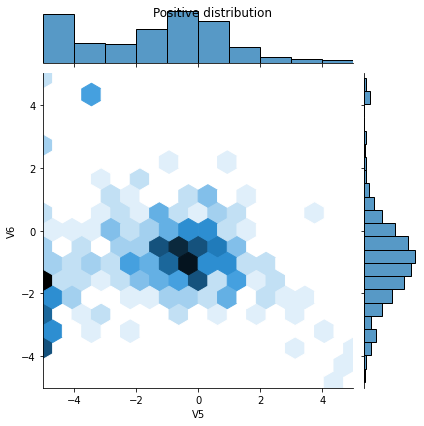

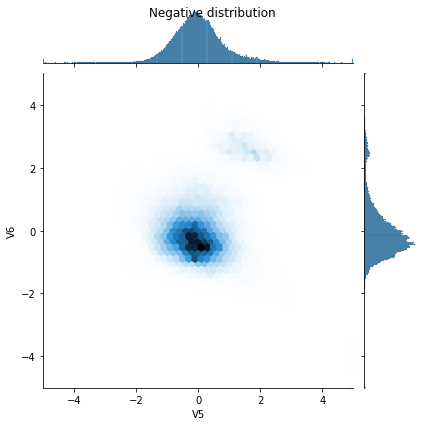

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

array([[0.43769827],
       [0.93449134],
       [0.43766674],
       [0.45128497],
       [0.8489004 ],
       [0.6685503 ],
       [0.64561343],
       [0.40402412],
       [0.4268172 ],
       [0.3361551 ]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.9491


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.0045591 ],
       [0.00154175],
       [0.00143366],
       [0.00461797],
       [0.00075015],
       [0.00152292],
       [0.00843064],
       [0.00139166],
       [0.00732469],
       [0.00100218]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0208


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

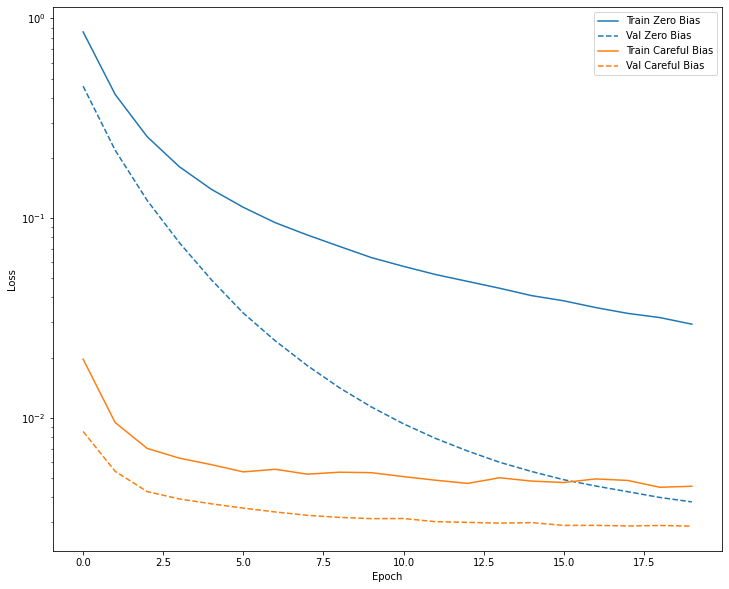

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 0s - loss: 0.0301 - tp: 62.0000 - fp: 16.0000 - tn: 47519.0000 - fn: 20.0000 - accuracy: 0.9992 - precision: 0.7949 - recall: 0.7561 - auc: 0.9496

13/90 [===>..........................] - ETA: 0s - loss: 0.0264 - tp: 62.0000 - fp: 99.0000 - tn: 71977.0000 - fn: 55.0000 - accuracy: 0.9979 - precision: 0.3851 - recall: 0.5299 - auc: 0.8640

25/90 [=======>......................] - ETA: 0s - loss: 0.0255 - tp: 63.0000 - fp: 166.0000 - tn: 96431.0000 - fn: 109.0000 - accuracy: 0.9972 - precision: 0.2751 - recall: 0.3663 - auc: 0.7983

37/90 [===========>..................] - ETA: 0s - loss: 0.0240 - tp: 64.0000 - fp: 210.0000 - tn: 120919.0000 - fn: 152.0000 - accuracy: 0.9970 - precision: 0.2336 - recall: 0.2963 - auc: 0.7631

49/90 [===============>..............] - ETA: 0s - loss: 0.0220 - tp: 66.0000 - fp: 243.0000 - tn: 145422.0000 - fn: 190.0000 - accuracy: 0.9970 - precision: 0.2136 - recall: 0.2578 - auc: 0.7621

61/90 [===================>..........] - ETA: 0s - loss: 0.0204 - tp: 69.0000 - fp: 269.0000 - tn: 169933.0000 - fn: 226.0000 - accuracy: 0.9971 - precision: 0.2041 - recall: 0.2339 - auc: 0.7623

72/90 [=======================>......] - ETA: 0s - loss: 0.0194 - tp: 76.0000 - fp: 296.0000 - tn: 192391.0000 - fn: 262.0000 - accuracy: 0.9971 - precision: 0.2043 - recall: 0.2249 - auc: 0.7716

84/90 [===========================>..] - ETA: 0s - loss: 0.0183 - tp: 81.0000 - fp: 317.0000 - tn: 216901.0000 - fn: 302.0000 - accuracy: 0.9972 - precision: 0.2035 - recall: 0.2115 - auc: 0.7775

90/90 [==============================] - 1s 13ms/step - loss: 0.0180 - tp: 85.0000 - fp: 323.0000 - tn: 227118.0000 - fn: 319.0000 - accuracy: 0.9972 - precision: 0.2083 - recall: 0.2104 - auc: 0.7760 - val_loss: 0.0077 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45488.0000 - val_fn: 81.0000 - val_accuracy: 0.9982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9335


Epoch 2/100
 1/90 [..............................] - ETA: 0s - loss: 0.0104 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6212

13/90 [===>..........................] - ETA: 0s - loss: 0.0102 - tp: 4.0000 - fp: 15.0000 - tn: 26571.0000 - fn: 34.0000 - accuracy: 0.9982 - precision: 0.2105 - recall: 0.1053 - auc: 0.7525         

25/90 [=======>......................] - ETA: 0s - loss: 0.0094 - tp: 15.0000 - fp: 21.0000 - tn: 51099.0000 - fn: 65.0000 - accuracy: 0.9983 - precision: 0.4167 - recall: 0.1875 - auc: 0.8289

37/90 [===========>..................] - ETA: 0s - loss: 0.0094 - tp: 26.0000 - fp: 29.0000 - tn: 75617.0000 - fn: 104.0000 - accuracy: 0.9982 - precision: 0.4727 - recall: 0.2000 - auc: 0.8376

49/90 [===============>..............] - ETA: 0s - loss: 0.0094 - tp: 40.0000 - fp: 38.0000 - tn: 100136.0000 - fn: 138.0000 - accuracy: 0.9982 - precision: 0.5128 - recall: 0.2247 - auc: 0.8456

60/90 [===================>..........] - ETA: 0s - loss: 0.0092 - tp: 57.0000 - fp: 43.0000 - tn: 122618.0000 - fn: 162.0000 - accuracy: 0.9983 - precision: 0.5700 - recall: 0.2603 - auc: 0.8502

72/90 [=======================>......] - ETA: 0s - loss: 0.0091 - tp: 68.0000 - fp: 54.0000 - tn: 147141.0000 - fn: 193.0000 - accuracy: 0.9983 - precision: 0.5574 - recall: 0.2605 - auc: 0.8504

83/90 [==========================>...] - ETA: 0s - loss: 0.0091 - tp: 84.0000 - fp: 61.0000 - tn: 169620.0000 - fn: 219.0000 - accuracy: 0.9984 - precision: 0.5793 - recall: 0.2772 - auc: 0.8475

90/90 [==============================] - 1s 6ms/step - loss: 0.0089 - tp: 93.0000 - fp: 65.0000 - tn: 181888.0000 - fn: 230.0000 - accuracy: 0.9984 - precision: 0.5886 - recall: 0.2879 - auc: 0.8504 - val_loss: 0.0049 - val_tp: 38.0000 - val_fp: 6.0000 - val_tn: 45482.0000 - val_fn: 43.0000 - val_accuracy: 0.9989 - val_precision: 0.8636 - val_recall: 0.4691 - val_auc: 0.9495


Epoch 3/100
 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.8925

12/90 [===>..........................] - ETA: 0s - loss: 0.0071 - tp: 21.0000 - fp: 7.0000 - tn: 24528.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.7500 - recall: 0.5122 - auc: 0.9034 

23/90 [======>.......................] - ETA: 0s - loss: 0.0058 - tp: 39.0000 - fp: 10.0000 - tn: 47025.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.7959 - recall: 0.5652 - auc: 0.9342

34/90 [==========>...................] - ETA: 0s - loss: 0.0062 - tp: 60.0000 - fp: 16.0000 - tn: 69502.0000 - fn: 54.0000 - accuracy: 0.9990 - precision: 0.7895 - recall: 0.5263 - auc: 0.9305

46/90 [==============>...............] - ETA: 0s - loss: 0.0066 - tp: 77.0000 - fp: 18.0000 - tn: 94023.0000 - fn: 90.0000 - accuracy: 0.9989 - precision: 0.8105 - recall: 0.4611 - auc: 0.9286

58/90 [==================>...........] - ETA: 0s - loss: 0.0065 - tp: 95.0000 - fp: 22.0000 - tn: 118557.0000 - fn: 110.0000 - accuracy: 0.9989 - precision: 0.8120 - recall: 0.4634 - auc: 0.9228

70/90 [======================>.......] - ETA: 0s - loss: 0.0065 - tp: 108.0000 - fp: 25.0000 - tn: 143092.0000 - fn: 135.0000 - accuracy: 0.9989 - precision: 0.8120 - recall: 0.4444 - auc: 0.9190

81/90 [==========================>...] - ETA: 0s - loss: 0.0066 - tp: 123.0000 - fp: 28.0000 - tn: 165574.0000 - fn: 163.0000 - accuracy: 0.9988 - precision: 0.8146 - recall: 0.4301 - auc: 0.9122

90/90 [==============================] - 1s 6ms/step - loss: 0.0067 - tp: 143.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 180.0000 - accuracy: 0.9988 - precision: 0.8125 - recall: 0.4427 - auc: 0.9075 - val_loss: 0.0042 - val_tp: 49.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 32.0000 - val_accuracy: 0.9991 - val_precision: 0.8750 - val_recall: 0.6049 - val_auc: 0.9501


Epoch 4/100
 1/90 [..............................] - ETA: 0s - loss: 0.0053 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8250

13/90 [===>..........................] - ETA: 0s - loss: 0.0068 - tp: 36.0000 - fp: 5.0000 - tn: 26559.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8780 - recall: 0.6000 - auc: 0.9194 

25/90 [=======>......................] - ETA: 0s - loss: 0.0059 - tp: 59.0000 - fp: 10.0000 - tn: 51094.0000 - fn: 37.0000 - accuracy: 0.9991 - precision: 0.8551 - recall: 0.6146 - auc: 0.9169

37/90 [===========>..................] - ETA: 0s - loss: 0.0061 - tp: 80.0000 - fp: 16.0000 - tn: 75620.0000 - fn: 60.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5714 - auc: 0.9090

49/90 [===============>..............] - ETA: 0s - loss: 0.0060 - tp: 102.0000 - fp: 24.0000 - tn: 100150.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.8095 - recall: 0.5730 - auc: 0.9075

61/90 [===================>..........] - ETA: 0s - loss: 0.0058 - tp: 125.0000 - fp: 27.0000 - tn: 124681.0000 - fn: 95.0000 - accuracy: 0.9990 - precision: 0.8224 - recall: 0.5682 - auc: 0.9109

72/90 [=======================>......] - ETA: 0s - loss: 0.0056 - tp: 146.0000 - fp: 29.0000 - tn: 147170.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8343 - recall: 0.5681 - auc: 0.9137

84/90 [===========================>..] - ETA: 0s - loss: 0.0059 - tp: 169.0000 - fp: 31.0000 - tn: 171693.0000 - fn: 139.0000 - accuracy: 0.9990 - precision: 0.8450 - recall: 0.5487 - auc: 0.9040

90/90 [==============================] - 1s 6ms/step - loss: 0.0059 - tp: 173.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8398 - recall: 0.5356 - auc: 0.9051 - val_loss: 0.0039 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8871 - val_recall: 0.6790 - val_auc: 0.9503


Epoch 5/100
 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0059 - tp: 32.0000 - fp: 4.0000 - tn: 26565.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.8889 - recall: 0.5818 - auc: 0.9151 

25/90 [=======>......................] - ETA: 0s - loss: 0.0061 - tp: 50.0000 - fp: 8.0000 - tn: 51100.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.5435 - auc: 0.8871

37/90 [===========>..................] - ETA: 0s - loss: 0.0066 - tp: 77.0000 - fp: 10.0000 - tn: 75620.0000 - fn: 69.0000 - accuracy: 0.9990 - precision: 0.8851 - recall: 0.5274 - auc: 0.8862

49/90 [===============>..............] - ETA: 0s - loss: 0.0064 - tp: 101.0000 - fp: 21.0000 - tn: 100146.0000 - fn: 84.0000 - accuracy: 0.9990 - precision: 0.8279 - recall: 0.5459 - auc: 0.8987

61/90 [===================>..........] - ETA: 0s - loss: 0.0058 - tp: 122.0000 - fp: 25.0000 - tn: 124684.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.8299 - recall: 0.5571 - auc: 0.9074

73/90 [=======================>......] - ETA: 0s - loss: 0.0059 - tp: 144.0000 - fp: 31.0000 - tn: 149213.0000 - fn: 116.0000 - accuracy: 0.9990 - precision: 0.8229 - recall: 0.5538 - auc: 0.9002

85/90 [===========================>..] - ETA: 0s - loss: 0.0060 - tp: 168.0000 - fp: 36.0000 - tn: 173738.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5490 - auc: 0.9000

90/90 [==============================] - 1s 6ms/step - loss: 0.0060 - tp: 180.0000 - fp: 37.0000 - tn: 181916.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8295 - recall: 0.5573 - auc: 0.8989 - val_loss: 0.0037 - val_tp: 57.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8906 - val_recall: 0.7037 - val_auc: 0.9503


Epoch 6/100
 1/90 [..............................] - ETA: 0s - loss: 0.0096 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.8290

13/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 31.0000 - fp: 4.0000 - tn: 26569.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.6078 - auc: 0.8896 

25/90 [=======>......................] - ETA: 0s - loss: 0.0050 - tp: 55.0000 - fp: 8.0000 - tn: 51101.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.8730 - recall: 0.6044 - auc: 0.9040

37/90 [===========>..................] - ETA: 0s - loss: 0.0055 - tp: 84.0000 - fp: 12.0000 - tn: 75622.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5915 - auc: 0.8915

49/90 [===============>..............] - ETA: 0s - loss: 0.0057 - tp: 105.0000 - fp: 17.0000 - tn: 100152.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8607 - recall: 0.5738 - auc: 0.8961

61/90 [===================>..........] - ETA: 0s - loss: 0.0057 - tp: 132.0000 - fp: 27.0000 - tn: 124668.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8302 - recall: 0.5665 - auc: 0.9094

73/90 [=======================>......] - ETA: 0s - loss: 0.0052 - tp: 157.0000 - fp: 32.0000 - tn: 149207.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8307 - recall: 0.5925 - auc: 0.9184

85/90 [===========================>..] - ETA: 0s - loss: 0.0052 - tp: 174.0000 - fp: 40.0000 - tn: 173739.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8131 - recall: 0.5781 - auc: 0.9162

90/90 [==============================] - 1s 6ms/step - loss: 0.0054 - tp: 184.0000 - fp: 42.0000 - tn: 181911.0000 - fn: 139.0000 - accuracy: 0.9990 - precision: 0.8142 - recall: 0.5697 - auc: 0.9139 - val_loss: 0.0035 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9503


Epoch 7/100
 1/90 [..............................] - ETA: 0s - loss: 0.0011 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 24.0000 - fp: 2.0000 - tn: 24532.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.9231 - recall: 0.5714 - auc: 0.9385     

23/90 [======>.......................] - ETA: 0s - loss: 0.0051 - tp: 45.0000 - fp: 13.0000 - tn: 47011.0000 - fn: 35.0000 - accuracy: 0.9990 - precision: 0.7759 - recall: 0.5625 - auc: 0.9290

35/90 [==========>...................] - ETA: 0s - loss: 0.0047 - tp: 67.0000 - fp: 18.0000 - tn: 71548.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.7882 - recall: 0.5877 - auc: 0.9276

46/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 95.0000 - fp: 21.0000 - tn: 94033.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8190 - recall: 0.6169 - auc: 0.9364

57/90 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 113.0000 - fp: 26.0000 - tn: 116522.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8129 - recall: 0.6011 - auc: 0.9316

69/90 [======================>.......] - ETA: 0s - loss: 0.0048 - tp: 138.0000 - fp: 34.0000 - tn: 141047.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.8023 - recall: 0.5974 - auc: 0.9309

81/90 [==========================>...] - ETA: 0s - loss: 0.0050 - tp: 167.0000 - fp: 35.0000 - tn: 165566.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8267 - recall: 0.5819 - auc: 0.9213

90/90 [==============================] - 1s 6ms/step - loss: 0.0052 - tp: 182.0000 - fp: 36.0000 - tn: 181917.0000 - fn: 141.0000 - accuracy: 0.9990 - precision: 0.8349 - recall: 0.5635 - auc: 0.9158 - val_loss: 0.0034 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9503


Epoch 8/100
 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0056 - tp: 19.0000 - fp: 4.0000 - tn: 26575.0000 - fn: 26.0000 - accuracy: 0.9989 - precision: 0.8261 - recall: 0.4222 - auc: 0.8754             

24/90 [=======>......................] - ETA: 0s - loss: 0.0058 - tp: 39.0000 - fp: 9.0000 - tn: 49056.0000 - fn: 48.0000 - accuracy: 0.9988 - precision: 0.8125 - recall: 0.4483 - auc: 0.8943

35/90 [==========>...................] - ETA: 0s - loss: 0.0058 - tp: 62.0000 - fp: 12.0000 - tn: 71541.0000 - fn: 65.0000 - accuracy: 0.9989 - precision: 0.8378 - recall: 0.4882 - auc: 0.8914

47/90 [==============>...............] - ETA: 0s - loss: 0.0057 - tp: 89.0000 - fp: 17.0000 - tn: 96064.0000 - fn: 86.0000 - accuracy: 0.9989 - precision: 0.8396 - recall: 0.5086 - auc: 0.8977

59/90 [==================>...........] - ETA: 0s - loss: 0.0053 - tp: 119.0000 - fp: 21.0000 - tn: 120593.0000 - fn: 99.0000 - accuracy: 0.9990 - precision: 0.8500 - recall: 0.5459 - auc: 0.9085

71/90 [======================>.......] - ETA: 0s - loss: 0.0054 - tp: 144.0000 - fp: 31.0000 - tn: 145121.0000 - fn: 112.0000 - accuracy: 0.9990 - precision: 0.8229 - recall: 0.5625 - auc: 0.9120

83/90 [==========================>...] - ETA: 0s - loss: 0.0054 - tp: 171.0000 - fp: 33.0000 - tn: 169648.0000 - fn: 132.0000 - accuracy: 0.9990 - precision: 0.8382 - recall: 0.5644 - auc: 0.9139

90/90 [==============================] - 1s 6ms/step - loss: 0.0052 - tp: 185.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 138.0000 - accuracy: 0.9991 - precision: 0.8409 - recall: 0.5728 - auc: 0.9161 - val_loss: 0.0033 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9504


Epoch 9/100
 1/90 [..............................] - ETA: 0s - loss: 9.5862e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 20.0000 - fp: 2.0000 - tn: 24532.0000 - fn: 22.0000 - accuracy: 0.9990 - precision: 0.9091 - recall: 0.4762 - auc: 0.8909         

24/90 [=======>......................] - ETA: 0s - loss: 0.0053 - tp: 44.0000 - fp: 2.0000 - tn: 49064.0000 - fn: 42.0000 - accuracy: 0.9991 - precision: 0.9565 - recall: 0.5116 - auc: 0.8932

36/90 [===========>..................] - ETA: 0s - loss: 0.0053 - tp: 67.0000 - fp: 7.0000 - tn: 73590.0000 - fn: 64.0000 - accuracy: 0.9990 - precision: 0.9054 - recall: 0.5115 - auc: 0.9024

48/90 [===============>..............] - ETA: 0s - loss: 0.0051 - tp: 91.0000 - fp: 11.0000 - tn: 98123.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8922 - recall: 0.5353 - auc: 0.9098

60/90 [===================>..........] - ETA: 0s - loss: 0.0054 - tp: 116.0000 - fp: 18.0000 - tn: 122644.0000 - fn: 102.0000 - accuracy: 0.9990 - precision: 0.8657 - recall: 0.5321 - auc: 0.9040

71/90 [======================>.......] - ETA: 0s - loss: 0.0054 - tp: 140.0000 - fp: 23.0000 - tn: 145127.0000 - fn: 118.0000 - accuracy: 0.9990 - precision: 0.8589 - recall: 0.5426 - auc: 0.9051

82/90 [==========================>...] - ETA: 0s - loss: 0.0053 - tp: 160.0000 - fp: 30.0000 - tn: 167613.0000 - fn: 133.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5461 - auc: 0.9077

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 178.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 145.0000 - accuracy: 0.9990 - precision: 0.8517 - recall: 0.5511 - auc: 0.9084 - val_loss: 0.0032 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9503


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 29.0000 - fp: 9.0000 - tn: 26568.0000 - fn: 18.0000 - accuracy: 0.9990 - precision: 0.7632 - recall: 0.6170 - auc: 0.9244 

25/90 [=======>......................] - ETA: 0s - loss: 0.0051 - tp: 58.0000 - fp: 13.0000 - tn: 51091.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8169 - recall: 0.6042 - auc: 0.9206

36/90 [===========>..................] - ETA: 0s - loss: 0.0051 - tp: 87.0000 - fp: 16.0000 - tn: 73568.0000 - fn: 57.0000 - accuracy: 0.9990 - precision: 0.8447 - recall: 0.6042 - auc: 0.9154

48/90 [===============>..............] - ETA: 0s - loss: 0.0050 - tp: 106.0000 - fp: 20.0000 - tn: 98102.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.8413 - recall: 0.5824 - auc: 0.9106

59/90 [==================>...........] - ETA: 0s - loss: 0.0050 - tp: 123.0000 - fp: 22.0000 - tn: 120585.0000 - fn: 102.0000 - accuracy: 0.9990 - precision: 0.8483 - recall: 0.5467 - auc: 0.9163

71/90 [======================>.......] - ETA: 0s - loss: 0.0050 - tp: 147.0000 - fp: 26.0000 - tn: 145117.0000 - fn: 118.0000 - accuracy: 0.9990 - precision: 0.8497 - recall: 0.5547 - auc: 0.9154

83/90 [==========================>...] - ETA: 0s - loss: 0.0050 - tp: 173.0000 - fp: 30.0000 - tn: 169648.0000 - fn: 133.0000 - accuracy: 0.9990 - precision: 0.8522 - recall: 0.5654 - auc: 0.9102

90/90 [==============================] - 1s 6ms/step - loss: 0.0049 - tp: 184.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8598 - recall: 0.5697 - auc: 0.9118 - val_loss: 0.0031 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9565


Epoch 11/100
 1/90 [..............................] - ETA: 0s - loss: 0.0025 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9998

13/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 20.0000 - fp: 2.0000 - tn: 26582.0000 - fn: 20.0000 - accuracy: 0.9992 - precision: 0.9091 - recall: 0.5000 - auc: 0.9108 

24/90 [=======>......................] - ETA: 0s - loss: 0.0046 - tp: 47.0000 - fp: 6.0000 - tn: 49060.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8868 - recall: 0.5465 - auc: 0.9228

35/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 70.0000 - fp: 13.0000 - tn: 71548.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8434 - recall: 0.5882 - auc: 0.9229

46/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 89.0000 - fp: 18.0000 - tn: 94038.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8318 - recall: 0.5855 - auc: 0.9195

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 113.0000 - fp: 22.0000 - tn: 116522.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8370 - recall: 0.5885 - auc: 0.9204

68/90 [=====================>........] - ETA: 0s - loss: 0.0045 - tp: 135.0000 - fp: 25.0000 - tn: 139002.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8438 - recall: 0.5696 - auc: 0.9226

80/90 [=========================>....] - ETA: 0s - loss: 0.0046 - tp: 167.0000 - fp: 28.0000 - tn: 163521.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8564 - recall: 0.5739 - auc: 0.9246

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 185.0000 - fp: 36.0000 - tn: 181917.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8371 - recall: 0.5728 - auc: 0.9226 - val_loss: 0.0031 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9565


Epoch 12/100
 1/90 [..............................] - ETA: 0s - loss: 0.0061 - tp: 3.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.6000 - recall: 0.7500 - auc: 0.9996

12/90 [===>..........................] - ETA: 0s - loss: 0.0057 - tp: 32.0000 - fp: 9.0000 - tn: 24517.0000 - fn: 18.0000 - accuracy: 0.9989 - precision: 0.7805 - recall: 0.6400 - auc: 0.8986

23/90 [======>.......................] - ETA: 0s - loss: 0.0053 - tp: 52.0000 - fp: 12.0000 - tn: 47005.0000 - fn: 35.0000 - accuracy: 0.9990 - precision: 0.8125 - recall: 0.5977 - auc: 0.8891

34/90 [==========>...................] - ETA: 0s - loss: 0.0050 - tp: 73.0000 - fp: 15.0000 - tn: 69489.0000 - fn: 55.0000 - accuracy: 0.9990 - precision: 0.8295 - recall: 0.5703 - auc: 0.9008

45/90 [==============>...............] - ETA: 0s - loss: 0.0048 - tp: 93.0000 - fp: 17.0000 - tn: 91976.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.8455 - recall: 0.5569 - auc: 0.9087

56/90 [=================>............] - ETA: 0s - loss: 0.0048 - tp: 113.0000 - fp: 20.0000 - tn: 114465.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8496 - recall: 0.5567 - auc: 0.9098

67/90 [=====================>........] - ETA: 0s - loss: 0.0046 - tp: 134.0000 - fp: 25.0000 - tn: 136953.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8428 - recall: 0.5630 - auc: 0.9146

78/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 160.0000 - fp: 28.0000 - tn: 159429.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8511 - recall: 0.5575 - auc: 0.9115

89/90 [============================>.] - ETA: 0s - loss: 0.0048 - tp: 181.0000 - fp: 33.0000 - tn: 181916.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8458 - recall: 0.5604 - auc: 0.9056

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 181.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8458 - recall: 0.5604 - auc: 0.9056 - val_loss: 0.0030 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7160 - val_auc: 0.9565


Epoch 13/100
 1/90 [..............................] - ETA: 0s - loss: 0.0055 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.8737

12/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 24.0000 - fp: 3.0000 - tn: 24523.0000 - fn: 26.0000 - accuracy: 0.9988 - precision: 0.8889 - recall: 0.4800 - auc: 0.9188

23/90 [======>.......................] - ETA: 0s - loss: 0.0047 - tp: 50.0000 - fp: 9.0000 - tn: 47005.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8475 - recall: 0.5556 - auc: 0.9099

34/90 [==========>...................] - ETA: 0s - loss: 0.0046 - tp: 76.0000 - fp: 13.0000 - tn: 69487.0000 - fn: 56.0000 - accuracy: 0.9990 - precision: 0.8539 - recall: 0.5758 - auc: 0.9231

45/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 98.0000 - fp: 18.0000 - tn: 91975.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8448 - recall: 0.5868 - auc: 0.9240

56/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 124.0000 - fp: 19.0000 - tn: 114466.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8671 - recall: 0.6108 - auc: 0.9324

67/90 [=====================>........] - ETA: 0s - loss: 0.0045 - tp: 139.0000 - fp: 22.0000 - tn: 136954.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8634 - recall: 0.5792 - auc: 0.9259

78/90 [=========================>....] - ETA: 0s - loss: 0.0046 - tp: 170.0000 - fp: 28.0000 - tn: 159429.0000 - fn: 117.0000 - accuracy: 0.9991 - precision: 0.8586 - recall: 0.5923 - auc: 0.9239

89/90 [============================>.] - ETA: 0s - loss: 0.0046 - tp: 188.0000 - fp: 35.0000 - tn: 181914.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8430 - recall: 0.5820 - auc: 0.9229

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 188.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8430 - recall: 0.5820 - auc: 0.9229 - val_loss: 0.0030 - val_tp: 61.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8971 - val_recall: 0.7531 - val_auc: 0.9565


Epoch 14/100
 1/90 [..............................] - ETA: 0s - loss: 0.0057 - tp: 3.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.7500 - recall: 0.7500 - auc: 0.8735

12/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 24.0000 - fp: 5.0000 - tn: 24530.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8276 - recall: 0.5854 - auc: 0.9011

23/90 [======>.......................] - ETA: 0s - loss: 0.0050 - tp: 42.0000 - fp: 8.0000 - tn: 47018.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.8400 - recall: 0.5385 - auc: 0.8960

34/90 [==========>...................] - ETA: 0s - loss: 0.0050 - tp: 70.0000 - fp: 10.0000 - tn: 69497.0000 - fn: 55.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5600 - auc: 0.9026

45/90 [==============>...............] - ETA: 0s - loss: 0.0047 - tp: 103.0000 - fp: 14.0000 - tn: 91976.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8803 - recall: 0.6059 - auc: 0.9163

56/90 [=================>............] - ETA: 0s - loss: 0.0047 - tp: 117.0000 - fp: 18.0000 - tn: 114469.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.5821 - auc: 0.9091

67/90 [=====================>........] - ETA: 0s - loss: 0.0046 - tp: 140.0000 - fp: 23.0000 - tn: 136959.0000 - fn: 94.0000 - accuracy: 0.9991 - precision: 0.8589 - recall: 0.5983 - auc: 0.9153

78/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 158.0000 - fp: 28.0000 - tn: 159444.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8495 - recall: 0.5809 - auc: 0.9122

89/90 [============================>.] - ETA: 0s - loss: 0.0048 - tp: 188.0000 - fp: 37.0000 - tn: 181912.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8356 - recall: 0.5820 - auc: 0.9119

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 188.0000 - fp: 37.0000 - tn: 181916.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8356 - recall: 0.5820 - auc: 0.9119 - val_loss: 0.0030 - val_tp: 59.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.8939 - val_recall: 0.7284 - val_auc: 0.9565


Epoch 15/100
 1/90 [..............................] - ETA: 0s - loss: 0.0043 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8735

12/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 24.0000 - fp: 4.0000 - tn: 24525.0000 - fn: 23.0000 - accuracy: 0.9989 - precision: 0.8571 - recall: 0.5106 - auc: 0.9244 

23/90 [======>.......................] - ETA: 0s - loss: 0.0048 - tp: 43.0000 - fp: 6.0000 - tn: 47011.0000 - fn: 44.0000 - accuracy: 0.9989 - precision: 0.8776 - recall: 0.4943 - auc: 0.9126

35/90 [==========>...................] - ETA: 0s - loss: 0.0049 - tp: 66.0000 - fp: 10.0000 - tn: 71539.0000 - fn: 65.0000 - accuracy: 0.9990 - precision: 0.8684 - recall: 0.5038 - auc: 0.9147

46/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 85.0000 - fp: 12.0000 - tn: 94034.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.8763 - recall: 0.5247 - auc: 0.9185

57/90 [==================>...........] - ETA: 0s - loss: 0.0047 - tp: 112.0000 - fp: 16.0000 - tn: 116512.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8750 - recall: 0.5385 - auc: 0.9170

68/90 [=====================>........] - ETA: 0s - loss: 0.0046 - tp: 131.0000 - fp: 21.0000 - tn: 139000.0000 - fn: 112.0000 - accuracy: 0.9990 - precision: 0.8618 - recall: 0.5391 - auc: 0.9206

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 154.0000 - fp: 25.0000 - tn: 161487.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8603 - recall: 0.5500 - auc: 0.9256

90/90 [==============================] - ETA: 0s - loss: 0.0046 - tp: 179.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8565 - recall: 0.5542 - auc: 0.9261

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 179.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8565 - recall: 0.5542 - auc: 0.9261 - val_loss: 0.0029 - val_tp: 62.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8986 - val_recall: 0.7654 - val_auc: 0.9565


Epoch 16/100
 1/90 [..............................] - ETA: 0s - loss: 7.4374e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

12/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 20.0000 - fp: 5.0000 - tn: 24535.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.5556 - auc: 0.8452                         

23/90 [======>.......................] - ETA: 0s - loss: 0.0047 - tp: 52.0000 - fp: 9.0000 - tn: 47005.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8525 - recall: 0.5778 - auc: 0.9097

34/90 [==========>...................] - ETA: 0s - loss: 0.0053 - tp: 76.0000 - fp: 15.0000 - tn: 69481.0000 - fn: 60.0000 - accuracy: 0.9989 - precision: 0.8352 - recall: 0.5588 - auc: 0.9066

45/90 [==============>...............] - ETA: 0s - loss: 0.0053 - tp: 93.0000 - fp: 22.0000 - tn: 91966.0000 - fn: 79.0000 - accuracy: 0.9989 - precision: 0.8087 - recall: 0.5407 - auc: 0.9085

56/90 [=================>............] - ETA: 0s - loss: 0.0051 - tp: 110.0000 - fp: 29.0000 - tn: 114454.0000 - fn: 95.0000 - accuracy: 0.9989 - precision: 0.7914 - recall: 0.5366 - auc: 0.9157

67/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 127.0000 - fp: 32.0000 - tn: 136944.0000 - fn: 113.0000 - accuracy: 0.9989 - precision: 0.7987 - recall: 0.5292 - auc: 0.9258

78/90 [=========================>....] - ETA: 0s - loss: 0.0047 - tp: 157.0000 - fp: 36.0000 - tn: 159419.0000 - fn: 132.0000 - accuracy: 0.9989 - precision: 0.8135 - recall: 0.5433 - auc: 0.9244

89/90 [============================>.] - ETA: 0s - loss: 0.0046 - tp: 176.0000 - fp: 41.0000 - tn: 181908.0000 - fn: 147.0000 - accuracy: 0.9990 - precision: 0.8111 - recall: 0.5449 - auc: 0.9260

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 176.0000 - fp: 41.0000 - tn: 181912.0000 - fn: 147.0000 - accuracy: 0.9990 - precision: 0.8111 - recall: 0.5449 - auc: 0.9260 - val_loss: 0.0029 - val_tp: 62.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8986 - val_recall: 0.7654 - val_auc: 0.9565


Epoch 17/100
 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.9985

12/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 35.0000 - fp: 5.0000 - tn: 24519.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.6731 - auc: 0.9510 

23/90 [======>.......................] - ETA: 0s - loss: 0.0043 - tp: 58.0000 - fp: 7.0000 - tn: 47004.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8923 - recall: 0.6237 - auc: 0.9344

34/90 [==========>...................] - ETA: 0s - loss: 0.0042 - tp: 84.0000 - fp: 11.0000 - tn: 69483.0000 - fn: 54.0000 - accuracy: 0.9991 - precision: 0.8842 - recall: 0.6087 - auc: 0.9410

45/90 [==============>...............] - ETA: 0s - loss: 0.0043 - tp: 109.0000 - fp: 18.0000 - tn: 91966.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8583 - recall: 0.6193 - auc: 0.9449

56/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 125.0000 - fp: 24.0000 - tn: 114460.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8389 - recall: 0.6127 - auc: 0.9375

67/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 150.0000 - fp: 26.0000 - tn: 136943.0000 - fn: 97.0000 - accuracy: 0.9991 - precision: 0.8523 - recall: 0.6073 - auc: 0.9361

78/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 172.0000 - fp: 31.0000 - tn: 159428.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8473 - recall: 0.6035 - auc: 0.9321

89/90 [============================>.] - ETA: 0s - loss: 0.0042 - tp: 194.0000 - fp: 35.0000 - tn: 181914.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8472 - recall: 0.6006 - auc: 0.9292

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 194.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8472 - recall: 0.6006 - auc: 0.9292 - val_loss: 0.0029 - val_tp: 63.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.7778 - val_auc: 0.9565


Epoch 18/100
 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7477

12/90 [===>..........................] - ETA: 0s - loss: 0.0029 - tp: 33.0000 - fp: 1.0000 - tn: 24529.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.9706 - recall: 0.7174 - auc: 0.9556             

23/90 [======>.......................] - ETA: 0s - loss: 0.0033 - tp: 55.0000 - fp: 4.0000 - tn: 47018.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.9322 - recall: 0.6707 - auc: 0.9564

34/90 [==========>...................] - ETA: 0s - loss: 0.0034 - tp: 81.0000 - fp: 7.0000 - tn: 69507.0000 - fn: 37.0000 - accuracy: 0.9994 - precision: 0.9205 - recall: 0.6864 - auc: 0.9525

45/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 106.0000 - fp: 12.0000 - tn: 91988.0000 - fn: 54.0000 - accuracy: 0.9993 - precision: 0.8983 - recall: 0.6625 - auc: 0.9365

56/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 129.0000 - fp: 22.0000 - tn: 114465.0000 - fn: 72.0000 - accuracy: 0.9992 - precision: 0.8543 - recall: 0.6418 - auc: 0.9317

67/90 [=====================>........] - ETA: 0s - loss: 0.0044 - tp: 149.0000 - fp: 26.0000 - tn: 136952.0000 - fn: 89.0000 - accuracy: 0.9992 - precision: 0.8514 - recall: 0.6261 - auc: 0.9211

78/90 [=========================>....] - ETA: 0s - loss: 0.0045 - tp: 168.0000 - fp: 33.0000 - tn: 159437.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8358 - recall: 0.6131 - auc: 0.9185

89/90 [============================>.] - ETA: 0s - loss: 0.0044 - tp: 201.0000 - fp: 34.0000 - tn: 181915.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8553 - recall: 0.6223 - auc: 0.9199

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 201.0000 - fp: 34.0000 - tn: 181919.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8553 - recall: 0.6223 - auc: 0.9199 - val_loss: 0.0029 - val_tp: 62.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8986 - val_recall: 0.7654 - val_auc: 0.9565


Epoch 19/100
 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 26.0000 - fp: 3.0000 - tn: 24527.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8966 - recall: 0.5652 - auc: 0.9115 

23/90 [======>.......................] - ETA: 0s - loss: 0.0051 - tp: 49.0000 - fp: 9.0000 - tn: 47004.0000 - fn: 42.0000 - accuracy: 0.9989 - precision: 0.8448 - recall: 0.5385 - auc: 0.9164

34/90 [==========>...................] - ETA: 0s - loss: 0.0051 - tp: 75.0000 - fp: 12.0000 - tn: 69485.0000 - fn: 60.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.5556 - auc: 0.9209

45/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 102.0000 - fp: 19.0000 - tn: 91974.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.8430 - recall: 0.6108 - auc: 0.9329

56/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 118.0000 - fp: 21.0000 - tn: 114470.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8489 - recall: 0.5990 - auc: 0.9329

67/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 142.0000 - fp: 26.0000 - tn: 136949.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8452 - recall: 0.5892 - auc: 0.9366

78/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 168.0000 - fp: 29.0000 - tn: 159429.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8528 - recall: 0.5874 - auc: 0.9377

89/90 [============================>.] - ETA: 0s - loss: 0.0044 - tp: 189.0000 - fp: 33.0000 - tn: 181916.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8514 - recall: 0.5851 - auc: 0.9291

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 189.0000 - fp: 33.0000 - tn: 181920.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8514 - recall: 0.5851 - auc: 0.9291 - val_loss: 0.0029 - val_tp: 63.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.7778 - val_auc: 0.9565


Epoch 20/100
 1/90 [..............................] - ETA: 0s - loss: 0.0080 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8991

12/90 [===>..........................] - ETA: 0s - loss: 0.0053 - tp: 29.0000 - fp: 4.0000 - tn: 24519.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8788 - recall: 0.5472 - auc: 0.9610 

23/90 [======>.......................] - ETA: 0s - loss: 0.0050 - tp: 49.0000 - fp: 6.0000 - tn: 47011.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8909 - recall: 0.5632 - auc: 0.9239

34/90 [==========>...................] - ETA: 0s - loss: 0.0045 - tp: 78.0000 - fp: 12.0000 - tn: 69491.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.6047 - auc: 0.9291

45/90 [==============>...............] - ETA: 0s - loss: 0.0043 - tp: 98.0000 - fp: 18.0000 - tn: 91981.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8448 - recall: 0.6087 - auc: 0.9274

56/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 115.0000 - fp: 24.0000 - tn: 114469.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8273 - recall: 0.5897 - auc: 0.9271

67/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 137.0000 - fp: 25.0000 - tn: 136952.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8457 - recall: 0.5732 - auc: 0.9277

78/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 163.0000 - fp: 27.0000 - tn: 159433.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8579 - recall: 0.5739 - auc: 0.9302

89/90 [============================>.] - ETA: 0s - loss: 0.0043 - tp: 184.0000 - fp: 30.0000 - tn: 181919.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8598 - recall: 0.5697 - auc: 0.9277

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 184.0000 - fp: 30.0000 - tn: 181923.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8598 - recall: 0.5697 - auc: 0.9277 - val_loss: 0.0029 - val_tp: 64.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9014 - val_recall: 0.7901 - val_auc: 0.9565


Epoch 21/100
 1/90 [..............................] - ETA: 0s - loss: 0.0100 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8311

12/90 [===>..........................] - ETA: 0s - loss: 0.0031 - tp: 27.0000 - fp: 3.0000 - tn: 24531.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.9000 - recall: 0.6429 - auc: 0.9754         

23/90 [======>.......................] - ETA: 0s - loss: 0.0032 - tp: 56.0000 - fp: 10.0000 - tn: 47013.0000 - fn: 25.0000 - accuracy: 0.9993 - precision: 0.8485 - recall: 0.6914 - auc: 0.9684

35/90 [==========>...................] - ETA: 0s - loss: 0.0037 - tp: 76.0000 - fp: 19.0000 - tn: 71547.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8000 - recall: 0.6667 - auc: 0.9465

47/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 104.0000 - fp: 23.0000 - tn: 96070.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8189 - recall: 0.6380 - auc: 0.9253

58/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 126.0000 - fp: 25.0000 - tn: 118560.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8344 - recall: 0.6332 - auc: 0.9262

69/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 156.0000 - fp: 31.0000 - tn: 141031.0000 - fn: 94.0000 - accuracy: 0.9991 - precision: 0.8342 - recall: 0.6240 - auc: 0.9290

80/90 [=========================>....] - ETA: 0s - loss: 0.0041 - tp: 182.0000 - fp: 36.0000 - tn: 163513.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8349 - recall: 0.6254 - auc: 0.9286

90/90 [==============================] - ETA: 0s - loss: 0.0043 - tp: 193.0000 - fp: 38.0000 - tn: 181915.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8355 - recall: 0.5975 - auc: 0.9262

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 193.0000 - fp: 38.0000 - tn: 181915.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8355 - recall: 0.5975 - auc: 0.9262 - val_loss: 0.0028 - val_tp: 63.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.7778 - val_auc: 0.9565


Epoch 22/100
 1/90 [..............................] - ETA: 0s - loss: 0.0028 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9988

12/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 26.0000 - fp: 4.0000 - tn: 24522.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8667 - recall: 0.5200 - auc: 0.9287 

23/90 [======>.......................] - ETA: 0s - loss: 0.0039 - tp: 44.0000 - fp: 8.0000 - tn: 47020.0000 - fn: 32.0000 - accuracy: 0.9992 - precision: 0.8462 - recall: 0.5789 - auc: 0.9396

34/90 [==========>...................] - ETA: 0s - loss: 0.0039 - tp: 74.0000 - fp: 11.0000 - tn: 69498.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8706 - recall: 0.6016 - auc: 0.9421

45/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 95.0000 - fp: 15.0000 - tn: 91987.0000 - fn: 63.0000 - accuracy: 0.9992 - precision: 0.8636 - recall: 0.6013 - auc: 0.9420

56/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 119.0000 - fp: 21.0000 - tn: 114463.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8500 - recall: 0.5833 - auc: 0.9303

67/90 [=====================>........] - ETA: 0s - loss: 0.0041 - tp: 140.0000 - fp: 24.0000 - tn: 136954.0000 - fn: 98.0000 - accuracy: 0.9991 - precision: 0.8537 - recall: 0.5882 - auc: 0.9296

78/90 [=========================>....] - ETA: 0s - loss: 0.0040 - tp: 167.0000 - fp: 27.0000 - tn: 159437.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8608 - recall: 0.5964 - auc: 0.9365

89/90 [============================>.] - ETA: 0s - loss: 0.0041 - tp: 193.0000 - fp: 35.0000 - tn: 181914.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8465 - recall: 0.5975 - auc: 0.9324

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 193.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8465 - recall: 0.5975 - auc: 0.9324 - val_loss: 0.0028 - val_tp: 64.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9014 - val_recall: 0.7901 - val_auc: 0.9565


Epoch 23/100
 1/90 [..............................] - ETA: 0s - loss: 8.9853e-04 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

12/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 25.0000 - fp: 7.0000 - tn: 24526.0000 - fn: 18.0000 - accuracy: 0.9990 - precision: 0.7812 - recall: 0.5814 - auc: 0.9057                     

23/90 [======>.......................] - ETA: 0s - loss: 0.0055 - tp: 48.0000 - fp: 14.0000 - tn: 46999.0000 - fn: 43.0000 - accuracy: 0.9988 - precision: 0.7742 - recall: 0.5275 - auc: 0.9219

34/90 [==========>...................] - ETA: 0s - loss: 0.0050 - tp: 72.0000 - fp: 14.0000 - tn: 69487.0000 - fn: 59.0000 - accuracy: 0.9990 - precision: 0.8372 - recall: 0.5496 - auc: 0.9226

45/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 100.0000 - fp: 16.0000 - tn: 91974.0000 - fn: 70.0000 - accuracy: 0.9991 - precision: 0.8621 - recall: 0.5882 - auc: 0.9314

57/90 [==================>...........] - ETA: 0s - loss: 0.0048 - tp: 132.0000 - fp: 19.0000 - tn: 116494.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8742 - recall: 0.5919 - auc: 0.9295

68/90 [=====================>........] - ETA: 0s - loss: 0.0045 - tp: 154.0000 - fp: 26.0000 - tn: 138983.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8556 - recall: 0.6039 - auc: 0.9343

79/90 [=========================>....] - ETA: 0s - loss: 0.0045 - tp: 175.0000 - fp: 28.0000 - tn: 161468.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8621 - recall: 0.5912 - auc: 0.9296

90/90 [==============================] - ETA: 0s - loss: 0.0044 - tp: 192.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8610 - recall: 0.5944 - auc: 0.9277

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 192.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8610 - recall: 0.5944 - auc: 0.9277 - val_loss: 0.0028 - val_tp: 64.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9014 - val_recall: 0.7901 - val_auc: 0.9565


Epoch 24/100
 1/90 [..............................] - ETA: 0s - loss: 6.7027e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0025 - tp: 38.0000 - fp: 3.0000 - tn: 24527.0000 - fn: 8.0000 - accuracy: 0.9996 - precision: 0.9268 - recall: 0.8261 - auc: 0.9888          

23/90 [======>.......................] - ETA: 0s - loss: 0.0031 - tp: 64.0000 - fp: 9.0000 - tn: 47008.0000 - fn: 23.0000 - accuracy: 0.9993 - precision: 0.8767 - recall: 0.7356 - auc: 0.9765

35/90 [==========>...................] - ETA: 0s - loss: 0.0033 - tp: 94.0000 - fp: 16.0000 - tn: 71535.0000 - fn: 35.0000 - accuracy: 0.9993 - precision: 0.8545 - recall: 0.7287 - auc: 0.9606

46/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 112.0000 - fp: 21.0000 - tn: 94028.0000 - fn: 47.0000 - accuracy: 0.9993 - precision: 0.8421 - recall: 0.7044 - auc: 0.9553

58/90 [==================>...........] - ETA: 0s - loss: 0.0037 - tp: 136.0000 - fp: 25.0000 - tn: 118553.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8447 - recall: 0.6602 - auc: 0.9434

69/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 160.0000 - fp: 30.0000 - tn: 141037.0000 - fn: 85.0000 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.6531 - auc: 0.9380

80/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 189.0000 - fp: 36.0000 - tn: 163515.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8400 - recall: 0.6540 - auc: 0.9351

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 201.0000 - fp: 40.0000 - tn: 181913.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8340 - recall: 0.6223 - auc: 0.9247 - val_loss: 0.0028 - val_tp: 63.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.7778 - val_auc: 0.9565


Epoch 25/100
 1/90 [..............................] - ETA: 0s - loss: 7.3528e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0028 - tp: 27.0000 - fp: 0.0000e+00 - tn: 24538.0000 - fn: 11.0000 - accuracy: 0.9996 - precision: 1.0000 - recall: 0.7105 - auc: 0.9333     

23/90 [======>.......................] - ETA: 0s - loss: 0.0038 - tp: 60.0000 - fp: 5.0000 - tn: 47010.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.9231 - recall: 0.6742 - auc: 0.9317    

34/90 [==========>...................] - ETA: 0s - loss: 0.0039 - tp: 89.0000 - fp: 9.0000 - tn: 69486.0000 - fn: 48.0000 - accuracy: 0.9992 - precision: 0.9082 - recall: 0.6496 - auc: 0.9408

46/90 [==============>...............] - ETA: 0s - loss: 0.0037 - tp: 105.0000 - fp: 11.0000 - tn: 94028.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.9052 - recall: 0.6213 - auc: 0.9370

57/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 131.0000 - fp: 17.0000 - tn: 116505.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8851 - recall: 0.6121 - auc: 0.9360

68/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 153.0000 - fp: 22.0000 - tn: 138989.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8743 - recall: 0.6047 - auc: 0.9258

79/90 [=========================>....] - ETA: 0s - loss: 0.0040 - tp: 176.0000 - fp: 29.0000 - tn: 161477.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8585 - recall: 0.6154 - auc: 0.9308

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 200.0000 - fp: 31.0000 - tn: 181922.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8658 - recall: 0.6192 - auc: 0.9309 - val_loss: 0.0028 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 45485.0000 - val_fn: 22.0000 - val_accuracy: 0.9995 - val_precision: 0.9516 - val_recall: 0.7284 - val_auc: 0.9565


Epoch 26/100
 1/90 [..............................] - ETA: 0s - loss: 0.0050 - tp: 4.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 0.0000e+00 - accuracy: 0.9990 - precision: 0.6667 - recall: 1.0000 - auc: 0.9993

12/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 34.0000 - fp: 5.0000 - tn: 24522.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8718 - recall: 0.6939 - auc: 0.9173 

23/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 53.0000 - fp: 8.0000 - tn: 47018.0000 - fn: 25.0000 - accuracy: 0.9993 - precision: 0.8689 - recall: 0.6795 - auc: 0.9349

34/90 [==========>...................] - ETA: 0s - loss: 0.0039 - tp: 86.0000 - fp: 14.0000 - tn: 69489.0000 - fn: 43.0000 - accuracy: 0.9992 - precision: 0.8600 - recall: 0.6667 - auc: 0.9370

45/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 114.0000 - fp: 21.0000 - tn: 91966.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8444 - recall: 0.6590 - auc: 0.9267

57/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 133.0000 - fp: 22.0000 - tn: 116507.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8581 - recall: 0.6425 - auc: 0.9241

69/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 152.0000 - fp: 28.0000 - tn: 141035.0000 - fn: 97.0000 - accuracy: 0.9991 - precision: 0.8444 - recall: 0.6104 - auc: 0.9287

80/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 175.0000 - fp: 31.0000 - tn: 163514.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8495 - recall: 0.5932 - auc: 0.9260

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 191.0000 - fp: 32.0000 - tn: 181921.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8565 - recall: 0.5913 - auc: 0.9261 - val_loss: 0.0028 - val_tp: 65.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9028 - val_recall: 0.8025 - val_auc: 0.9565


Epoch 27/100
 1/90 [..............................] - ETA: 0s - loss: 0.0070 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4951

12/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 23.0000 - fp: 4.0000 - tn: 24530.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8519 - recall: 0.5476 - auc: 0.9155             

23/90 [======>.......................] - ETA: 0s - loss: 0.0047 - tp: 38.0000 - fp: 11.0000 - tn: 47020.0000 - fn: 35.0000 - accuracy: 0.9990 - precision: 0.7755 - recall: 0.5205 - auc: 0.9025

34/90 [==========>...................] - ETA: 0s - loss: 0.0042 - tp: 57.0000 - fp: 12.0000 - tn: 69517.0000 - fn: 46.0000 - accuracy: 0.9992 - precision: 0.8261 - recall: 0.5534 - auc: 0.9063

45/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 85.0000 - fp: 20.0000 - tn: 91988.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8095 - recall: 0.5592 - auc: 0.9066

56/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 117.0000 - fp: 21.0000 - tn: 114466.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8478 - recall: 0.5821 - auc: 0.9142

67/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 144.0000 - fp: 25.0000 - tn: 136953.0000 - fn: 94.0000 - accuracy: 0.9991 - precision: 0.8521 - recall: 0.6050 - auc: 0.9169

78/90 [=========================>....] - ETA: 0s - loss: 0.0042 - tp: 176.0000 - fp: 31.0000 - tn: 159431.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8502 - recall: 0.6241 - auc: 0.9244

89/90 [============================>.] - ETA: 0s - loss: 0.0041 - tp: 202.0000 - fp: 35.0000 - tn: 181914.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8523 - recall: 0.6254 - auc: 0.9324

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 202.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8523 - recall: 0.6254 - auc: 0.9324 - val_loss: 0.0028 - val_tp: 64.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9014 - val_recall: 0.7901 - val_auc: 0.9565


Epoch 28/100
 1/90 [..............................] - ETA: 0s - loss: 0.0011 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 24.0000 - fp: 3.0000 - tn: 24527.0000 - fn: 22.0000 - accuracy: 0.9990 - precision: 0.8889 - recall: 0.5217 - auc: 0.9554 

23/90 [======>.......................] - ETA: 0s - loss: 0.0045 - tp: 45.0000 - fp: 9.0000 - tn: 47016.0000 - fn: 34.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5696 - auc: 0.9292

34/90 [==========>...................] - ETA: 0s - loss: 0.0045 - tp: 71.0000 - fp: 10.0000 - tn: 69502.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.8765 - recall: 0.5917 - auc: 0.9238

45/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 102.0000 - fp: 14.0000 - tn: 91977.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8793 - recall: 0.6036 - auc: 0.9279

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 130.0000 - fp: 19.0000 - tn: 116502.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8725 - recall: 0.6047 - auc: 0.9268

68/90 [=====================>........] - ETA: 0s - loss: 0.0044 - tp: 151.0000 - fp: 26.0000 - tn: 138991.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8531 - recall: 0.6113 - auc: 0.9281

79/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 180.0000 - fp: 30.0000 - tn: 161471.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6186 - auc: 0.9319

90/90 [==============================] - ETA: 0s - loss: 0.0042 - tp: 204.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8536 - recall: 0.6316 - auc: 0.9308

Restoring model weights from the end of the best epoch.
90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 204.0000 - fp: 35.0000 - tn: 181918.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8536 - recall: 0.6316 - auc: 0.9308 - val_loss: 0.0028 - val_tp: 63.0000 - val_fp: 7.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.7778 - val_auc: 0.9565


Epoch 00028: early stopping


### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


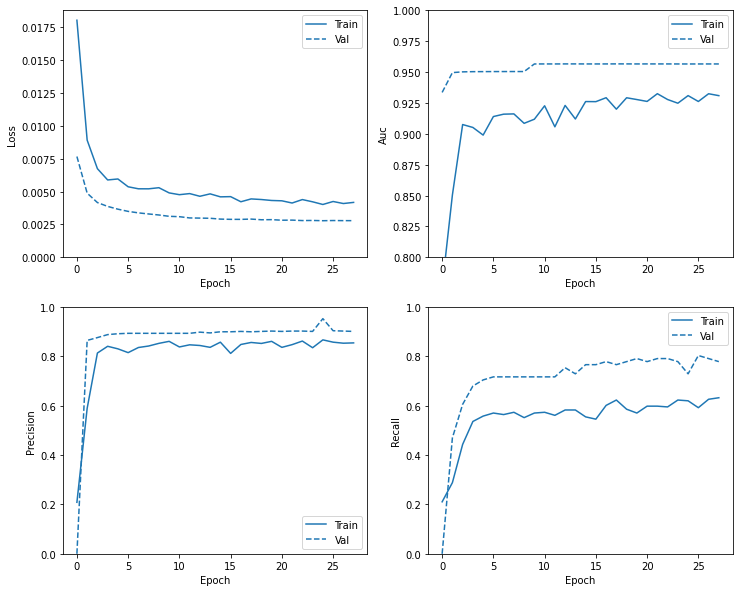

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.0022254730574786663
tp :  72.0
fp :  9.0
tn :  56865.0
fn :  16.0
accuracy :  0.9995611310005188
precision :  0.8888888955116272
recall :  0.8181818127632141
auc :  0.954325258731842

Legitimate Transactions Detected (True Negatives):  56865
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  72
Total Fraudulent Transactions:  88


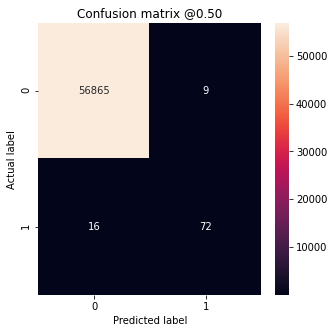

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

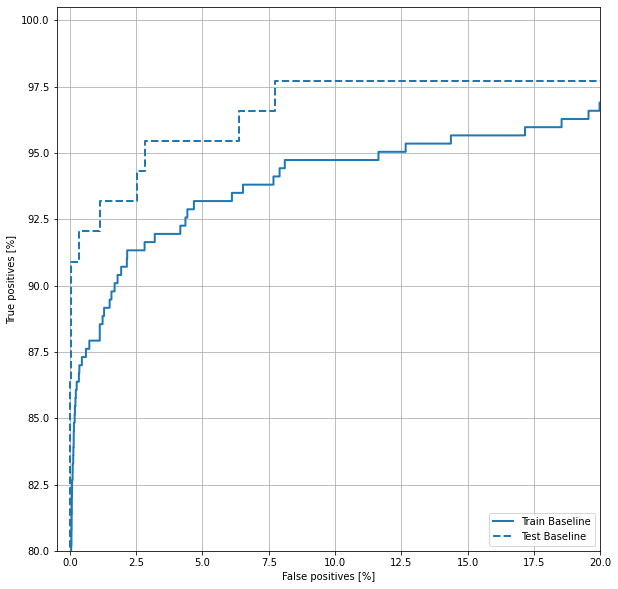

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 0s - loss: 1.6656 - tp: 72.0000 - fp: 25.0000 - tn: 58895.0000 - fn: 18.0000 - accuracy: 0.9993 - precision: 0.7423 - recall: 0.8000 - auc: 0.9489

12/90 [===>..........................] - ETA: 0s - loss: 2.2965 - tp: 77.0000 - fp: 131.0000 - tn: 81280.0000 - fn: 50.0000 - accuracy: 0.9978 - precision: 0.3702 - recall: 0.6063 - auc: 0.8703

24/90 [=======>......................] - ETA: 0s - loss: 2.8366 - tp: 79.0000 - fp: 264.0000 - tn: 105670.0000 - fn: 101.0000 - accuracy: 0.9966 - precision: 0.2303 - recall: 0.4389 - auc: 0.8115

36/90 [===========>..................] - ETA: 0s - loss: 2.6536 - tp: 85.0000 - fp: 406.0000 - tn: 130056.0000 - fn: 143.0000 - accuracy: 0.9958 - precision: 0.1731 - recall: 0.3728 - auc: 0.7992

47/90 [==============>...............] - ETA: 0s - loss: 2.4298 - tp: 93.0000 - fp: 529.0000 - tn: 152424.0000 - fn: 172.0000 - accuracy: 0.9954 - precision: 0.1495 - recall: 0.3509 - auc: 0.7901

59/90 [==================>...........] - ETA: 0s - loss: 2.2582 - tp: 108.0000 - fp: 704.0000 - tn: 176780.0000 - fn: 202.0000 - accuracy: 0.9949 - precision: 0.1330 - recall: 0.3484 - auc: 0.7918

70/90 [======================>.......] - ETA: 0s - loss: 2.0592 - tp: 125.0000 - fp: 868.0000 - tn: 199105.0000 - fn: 224.0000 - accuracy: 0.9945 - precision: 0.1259 - recall: 0.3582 - auc: 0.7994

81/90 [==========================>...] - ETA: 0s - loss: 1.9176 - tp: 148.0000 - fp: 1038.0000 - tn: 221422.0000 - fn: 242.0000 - accuracy: 0.9943 - precision: 0.1248 - recall: 0.3795 - auc: 0.8059

90/90 [==============================] - 1s 13ms/step - loss: 1.8005 - tp: 161.0000 - fp: 1170.0000 - tn: 237657.0000 - fn: 250.0000 - accuracy: 0.9941 - precision: 0.1210 - recall: 0.3917 - auc: 0.8086 - val_loss: 0.0214 - val_tp: 57.0000 - val_fp: 180.0000 - val_tn: 45308.0000 - val_fn: 24.0000 - val_accuracy: 0.9955 - val_precision: 0.2405 - val_recall: 0.7037 - val_auc: 0.9622


Epoch 2/100
 1/90 [..............................] - ETA: 0s - loss: 0.9480 - tp: 0.0000e+00 - fp: 17.0000 - tn: 2030.0000 - fn: 1.0000 - accuracy: 0.9912 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.2645

13/90 [===>..........................] - ETA: 0s - loss: 0.7721 - tp: 14.0000 - fp: 220.0000 - tn: 26370.0000 - fn: 20.0000 - accuracy: 0.9910 - precision: 0.0598 - recall: 0.4118 - auc: 0.8518        

25/90 [=======>......................] - ETA: 0s - loss: 0.5741 - tp: 31.0000 - fp: 422.0000 - tn: 50719.0000 - fn: 28.0000 - accuracy: 0.9912 - precision: 0.0684 - recall: 0.5254 - auc: 0.8801

36/90 [===========>..................] - ETA: 0s - loss: 0.7076 - tp: 46.0000 - fp: 625.0000 - tn: 73010.0000 - fn: 47.0000 - accuracy: 0.9909 - precision: 0.0686 - recall: 0.4946 - auc: 0.8503

47/90 [==============>...............] - ETA: 0s - loss: 0.7021 - tp: 74.0000 - fp: 851.0000 - tn: 95267.0000 - fn: 64.0000 - accuracy: 0.9905 - precision: 0.0800 - recall: 0.5362 - auc: 0.8768

58/90 [==================>...........] - ETA: 0s - loss: 0.7645 - tp: 105.0000 - fp: 1078.0000 - tn: 117518.0000 - fn: 83.0000 - accuracy: 0.9902 - precision: 0.0888 - recall: 0.5585 - auc: 0.8820

70/90 [======================>.......] - ETA: 0s - loss: 0.7550 - tp: 143.0000 - fp: 1338.0000 - tn: 141782.0000 - fn: 97.0000 - accuracy: 0.9900 - precision: 0.0966 - recall: 0.5958 - auc: 0.8894

82/90 [==========================>...] - ETA: 0s - loss: 0.7244 - tp: 178.0000 - fp: 1648.0000 - tn: 166000.0000 - fn: 110.0000 - accuracy: 0.9895 - precision: 0.0975 - recall: 0.6181 - auc: 0.8985

90/90 [==============================] - 1s 6ms/step - loss: 0.7343 - tp: 201.0000 - fp: 1841.0000 - tn: 180112.0000 - fn: 122.0000 - accuracy: 0.9892 - precision: 0.0984 - recall: 0.6223 - auc: 0.8987 - val_loss: 0.0294 - val_tp: 67.0000 - val_fp: 258.0000 - val_tn: 45230.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.2062 - val_recall: 0.8272 - val_auc: 0.9694


Epoch 3/100
 1/90 [..............................] - ETA: 0s - loss: 0.8993 - tp: 4.0000 - fp: 23.0000 - tn: 2019.0000 - fn: 2.0000 - accuracy: 0.9878 - precision: 0.1481 - recall: 0.6667 - auc: 0.9553

13/90 [===>..........................] - ETA: 0s - loss: 0.4350 - tp: 35.0000 - fp: 343.0000 - tn: 26236.0000 - fn: 10.0000 - accuracy: 0.9867 - precision: 0.0926 - recall: 0.7778 - auc: 0.9482

25/90 [=======>......................] - ETA: 0s - loss: 0.6160 - tp: 62.0000 - fp: 697.0000 - tn: 50413.0000 - fn: 28.0000 - accuracy: 0.9858 - precision: 0.0817 - recall: 0.6889 - auc: 0.9069

37/90 [===========>..................] - ETA: 0s - loss: 0.5199 - tp: 88.0000 - fp: 1036.0000 - tn: 74614.0000 - fn: 38.0000 - accuracy: 0.9858 - precision: 0.0783 - recall: 0.6984 - auc: 0.9218

48/90 [===============>..............] - ETA: 0s - loss: 0.5223 - tp: 119.0000 - fp: 1335.0000 - tn: 96802.0000 - fn: 48.0000 - accuracy: 0.9859 - precision: 0.0818 - recall: 0.7126 - auc: 0.9183

60/90 [===================>..........] - ETA: 0s - loss: 0.5039 - tp: 156.0000 - fp: 1740.0000 - tn: 120926.0000 - fn: 58.0000 - accuracy: 0.9854 - precision: 0.0823 - recall: 0.7290 - auc: 0.9279

71/90 [======================>.......] - ETA: 0s - loss: 0.4943 - tp: 184.0000 - fp: 2110.0000 - tn: 143044.0000 - fn: 70.0000 - accuracy: 0.9850 - precision: 0.0802 - recall: 0.7244 - auc: 0.9327

83/90 [==========================>...] - ETA: 0s - loss: 0.4780 - tp: 222.0000 - fp: 2525.0000 - tn: 167159.0000 - fn: 78.0000 - accuracy: 0.9847 - precision: 0.0808 - recall: 0.7400 - auc: 0.9345

90/90 [==============================] - 1s 6ms/step - loss: 0.4879 - tp: 239.0000 - fp: 2753.0000 - tn: 179200.0000 - fn: 84.0000 - accuracy: 0.9844 - precision: 0.0799 - recall: 0.7399 - auc: 0.9322 - val_loss: 0.0388 - val_tp: 69.0000 - val_fp: 354.0000 - val_tn: 45134.0000 - val_fn: 12.0000 - val_accuracy: 0.9920 - val_precision: 0.1631 - val_recall: 0.8519 - val_auc: 0.9740


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 1.6865 - tp: 5.0000 - fp: 35.0000 - tn: 2006.0000 - fn: 2.0000 - accuracy: 0.9819 - precision: 0.1250 - recall: 0.7143 - auc: 0.7690

13/90 [===>..........................] - ETA: 0s - loss: 0.4462 - tp: 39.0000 - fp: 481.0000 - tn: 26094.0000 - fn: 10.0000 - accuracy: 0.9816 - precision: 0.0750 - recall: 0.7959 - auc: 0.9232

25/90 [=======>......................] - ETA: 0s - loss: 0.3534 - tp: 68.0000 - fp: 988.0000 - tn: 50128.0000 - fn: 16.0000 - accuracy: 0.9804 - precision: 0.0644 - recall: 0.8095 - auc: 0.9335

37/90 [===========>..................] - ETA: 0s - loss: 0.3892 - tp: 98.0000 - fp: 1471.0000 - tn: 74181.0000 - fn: 26.0000 - accuracy: 0.9802 - precision: 0.0625 - recall: 0.7903 - auc: 0.9302

49/90 [===============>..............] - ETA: 0s - loss: 0.4215 - tp: 125.0000 - fp: 1916.0000 - tn: 98273.0000 - fn: 38.0000 - accuracy: 0.9805 - precision: 0.0612 - recall: 0.7669 - auc: 0.9285

61/90 [===================>..........] - ETA: 0s - loss: 0.4961 - tp: 164.0000 - fp: 2438.0000 - tn: 122269.0000 - fn: 57.0000 - accuracy: 0.9800 - precision: 0.0630 - recall: 0.7421 - auc: 0.9155

72/90 [=======================>......] - ETA: 0s - loss: 0.4799 - tp: 202.0000 - fp: 2922.0000 - tn: 144268.0000 - fn: 64.0000 - accuracy: 0.9797 - precision: 0.0647 - recall: 0.7594 - auc: 0.9200

83/90 [==========================>...] - ETA: 0s - loss: 0.4839 - tp: 227.0000 - fp: 3454.0000 - tn: 166229.0000 - fn: 74.0000 - accuracy: 0.9792 - precision: 0.0617 - recall: 0.7542 - auc: 0.9163

90/90 [==============================] - 1s 6ms/step - loss: 0.4625 - tp: 247.0000 - fp: 3728.0000 - tn: 178225.0000 - fn: 76.0000 - accuracy: 0.9791 - precision: 0.0621 - recall: 0.7647 - auc: 0.9211 - val_loss: 0.0476 - val_tp: 71.0000 - val_fp: 440.0000 - val_tn: 45048.0000 - val_fn: 10.0000 - val_accuracy: 0.9901 - val_precision: 0.1389 - val_recall: 0.8765 - val_auc: 0.9739


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.8840 - tp: 2.0000 - fp: 45.0000 - tn: 2000.0000 - fn: 1.0000 - accuracy: 0.9775 - precision: 0.0426 - recall: 0.6667 - auc: 0.7233

12/90 [===>..........................] - ETA: 0s - loss: 0.4326 - tp: 34.0000 - fp: 584.0000 - tn: 23952.0000 - fn: 6.0000 - accuracy: 0.9760 - precision: 0.0550 - recall: 0.8500 - auc: 0.9145

24/90 [=======>......................] - ETA: 0s - loss: 0.3780 - tp: 71.0000 - fp: 1171.0000 - tn: 47896.0000 - fn: 14.0000 - accuracy: 0.9759 - precision: 0.0572 - recall: 0.8353 - auc: 0.9430

36/90 [===========>..................] - ETA: 0s - loss: 0.3760 - tp: 92.0000 - fp: 1761.0000 - tn: 71854.0000 - fn: 21.0000 - accuracy: 0.9758 - precision: 0.0496 - recall: 0.8142 - auc: 0.9336

48/90 [===============>..............] - ETA: 0s - loss: 0.4036 - tp: 131.0000 - fp: 2398.0000 - tn: 95745.0000 - fn: 30.0000 - accuracy: 0.9753 - precision: 0.0518 - recall: 0.8137 - auc: 0.9278

59/90 [==================>...........] - ETA: 0s - loss: 0.3946 - tp: 168.0000 - fp: 2976.0000 - tn: 117650.0000 - fn: 38.0000 - accuracy: 0.9751 - precision: 0.0534 - recall: 0.8155 - auc: 0.9341

70/90 [======================>.......] - ETA: 0s - loss: 0.3700 - tp: 209.0000 - fp: 3566.0000 - tn: 139543.0000 - fn: 42.0000 - accuracy: 0.9748 - precision: 0.0554 - recall: 0.8327 - auc: 0.9407

82/90 [==========================>...] - ETA: 0s - loss: 0.4107 - tp: 241.0000 - fp: 4220.0000 - tn: 163421.0000 - fn: 54.0000 - accuracy: 0.9745 - precision: 0.0540 - recall: 0.8169 - auc: 0.9316

90/90 [==============================] - 1s 6ms/step - loss: 0.4086 - tp: 265.0000 - fp: 4625.0000 - tn: 177328.0000 - fn: 58.0000 - accuracy: 0.9743 - precision: 0.0542 - recall: 0.8204 - auc: 0.9323 - val_loss: 0.0548 - val_tp: 72.0000 - val_fp: 540.0000 - val_tn: 44948.0000 - val_fn: 9.0000 - val_accuracy: 0.9880 - val_precision: 0.1176 - val_recall: 0.8889 - val_auc: 0.9737


Epoch 6/100
 1/90 [..............................] - ETA: 0s - loss: 0.0653 - tp: 7.0000 - fp: 46.0000 - tn: 1995.0000 - fn: 0.0000e+00 - accuracy: 0.9775 - precision: 0.1321 - recall: 1.0000 - auc: 0.9973

12/90 [===>..........................] - ETA: 0s - loss: 0.4675 - tp: 35.0000 - fp: 637.0000 - tn: 23892.0000 - fn: 12.0000 - accuracy: 0.9736 - precision: 0.0521 - recall: 0.7447 - auc: 0.9361

23/90 [======>.......................] - ETA: 0s - loss: 0.3588 - tp: 79.0000 - fp: 1295.0000 - tn: 45715.0000 - fn: 15.0000 - accuracy: 0.9722 - precision: 0.0575 - recall: 0.8404 - auc: 0.9526

34/90 [==========>...................] - ETA: 0s - loss: 0.3756 - tp: 114.0000 - fp: 1974.0000 - tn: 67519.0000 - fn: 25.0000 - accuracy: 0.9713 - precision: 0.0546 - recall: 0.8201 - auc: 0.9521

45/90 [==============>...............] - ETA: 0s - loss: 0.3683 - tp: 132.0000 - fp: 2743.0000 - tn: 89254.0000 - fn: 31.0000 - accuracy: 0.9699 - precision: 0.0459 - recall: 0.8098 - auc: 0.9450

57/90 [==================>...........] - ETA: 0s - loss: 0.4036 - tp: 166.0000 - fp: 3478.0000 - tn: 113049.0000 - fn: 43.0000 - accuracy: 0.9698 - precision: 0.0456 - recall: 0.7943 - auc: 0.9382

68/90 [=====================>........] - ETA: 0s - loss: 0.3677 - tp: 204.0000 - fp: 4217.0000 - tn: 134796.0000 - fn: 47.0000 - accuracy: 0.9694 - precision: 0.0461 - recall: 0.8127 - auc: 0.9454

80/90 [=========================>....] - ETA: 0s - loss: 0.3664 - tp: 239.0000 - fp: 5000.0000 - tn: 158548.0000 - fn: 53.0000 - accuracy: 0.9692 - precision: 0.0456 - recall: 0.8185 - auc: 0.9439

90/90 [==============================] - 1s 6ms/step - loss: 0.3618 - tp: 265.0000 - fp: 5593.0000 - tn: 176360.0000 - fn: 58.0000 - accuracy: 0.9690 - precision: 0.0452 - recall: 0.8204 - auc: 0.9444 - val_loss: 0.0654 - val_tp: 74.0000 - val_fp: 672.0000 - val_tn: 44816.0000 - val_fn: 7.0000 - val_accuracy: 0.9851 - val_precision: 0.0992 - val_recall: 0.9136 - val_auc: 0.9728


Epoch 7/100
 1/90 [..............................] - ETA: 0s - loss: 0.0670 - tp: 2.0000 - fp: 67.0000 - tn: 1979.0000 - fn: 0.0000e+00 - accuracy: 0.9673 - precision: 0.0290 - recall: 1.0000 - auc: 0.9978

13/90 [===>..........................] - ETA: 0s - loss: 0.3048 - tp: 46.0000 - fp: 885.0000 - tn: 25686.0000 - fn: 7.0000 - accuracy: 0.9665 - precision: 0.0494 - recall: 0.8679 - auc: 0.9568 

25/90 [=======>......................] - ETA: 0s - loss: 0.5249 - tp: 75.0000 - fp: 1708.0000 - tn: 49396.0000 - fn: 21.0000 - accuracy: 0.9662 - precision: 0.0421 - recall: 0.7812 - auc: 0.9104

36/90 [===========>..................] - ETA: 0s - loss: 0.4612 - tp: 106.0000 - fp: 2479.0000 - tn: 71115.0000 - fn: 28.0000 - accuracy: 0.9660 - precision: 0.0410 - recall: 0.7910 - auc: 0.9201

48/90 [===============>..............] - ETA: 0s - loss: 0.4068 - tp: 146.0000 - fp: 3311.0000 - tn: 94815.0000 - fn: 32.0000 - accuracy: 0.9660 - precision: 0.0422 - recall: 0.8202 - auc: 0.9309

59/90 [==================>...........] - ETA: 0s - loss: 0.4006 - tp: 176.0000 - fp: 4114.0000 - tn: 116502.0000 - fn: 40.0000 - accuracy: 0.9656 - precision: 0.0410 - recall: 0.8148 - auc: 0.9325

70/90 [======================>.......] - ETA: 0s - loss: 0.3711 - tp: 213.0000 - fp: 4953.0000 - tn: 138150.0000 - fn: 44.0000 - accuracy: 0.9651 - precision: 0.0412 - recall: 0.8288 - auc: 0.9393

81/90 [==========================>...] - ETA: 0s - loss: 0.3641 - tp: 247.0000 - fp: 5764.0000 - tn: 159827.0000 - fn: 50.0000 - accuracy: 0.9650 - precision: 0.0411 - recall: 0.8316 - auc: 0.9412

90/90 [==============================] - 1s 6ms/step - loss: 0.3688 - tp: 268.0000 - fp: 6298.0000 - tn: 175655.0000 - fn: 55.0000 - accuracy: 0.9651 - precision: 0.0408 - recall: 0.8297 - auc: 0.9393 - val_loss: 0.0718 - val_tp: 74.0000 - val_fp: 791.0000 - val_tn: 44697.0000 - val_fn: 7.0000 - val_accuracy: 0.9825 - val_precision: 0.0855 - val_recall: 0.9136 - val_auc: 0.9732


Epoch 8/100
 1/90 [..............................] - ETA: 0s - loss: 0.2503 - tp: 1.0000 - fp: 80.0000 - tn: 1966.0000 - fn: 1.0000 - accuracy: 0.9604 - precision: 0.0123 - recall: 0.5000 - auc: 0.9641

13/90 [===>..........................] - ETA: 0s - loss: 0.2844 - tp: 45.0000 - fp: 951.0000 - tn: 25620.0000 - fn: 8.0000 - accuracy: 0.9640 - precision: 0.0452 - recall: 0.8491 - auc: 0.9690

24/90 [=======>......................] - ETA: 0s - loss: 0.3123 - tp: 73.0000 - fp: 1762.0000 - tn: 47303.0000 - fn: 14.0000 - accuracy: 0.9639 - precision: 0.0398 - recall: 0.8391 - auc: 0.9586

35/90 [==========>...................] - ETA: 0s - loss: 0.3057 - tp: 110.0000 - fp: 2592.0000 - tn: 68958.0000 - fn: 20.0000 - accuracy: 0.9636 - precision: 0.0407 - recall: 0.8462 - auc: 0.9589

46/90 [==============>...............] - ETA: 0s - loss: 0.3218 - tp: 146.0000 - fp: 3415.0000 - tn: 90619.0000 - fn: 28.0000 - accuracy: 0.9635 - precision: 0.0410 - recall: 0.8391 - auc: 0.9528

57/90 [==================>...........] - ETA: 0s - loss: 0.3110 - tp: 182.0000 - fp: 4292.0000 - tn: 112230.0000 - fn: 32.0000 - accuracy: 0.9630 - precision: 0.0407 - recall: 0.8505 - auc: 0.9544

68/90 [=====================>........] - ETA: 0s - loss: 0.2968 - tp: 210.0000 - fp: 5179.0000 - tn: 133838.0000 - fn: 37.0000 - accuracy: 0.9625 - precision: 0.0390 - recall: 0.8502 - auc: 0.9565

79/90 [=========================>....] - ETA: 0s - loss: 0.3188 - tp: 239.0000 - fp: 6067.0000 - tn: 155440.0000 - fn: 46.0000 - accuracy: 0.9622 - precision: 0.0379 - recall: 0.8386 - auc: 0.9506

90/90 [==============================] - ETA: 0s - loss: 0.3438 - tp: 267.0000 - fp: 6826.0000 - tn: 175127.0000 - fn: 56.0000 - accuracy: 0.9622 - precision: 0.0376 - recall: 0.8266 - auc: 0.9455

90/90 [==============================] - 1s 6ms/step - loss: 0.3438 - tp: 267.0000 - fp: 6826.0000 - tn: 175127.0000 - fn: 56.0000 - accuracy: 0.9622 - precision: 0.0376 - recall: 0.8266 - auc: 0.9455 - val_loss: 0.0788 - val_tp: 74.0000 - val_fp: 912.0000 - val_tn: 44576.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0751 - val_recall: 0.9136 - val_auc: 0.9710


Epoch 9/100
 1/90 [..............................] - ETA: 0s - loss: 0.0673 - tp: 2.0000 - fp: 81.0000 - tn: 1965.0000 - fn: 0.0000e+00 - accuracy: 0.9604 - precision: 0.0241 - recall: 1.0000 - auc: 0.9985

13/90 [===>..........................] - ETA: 0s - loss: 0.3542 - tp: 34.0000 - fp: 1067.0000 - tn: 25516.0000 - fn: 7.0000 - accuracy: 0.9597 - precision: 0.0309 - recall: 0.8293 - auc: 0.9307

24/90 [=======>......................] - ETA: 0s - loss: 0.2745 - tp: 73.0000 - fp: 2031.0000 - tn: 47039.0000 - fn: 9.0000 - accuracy: 0.9585 - precision: 0.0347 - recall: 0.8902 - auc: 0.9521

35/90 [==========>...................] - ETA: 0s - loss: 0.2525 - tp: 105.0000 - fp: 2927.0000 - tn: 68635.0000 - fn: 13.0000 - accuracy: 0.9590 - precision: 0.0346 - recall: 0.8898 - auc: 0.9593

46/90 [==============>...............] - ETA: 0s - loss: 0.2669 - tp: 145.0000 - fp: 3847.0000 - tn: 90196.0000 - fn: 20.0000 - accuracy: 0.9590 - precision: 0.0363 - recall: 0.8788 - auc: 0.9589

57/90 [==================>...........] - ETA: 0s - loss: 0.3184 - tp: 171.0000 - fp: 4776.0000 - tn: 111761.0000 - fn: 28.0000 - accuracy: 0.9588 - precision: 0.0346 - recall: 0.8593 - auc: 0.9446

68/90 [=====================>........] - ETA: 0s - loss: 0.3176 - tp: 207.0000 - fp: 5665.0000 - tn: 133359.0000 - fn: 33.0000 - accuracy: 0.9591 - precision: 0.0353 - recall: 0.8625 - auc: 0.9451

79/90 [=========================>....] - ETA: 0s - loss: 0.3122 - tp: 242.0000 - fp: 6558.0000 - tn: 154955.0000 - fn: 37.0000 - accuracy: 0.9592 - precision: 0.0356 - recall: 0.8674 - auc: 0.9463

90/90 [==============================] - ETA: 0s - loss: 0.3148 - tp: 279.0000 - fp: 7355.0000 - tn: 174598.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.0365 - recall: 0.8638 - auc: 0.9472

90/90 [==============================] - 1s 6ms/step - loss: 0.3148 - tp: 279.0000 - fp: 7355.0000 - tn: 174598.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.0365 - recall: 0.8638 - auc: 0.9472 - val_loss: 0.0816 - val_tp: 74.0000 - val_fp: 955.0000 - val_tn: 44533.0000 - val_fn: 7.0000 - val_accuracy: 0.9789 - val_precision: 0.0719 - val_recall: 0.9136 - val_auc: 0.9710


Epoch 10/100
 1/90 [..............................] - ETA: 0s - loss: 0.2738 - tp: 4.0000 - fp: 74.0000 - tn: 1969.0000 - fn: 1.0000 - accuracy: 0.9634 - precision: 0.0513 - recall: 0.8000 - auc: 0.9842

12/90 [===>..........................] - ETA: 0s - loss: 0.2397 - tp: 46.0000 - fp: 971.0000 - tn: 23554.0000 - fn: 5.0000 - accuracy: 0.9603 - precision: 0.0452 - recall: 0.9020 - auc: 0.9746

23/90 [======>.......................] - ETA: 0s - loss: 0.3114 - tp: 83.0000 - fp: 1848.0000 - tn: 45162.0000 - fn: 11.0000 - accuracy: 0.9605 - precision: 0.0430 - recall: 0.8830 - auc: 0.9552

34/90 [==========>...................] - ETA: 0s - loss: 0.2956 - tp: 120.0000 - fp: 2716.0000 - tn: 66780.0000 - fn: 16.0000 - accuracy: 0.9608 - precision: 0.0423 - recall: 0.8824 - auc: 0.9590

45/90 [==============>...............] - ETA: 0s - loss: 0.3299 - tp: 157.0000 - fp: 3690.0000 - tn: 88289.0000 - fn: 24.0000 - accuracy: 0.9597 - precision: 0.0408 - recall: 0.8674 - auc: 0.9528

56/90 [=================>............] - ETA: 0s - loss: 0.2958 - tp: 192.0000 - fp: 4633.0000 - tn: 109837.0000 - fn: 26.0000 - accuracy: 0.9594 - precision: 0.0398 - recall: 0.8807 - auc: 0.9577

67/90 [=====================>........] - ETA: 0s - loss: 0.2742 - tp: 221.0000 - fp: 5613.0000 - tn: 131352.0000 - fn: 30.0000 - accuracy: 0.9589 - precision: 0.0379 - recall: 0.8805 - auc: 0.9612

78/90 [=========================>....] - ETA: 0s - loss: 0.2660 - tp: 256.0000 - fp: 6605.0000 - tn: 152851.0000 - fn: 32.0000 - accuracy: 0.9585 - precision: 0.0373 - recall: 0.8889 - auc: 0.9613

89/90 [============================>.] - ETA: 0s - loss: 0.2727 - tp: 285.0000 - fp: 7495.0000 - tn: 174454.0000 - fn: 38.0000 - accuracy: 0.9587 - precision: 0.0366 - recall: 0.8824 - auc: 0.9583

90/90 [==============================] - 1s 6ms/step - loss: 0.2727 - tp: 285.0000 - fp: 7495.0000 - tn: 174458.0000 - fn: 38.0000 - accuracy: 0.9587 - precision: 0.0366 - recall: 0.8824 - auc: 0.9583 - val_loss: 0.0838 - val_tp: 74.0000 - val_fp: 982.0000 - val_tn: 44506.0000 - val_fn: 7.0000 - val_accuracy: 0.9783 - val_precision: 0.0701 - val_recall: 0.9136 - val_auc: 0.9693


Epoch 11/100
 1/90 [..............................] - ETA: 0s - loss: 0.1018 - tp: 2.0000 - fp: 79.0000 - tn: 1967.0000 - fn: 0.0000e+00 - accuracy: 0.9614 - precision: 0.0247 - recall: 1.0000 - auc: 0.9886

12/90 [===>..........................] - ETA: 0s - loss: 0.3548 - tp: 39.0000 - fp: 1008.0000 - tn: 23523.0000 - fn: 6.0000 - accuracy: 0.9587 - precision: 0.0372 - recall: 0.8667 - auc: 0.9369

23/90 [======>.......................] - ETA: 0s - loss: 0.3725 - tp: 77.0000 - fp: 1975.0000 - tn: 45038.0000 - fn: 14.0000 - accuracy: 0.9578 - precision: 0.0375 - recall: 0.8462 - auc: 0.9379

34/90 [==========>...................] - ETA: 0s - loss: 0.2920 - tp: 107.0000 - fp: 2996.0000 - tn: 66513.0000 - fn: 16.0000 - accuracy: 0.9567 - precision: 0.0345 - recall: 0.8699 - auc: 0.9516

45/90 [==============>...............] - ETA: 0s - loss: 0.3028 - tp: 151.0000 - fp: 3976.0000 - tn: 88012.0000 - fn: 21.0000 - accuracy: 0.9566 - precision: 0.0366 - recall: 0.8779 - auc: 0.9528

56/90 [=================>............] - ETA: 0s - loss: 0.3130 - tp: 175.0000 - fp: 4958.0000 - tn: 109528.0000 - fn: 27.0000 - accuracy: 0.9565 - precision: 0.0341 - recall: 0.8663 - auc: 0.9466

67/90 [=====================>........] - ETA: 0s - loss: 0.3188 - tp: 201.0000 - fp: 5952.0000 - tn: 131029.0000 - fn: 34.0000 - accuracy: 0.9564 - precision: 0.0327 - recall: 0.8553 - auc: 0.9455

78/90 [=========================>....] - ETA: 0s - loss: 0.2975 - tp: 239.0000 - fp: 6930.0000 - tn: 152538.0000 - fn: 37.0000 - accuracy: 0.9564 - precision: 0.0333 - recall: 0.8659 - auc: 0.9513

89/90 [============================>.] - ETA: 0s - loss: 0.3058 - tp: 278.0000 - fp: 7825.0000 - tn: 174124.0000 - fn: 45.0000 - accuracy: 0.9568 - precision: 0.0343 - recall: 0.8607 - auc: 0.9521

90/90 [==============================] - 1s 6ms/step - loss: 0.3058 - tp: 278.0000 - fp: 7826.0000 - tn: 174127.0000 - fn: 45.0000 - accuracy: 0.9568 - precision: 0.0343 - recall: 0.8607 - auc: 0.9521 - val_loss: 0.0865 - val_tp: 74.0000 - val_fp: 998.0000 - val_tn: 44490.0000 - val_fn: 7.0000 - val_accuracy: 0.9779 - val_precision: 0.0690 - val_recall: 0.9136 - val_auc: 0.9694


Epoch 12/100
 1/90 [..............................] - ETA: 0s - loss: 0.0707 - tp: 3.0000 - fp: 69.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9663 - precision: 0.0417 - recall: 1.0000 - auc: 0.9980

12/90 [===>..........................] - ETA: 0s - loss: 0.1337 - tp: 37.0000 - fp: 997.0000 - tn: 23540.0000 - fn: 2.0000 - accuracy: 0.9594 - precision: 0.0358 - recall: 0.9487 - auc: 0.9893 

23/90 [======>.......................] - ETA: 0s - loss: 0.1961 - tp: 70.0000 - fp: 1965.0000 - tn: 45060.0000 - fn: 9.0000 - accuracy: 0.9581 - precision: 0.0344 - recall: 0.8861 - auc: 0.9798

35/90 [==========>...................] - ETA: 0s - loss: 0.2306 - tp: 106.0000 - fp: 3002.0000 - tn: 68558.0000 - fn: 14.0000 - accuracy: 0.9579 - precision: 0.0341 - recall: 0.8833 - auc: 0.9675

47/90 [==============>...............] - ETA: 0s - loss: 0.2203 - tp: 139.0000 - fp: 4092.0000 - tn: 92009.0000 - fn: 16.0000 - accuracy: 0.9573 - precision: 0.0329 - recall: 0.8968 - auc: 0.9684

58/90 [==================>...........] - ETA: 0s - loss: 0.2322 - tp: 183.0000 - fp: 5036.0000 - tn: 113541.0000 - fn: 24.0000 - accuracy: 0.9574 - precision: 0.0351 - recall: 0.8841 - auc: 0.9702

69/90 [======================>.......] - ETA: 0s - loss: 0.2278 - tp: 220.0000 - fp: 5969.0000 - tn: 135095.0000 - fn: 28.0000 - accuracy: 0.9576 - precision: 0.0355 - recall: 0.8871 - auc: 0.9708

80/90 [=========================>....] - ETA: 0s - loss: 0.2366 - tp: 259.0000 - fp: 6933.0000 - tn: 156616.0000 - fn: 32.0000 - accuracy: 0.9575 - precision: 0.0360 - recall: 0.8900 - auc: 0.9680

90/90 [==============================] - 1s 6ms/step - loss: 0.2583 - tp: 284.0000 - fp: 7745.0000 - tn: 174208.0000 - fn: 39.0000 - accuracy: 0.9573 - precision: 0.0354 - recall: 0.8793 - auc: 0.9640 - val_loss: 0.0881 - val_tp: 74.0000 - val_fp: 1023.0000 - val_tn: 44465.0000 - val_fn: 7.0000 - val_accuracy: 0.9774 - val_precision: 0.0675 - val_recall: 0.9136 - val_auc: 0.9688


Epoch 13/100
 1/90 [..............................] - ETA: 0s - loss: 0.2674 - tp: 6.0000 - fp: 80.0000 - tn: 1961.0000 - fn: 1.0000 - accuracy: 0.9604 - precision: 0.0698 - recall: 0.8571 - auc: 0.9874

12/90 [===>..........................] - ETA: 0s - loss: 0.2251 - tp: 44.0000 - fp: 1035.0000 - tn: 23492.0000 - fn: 5.0000 - accuracy: 0.9577 - precision: 0.0408 - recall: 0.8980 - auc: 0.9729

23/90 [======>.......................] - ETA: 0s - loss: 0.2969 - tp: 80.0000 - fp: 2026.0000 - tn: 44985.0000 - fn: 13.0000 - accuracy: 0.9567 - precision: 0.0380 - recall: 0.8602 - auc: 0.9613

34/90 [==========>...................] - ETA: 0s - loss: 0.2590 - tp: 117.0000 - fp: 2986.0000 - tn: 66512.0000 - fn: 17.0000 - accuracy: 0.9569 - precision: 0.0377 - recall: 0.8731 - auc: 0.9659

45/90 [==============>...............] - ETA: 0s - loss: 0.2382 - tp: 150.0000 - fp: 3988.0000 - tn: 88001.0000 - fn: 21.0000 - accuracy: 0.9565 - precision: 0.0362 - recall: 0.8772 - auc: 0.9701

56/90 [=================>............] - ETA: 0s - loss: 0.2474 - tp: 190.0000 - fp: 4968.0000 - tn: 109503.0000 - fn: 27.0000 - accuracy: 0.9564 - precision: 0.0368 - recall: 0.8756 - auc: 0.9680

67/90 [=====================>........] - ETA: 0s - loss: 0.2439 - tp: 219.0000 - fp: 5997.0000 - tn: 130970.0000 - fn: 30.0000 - accuracy: 0.9561 - precision: 0.0352 - recall: 0.8795 - auc: 0.9663

78/90 [=========================>....] - ETA: 0s - loss: 0.2747 - tp: 255.0000 - fp: 7010.0000 - tn: 152441.0000 - fn: 38.0000 - accuracy: 0.9559 - precision: 0.0351 - recall: 0.8703 - auc: 0.9594

89/90 [============================>.] - ETA: 0s - loss: 0.2765 - tp: 280.0000 - fp: 8050.0000 - tn: 173899.0000 - fn: 43.0000 - accuracy: 0.9556 - precision: 0.0336 - recall: 0.8669 - auc: 0.9577

Restoring model weights from the end of the best epoch.
90/90 [==============================] - 1s 6ms/step - loss: 0.2765 - tp: 280.0000 - fp: 8050.0000 - tn: 173903.0000 - fn: 43.0000 - accuracy: 0.9556 - precision: 0.0336 - recall: 0.8669 - auc: 0.9577 - val_loss: 0.0895 - val_tp: 74.0000 - val_fp: 1025.0000 - val_tn: 44463.0000 - val_fn: 7.0000 - val_accuracy: 0.9774 - val_precision: 0.0673 - val_recall: 0.9136 - val_auc: 0.9667


Epoch 00013: early stopping


### Check training history

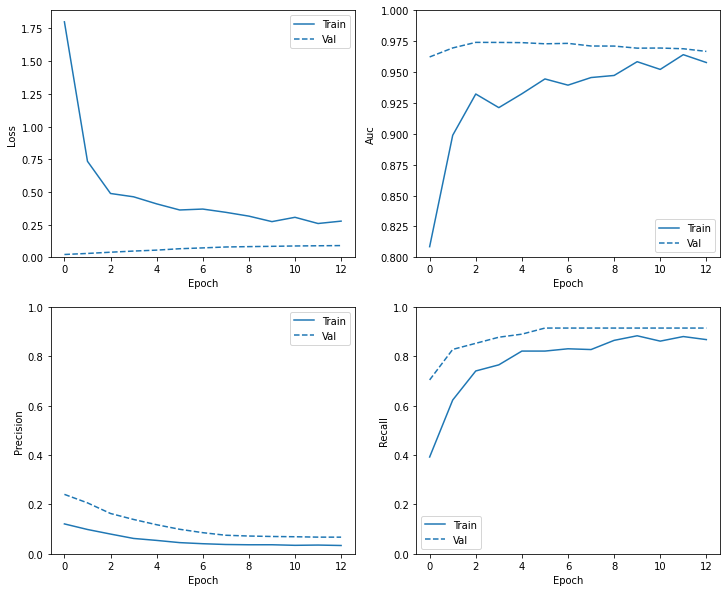

In [34]:
plot_metrics(weighted_history)

### Evaluate metrics

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.03673461452126503
tp :  77.0
fp :  408.0
tn :  56466.0
fn :  11.0
accuracy :  0.992644190788269
precision :  0.1587628871202469
recall :  0.875
auc :  0.9694361686706543

Legitimate Transactions Detected (True Negatives):  56466
Legitimate Transactions Incorrectly Detected (False Positives):  408
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  77
Total Fraudulent Transactions:  88


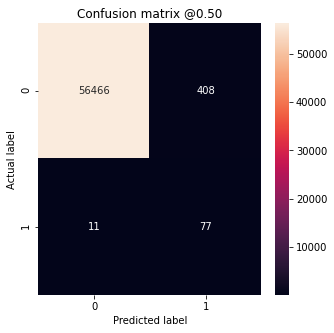

In [36]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

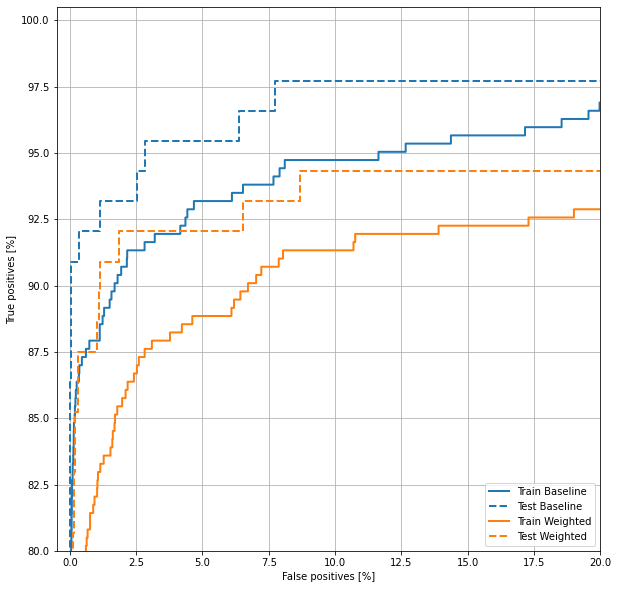

In [37]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [38]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [39]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181953, 29)

In [40]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363906, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [41]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [42]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.04278205e+00  2.00972213e+00 -2.59346703e+00  3.96162248e+00
 -2.24930440e+00 -9.40602521e-01 -4.70147821e+00  1.39978525e+00
 -4.06847795e+00 -5.00000000e+00  3.76549570e+00 -5.00000000e+00
  1.50316118e+00 -5.00000000e+00  8.64022198e-01 -5.00000000e+00
 -5.00000000e+00 -5.00000000e+00  2.96298131e+00  1.42652399e+00
  2.00568311e+00  1.14619550e+00 -2.30721370e-01  1.84304928e-03
 -7.47702385e-02  8.03987830e-01  3.26627629e+00  1.67797758e+00
 -4.50955643e-01]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [43]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [44]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.48828125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [45]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 0s - loss: 1.2639 - tp: 634.0000 - fp: 1136.0000 - tn: 56793.0000 - fn: 447.0000 - accuracy: 0.9732 - precision: 0.3582 - recall: 0.5865 - auc: 0.9220

  5/278 [..............................] - ETA: 3s - loss: 1.1829 - tp: 3054.0000 - fp: 3975.0000 - tn: 58072.0000 - fn: 2101.0000 - accuracy: 0.9096 - precision: 0.4345 - recall: 0.5924 - auc: 0.9092

  9/278 [..............................] - ETA: 3s - loss: 1.1400 - tp: 5622.0000 - fp: 6815.0000 - tn: 59416.0000 - fn: 3541.0000 - accuracy: 0.8626 - precision: 0.4520 - recall: 0.6136 - auc: 0.8909

 13/278 [>.............................] - ETA: 3s - loss: 1.0897 - tp: 8513.0000 - fp: 9539.0000 - tn: 60748.0000 - fn: 4786.0000 - accuracy: 0.8286 - precision: 0.4716 - recall: 0.6401 - auc: 0.8792

 16/278 [>.............................] - ETA: 3s - loss: 1.0536 - tp: 10847.0000 - fp: 11506.0000 - tn: 61804.0000 - fn: 5573.0000 - accuracy: 0.8097 - precision: 0.4853 - recall: 0.6606 - auc: 0.8733

 19/278 [=>............................] - ETA: 3s - loss: 1.0235 - tp: 13174.0000 - fp: 13581.0000 - tn: 62814.0000 - fn: 6305.0000 - accuracy: 0.7926 - precision: 0.4924 - recall: 0.6763 - auc: 0.8675

 23/278 [=>............................] - ETA: 3s - loss: 0.9879 - tp: 16467.0000 - fp: 16298.0000 - tn: 64176.0000 - fn: 7125.0000 - accuracy: 0.7749 - precision: 0.5026 - recall: 0.6980 - auc: 0.8623

 26/278 [=>............................] - ETA: 4s - loss: 0.9643 - tp: 18987.0000 - fp: 18297.0000 - tn: 65267.0000 - fn: 7659.0000 - accuracy: 0.7645 - precision: 0.5093 - recall: 0.7126 - auc: 0.8596

 29/278 [==>...........................] - ETA: 4s - loss: 0.9407 - tp: 21622.0000 - fp: 20208.0000 - tn: 66349.0000 - fn: 8175.0000 - accuracy: 0.7561 - precision: 0.5169 - recall: 0.7256 - auc: 0.8579

 32/278 [==>...........................] - ETA: 4s - loss: 0.9190 - tp: 24279.0000 - fp: 22098.0000 - tn: 67501.0000 - fn: 8620.0000 - accuracy: 0.7492 - precision: 0.5235 - recall: 0.7380 - auc: 0.8568

 35/278 [==>...........................] - ETA: 4s - loss: 0.9012 - tp: 26897.0000 - fp: 24037.0000 - tn: 68622.0000 - fn: 9086.0000 - accuracy: 0.7425 - precision: 0.5281 - recall: 0.7475 - auc: 0.8557

 38/278 [===>..........................] - ETA: 3s - loss: 0.8841 - tp: 29599.0000 - fp: 25923.0000 - tn: 69782.0000 - fn: 9482.0000 - accuracy: 0.7373 - precision: 0.5331 - recall: 0.7574 - auc: 0.8553

 41/278 [===>..........................] - ETA: 3s - loss: 0.8685 - tp: 32282.0000 - fp: 27805.0000 - tn: 70969.0000 - fn: 9874.0000 - accuracy: 0.7326 - precision: 0.5373 - recall: 0.7658 - auc: 0.8549

 44/278 [===>..........................] - ETA: 3s - loss: 0.8532 - tp: 34981.0000 - fp: 29617.0000 - tn: 72210.0000 - fn: 10266.0000 - accuracy: 0.7288 - precision: 0.5415 - recall: 0.7731 - auc: 0.8550

 47/278 [====>.........................] - ETA: 3s - loss: 0.8377 - tp: 37748.0000 - fp: 31337.0000 - tn: 73517.0000 - fn: 10616.0000 - accuracy: 0.7262 - precision: 0.5464 - recall: 0.7805 - auc: 0.8556

 50/278 [====>.........................] - ETA: 3s - loss: 0.8252 - tp: 40447.0000 - fp: 33153.0000 - tn: 74772.0000 - fn: 10990.0000 - accuracy: 0.7230 - precision: 0.5496 - recall: 0.7863 - auc: 0.8559

 53/278 [====>.........................] - ETA: 3s - loss: 0.8133 - tp: 43132.0000 - fp: 34932.0000 - tn: 76108.0000 - fn: 11334.0000 - accuracy: 0.7205 - precision: 0.5525 - recall: 0.7919 - auc: 0.8563

 56/278 [=====>........................] - ETA: 3s - loss: 0.8012 - tp: 45846.0000 - fp: 36695.0000 - tn: 77475.0000 - fn: 11634.0000 - accuracy: 0.7184 - precision: 0.5554 - recall: 0.7976 - auc: 0.8570

 59/278 [=====>........................] - ETA: 3s - loss: 0.7886 - tp: 48639.0000 - fp: 38319.0000 - tn: 78880.0000 - fn: 11956.0000 - accuracy: 0.7172 - precision: 0.5593 - recall: 0.8027 - auc: 0.8580

 62/278 [=====>........................] - ETA: 3s - loss: 0.7775 - tp: 51397.0000 - fp: 39883.0000 - tn: 80408.0000 - fn: 12250.0000 - accuracy: 0.7166 - precision: 0.5631 - recall: 0.8075 - auc: 0.8589

 65/278 [======>.......................] - ETA: 3s - loss: 0.7674 - tp: 54142.0000 - fp: 41482.0000 - tn: 81880.0000 - fn: 12578.0000 - accuracy: 0.7156 - precision: 0.5662 - recall: 0.8115 - auc: 0.8597

 68/278 [======>.......................] - ETA: 3s - loss: 0.7573 - tp: 56877.0000 - fp: 43053.0000 - tn: 83439.0000 - fn: 12857.0000 - accuracy: 0.7151 - precision: 0.5692 - recall: 0.8156 - auc: 0.8608

 71/278 [======>.......................] - ETA: 3s - loss: 0.7480 - tp: 59645.0000 - fp: 44606.0000 - tn: 84977.0000 - fn: 13142.0000 - accuracy: 0.7146 - precision: 0.5721 - recall: 0.8194 - auc: 0.8618

 74/278 [======>.......................] - ETA: 3s - loss: 0.7392 - tp: 62380.0000 - fp: 46129.0000 - tn: 86594.0000 - fn: 13411.0000 - accuracy: 0.7145 - precision: 0.5749 - recall: 0.8231 - auc: 0.8627

 77/278 [=======>......................] - ETA: 3s - loss: 0.7301 - tp: 65128.0000 - fp: 47559.0000 - tn: 88247.0000 - fn: 13724.0000 - accuracy: 0.7145 - precision: 0.5780 - recall: 0.8260 - auc: 0.8638

 80/278 [=======>......................] - ETA: 3s - loss: 0.7218 - tp: 67910.0000 - fp: 49001.0000 - tn: 89905.0000 - fn: 13986.0000 - accuracy: 0.7147 - precision: 0.5809 - recall: 0.8292 - auc: 0.8649

 83/278 [=======>......................] - ETA: 3s - loss: 0.7141 - tp: 70650.0000 - fp: 50400.0000 - tn: 91612.0000 - fn: 14284.0000 - accuracy: 0.7150 - precision: 0.5836 - recall: 0.8318 - auc: 0.8659

 86/278 [========>.....................] - ETA: 3s - loss: 0.7059 - tp: 73375.0000 - fp: 51745.0000 - tn: 93408.0000 - fn: 14562.0000 - accuracy: 0.7155 - precision: 0.5864 - recall: 0.8344 - auc: 0.8670

 89/278 [========>.....................] - ETA: 3s - loss: 0.6980 - tp: 76156.0000 - fp: 53002.0000 - tn: 95232.0000 - fn: 14844.0000 - accuracy: 0.7164 - precision: 0.5896 - recall: 0.8369 - auc: 0.8682

 92/278 [========>.....................] - ETA: 3s - loss: 0.6902 - tp: 78966.0000 - fp: 54243.0000 - tn: 97053.0000 - fn: 15116.0000 - accuracy: 0.7173 - precision: 0.5928 - recall: 0.8393 - auc: 0.8694

 95/278 [=========>....................] - ETA: 3s - loss: 0.6830 - tp: 81758.0000 - fp: 55466.0000 - tn: 98878.0000 - fn: 15420.0000 - accuracy: 0.7182 - precision: 0.5958 - recall: 0.8413 - auc: 0.8705

 98/278 [=========>....................] - ETA: 3s - loss: 0.6760 - tp: 84517.0000 - fp: 56678.0000 - tn: 100783.0000 - fn: 15688.0000 - accuracy: 0.7191 - precision: 0.5986 - recall: 0.8434 - auc: 0.8716

101/278 [=========>....................] - ETA: 3s - loss: 0.6693 - tp: 87311.0000 - fp: 57815.0000 - tn: 102689.0000 - fn: 15995.0000 - accuracy: 0.7202 - precision: 0.6016 - recall: 0.8452 - auc: 0.8726

104/278 [==========>...................] - ETA: 3s - loss: 0.6627 - tp: 90116.0000 - fp: 58935.0000 - tn: 104623.0000 - fn: 16280.0000 - accuracy: 0.7214 - precision: 0.6046 - recall: 0.8470 - auc: 0.8737

107/278 [==========>...................] - ETA: 3s - loss: 0.6562 - tp: 92922.0000 - fp: 60041.0000 - tn: 106581.0000 - fn: 16554.0000 - accuracy: 0.7226 - precision: 0.6075 - recall: 0.8488 - auc: 0.8748

110/278 [==========>...................] - ETA: 2s - loss: 0.6501 - tp: 95682.0000 - fp: 61151.0000 - tn: 108567.0000 - fn: 16842.0000 - accuracy: 0.7237 - precision: 0.6101 - recall: 0.8503 - auc: 0.8759

113/278 [===========>..................] - ETA: 2s - loss: 0.6438 - tp: 98481.0000 - fp: 62152.0000 - tn: 110634.0000 - fn: 17119.0000 - accuracy: 0.7251 - precision: 0.6131 - recall: 0.8519 - auc: 0.8770

116/278 [===========>..................] - ETA: 2s - loss: 0.6379 - tp: 101223.0000 - fp: 63181.0000 - tn: 112744.0000 - fn: 17382.0000 - accuracy: 0.7265 - precision: 0.6157 - recall: 0.8534 - auc: 0.8782

119/278 [===========>..................] - ETA: 2s - loss: 0.6324 - tp: 103965.0000 - fp: 64209.0000 - tn: 114856.0000 - fn: 17644.0000 - accuracy: 0.7278 - precision: 0.6182 - recall: 0.8549 - auc: 0.8792

122/278 [============>.................] - ETA: 2s - loss: 0.6269 - tp: 106755.0000 - fp: 65141.0000 - tn: 116997.0000 - fn: 17925.0000 - accuracy: 0.7293 - precision: 0.6210 - recall: 0.8562 - auc: 0.8802

125/278 [============>.................] - ETA: 2s - loss: 0.6214 - tp: 109540.0000 - fp: 66096.0000 - tn: 119115.0000 - fn: 18211.0000 - accuracy: 0.7306 - precision: 0.6237 - recall: 0.8574 - auc: 0.8812

128/278 [============>.................] - ETA: 2s - loss: 0.6162 - tp: 112293.0000 - fp: 67078.0000 - tn: 121227.0000 - fn: 18508.0000 - accuracy: 0.7318 - precision: 0.6260 - recall: 0.8585 - auc: 0.8821

131/278 [=============>................] - ETA: 2s - loss: 0.6110 - tp: 115060.0000 - fp: 67972.0000 - tn: 123421.0000 - fn: 18797.0000 - accuracy: 0.7332 - precision: 0.6286 - recall: 0.8596 - auc: 0.8831

134/278 [=============>................] - ETA: 2s - loss: 0.6062 - tp: 117882.0000 - fp: 68873.0000 - tn: 125534.0000 - fn: 19105.0000 - accuracy: 0.7345 - precision: 0.6312 - recall: 0.8605 - auc: 0.8840

137/278 [=============>................] - ETA: 2s - loss: 0.6011 - tp: 120741.0000 - fp: 69718.0000 - tn: 127680.0000 - fn: 19399.0000 - accuracy: 0.7360 - precision: 0.6339 - recall: 0.8616 - auc: 0.8850

140/278 [==============>...............] - ETA: 2s - loss: 0.5965 - tp: 123515.0000 - fp: 70601.0000 - tn: 129892.0000 - fn: 19674.0000 - accuracy: 0.7373 - precision: 0.6363 - recall: 0.8626 - auc: 0.8859

143/278 [==============>...............] - ETA: 2s - loss: 0.5918 - tp: 126321.0000 - fp: 71445.0000 - tn: 132106.0000 - fn: 19954.0000 - accuracy: 0.7387 - precision: 0.6387 - recall: 0.8636 - auc: 0.8868

146/278 [==============>...............] - ETA: 2s - loss: 0.5872 - tp: 129073.0000 - fp: 72254.0000 - tn: 134416.0000 - fn: 20227.0000 - accuracy: 0.7402 - precision: 0.6411 - recall: 0.8645 - auc: 0.8878

149/278 [===============>..............] - ETA: 2s - loss: 0.5827 - tp: 131976.0000 - fp: 73032.0000 - tn: 136602.0000 - fn: 20504.0000 - accuracy: 0.7417 - precision: 0.6438 - recall: 0.8655 - auc: 0.8887

152/278 [===============>..............] - ETA: 2s - loss: 0.5783 - tp: 134758.0000 - fp: 73798.0000 - tn: 138906.0000 - fn: 20796.0000 - accuracy: 0.7431 - precision: 0.6461 - recall: 0.8663 - auc: 0.8896

155/278 [===============>..............] - ETA: 2s - loss: 0.5739 - tp: 137554.0000 - fp: 74521.0000 - tn: 141260.0000 - fn: 21067.0000 - accuracy: 0.7447 - precision: 0.6486 - recall: 0.8672 - auc: 0.8905

158/278 [================>.............] - ETA: 2s - loss: 0.5697 - tp: 140346.0000 - fp: 75268.0000 - tn: 143586.0000 - fn: 21346.0000 - accuracy: 0.7461 - precision: 0.6509 - recall: 0.8680 - auc: 0.8914

161/278 [================>.............] - ETA: 2s - loss: 0.5656 - tp: 143166.0000 - fp: 76011.0000 - tn: 145910.0000 - fn: 21603.0000 - accuracy: 0.7476 - precision: 0.6532 - recall: 0.8689 - auc: 0.8923

164/278 [================>.............] - ETA: 2s - loss: 0.5614 - tp: 145959.0000 - fp: 76723.0000 - tn: 148265.0000 - fn: 21887.0000 - accuracy: 0.7490 - precision: 0.6555 - recall: 0.8696 - auc: 0.8932

167/278 [=================>............] - ETA: 2s - loss: 0.5576 - tp: 148664.0000 - fp: 77439.0000 - tn: 150716.0000 - fn: 22159.0000 - accuracy: 0.7504 - precision: 0.6575 - recall: 0.8703 - auc: 0.8940

170/278 [=================>............] - ETA: 1s - loss: 0.5537 - tp: 151460.0000 - fp: 78126.0000 - tn: 153096.0000 - fn: 22440.0000 - accuracy: 0.7518 - precision: 0.6597 - recall: 0.8710 - auc: 0.8948

173/278 [=================>............] - ETA: 1s - loss: 0.5499 - tp: 154254.0000 - fp: 78740.0000 - tn: 155541.0000 - fn: 22731.0000 - accuracy: 0.7533 - precision: 0.6621 - recall: 0.8716 - auc: 0.8956

176/278 [=================>............] - ETA: 1s - loss: 0.5462 - tp: 157100.0000 - fp: 79441.0000 - tn: 157878.0000 - fn: 22991.0000 - accuracy: 0.7546 - precision: 0.6642 - recall: 0.8723 - auc: 0.8964

179/278 [==================>...........] - ETA: 1s - loss: 0.5426 - tp: 159946.0000 - fp: 80059.0000 - tn: 160286.0000 - fn: 23263.0000 - accuracy: 0.7561 - precision: 0.6664 - recall: 0.8730 - auc: 0.8972

182/278 [==================>...........] - ETA: 1s - loss: 0.5390 - tp: 162742.0000 - fp: 80676.0000 - tn: 162770.0000 - fn: 23510.0000 - accuracy: 0.7575 - precision: 0.6686 - recall: 0.8738 - auc: 0.8980

185/278 [==================>...........] - ETA: 1s - loss: 0.5354 - tp: 165568.0000 - fp: 81273.0000 - tn: 165223.0000 - fn: 23778.0000 - accuracy: 0.7590 - precision: 0.6707 - recall: 0.8744 - auc: 0.8988

188/278 [===================>..........] - ETA: 1s - loss: 0.5319 - tp: 168382.0000 - fp: 81882.0000 - tn: 167682.0000 - fn: 24040.0000 - accuracy: 0.7603 - precision: 0.6728 - recall: 0.8751 - auc: 0.8995

191/278 [===================>..........] - ETA: 1s - loss: 0.5286 - tp: 171155.0000 - fp: 82446.0000 - tn: 170218.0000 - fn: 24311.0000 - accuracy: 0.7618 - precision: 0.6749 - recall: 0.8756 - auc: 0.9003

194/278 [===================>..........] - ETA: 1s - loss: 0.5253 - tp: 174001.0000 - fp: 83036.0000 - tn: 172671.0000 - fn: 24566.0000 - accuracy: 0.7631 - precision: 0.6769 - recall: 0.8763 - auc: 0.9010

197/278 [====================>.........] - ETA: 1s - loss: 0.5222 - tp: 176705.0000 - fp: 83622.0000 - tn: 175263.0000 - fn: 24828.0000 - accuracy: 0.7645 - precision: 0.6788 - recall: 0.8768 - auc: 0.9017

200/278 [====================>.........] - ETA: 1s - loss: 0.5191 - tp: 179526.0000 - fp: 84172.0000 - tn: 177754.0000 - fn: 25110.0000 - accuracy: 0.7658 - precision: 0.6808 - recall: 0.8773 - auc: 0.9024

203/278 [====================>.........] - ETA: 1s - loss: 0.5159 - tp: 182379.0000 - fp: 84725.0000 - tn: 180216.0000 - fn: 25386.0000 - accuracy: 0.7671 - precision: 0.6828 - recall: 0.8778 - auc: 0.9031

206/278 [=====================>........] - ETA: 1s - loss: 0.5129 - tp: 185185.0000 - fp: 85262.0000 - tn: 182758.0000 - fn: 25645.0000 - accuracy: 0.7684 - precision: 0.6847 - recall: 0.8784 - auc: 0.9037

209/278 [=====================>........] - ETA: 1s - loss: 0.5099 - tp: 187975.0000 - fp: 85772.0000 - tn: 185357.0000 - fn: 25890.0000 - accuracy: 0.7698 - precision: 0.6867 - recall: 0.8789 - auc: 0.9045

212/278 [=====================>........] - ETA: 1s - loss: 0.5069 - tp: 190722.0000 - fp: 86289.0000 - tn: 187966.0000 - fn: 26161.0000 - accuracy: 0.7710 - precision: 0.6885 - recall: 0.8794 - auc: 0.9051

215/278 [======================>.......] - ETA: 1s - loss: 0.5040 - tp: 193500.0000 - fp: 86788.0000 - tn: 190556.0000 - fn: 26438.0000 - accuracy: 0.7723 - precision: 0.6904 - recall: 0.8798 - auc: 0.9058

218/278 [======================>.......] - ETA: 1s - loss: 0.5012 - tp: 196300.0000 - fp: 87278.0000 - tn: 193147.0000 - fn: 26701.0000 - accuracy: 0.7736 - precision: 0.6922 - recall: 0.8803 - auc: 0.9064

221/278 [======================>.......] - ETA: 1s - loss: 0.4983 - tp: 199104.0000 - fp: 87749.0000 - tn: 195748.0000 - fn: 26969.0000 - accuracy: 0.7749 - precision: 0.6941 - recall: 0.8807 - auc: 0.9071

224/278 [=======================>......] - ETA: 1s - loss: 0.4957 - tp: 201844.0000 - fp: 88223.0000 - tn: 198390.0000 - fn: 27257.0000 - accuracy: 0.7761 - precision: 0.6959 - recall: 0.8810 - auc: 0.9076

227/278 [=======================>......] - ETA: 0s - loss: 0.4930 - tp: 204679.0000 - fp: 88740.0000 - tn: 200899.0000 - fn: 27540.0000 - accuracy: 0.7772 - precision: 0.6976 - recall: 0.8814 - auc: 0.9082

230/278 [=======================>......] - ETA: 0s - loss: 0.4903 - tp: 207502.0000 - fp: 89187.0000 - tn: 203504.0000 - fn: 27809.0000 - accuracy: 0.7784 - precision: 0.6994 - recall: 0.8818 - auc: 0.9088

233/278 [========================>.....] - ETA: 0s - loss: 0.4878 - tp: 210252.0000 - fp: 89675.0000 - tn: 206132.0000 - fn: 28087.0000 - accuracy: 0.7795 - precision: 0.7010 - recall: 0.8822 - auc: 0.9094

236/278 [========================>.....] - ETA: 0s - loss: 0.4852 - tp: 213110.0000 - fp: 90116.0000 - tn: 208700.0000 - fn: 28364.0000 - accuracy: 0.7807 - precision: 0.7028 - recall: 0.8825 - auc: 0.9100

239/278 [========================>.....] - ETA: 0s - loss: 0.4827 - tp: 215818.0000 - fp: 90575.0000 - tn: 211412.0000 - fn: 28629.0000 - accuracy: 0.7819 - precision: 0.7044 - recall: 0.8829 - auc: 0.9105

242/278 [=========================>....] - ETA: 0s - loss: 0.4803 - tp: 218649.0000 - fp: 91006.0000 - tn: 214003.0000 - fn: 28920.0000 - accuracy: 0.7830 - precision: 0.7061 - recall: 0.8832 - auc: 0.9111

245/278 [=========================>....] - ETA: 0s - loss: 0.4778 - tp: 221420.0000 - fp: 91422.0000 - tn: 216694.0000 - fn: 29186.0000 - accuracy: 0.7841 - precision: 0.7078 - recall: 0.8835 - auc: 0.9116

248/278 [=========================>....] - ETA: 0s - loss: 0.4755 - tp: 224239.0000 - fp: 91868.0000 - tn: 219300.0000 - fn: 29459.0000 - accuracy: 0.7852 - precision: 0.7094 - recall: 0.8839 - auc: 0.9122

251/278 [==========================>...] - ETA: 0s - loss: 0.4731 - tp: 226950.0000 - fp: 92270.0000 - tn: 222058.0000 - fn: 29732.0000 - accuracy: 0.7863 - precision: 0.7110 - recall: 0.8842 - auc: 0.9127

254/278 [==========================>...] - ETA: 0s - loss: 0.4707 - tp: 229739.0000 - fp: 92706.0000 - tn: 224695.0000 - fn: 30014.0000 - accuracy: 0.7874 - precision: 0.7125 - recall: 0.8845 - auc: 0.9132

257/278 [==========================>...] - ETA: 0s - loss: 0.4684 - tp: 232484.0000 - fp: 93113.0000 - tn: 227419.0000 - fn: 30282.0000 - accuracy: 0.7885 - precision: 0.7140 - recall: 0.8848 - auc: 0.9138

260/278 [===========================>..] - ETA: 0s - loss: 0.4662 - tp: 235371.0000 - fp: 93523.0000 - tn: 230000.0000 - fn: 30548.0000 - accuracy: 0.7895 - precision: 0.7156 - recall: 0.8851 - auc: 0.9143

263/278 [===========================>..] - ETA: 0s - loss: 0.4640 - tp: 238203.0000 - fp: 93917.0000 - tn: 232649.0000 - fn: 30817.0000 - accuracy: 0.7906 - precision: 0.7172 - recall: 0.8854 - auc: 0.9148

266/278 [===========================>..] - ETA: 0s - loss: 0.4618 - tp: 241002.0000 - fp: 94322.0000 - tn: 235293.0000 - fn: 31113.0000 - accuracy: 0.7915 - precision: 0.7187 - recall: 0.8857 - auc: 0.9153

269/278 [============================>.] - ETA: 0s - loss: 0.4597 - tp: 243762.0000 - fp: 94708.0000 - tn: 238016.0000 - fn: 31388.0000 - accuracy: 0.7926 - precision: 0.7202 - recall: 0.8859 - auc: 0.9158

272/278 [============================>.] - ETA: 0s - loss: 0.4576 - tp: 246539.0000 - fp: 95069.0000 - tn: 240764.0000 - fn: 31646.0000 - accuracy: 0.7936 - precision: 0.7217 - recall: 0.8862 - auc: 0.9163

275/278 [============================>.] - ETA: 0s - loss: 0.4555 - tp: 249328.0000 - fp: 95449.0000 - tn: 243485.0000 - fn: 31900.0000 - accuracy: 0.7947 - precision: 0.7232 - recall: 0.8866 - auc: 0.9168

278/278 [==============================] - ETA: 0s - loss: 0.4534 - tp: 252105.0000 - fp: 95834.0000 - tn: 246188.0000 - fn: 32179.0000 - accuracy: 0.7956 - precision: 0.7246 - recall: 0.8868 - auc: 0.9172

278/278 [==============================] - 6s 22ms/step - loss: 0.4534 - tp: 252105.0000 - fp: 95834.0000 - tn: 246188.0000 - fn: 32179.0000 - accuracy: 0.7956 - precision: 0.7246 - recall: 0.8868 - auc: 0.9172 - val_loss: 0.2788 - val_tp: 74.0000 - val_fp: 1854.0000 - val_tn: 43634.0000 - val_fn: 7.0000 - val_accuracy: 0.9592 - val_precision: 0.0384 - val_recall: 0.9136 - val_auc: 0.9650


Epoch 2/100
  1/278 [..............................] - ETA: 0s - loss: 0.2683 - tp: 929.0000 - fp: 127.0000 - tn: 901.0000 - fn: 91.0000 - accuracy: 0.8936 - precision: 0.8797 - recall: 0.9108 - auc: 0.9591

  5/278 [..............................] - ETA: 3s - loss: 0.2654 - tp: 4589.0000 - fp: 592.0000 - tn: 4620.0000 - fn: 439.0000 - accuracy: 0.8993 - precision: 0.8857 - recall: 0.9127 - auc: 0.9597

  8/278 [..............................] - ETA: 4s - loss: 0.2620 - tp: 7375.0000 - fp: 932.0000 - tn: 7367.0000 - fn: 710.0000 - accuracy: 0.8998 - precision: 0.8878 - recall: 0.9122 - auc: 0.9604

 11/278 [>.............................] - ETA: 4s - loss: 0.2621 - tp: 10177.0000 - fp: 1302.0000 - tn: 10065.0000 - fn: 984.0000 - accuracy: 0.8985 - precision: 0.8866 - recall: 0.9118 - auc: 0.9602

 14/278 [>.............................] - ETA: 4s - loss: 0.2599 - tp: 13035.0000 - fp: 1621.0000 - tn: 12759.0000 - fn: 1257.0000 - accuracy: 0.8996 - precision: 0.8894 - recall: 0.9120 - auc: 0.9607

 17/278 [>.............................] - ETA: 4s - loss: 0.2581 - tp: 15812.0000 - fp: 1979.0000 - tn: 15505.0000 - fn: 1520.0000 - accuracy: 0.8995 - precision: 0.8888 - recall: 0.9123 - auc: 0.9612

 20/278 [=>............................] - ETA: 4s - loss: 0.2572 - tp: 18605.0000 - fp: 2287.0000 - tn: 18278.0000 - fn: 1790.0000 - accuracy: 0.9005 - precision: 0.8905 - recall: 0.9122 - auc: 0.9614

 23/278 [=>............................] - ETA: 4s - loss: 0.2566 - tp: 21400.0000 - fp: 2611.0000 - tn: 21035.0000 - fn: 2058.0000 - accuracy: 0.9009 - precision: 0.8913 - recall: 0.9123 - auc: 0.9615

 26/278 [=>............................] - ETA: 4s - loss: 0.2562 - tp: 24220.0000 - fp: 2930.0000 - tn: 23765.0000 - fn: 2333.0000 - accuracy: 0.9012 - precision: 0.8921 - recall: 0.9121 - auc: 0.9615

 29/278 [==>...........................] - ETA: 4s - loss: 0.2556 - tp: 27039.0000 - fp: 3237.0000 - tn: 26506.0000 - fn: 2610.0000 - accuracy: 0.9016 - precision: 0.8931 - recall: 0.9120 - auc: 0.9615

 32/278 [==>...........................] - ETA: 4s - loss: 0.2556 - tp: 29817.0000 - fp: 3571.0000 - tn: 29284.0000 - fn: 2864.0000 - accuracy: 0.9018 - precision: 0.8930 - recall: 0.9124 - auc: 0.9617

 35/278 [==>...........................] - ETA: 4s - loss: 0.2547 - tp: 32621.0000 - fp: 3873.0000 - tn: 32065.0000 - fn: 3121.0000 - accuracy: 0.9024 - precision: 0.8939 - recall: 0.9127 - auc: 0.9619

 38/278 [===>..........................] - ETA: 4s - loss: 0.2540 - tp: 35468.0000 - fp: 4196.0000 - tn: 34776.0000 - fn: 3384.0000 - accuracy: 0.9026 - precision: 0.8942 - recall: 0.9129 - auc: 0.9621

 41/278 [===>..........................] - ETA: 4s - loss: 0.2532 - tp: 38274.0000 - fp: 4498.0000 - tn: 37545.0000 - fn: 3651.0000 - accuracy: 0.9030 - precision: 0.8948 - recall: 0.9129 - auc: 0.9623

 44/278 [===>..........................] - ETA: 4s - loss: 0.2531 - tp: 41101.0000 - fp: 4830.0000 - tn: 40270.0000 - fn: 3911.0000 - accuracy: 0.9030 - precision: 0.8948 - recall: 0.9131 - auc: 0.9623

 47/278 [====>.........................] - ETA: 4s - loss: 0.2529 - tp: 43800.0000 - fp: 5147.0000 - tn: 43146.0000 - fn: 4163.0000 - accuracy: 0.9033 - precision: 0.8948 - recall: 0.9132 - auc: 0.9624

 50/278 [====>.........................] - ETA: 4s - loss: 0.2525 - tp: 46615.0000 - fp: 5436.0000 - tn: 45918.0000 - fn: 4431.0000 - accuracy: 0.9036 - precision: 0.8956 - recall: 0.9132 - auc: 0.9625

 53/278 [====>.........................] - ETA: 4s - loss: 0.2519 - tp: 49474.0000 - fp: 5736.0000 - tn: 48628.0000 - fn: 4706.0000 - accuracy: 0.9038 - precision: 0.8961 - recall: 0.9131 - auc: 0.9626

 56/278 [=====>........................] - ETA: 4s - loss: 0.2512 - tp: 52367.0000 - fp: 6036.0000 - tn: 51338.0000 - fn: 4947.0000 - accuracy: 0.9042 - precision: 0.8966 - recall: 0.9137 - auc: 0.9628

 59/278 [=====>........................] - ETA: 4s - loss: 0.2507 - tp: 55153.0000 - fp: 6302.0000 - tn: 54180.0000 - fn: 5197.0000 - accuracy: 0.9048 - precision: 0.8975 - recall: 0.9139 - auc: 0.9630

 62/278 [=====>........................] - ETA: 4s - loss: 0.2500 - tp: 57995.0000 - fp: 6578.0000 - tn: 56953.0000 - fn: 5450.0000 - accuracy: 0.9053 - precision: 0.8981 - recall: 0.9141 - auc: 0.9631

 65/278 [======>.......................] - ETA: 4s - loss: 0.2490 - tp: 60819.0000 - fp: 6842.0000 - tn: 59739.0000 - fn: 5720.0000 - accuracy: 0.9056 - precision: 0.8989 - recall: 0.9140 - auc: 0.9634

 68/278 [======>.......................] - ETA: 4s - loss: 0.2484 - tp: 63636.0000 - fp: 7142.0000 - tn: 62492.0000 - fn: 5994.0000 - accuracy: 0.9057 - precision: 0.8991 - recall: 0.9139 - auc: 0.9635

 71/278 [======>.......................] - ETA: 4s - loss: 0.2480 - tp: 66411.0000 - fp: 7434.0000 - tn: 65304.0000 - fn: 6259.0000 - accuracy: 0.9058 - precision: 0.8993 - recall: 0.9139 - auc: 0.9636

 74/278 [======>.......................] - ETA: 3s - loss: 0.2477 - tp: 69211.0000 - fp: 7722.0000 - tn: 68096.0000 - fn: 6523.0000 - accuracy: 0.9060 - precision: 0.8996 - recall: 0.9139 - auc: 0.9637

 77/278 [=======>......................] - ETA: 3s - loss: 0.2473 - tp: 71983.0000 - fp: 7988.0000 - tn: 70933.0000 - fn: 6792.0000 - accuracy: 0.9063 - precision: 0.9001 - recall: 0.9138 - auc: 0.9638

 80/278 [=======>......................] - ETA: 3s - loss: 0.2470 - tp: 74831.0000 - fp: 8259.0000 - tn: 73682.0000 - fn: 7068.0000 - accuracy: 0.9065 - precision: 0.9006 - recall: 0.9137 - auc: 0.9638

 83/278 [=======>......................] - ETA: 3s - loss: 0.2465 - tp: 77605.0000 - fp: 8525.0000 - tn: 76529.0000 - fn: 7325.0000 - accuracy: 0.9068 - precision: 0.9010 - recall: 0.9138 - auc: 0.9640

 86/278 [========>.....................] - ETA: 3s - loss: 0.2461 - tp: 80360.0000 - fp: 8785.0000 - tn: 79396.0000 - fn: 7587.0000 - accuracy: 0.9070 - precision: 0.9015 - recall: 0.9137 - auc: 0.9641

 89/278 [========>.....................] - ETA: 3s - loss: 0.2457 - tp: 83163.0000 - fp: 9082.0000 - tn: 82206.0000 - fn: 7821.0000 - accuracy: 0.9073 - precision: 0.9015 - recall: 0.9140 - auc: 0.9642

 92/278 [========>.....................] - ETA: 3s - loss: 0.2449 - tp: 85978.0000 - fp: 9318.0000 - tn: 85062.0000 - fn: 8058.0000 - accuracy: 0.9078 - precision: 0.9022 - recall: 0.9143 - auc: 0.9645

 95/278 [=========>....................] - ETA: 3s - loss: 0.2444 - tp: 88822.0000 - fp: 9584.0000 - tn: 87851.0000 - fn: 8303.0000 - accuracy: 0.9081 - precision: 0.9026 - recall: 0.9145 - auc: 0.9646

 98/278 [=========>....................] - ETA: 3s - loss: 0.2439 - tp: 91666.0000 - fp: 9846.0000 - tn: 90630.0000 - fn: 8562.0000 - accuracy: 0.9083 - precision: 0.9030 - recall: 0.9146 - auc: 0.9647

101/278 [=========>....................] - ETA: 3s - loss: 0.2433 - tp: 94500.0000 - fp: 10098.0000 - tn: 93437.0000 - fn: 8813.0000 - accuracy: 0.9086 - precision: 0.9035 - recall: 0.9147 - auc: 0.9649

104/278 [==========>...................] - ETA: 3s - loss: 0.2430 - tp: 97297.0000 - fp: 10383.0000 - tn: 96230.0000 - fn: 9082.0000 - accuracy: 0.9086 - precision: 0.9036 - recall: 0.9146 - auc: 0.9649

107/278 [==========>...................] - ETA: 3s - loss: 0.2426 - tp: 100090.0000 - fp: 10643.0000 - tn: 99061.0000 - fn: 9342.0000 - accuracy: 0.9088 - precision: 0.9039 - recall: 0.9146 - auc: 0.9650

110/278 [==========>...................] - ETA: 3s - loss: 0.2420 - tp: 102874.0000 - fp: 10888.0000 - tn: 101942.0000 - fn: 9576.0000 - accuracy: 0.9092 - precision: 0.9043 - recall: 0.9148 - auc: 0.9651

113/278 [===========>..................] - ETA: 3s - loss: 0.2415 - tp: 105699.0000 - fp: 11129.0000 - tn: 104779.0000 - fn: 9817.0000 - accuracy: 0.9095 - precision: 0.9047 - recall: 0.9150 - auc: 0.9653

116/278 [===========>..................] - ETA: 3s - loss: 0.2409 - tp: 108463.0000 - fp: 11347.0000 - tn: 107688.0000 - fn: 10070.0000 - accuracy: 0.9098 - precision: 0.9053 - recall: 0.9150 - auc: 0.9654

119/278 [===========>..................] - ETA: 3s - loss: 0.2403 - tp: 111353.0000 - fp: 11565.0000 - tn: 110449.0000 - fn: 10345.0000 - accuracy: 0.9101 - precision: 0.9059 - recall: 0.9150 - auc: 0.9656

122/278 [============>.................] - ETA: 3s - loss: 0.2399 - tp: 114186.0000 - fp: 11829.0000 - tn: 113253.0000 - fn: 10588.0000 - accuracy: 0.9103 - precision: 0.9061 - recall: 0.9151 - auc: 0.9657

125/278 [============>.................] - ETA: 3s - loss: 0.2393 - tp: 116962.0000 - fp: 12057.0000 - tn: 116141.0000 - fn: 10840.0000 - accuracy: 0.9106 - precision: 0.9065 - recall: 0.9152 - auc: 0.9658

128/278 [============>.................] - ETA: 2s - loss: 0.2389 - tp: 119849.0000 - fp: 12282.0000 - tn: 118894.0000 - fn: 11119.0000 - accuracy: 0.9107 - precision: 0.9070 - recall: 0.9151 - auc: 0.9659

131/278 [=============>................] - ETA: 2s - loss: 0.2383 - tp: 122699.0000 - fp: 12507.0000 - tn: 121715.0000 - fn: 11367.0000 - accuracy: 0.9110 - precision: 0.9075 - recall: 0.9152 - auc: 0.9661

134/278 [=============>................] - ETA: 2s - loss: 0.2379 - tp: 125516.0000 - fp: 12746.0000 - tn: 124548.0000 - fn: 11622.0000 - accuracy: 0.9112 - precision: 0.9078 - recall: 0.9153 - auc: 0.9662

137/278 [=============>................] - ETA: 2s - loss: 0.2376 - tp: 128338.0000 - fp: 13005.0000 - tn: 127351.0000 - fn: 11882.0000 - accuracy: 0.9113 - precision: 0.9080 - recall: 0.9153 - auc: 0.9663

140/278 [==============>...............] - ETA: 2s - loss: 0.2369 - tp: 131245.0000 - fp: 13212.0000 - tn: 130140.0000 - fn: 12123.0000 - accuracy: 0.9116 - precision: 0.9085 - recall: 0.9154 - auc: 0.9665

143/278 [==============>...............] - ETA: 2s - loss: 0.2365 - tp: 134135.0000 - fp: 13449.0000 - tn: 132899.0000 - fn: 12381.0000 - accuracy: 0.9118 - precision: 0.9089 - recall: 0.9155 - auc: 0.9665

146/278 [==============>...............] - ETA: 2s - loss: 0.2361 - tp: 136973.0000 - fp: 13696.0000 - tn: 135722.0000 - fn: 12617.0000 - accuracy: 0.9120 - precision: 0.9091 - recall: 0.9157 - auc: 0.9667

149/278 [===============>..............] - ETA: 2s - loss: 0.2355 - tp: 139770.0000 - fp: 13905.0000 - tn: 138599.0000 - fn: 12878.0000 - accuracy: 0.9122 - precision: 0.9095 - recall: 0.9156 - auc: 0.9668

152/278 [===============>..............] - ETA: 2s - loss: 0.2352 - tp: 142590.0000 - fp: 14122.0000 - tn: 141446.0000 - fn: 13138.0000 - accuracy: 0.9124 - precision: 0.9099 - recall: 0.9156 - auc: 0.9669

155/278 [===============>..............] - ETA: 2s - loss: 0.2349 - tp: 145429.0000 - fp: 14357.0000 - tn: 144260.0000 - fn: 13394.0000 - accuracy: 0.9126 - precision: 0.9101 - recall: 0.9157 - auc: 0.9670

158/278 [================>.............] - ETA: 2s - loss: 0.2344 - tp: 148284.0000 - fp: 14557.0000 - tn: 147104.0000 - fn: 13639.0000 - accuracy: 0.9129 - precision: 0.9106 - recall: 0.9158 - auc: 0.9671

161/278 [================>.............] - ETA: 2s - loss: 0.2339 - tp: 151124.0000 - fp: 14781.0000 - tn: 149938.0000 - fn: 13885.0000 - accuracy: 0.9131 - precision: 0.9109 - recall: 0.9159 - auc: 0.9672

164/278 [================>.............] - ETA: 2s - loss: 0.2336 - tp: 153927.0000 - fp: 15016.0000 - tn: 152808.0000 - fn: 14121.0000 - accuracy: 0.9132 - precision: 0.9111 - recall: 0.9160 - auc: 0.9673

167/278 [=================>............] - ETA: 2s - loss: 0.2332 - tp: 156779.0000 - fp: 15224.0000 - tn: 155619.0000 - fn: 14394.0000 - accuracy: 0.9134 - precision: 0.9115 - recall: 0.9159 - auc: 0.9674

170/278 [=================>............] - ETA: 2s - loss: 0.2327 - tp: 159635.0000 - fp: 15434.0000 - tn: 158458.0000 - fn: 14633.0000 - accuracy: 0.9136 - precision: 0.9118 - recall: 0.9160 - auc: 0.9675

173/278 [=================>............] - ETA: 2s - loss: 0.2322 - tp: 162522.0000 - fp: 15643.0000 - tn: 161271.0000 - fn: 14868.0000 - accuracy: 0.9139 - precision: 0.9122 - recall: 0.9162 - auc: 0.9677

176/278 [=================>............] - ETA: 2s - loss: 0.2317 - tp: 165296.0000 - fp: 15847.0000 - tn: 164189.0000 - fn: 15116.0000 - accuracy: 0.9141 - precision: 0.9125 - recall: 0.9162 - auc: 0.9678

179/278 [==================>...........] - ETA: 1s - loss: 0.2314 - tp: 168116.0000 - fp: 16100.0000 - tn: 167003.0000 - fn: 15373.0000 - accuracy: 0.9141 - precision: 0.9126 - recall: 0.9162 - auc: 0.9679

182/278 [==================>...........] - ETA: 1s - loss: 0.2309 - tp: 171019.0000 - fp: 16297.0000 - tn: 169792.0000 - fn: 15628.0000 - accuracy: 0.9143 - precision: 0.9130 - recall: 0.9163 - auc: 0.9680

185/278 [==================>...........] - ETA: 1s - loss: 0.2305 - tp: 173945.0000 - fp: 16509.0000 - tn: 172542.0000 - fn: 15884.0000 - accuracy: 0.9145 - precision: 0.9133 - recall: 0.9163 - auc: 0.9680

188/278 [===================>..........] - ETA: 1s - loss: 0.2302 - tp: 176839.0000 - fp: 16717.0000 - tn: 175318.0000 - fn: 16150.0000 - accuracy: 0.9146 - precision: 0.9136 - recall: 0.9163 - auc: 0.9681

191/278 [===================>..........] - ETA: 1s - loss: 0.2298 - tp: 179648.0000 - fp: 16924.0000 - tn: 178181.0000 - fn: 16415.0000 - accuracy: 0.9148 - precision: 0.9139 - recall: 0.9163 - auc: 0.9682

194/278 [===================>..........] - ETA: 1s - loss: 0.2293 - tp: 182510.0000 - fp: 17112.0000 - tn: 181039.0000 - fn: 16651.0000 - accuracy: 0.9150 - precision: 0.9143 - recall: 0.9164 - auc: 0.9683

197/278 [====================>.........] - ETA: 1s - loss: 0.2289 - tp: 185385.0000 - fp: 17300.0000 - tn: 183870.0000 - fn: 16901.0000 - accuracy: 0.9152 - precision: 0.9146 - recall: 0.9164 - auc: 0.9684

200/278 [====================>.........] - ETA: 1s - loss: 0.2285 - tp: 188222.0000 - fp: 17511.0000 - tn: 186701.0000 - fn: 17166.0000 - accuracy: 0.9153 - precision: 0.9149 - recall: 0.9164 - auc: 0.9685

203/278 [====================>.........] - ETA: 1s - loss: 0.2281 - tp: 190986.0000 - fp: 17704.0000 - tn: 189650.0000 - fn: 17404.0000 - accuracy: 0.9156 - precision: 0.9152 - recall: 0.9165 - auc: 0.9686

206/278 [=====================>........] - ETA: 1s - loss: 0.2276 - tp: 193847.0000 - fp: 17891.0000 - tn: 192527.0000 - fn: 17623.0000 - accuracy: 0.9158 - precision: 0.9155 - recall: 0.9167 - auc: 0.9688

209/278 [=====================>........] - ETA: 1s - loss: 0.2272 - tp: 196672.0000 - fp: 18100.0000 - tn: 195397.0000 - fn: 17863.0000 - accuracy: 0.9160 - precision: 0.9157 - recall: 0.9167 - auc: 0.9689

212/278 [=====================>........] - ETA: 1s - loss: 0.2269 - tp: 199469.0000 - fp: 18303.0000 - tn: 198298.0000 - fn: 18106.0000 - accuracy: 0.9161 - precision: 0.9160 - recall: 0.9168 - auc: 0.9689

215/278 [======================>.......] - ETA: 1s - loss: 0.2266 - tp: 202290.0000 - fp: 18534.0000 - tn: 201160.0000 - fn: 18336.0000 - accuracy: 0.9163 - precision: 0.9161 - recall: 0.9169 - auc: 0.9690

218/278 [======================>.......] - ETA: 1s - loss: 0.2262 - tp: 205141.0000 - fp: 18738.0000 - tn: 204018.0000 - fn: 18567.0000 - accuracy: 0.9164 - precision: 0.9163 - recall: 0.9170 - auc: 0.9691

221/278 [======================>.......] - ETA: 1s - loss: 0.2258 - tp: 207949.0000 - fp: 18947.0000 - tn: 206907.0000 - fn: 18805.0000 - accuracy: 0.9166 - precision: 0.9165 - recall: 0.9171 - auc: 0.9692

224/278 [=======================>......] - ETA: 1s - loss: 0.2255 - tp: 210794.0000 - fp: 19139.0000 - tn: 209792.0000 - fn: 19027.0000 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9172 - auc: 0.9693

227/278 [=======================>......] - ETA: 1s - loss: 0.2251 - tp: 213620.0000 - fp: 19337.0000 - tn: 212674.0000 - fn: 19265.0000 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9173 - auc: 0.9694

230/278 [=======================>......] - ETA: 0s - loss: 0.2248 - tp: 216373.0000 - fp: 19544.0000 - tn: 215608.0000 - fn: 19515.0000 - accuracy: 0.9171 - precision: 0.9172 - recall: 0.9173 - auc: 0.9695

233/278 [========================>.....] - ETA: 0s - loss: 0.2244 - tp: 219230.0000 - fp: 19770.0000 - tn: 218425.0000 - fn: 19759.0000 - accuracy: 0.9172 - precision: 0.9173 - recall: 0.9173 - auc: 0.9696

236/278 [========================>.....] - ETA: 0s - loss: 0.2241 - tp: 222000.0000 - fp: 19963.0000 - tn: 221356.0000 - fn: 20009.0000 - accuracy: 0.9173 - precision: 0.9175 - recall: 0.9173 - auc: 0.9696

239/278 [========================>.....] - ETA: 0s - loss: 0.2238 - tp: 224822.0000 - fp: 20152.0000 - tn: 224248.0000 - fn: 20250.0000 - accuracy: 0.9175 - precision: 0.9177 - recall: 0.9174 - auc: 0.9697

242/278 [=========================>....] - ETA: 0s - loss: 0.2235 - tp: 227660.0000 - fp: 20350.0000 - tn: 227113.0000 - fn: 20493.0000 - accuracy: 0.9176 - precision: 0.9179 - recall: 0.9174 - auc: 0.9698

245/278 [=========================>....] - ETA: 0s - loss: 0.2232 - tp: 230511.0000 - fp: 20550.0000 - tn: 229971.0000 - fn: 20728.0000 - accuracy: 0.9177 - precision: 0.9181 - recall: 0.9175 - auc: 0.9699

248/278 [=========================>....] - ETA: 0s - loss: 0.2229 - tp: 233336.0000 - fp: 20747.0000 - tn: 232847.0000 - fn: 20974.0000 - accuracy: 0.9179 - precision: 0.9183 - recall: 0.9175 - auc: 0.9699

251/278 [==========================>...] - ETA: 0s - loss: 0.2226 - tp: 236187.0000 - fp: 20928.0000 - tn: 235700.0000 - fn: 21233.0000 - accuracy: 0.9180 - precision: 0.9186 - recall: 0.9175 - auc: 0.9700

254/278 [==========================>...] - ETA: 0s - loss: 0.2221 - tp: 239017.0000 - fp: 21097.0000 - tn: 238611.0000 - fn: 21467.0000 - accuracy: 0.9182 - precision: 0.9189 - recall: 0.9176 - auc: 0.9701

257/278 [==========================>...] - ETA: 0s - loss: 0.2219 - tp: 241797.0000 - fp: 21298.0000 - tn: 241537.0000 - fn: 21704.0000 - accuracy: 0.9183 - precision: 0.9190 - recall: 0.9176 - auc: 0.9702

260/278 [===========================>..] - ETA: 0s - loss: 0.2216 - tp: 244584.0000 - fp: 21483.0000 - tn: 244470.0000 - fn: 21943.0000 - accuracy: 0.9184 - precision: 0.9193 - recall: 0.9177 - auc: 0.9703

263/278 [===========================>..] - ETA: 0s - loss: 0.2212 - tp: 247405.0000 - fp: 21664.0000 - tn: 247356.0000 - fn: 22199.0000 - accuracy: 0.9186 - precision: 0.9195 - recall: 0.9177 - auc: 0.9703

266/278 [===========================>..] - ETA: 0s - loss: 0.2210 - tp: 250303.0000 - fp: 21850.0000 - tn: 250177.0000 - fn: 22438.0000 - accuracy: 0.9187 - precision: 0.9197 - recall: 0.9177 - auc: 0.9704

269/278 [============================>.] - ETA: 0s - loss: 0.2208 - tp: 253115.0000 - fp: 22068.0000 - tn: 253034.0000 - fn: 22695.0000 - accuracy: 0.9187 - precision: 0.9198 - recall: 0.9177 - auc: 0.9704

272/278 [============================>.] - ETA: 0s - loss: 0.2204 - tp: 255976.0000 - fp: 22216.0000 - tn: 255930.0000 - fn: 22934.0000 - accuracy: 0.9189 - precision: 0.9201 - recall: 0.9178 - auc: 0.9705

275/278 [============================>.] - ETA: 0s - loss: 0.2201 - tp: 258787.0000 - fp: 22403.0000 - tn: 258847.0000 - fn: 23163.0000 - accuracy: 0.9191 - precision: 0.9203 - recall: 0.9178 - auc: 0.9706

278/278 [==============================] - ETA: 0s - loss: 0.2198 - tp: 261578.0000 - fp: 22578.0000 - tn: 261788.0000 - fn: 23400.0000 - accuracy: 0.9192 - precision: 0.9205 - recall: 0.9179 - auc: 0.9707

278/278 [==============================] - 6s 20ms/step - loss: 0.2198 - tp: 261578.0000 - fp: 22578.0000 - tn: 261788.0000 - fn: 23400.0000 - accuracy: 0.9192 - precision: 0.9205 - recall: 0.9179 - auc: 0.9707 - val_loss: 0.1562 - val_tp: 74.0000 - val_fp: 1178.0000 - val_tn: 44310.0000 - val_fn: 7.0000 - val_accuracy: 0.9740 - val_precision: 0.0591 - val_recall: 0.9136 - val_auc: 0.9682


Epoch 3/100
  1/278 [..............................] - ETA: 0s - loss: 0.1944 - tp: 982.0000 - fp: 57.0000 - tn: 922.0000 - fn: 87.0000 - accuracy: 0.9297 - precision: 0.9451 - recall: 0.9186 - auc: 0.9767

  5/278 [..............................] - ETA: 3s - loss: 0.1896 - tp: 4787.0000 - fp: 290.0000 - tn: 4738.0000 - fn: 425.0000 - accuracy: 0.9302 - precision: 0.9429 - recall: 0.9185 - auc: 0.9769

  8/278 [..............................] - ETA: 4s - loss: 0.1898 - tp: 7608.0000 - fp: 466.0000 - tn: 7641.0000 - fn: 669.0000 - accuracy: 0.9307 - precision: 0.9423 - recall: 0.9192 - auc: 0.9772

 11/278 [>.............................] - ETA: 4s - loss: 0.1903 - tp: 10447.0000 - fp: 671.0000 - tn: 10487.0000 - fn: 923.0000 - accuracy: 0.9292 - precision: 0.9396 - recall: 0.9188 - auc: 0.9770

 14/278 [>.............................] - ETA: 4s - loss: 0.1903 - tp: 13313.0000 - fp: 855.0000 - tn: 13346.0000 - fn: 1158.0000 - accuracy: 0.9298 - precision: 0.9397 - recall: 0.9200 - auc: 0.9773

 17/278 [>.............................] - ETA: 4s - loss: 0.1901 - tp: 16141.0000 - fp: 1041.0000 - tn: 16233.0000 - fn: 1401.0000 - accuracy: 0.9299 - precision: 0.9394 - recall: 0.9201 - auc: 0.9773

 20/278 [=>............................] - ETA: 4s - loss: 0.1886 - tp: 18940.0000 - fp: 1188.0000 - tn: 19191.0000 - fn: 1641.0000 - accuracy: 0.9309 - precision: 0.9410 - recall: 0.9203 - auc: 0.9776

 23/278 [=>............................] - ETA: 4s - loss: 0.1889 - tp: 21782.0000 - fp: 1356.0000 - tn: 22053.0000 - fn: 1913.0000 - accuracy: 0.9306 - precision: 0.9414 - recall: 0.9193 - auc: 0.9773

 26/278 [=>............................] - ETA: 4s - loss: 0.1882 - tp: 24625.0000 - fp: 1514.0000 - tn: 24958.0000 - fn: 2151.0000 - accuracy: 0.9312 - precision: 0.9421 - recall: 0.9197 - auc: 0.9776

 29/278 [==>...........................] - ETA: 4s - loss: 0.1881 - tp: 27449.0000 - fp: 1696.0000 - tn: 27860.0000 - fn: 2387.0000 - accuracy: 0.9313 - precision: 0.9418 - recall: 0.9200 - auc: 0.9777

 32/278 [==>...........................] - ETA: 4s - loss: 0.1876 - tp: 30299.0000 - fp: 1860.0000 - tn: 30752.0000 - fn: 2625.0000 - accuracy: 0.9316 - precision: 0.9422 - recall: 0.9203 - auc: 0.9778

 35/278 [==>...........................] - ETA: 4s - loss: 0.1874 - tp: 33108.0000 - fp: 2032.0000 - tn: 33682.0000 - fn: 2858.0000 - accuracy: 0.9318 - precision: 0.9422 - recall: 0.9205 - auc: 0.9779

 38/278 [===>..........................] - ETA: 4s - loss: 0.1868 - tp: 35966.0000 - fp: 2181.0000 - tn: 36576.0000 - fn: 3101.0000 - accuracy: 0.9321 - precision: 0.9428 - recall: 0.9206 - auc: 0.9780

 41/278 [===>..........................] - ETA: 4s - loss: 0.1869 - tp: 38815.0000 - fp: 2364.0000 - tn: 39455.0000 - fn: 3334.0000 - accuracy: 0.9321 - precision: 0.9426 - recall: 0.9209 - auc: 0.9780

 44/278 [===>..........................] - ETA: 4s - loss: 0.1867 - tp: 41614.0000 - fp: 2525.0000 - tn: 42407.0000 - fn: 3566.0000 - accuracy: 0.9324 - precision: 0.9428 - recall: 0.9211 - auc: 0.9780

 47/278 [====>.........................] - ETA: 4s - loss: 0.1866 - tp: 44415.0000 - fp: 2671.0000 - tn: 45349.0000 - fn: 3821.0000 - accuracy: 0.9326 - precision: 0.9433 - recall: 0.9208 - auc: 0.9780

 50/278 [====>.........................] - ETA: 4s - loss: 0.1864 - tp: 47187.0000 - fp: 2843.0000 - tn: 48309.0000 - fn: 4061.0000 - accuracy: 0.9326 - precision: 0.9432 - recall: 0.9208 - auc: 0.9781

 53/278 [====>.........................] - ETA: 4s - loss: 0.1862 - tp: 49999.0000 - fp: 3015.0000 - tn: 51238.0000 - fn: 4292.0000 - accuracy: 0.9327 - precision: 0.9431 - recall: 0.9209 - auc: 0.9781

 56/278 [=====>........................] - ETA: 4s - loss: 0.1860 - tp: 52803.0000 - fp: 3163.0000 - tn: 54197.0000 - fn: 4525.0000 - accuracy: 0.9330 - precision: 0.9435 - recall: 0.9211 - auc: 0.9782

 59/278 [=====>........................] - ETA: 4s - loss: 0.1862 - tp: 55621.0000 - fp: 3336.0000 - tn: 57117.0000 - fn: 4758.0000 - accuracy: 0.9330 - precision: 0.9434 - recall: 0.9212 - auc: 0.9782

 62/278 [=====>........................] - ETA: 4s - loss: 0.1861 - tp: 58447.0000 - fp: 3495.0000 - tn: 60046.0000 - fn: 4988.0000 - accuracy: 0.9332 - precision: 0.9436 - recall: 0.9214 - auc: 0.9782

 65/278 [======>.......................] - ETA: 3s - loss: 0.1858 - tp: 61280.0000 - fp: 3649.0000 - tn: 62959.0000 - fn: 5232.0000 - accuracy: 0.9333 - precision: 0.9438 - recall: 0.9213 - auc: 0.9782

 68/278 [======>.......................] - ETA: 3s - loss: 0.1855 - tp: 64086.0000 - fp: 3814.0000 - tn: 65898.0000 - fn: 5466.0000 - accuracy: 0.9334 - precision: 0.9438 - recall: 0.9214 - auc: 0.9783

 71/278 [======>.......................] - ETA: 3s - loss: 0.1854 - tp: 66994.0000 - fp: 3959.0000 - tn: 68740.0000 - fn: 5715.0000 - accuracy: 0.9335 - precision: 0.9442 - recall: 0.9214 - auc: 0.9783

 74/278 [======>.......................] - ETA: 3s - loss: 0.1855 - tp: 69853.0000 - fp: 4127.0000 - tn: 71603.0000 - fn: 5969.0000 - accuracy: 0.9334 - precision: 0.9442 - recall: 0.9213 - auc: 0.9783

 77/278 [=======>......................] - ETA: 3s - loss: 0.1856 - tp: 72701.0000 - fp: 4311.0000 - tn: 74470.0000 - fn: 6214.0000 - accuracy: 0.9333 - precision: 0.9440 - recall: 0.9213 - auc: 0.9782

 80/278 [=======>......................] - ETA: 3s - loss: 0.1853 - tp: 75565.0000 - fp: 4457.0000 - tn: 77366.0000 - fn: 6452.0000 - accuracy: 0.9334 - precision: 0.9443 - recall: 0.9213 - auc: 0.9783

 83/278 [=======>......................] - ETA: 3s - loss: 0.1853 - tp: 78441.0000 - fp: 4597.0000 - tn: 80239.0000 - fn: 6707.0000 - accuracy: 0.9335 - precision: 0.9446 - recall: 0.9212 - auc: 0.9783

 86/278 [========>.....................] - ETA: 3s - loss: 0.1849 - tp: 81272.0000 - fp: 4752.0000 - tn: 83170.0000 - fn: 6934.0000 - accuracy: 0.9337 - precision: 0.9448 - recall: 0.9214 - auc: 0.9784

 89/278 [========>.....................] - ETA: 3s - loss: 0.1845 - tp: 84125.0000 - fp: 4888.0000 - tn: 86101.0000 - fn: 7158.0000 - accuracy: 0.9339 - precision: 0.9451 - recall: 0.9216 - auc: 0.9785

 92/278 [========>.....................] - ETA: 3s - loss: 0.1845 - tp: 86967.0000 - fp: 5047.0000 - tn: 88996.0000 - fn: 7406.0000 - accuracy: 0.9339 - precision: 0.9451 - recall: 0.9215 - auc: 0.9785

 95/278 [=========>....................] - ETA: 3s - loss: 0.1842 - tp: 89789.0000 - fp: 5203.0000 - tn: 91933.0000 - fn: 7635.0000 - accuracy: 0.9340 - precision: 0.9452 - recall: 0.9216 - auc: 0.9785

 98/278 [=========>....................] - ETA: 3s - loss: 0.1840 - tp: 92596.0000 - fp: 5348.0000 - tn: 94871.0000 - fn: 7889.0000 - accuracy: 0.9340 - precision: 0.9454 - recall: 0.9215 - auc: 0.9785

101/278 [=========>....................] - ETA: 3s - loss: 0.1837 - tp: 95474.0000 - fp: 5511.0000 - tn: 97766.0000 - fn: 8097.0000 - accuracy: 0.9342 - precision: 0.9454 - recall: 0.9218 - auc: 0.9787

104/278 [==========>...................] - ETA: 3s - loss: 0.1837 - tp: 98346.0000 - fp: 5666.0000 - tn: 100639.0000 - fn: 8341.0000 - accuracy: 0.9342 - precision: 0.9455 - recall: 0.9218 - auc: 0.9787

107/278 [==========>...................] - ETA: 3s - loss: 0.1836 - tp: 101173.0000 - fp: 5832.0000 - tn: 103549.0000 - fn: 8582.0000 - accuracy: 0.9342 - precision: 0.9455 - recall: 0.9218 - auc: 0.9787

110/278 [==========>...................] - ETA: 3s - loss: 0.1834 - tp: 104023.0000 - fp: 5990.0000 - tn: 106453.0000 - fn: 8814.0000 - accuracy: 0.9343 - precision: 0.9456 - recall: 0.9219 - auc: 0.9788

113/278 [===========>..................] - ETA: 3s - loss: 0.1833 - tp: 106891.0000 - fp: 6155.0000 - tn: 109333.0000 - fn: 9045.0000 - accuracy: 0.9343 - precision: 0.9456 - recall: 0.9220 - auc: 0.9788

116/278 [===========>..................] - ETA: 3s - loss: 0.1830 - tp: 109786.0000 - fp: 6297.0000 - tn: 112210.0000 - fn: 9275.0000 - accuracy: 0.9345 - precision: 0.9458 - recall: 0.9221 - auc: 0.9789

119/278 [===========>..................] - ETA: 3s - loss: 0.1828 - tp: 112593.0000 - fp: 6457.0000 - tn: 115138.0000 - fn: 9524.0000 - accuracy: 0.9344 - precision: 0.9458 - recall: 0.9220 - auc: 0.9789

122/278 [============>.................] - ETA: 2s - loss: 0.1827 - tp: 115461.0000 - fp: 6618.0000 - tn: 118015.0000 - fn: 9762.0000 - accuracy: 0.9344 - precision: 0.9458 - recall: 0.9220 - auc: 0.9789

125/278 [============>.................] - ETA: 2s - loss: 0.1827 - tp: 118257.0000 - fp: 6784.0000 - tn: 120962.0000 - fn: 9997.0000 - accuracy: 0.9344 - precision: 0.9457 - recall: 0.9221 - auc: 0.9789

128/278 [============>.................] - ETA: 2s - loss: 0.1825 - tp: 121035.0000 - fp: 6934.0000 - tn: 123943.0000 - fn: 10232.0000 - accuracy: 0.9345 - precision: 0.9458 - recall: 0.9221 - auc: 0.9790

131/278 [=============>................] - ETA: 2s - loss: 0.1824 - tp: 123889.0000 - fp: 7098.0000 - tn: 126836.0000 - fn: 10465.0000 - accuracy: 0.9345 - precision: 0.9458 - recall: 0.9221 - auc: 0.9790

134/278 [=============>................] - ETA: 2s - loss: 0.1822 - tp: 126729.0000 - fp: 7247.0000 - tn: 129754.0000 - fn: 10702.0000 - accuracy: 0.9346 - precision: 0.9459 - recall: 0.9221 - auc: 0.9791

137/278 [=============>................] - ETA: 2s - loss: 0.1819 - tp: 129565.0000 - fp: 7392.0000 - tn: 132693.0000 - fn: 10926.0000 - accuracy: 0.9347 - precision: 0.9460 - recall: 0.9222 - auc: 0.9791

140/278 [==============>...............] - ETA: 2s - loss: 0.1817 - tp: 132435.0000 - fp: 7536.0000 - tn: 135598.0000 - fn: 11151.0000 - accuracy: 0.9348 - precision: 0.9462 - recall: 0.9223 - auc: 0.9792

143/278 [==============>...............] - ETA: 2s - loss: 0.1815 - tp: 135351.0000 - fp: 7698.0000 - tn: 138433.0000 - fn: 11382.0000 - accuracy: 0.9349 - precision: 0.9462 - recall: 0.9224 - auc: 0.9792

146/278 [==============>...............] - ETA: 2s - loss: 0.1814 - tp: 138251.0000 - fp: 7858.0000 - tn: 141272.0000 - fn: 11627.0000 - accuracy: 0.9348 - precision: 0.9462 - recall: 0.9224 - auc: 0.9793

149/278 [===============>..............] - ETA: 2s - loss: 0.1812 - tp: 141091.0000 - fp: 7990.0000 - tn: 144197.0000 - fn: 11874.0000 - accuracy: 0.9349 - precision: 0.9464 - recall: 0.9224 - auc: 0.9793

152/278 [===============>..............] - ETA: 2s - loss: 0.1811 - tp: 143930.0000 - fp: 8148.0000 - tn: 147112.0000 - fn: 12106.0000 - accuracy: 0.9349 - precision: 0.9464 - recall: 0.9224 - auc: 0.9793

155/278 [===============>..............] - ETA: 2s - loss: 0.1809 - tp: 146802.0000 - fp: 8287.0000 - tn: 150009.0000 - fn: 12342.0000 - accuracy: 0.9350 - precision: 0.9466 - recall: 0.9224 - auc: 0.9793

158/278 [================>.............] - ETA: 2s - loss: 0.1808 - tp: 149674.0000 - fp: 8449.0000 - tn: 152877.0000 - fn: 12584.0000 - accuracy: 0.9350 - precision: 0.9466 - recall: 0.9224 - auc: 0.9794

161/278 [================>.............] - ETA: 2s - loss: 0.1806 - tp: 152570.0000 - fp: 8592.0000 - tn: 155758.0000 - fn: 12808.0000 - accuracy: 0.9351 - precision: 0.9467 - recall: 0.9226 - auc: 0.9794

164/278 [================>.............] - ETA: 2s - loss: 0.1805 - tp: 155381.0000 - fp: 8750.0000 - tn: 158700.0000 - fn: 13041.0000 - accuracy: 0.9351 - precision: 0.9467 - recall: 0.9226 - auc: 0.9794

167/278 [=================>............] - ETA: 2s - loss: 0.1803 - tp: 158140.0000 - fp: 8912.0000 - tn: 161692.0000 - fn: 13272.0000 - accuracy: 0.9351 - precision: 0.9467 - recall: 0.9226 - auc: 0.9795

170/278 [=================>............] - ETA: 2s - loss: 0.1801 - tp: 160934.0000 - fp: 9068.0000 - tn: 164662.0000 - fn: 13496.0000 - accuracy: 0.9352 - precision: 0.9467 - recall: 0.9226 - auc: 0.9795

173/278 [=================>............] - ETA: 2s - loss: 0.1801 - tp: 163773.0000 - fp: 9212.0000 - tn: 167581.0000 - fn: 13738.0000 - accuracy: 0.9352 - precision: 0.9467 - recall: 0.9226 - auc: 0.9795

176/278 [=================>............] - ETA: 1s - loss: 0.1799 - tp: 166684.0000 - fp: 9365.0000 - tn: 170439.0000 - fn: 13960.0000 - accuracy: 0.9353 - precision: 0.9468 - recall: 0.9227 - auc: 0.9796

179/278 [==================>...........] - ETA: 1s - loss: 0.1798 - tp: 169503.0000 - fp: 9525.0000 - tn: 173385.0000 - fn: 14179.0000 - accuracy: 0.9353 - precision: 0.9468 - recall: 0.9228 - auc: 0.9796

182/278 [==================>...........] - ETA: 1s - loss: 0.1796 - tp: 172322.0000 - fp: 9677.0000 - tn: 176328.0000 - fn: 14409.0000 - accuracy: 0.9354 - precision: 0.9468 - recall: 0.9228 - auc: 0.9796

185/278 [==================>...........] - ETA: 1s - loss: 0.1795 - tp: 175134.0000 - fp: 9823.0000 - tn: 179290.0000 - fn: 14633.0000 - accuracy: 0.9355 - precision: 0.9469 - recall: 0.9229 - auc: 0.9797

188/278 [===================>..........] - ETA: 1s - loss: 0.1794 - tp: 177975.0000 - fp: 9975.0000 - tn: 182201.0000 - fn: 14873.0000 - accuracy: 0.9355 - precision: 0.9469 - recall: 0.9229 - auc: 0.9797

191/278 [===================>..........] - ETA: 1s - loss: 0.1793 - tp: 180826.0000 - fp: 10122.0000 - tn: 185105.0000 - fn: 15115.0000 - accuracy: 0.9355 - precision: 0.9470 - recall: 0.9229 - auc: 0.9797

194/278 [===================>..........] - ETA: 1s - loss: 0.1791 - tp: 183641.0000 - fp: 10267.0000 - tn: 188074.0000 - fn: 15330.0000 - accuracy: 0.9356 - precision: 0.9471 - recall: 0.9230 - auc: 0.9798

197/278 [====================>.........] - ETA: 1s - loss: 0.1790 - tp: 186537.0000 - fp: 10421.0000 - tn: 190931.0000 - fn: 15567.0000 - accuracy: 0.9356 - precision: 0.9471 - recall: 0.9230 - auc: 0.9798

200/278 [====================>.........] - ETA: 1s - loss: 0.1789 - tp: 189391.0000 - fp: 10556.0000 - tn: 193861.0000 - fn: 15792.0000 - accuracy: 0.9357 - precision: 0.9472 - recall: 0.9230 - auc: 0.9798

203/278 [====================>.........] - ETA: 1s - loss: 0.1788 - tp: 192269.0000 - fp: 10709.0000 - tn: 196754.0000 - fn: 16012.0000 - accuracy: 0.9357 - precision: 0.9472 - recall: 0.9231 - auc: 0.9799

206/278 [=====================>........] - ETA: 1s - loss: 0.1785 - tp: 195149.0000 - fp: 10842.0000 - tn: 199660.0000 - fn: 16237.0000 - accuracy: 0.9358 - precision: 0.9474 - recall: 0.9232 - auc: 0.9799

209/278 [=====================>........] - ETA: 1s - loss: 0.1783 - tp: 197920.0000 - fp: 10973.0000 - tn: 202680.0000 - fn: 16459.0000 - accuracy: 0.9359 - precision: 0.9475 - recall: 0.9232 - auc: 0.9799

212/278 [=====================>........] - ETA: 1s - loss: 0.1782 - tp: 200728.0000 - fp: 11137.0000 - tn: 205602.0000 - fn: 16709.0000 - accuracy: 0.9359 - precision: 0.9474 - recall: 0.9232 - auc: 0.9800

215/278 [======================>.......] - ETA: 1s - loss: 0.1781 - tp: 203567.0000 - fp: 11282.0000 - tn: 208539.0000 - fn: 16932.0000 - accuracy: 0.9359 - precision: 0.9475 - recall: 0.9232 - auc: 0.9800

218/278 [======================>.......] - ETA: 1s - loss: 0.1779 - tp: 206411.0000 - fp: 11420.0000 - tn: 211469.0000 - fn: 17164.0000 - accuracy: 0.9360 - precision: 0.9476 - recall: 0.9232 - auc: 0.9800

221/278 [======================>.......] - ETA: 1s - loss: 0.1778 - tp: 209179.0000 - fp: 11575.0000 - tn: 214453.0000 - fn: 17401.0000 - accuracy: 0.9360 - precision: 0.9476 - recall: 0.9232 - auc: 0.9800

224/278 [=======================>......] - ETA: 1s - loss: 0.1776 - tp: 212064.0000 - fp: 11709.0000 - tn: 217353.0000 - fn: 17626.0000 - accuracy: 0.9361 - precision: 0.9477 - recall: 0.9233 - auc: 0.9801

227/278 [=======================>......] - ETA: 0s - loss: 0.1774 - tp: 214927.0000 - fp: 11848.0000 - tn: 220278.0000 - fn: 17843.0000 - accuracy: 0.9361 - precision: 0.9478 - recall: 0.9233 - auc: 0.9801

230/278 [=======================>......] - ETA: 0s - loss: 0.1773 - tp: 217780.0000 - fp: 11999.0000 - tn: 223187.0000 - fn: 18074.0000 - accuracy: 0.9362 - precision: 0.9478 - recall: 0.9234 - auc: 0.9802

233/278 [========================>.....] - ETA: 0s - loss: 0.1770 - tp: 220646.0000 - fp: 12136.0000 - tn: 226093.0000 - fn: 18309.0000 - accuracy: 0.9362 - precision: 0.9479 - recall: 0.9234 - auc: 0.9802

236/278 [========================>.....] - ETA: 0s - loss: 0.1769 - tp: 223522.0000 - fp: 12301.0000 - tn: 228972.0000 - fn: 18533.0000 - accuracy: 0.9362 - precision: 0.9478 - recall: 0.9234 - auc: 0.9802

239/278 [========================>.....] - ETA: 0s - loss: 0.1769 - tp: 226331.0000 - fp: 12435.0000 - tn: 231957.0000 - fn: 18749.0000 - accuracy: 0.9363 - precision: 0.9479 - recall: 0.9235 - auc: 0.9803

242/278 [=========================>....] - ETA: 0s - loss: 0.1767 - tp: 229189.0000 - fp: 12587.0000 - tn: 234871.0000 - fn: 18969.0000 - accuracy: 0.9363 - precision: 0.9479 - recall: 0.9236 - auc: 0.9803

245/278 [=========================>....] - ETA: 0s - loss: 0.1766 - tp: 232050.0000 - fp: 12737.0000 - tn: 237784.0000 - fn: 19189.0000 - accuracy: 0.9364 - precision: 0.9480 - recall: 0.9236 - auc: 0.9803

248/278 [=========================>....] - ETA: 0s - loss: 0.1765 - tp: 234853.0000 - fp: 12879.0000 - tn: 240776.0000 - fn: 19396.0000 - accuracy: 0.9365 - precision: 0.9480 - recall: 0.9237 - auc: 0.9803

251/278 [==========================>...] - ETA: 0s - loss: 0.1763 - tp: 237678.0000 - fp: 13011.0000 - tn: 243744.0000 - fn: 19615.0000 - accuracy: 0.9365 - precision: 0.9481 - recall: 0.9238 - auc: 0.9804

254/278 [==========================>...] - ETA: 0s - loss: 0.1762 - tp: 240520.0000 - fp: 13158.0000 - tn: 246675.0000 - fn: 19839.0000 - accuracy: 0.9366 - precision: 0.9481 - recall: 0.9238 - auc: 0.9804

257/278 [==========================>...] - ETA: 0s - loss: 0.1761 - tp: 243349.0000 - fp: 13301.0000 - tn: 249615.0000 - fn: 20071.0000 - accuracy: 0.9366 - precision: 0.9482 - recall: 0.9238 - auc: 0.9804

260/278 [===========================>..] - ETA: 0s - loss: 0.1759 - tp: 246237.0000 - fp: 13436.0000 - tn: 252529.0000 - fn: 20278.0000 - accuracy: 0.9367 - precision: 0.9483 - recall: 0.9239 - auc: 0.9805

263/278 [===========================>..] - ETA: 0s - loss: 0.1758 - tp: 249093.0000 - fp: 13577.0000 - tn: 255456.0000 - fn: 20498.0000 - accuracy: 0.9367 - precision: 0.9483 - recall: 0.9240 - auc: 0.9805

266/278 [===========================>..] - ETA: 0s - loss: 0.1756 - tp: 251987.0000 - fp: 13722.0000 - tn: 258352.0000 - fn: 20707.0000 - accuracy: 0.9368 - precision: 0.9484 - recall: 0.9241 - auc: 0.9806

269/278 [============================>.] - ETA: 0s - loss: 0.1754 - tp: 254814.0000 - fp: 13853.0000 - tn: 261329.0000 - fn: 20916.0000 - accuracy: 0.9369 - precision: 0.9484 - recall: 0.9241 - auc: 0.9806

272/278 [============================>.] - ETA: 0s - loss: 0.1753 - tp: 257715.0000 - fp: 13993.0000 - tn: 264212.0000 - fn: 21136.0000 - accuracy: 0.9369 - precision: 0.9485 - recall: 0.9242 - auc: 0.9806

275/278 [============================>.] - ETA: 0s - loss: 0.1751 - tp: 260629.0000 - fp: 14110.0000 - tn: 267112.0000 - fn: 21349.0000 - accuracy: 0.9370 - precision: 0.9486 - recall: 0.9243 - auc: 0.9807

278/278 [==============================] - ETA: 0s - loss: 0.1751 - tp: 263453.0000 - fp: 14271.0000 - tn: 270033.0000 - fn: 21587.0000 - accuracy: 0.9370 - precision: 0.9486 - recall: 0.9243 - auc: 0.9807

278/278 [==============================] - 5s 20ms/step - loss: 0.1751 - tp: 263453.0000 - fp: 14271.0000 - tn: 270033.0000 - fn: 21587.0000 - accuracy: 0.9370 - precision: 0.9486 - recall: 0.9243 - auc: 0.9807 - val_loss: 0.1160 - val_tp: 74.0000 - val_fp: 1105.0000 - val_tn: 44383.0000 - val_fn: 7.0000 - val_accuracy: 0.9756 - val_precision: 0.0628 - val_recall: 0.9136 - val_auc: 0.9724


Epoch 4/100
  1/278 [..............................] - ETA: 0s - loss: 0.1798 - tp: 984.0000 - fp: 62.0000 - tn: 920.0000 - fn: 82.0000 - accuracy: 0.9297 - precision: 0.9407 - recall: 0.9231 - auc: 0.9790

  5/278 [..............................] - ETA: 3s - loss: 0.1641 - tp: 4775.0000 - fp: 229.0000 - tn: 4882.0000 - fn: 354.0000 - accuracy: 0.9431 - precision: 0.9542 - recall: 0.9310 - auc: 0.9833

  8/278 [..............................] - ETA: 4s - loss: 0.1635 - tp: 7601.0000 - fp: 372.0000 - tn: 7851.0000 - fn: 560.0000 - accuracy: 0.9431 - precision: 0.9533 - recall: 0.9314 - auc: 0.9837

 11/278 [>.............................] - ETA: 4s - loss: 0.1635 - tp: 10477.0000 - fp: 533.0000 - tn: 10750.0000 - fn: 768.0000 - accuracy: 0.9422 - precision: 0.9516 - recall: 0.9317 - auc: 0.9837

 14/278 [>.............................] - ETA: 4s - loss: 0.1618 - tp: 13337.0000 - fp: 654.0000 - tn: 13710.0000 - fn: 971.0000 - accuracy: 0.9433 - precision: 0.9533 - recall: 0.9321 - auc: 0.9840

 17/278 [>.............................] - ETA: 4s - loss: 0.1618 - tp: 16192.0000 - fp: 797.0000 - tn: 16650.0000 - fn: 1177.0000 - accuracy: 0.9433 - precision: 0.9531 - recall: 0.9322 - auc: 0.9840

 20/278 [=>............................] - ETA: 4s - loss: 0.1614 - tp: 19033.0000 - fp: 914.0000 - tn: 19608.0000 - fn: 1405.0000 - accuracy: 0.9434 - precision: 0.9542 - recall: 0.9313 - auc: 0.9839

 23/278 [=>............................] - ETA: 4s - loss: 0.1621 - tp: 21818.0000 - fp: 1063.0000 - tn: 22599.0000 - fn: 1624.0000 - accuracy: 0.9430 - precision: 0.9535 - recall: 0.9307 - auc: 0.9837

 26/278 [=>............................] - ETA: 4s - loss: 0.1621 - tp: 24716.0000 - fp: 1197.0000 - tn: 25485.0000 - fn: 1850.0000 - accuracy: 0.9428 - precision: 0.9538 - recall: 0.9304 - auc: 0.9837

 29/278 [==>...........................] - ETA: 4s - loss: 0.1627 - tp: 27557.0000 - fp: 1348.0000 - tn: 28422.0000 - fn: 2065.0000 - accuracy: 0.9425 - precision: 0.9534 - recall: 0.9303 - auc: 0.9836

 32/278 [==>...........................] - ETA: 4s - loss: 0.1624 - tp: 30376.0000 - fp: 1478.0000 - tn: 31404.0000 - fn: 2278.0000 - accuracy: 0.9427 - precision: 0.9536 - recall: 0.9302 - auc: 0.9837

 35/278 [==>...........................] - ETA: 4s - loss: 0.1619 - tp: 33304.0000 - fp: 1608.0000 - tn: 34284.0000 - fn: 2484.0000 - accuracy: 0.9429 - precision: 0.9539 - recall: 0.9306 - auc: 0.9838

 38/278 [===>..........................] - ETA: 4s - loss: 0.1620 - tp: 36147.0000 - fp: 1747.0000 - tn: 37233.0000 - fn: 2697.0000 - accuracy: 0.9429 - precision: 0.9539 - recall: 0.9306 - auc: 0.9837

 41/278 [===>..........................] - ETA: 4s - loss: 0.1620 - tp: 38992.0000 - fp: 1881.0000 - tn: 40186.0000 - fn: 2909.0000 - accuracy: 0.9430 - precision: 0.9540 - recall: 0.9306 - auc: 0.9838

 44/278 [===>..........................] - ETA: 4s - loss: 0.1615 - tp: 41873.0000 - fp: 2008.0000 - tn: 43103.0000 - fn: 3128.0000 - accuracy: 0.9430 - precision: 0.9542 - recall: 0.9305 - auc: 0.9839

 47/278 [====>.........................] - ETA: 4s - loss: 0.1613 - tp: 44757.0000 - fp: 2136.0000 - tn: 46021.0000 - fn: 3342.0000 - accuracy: 0.9431 - precision: 0.9544 - recall: 0.9305 - auc: 0.9839

 50/278 [====>.........................] - ETA: 4s - loss: 0.1609 - tp: 47536.0000 - fp: 2257.0000 - tn: 49045.0000 - fn: 3562.0000 - accuracy: 0.9432 - precision: 0.9547 - recall: 0.9303 - auc: 0.9840

 53/278 [====>.........................] - ETA: 4s - loss: 0.1605 - tp: 50421.0000 - fp: 2373.0000 - tn: 51976.0000 - fn: 3774.0000 - accuracy: 0.9434 - precision: 0.9551 - recall: 0.9304 - auc: 0.9841

 56/278 [=====>........................] - ETA: 4s - loss: 0.1609 - tp: 53251.0000 - fp: 2528.0000 - tn: 54935.0000 - fn: 3974.0000 - accuracy: 0.9433 - precision: 0.9547 - recall: 0.9306 - auc: 0.9840

 59/278 [=====>........................] - ETA: 4s - loss: 0.1610 - tp: 56126.0000 - fp: 2665.0000 - tn: 57848.0000 - fn: 4193.0000 - accuracy: 0.9432 - precision: 0.9547 - recall: 0.9305 - auc: 0.9840

 62/278 [=====>........................] - ETA: 4s - loss: 0.1611 - tp: 59004.0000 - fp: 2833.0000 - tn: 60736.0000 - fn: 4403.0000 - accuracy: 0.9430 - precision: 0.9542 - recall: 0.9306 - auc: 0.9839

 65/278 [======>.......................] - ETA: 4s - loss: 0.1611 - tp: 61843.0000 - fp: 2978.0000 - tn: 63667.0000 - fn: 4632.0000 - accuracy: 0.9428 - precision: 0.9541 - recall: 0.9303 - auc: 0.9839

 68/278 [======>.......................] - ETA: 4s - loss: 0.1608 - tp: 64726.0000 - fp: 3117.0000 - tn: 66575.0000 - fn: 4846.0000 - accuracy: 0.9428 - precision: 0.9541 - recall: 0.9303 - auc: 0.9840

 71/278 [======>.......................] - ETA: 4s - loss: 0.1606 - tp: 67552.0000 - fp: 3247.0000 - tn: 69545.0000 - fn: 5064.0000 - accuracy: 0.9428 - precision: 0.9541 - recall: 0.9303 - auc: 0.9840

 74/278 [======>.......................] - ETA: 3s - loss: 0.1604 - tp: 70361.0000 - fp: 3368.0000 - tn: 72553.0000 - fn: 5270.0000 - accuracy: 0.9430 - precision: 0.9543 - recall: 0.9303 - auc: 0.9840

 77/278 [=======>......................] - ETA: 3s - loss: 0.1603 - tp: 73285.0000 - fp: 3503.0000 - tn: 75427.0000 - fn: 5481.0000 - accuracy: 0.9430 - precision: 0.9544 - recall: 0.9304 - auc: 0.9841

 80/278 [=======>......................] - ETA: 3s - loss: 0.1600 - tp: 76122.0000 - fp: 3625.0000 - tn: 78410.0000 - fn: 5683.0000 - accuracy: 0.9432 - precision: 0.9545 - recall: 0.9305 - auc: 0.9841

 83/278 [=======>......................] - ETA: 3s - loss: 0.1596 - tp: 78974.0000 - fp: 3750.0000 - tn: 81362.0000 - fn: 5898.0000 - accuracy: 0.9432 - precision: 0.9547 - recall: 0.9305 - auc: 0.9842

 86/278 [========>.....................] - ETA: 3s - loss: 0.1595 - tp: 81812.0000 - fp: 3879.0000 - tn: 84316.0000 - fn: 6121.0000 - accuracy: 0.9432 - precision: 0.9547 - recall: 0.9304 - auc: 0.9842

 89/278 [========>.....................] - ETA: 3s - loss: 0.1594 - tp: 84641.0000 - fp: 3993.0000 - tn: 87300.0000 - fn: 6338.0000 - accuracy: 0.9433 - precision: 0.9549 - recall: 0.9303 - auc: 0.9842

 92/278 [========>.....................] - ETA: 3s - loss: 0.1596 - tp: 87524.0000 - fp: 4135.0000 - tn: 90204.0000 - fn: 6553.0000 - accuracy: 0.9433 - precision: 0.9549 - recall: 0.9303 - auc: 0.9842

 95/278 [=========>....................] - ETA: 3s - loss: 0.1593 - tp: 90304.0000 - fp: 4265.0000 - tn: 93224.0000 - fn: 6767.0000 - accuracy: 0.9433 - precision: 0.9549 - recall: 0.9303 - auc: 0.9843

 98/278 [=========>....................] - ETA: 3s - loss: 0.1591 - tp: 93153.0000 - fp: 4383.0000 - tn: 96170.0000 - fn: 6998.0000 - accuracy: 0.9433 - precision: 0.9551 - recall: 0.9301 - auc: 0.9843

101/278 [=========>....................] - ETA: 3s - loss: 0.1590 - tp: 96048.0000 - fp: 4516.0000 - tn: 99086.0000 - fn: 7198.0000 - accuracy: 0.9434 - precision: 0.9551 - recall: 0.9303 - auc: 0.9843

104/278 [==========>...................] - ETA: 3s - loss: 0.1589 - tp: 98938.0000 - fp: 4627.0000 - tn: 102020.0000 - fn: 7407.0000 - accuracy: 0.9435 - precision: 0.9553 - recall: 0.9303 - auc: 0.9844

107/278 [==========>...................] - ETA: 3s - loss: 0.1588 - tp: 101773.0000 - fp: 4745.0000 - tn: 105000.0000 - fn: 7618.0000 - accuracy: 0.9436 - precision: 0.9555 - recall: 0.9304 - auc: 0.9844

110/278 [==========>...................] - ETA: 3s - loss: 0.1587 - tp: 104635.0000 - fp: 4874.0000 - tn: 107936.0000 - fn: 7835.0000 - accuracy: 0.9436 - precision: 0.9555 - recall: 0.9303 - auc: 0.9844

113/278 [===========>..................] - ETA: 3s - loss: 0.1587 - tp: 107418.0000 - fp: 5021.0000 - tn: 110936.0000 - fn: 8049.0000 - accuracy: 0.9435 - precision: 0.9553 - recall: 0.9303 - auc: 0.9844

116/278 [===========>..................] - ETA: 3s - loss: 0.1586 - tp: 110242.0000 - fp: 5155.0000 - tn: 113898.0000 - fn: 8273.0000 - accuracy: 0.9435 - precision: 0.9553 - recall: 0.9302 - auc: 0.9844

119/278 [===========>..................] - ETA: 3s - loss: 0.1585 - tp: 113144.0000 - fp: 5294.0000 - tn: 116797.0000 - fn: 8477.0000 - accuracy: 0.9435 - precision: 0.9553 - recall: 0.9303 - auc: 0.9844

122/278 [============>.................] - ETA: 3s - loss: 0.1585 - tp: 116050.0000 - fp: 5409.0000 - tn: 119704.0000 - fn: 8693.0000 - accuracy: 0.9436 - precision: 0.9555 - recall: 0.9303 - auc: 0.9844

125/278 [============>.................] - ETA: 3s - loss: 0.1584 - tp: 118950.0000 - fp: 5527.0000 - tn: 122623.0000 - fn: 8900.0000 - accuracy: 0.9436 - precision: 0.9556 - recall: 0.9304 - auc: 0.9845

128/278 [============>.................] - ETA: 2s - loss: 0.1583 - tp: 121780.0000 - fp: 5674.0000 - tn: 125583.0000 - fn: 9107.0000 - accuracy: 0.9436 - precision: 0.9555 - recall: 0.9304 - auc: 0.9845

131/278 [=============>................] - ETA: 2s - loss: 0.1582 - tp: 124674.0000 - fp: 5804.0000 - tn: 128497.0000 - fn: 9313.0000 - accuracy: 0.9437 - precision: 0.9555 - recall: 0.9305 - auc: 0.9845

134/278 [=============>................] - ETA: 2s - loss: 0.1582 - tp: 127502.0000 - fp: 5948.0000 - tn: 131460.0000 - fn: 9522.0000 - accuracy: 0.9436 - precision: 0.9554 - recall: 0.9305 - auc: 0.9845

137/278 [=============>................] - ETA: 2s - loss: 0.1581 - tp: 130350.0000 - fp: 6067.0000 - tn: 134431.0000 - fn: 9728.0000 - accuracy: 0.9437 - precision: 0.9555 - recall: 0.9306 - auc: 0.9845

140/278 [==============>...............] - ETA: 2s - loss: 0.1580 - tp: 133157.0000 - fp: 6183.0000 - tn: 137450.0000 - fn: 9930.0000 - accuracy: 0.9438 - precision: 0.9556 - recall: 0.9306 - auc: 0.9846

143/278 [==============>...............] - ETA: 2s - loss: 0.1577 - tp: 135998.0000 - fp: 6286.0000 - tn: 140438.0000 - fn: 10142.0000 - accuracy: 0.9439 - precision: 0.9558 - recall: 0.9306 - auc: 0.9846

146/278 [==============>...............] - ETA: 2s - loss: 0.1576 - tp: 138877.0000 - fp: 6408.0000 - tn: 143367.0000 - fn: 10356.0000 - accuracy: 0.9439 - precision: 0.9559 - recall: 0.9306 - auc: 0.9846

149/278 [===============>..............] - ETA: 2s - loss: 0.1574 - tp: 141700.0000 - fp: 6538.0000 - tn: 146353.0000 - fn: 10561.0000 - accuracy: 0.9440 - precision: 0.9559 - recall: 0.9306 - auc: 0.9847

152/278 [===============>..............] - ETA: 2s - loss: 0.1575 - tp: 144582.0000 - fp: 6698.0000 - tn: 149247.0000 - fn: 10769.0000 - accuracy: 0.9439 - precision: 0.9557 - recall: 0.9307 - auc: 0.9847

155/278 [===============>..............] - ETA: 2s - loss: 0.1574 - tp: 147452.0000 - fp: 6841.0000 - tn: 152176.0000 - fn: 10971.0000 - accuracy: 0.9439 - precision: 0.9557 - recall: 0.9307 - auc: 0.9847

158/278 [================>.............] - ETA: 2s - loss: 0.1573 - tp: 150341.0000 - fp: 6978.0000 - tn: 155097.0000 - fn: 11168.0000 - accuracy: 0.9439 - precision: 0.9556 - recall: 0.9309 - auc: 0.9847

161/278 [================>.............] - ETA: 2s - loss: 0.1572 - tp: 153237.0000 - fp: 7117.0000 - tn: 157983.0000 - fn: 11391.0000 - accuracy: 0.9439 - precision: 0.9556 - recall: 0.9308 - auc: 0.9847

164/278 [================>.............] - ETA: 2s - loss: 0.1571 - tp: 156069.0000 - fp: 7238.0000 - tn: 160968.0000 - fn: 11597.0000 - accuracy: 0.9439 - precision: 0.9557 - recall: 0.9308 - auc: 0.9847

167/278 [=================>............] - ETA: 2s - loss: 0.1568 - tp: 159003.0000 - fp: 7341.0000 - tn: 163852.0000 - fn: 11820.0000 - accuracy: 0.9440 - precision: 0.9559 - recall: 0.9308 - auc: 0.9848

170/278 [=================>............] - ETA: 2s - loss: 0.1567 - tp: 161804.0000 - fp: 7462.0000 - tn: 166872.0000 - fn: 12022.0000 - accuracy: 0.9440 - precision: 0.9559 - recall: 0.9308 - auc: 0.9848

173/278 [=================>............] - ETA: 2s - loss: 0.1567 - tp: 164692.0000 - fp: 7598.0000 - tn: 169778.0000 - fn: 12236.0000 - accuracy: 0.9440 - precision: 0.9559 - recall: 0.9308 - auc: 0.9848

176/278 [=================>............] - ETA: 2s - loss: 0.1567 - tp: 167578.0000 - fp: 7735.0000 - tn: 172688.0000 - fn: 12447.0000 - accuracy: 0.9440 - precision: 0.9559 - recall: 0.9309 - auc: 0.9848

179/278 [==================>...........] - ETA: 1s - loss: 0.1566 - tp: 170434.0000 - fp: 7849.0000 - tn: 175663.0000 - fn: 12646.0000 - accuracy: 0.9441 - precision: 0.9560 - recall: 0.9309 - auc: 0.9848

182/278 [==================>...........] - ETA: 1s - loss: 0.1564 - tp: 173343.0000 - fp: 7969.0000 - tn: 178575.0000 - fn: 12849.0000 - accuracy: 0.9441 - precision: 0.9560 - recall: 0.9310 - auc: 0.9848

185/278 [==================>...........] - ETA: 1s - loss: 0.1564 - tp: 176183.0000 - fp: 8089.0000 - tn: 181551.0000 - fn: 13057.0000 - accuracy: 0.9442 - precision: 0.9561 - recall: 0.9310 - auc: 0.9848

188/278 [===================>..........] - ETA: 1s - loss: 0.1563 - tp: 179033.0000 - fp: 8230.0000 - tn: 184504.0000 - fn: 13257.0000 - accuracy: 0.9442 - precision: 0.9561 - recall: 0.9311 - auc: 0.9849

191/278 [===================>..........] - ETA: 1s - loss: 0.1563 - tp: 181921.0000 - fp: 8358.0000 - tn: 187425.0000 - fn: 13464.0000 - accuracy: 0.9442 - precision: 0.9561 - recall: 0.9311 - auc: 0.9849

194/278 [===================>..........] - ETA: 1s - loss: 0.1562 - tp: 184766.0000 - fp: 8476.0000 - tn: 190398.0000 - fn: 13672.0000 - accuracy: 0.9443 - precision: 0.9561 - recall: 0.9311 - auc: 0.9849

197/278 [====================>.........] - ETA: 1s - loss: 0.1562 - tp: 187637.0000 - fp: 8619.0000 - tn: 193340.0000 - fn: 13860.0000 - accuracy: 0.9443 - precision: 0.9561 - recall: 0.9312 - auc: 0.9849

200/278 [====================>.........] - ETA: 1s - loss: 0.1561 - tp: 190498.0000 - fp: 8740.0000 - tn: 196297.0000 - fn: 14065.0000 - accuracy: 0.9443 - precision: 0.9561 - recall: 0.9312 - auc: 0.9849

203/278 [====================>.........] - ETA: 1s - loss: 0.1560 - tp: 193326.0000 - fp: 8873.0000 - tn: 199294.0000 - fn: 14251.0000 - accuracy: 0.9444 - precision: 0.9561 - recall: 0.9313 - auc: 0.9849

206/278 [=====================>........] - ETA: 1s - loss: 0.1559 - tp: 196236.0000 - fp: 9014.0000 - tn: 202190.0000 - fn: 14448.0000 - accuracy: 0.9444 - precision: 0.9561 - recall: 0.9314 - auc: 0.9850

209/278 [=====================>........] - ETA: 1s - loss: 0.1558 - tp: 199107.0000 - fp: 9145.0000 - tn: 205122.0000 - fn: 14658.0000 - accuracy: 0.9444 - precision: 0.9561 - recall: 0.9314 - auc: 0.9850

212/278 [=====================>........] - ETA: 1s - loss: 0.1556 - tp: 201990.0000 - fp: 9249.0000 - tn: 208083.0000 - fn: 14854.0000 - accuracy: 0.9445 - precision: 0.9562 - recall: 0.9315 - auc: 0.9850

215/278 [======================>.......] - ETA: 1s - loss: 0.1556 - tp: 204857.0000 - fp: 9376.0000 - tn: 211024.0000 - fn: 15063.0000 - accuracy: 0.9445 - precision: 0.9562 - recall: 0.9315 - auc: 0.9850

218/278 [======================>.......] - ETA: 1s - loss: 0.1556 - tp: 207659.0000 - fp: 9530.0000 - tn: 214000.0000 - fn: 15275.0000 - accuracy: 0.9444 - precision: 0.9561 - recall: 0.9315 - auc: 0.9850

221/278 [======================>.......] - ETA: 1s - loss: 0.1556 - tp: 210444.0000 - fp: 9657.0000 - tn: 217022.0000 - fn: 15485.0000 - accuracy: 0.9445 - precision: 0.9561 - recall: 0.9315 - auc: 0.9850

224/278 [=======================>......] - ETA: 1s - loss: 0.1555 - tp: 213259.0000 - fp: 9783.0000 - tn: 220015.0000 - fn: 15695.0000 - accuracy: 0.9445 - precision: 0.9561 - recall: 0.9314 - auc: 0.9850

227/278 [=======================>......] - ETA: 1s - loss: 0.1554 - tp: 216167.0000 - fp: 9905.0000 - tn: 222917.0000 - fn: 15907.0000 - accuracy: 0.9445 - precision: 0.9562 - recall: 0.9315 - auc: 0.9850

230/278 [=======================>......] - ETA: 0s - loss: 0.1553 - tp: 219072.0000 - fp: 10049.0000 - tn: 225814.0000 - fn: 16105.0000 - accuracy: 0.9445 - precision: 0.9561 - recall: 0.9315 - auc: 0.9851

233/278 [========================>.....] - ETA: 0s - loss: 0.1552 - tp: 221952.0000 - fp: 10182.0000 - tn: 228751.0000 - fn: 16299.0000 - accuracy: 0.9445 - precision: 0.9561 - recall: 0.9316 - auc: 0.9851

236/278 [========================>.....] - ETA: 0s - loss: 0.1552 - tp: 224792.0000 - fp: 10306.0000 - tn: 231723.0000 - fn: 16507.0000 - accuracy: 0.9445 - precision: 0.9562 - recall: 0.9316 - auc: 0.9851

239/278 [========================>.....] - ETA: 0s - loss: 0.1552 - tp: 227610.0000 - fp: 10431.0000 - tn: 234717.0000 - fn: 16714.0000 - accuracy: 0.9445 - precision: 0.9562 - recall: 0.9316 - auc: 0.9851

242/278 [=========================>....] - ETA: 0s - loss: 0.1550 - tp: 230559.0000 - fp: 10556.0000 - tn: 237583.0000 - fn: 16918.0000 - accuracy: 0.9446 - precision: 0.9562 - recall: 0.9316 - auc: 0.9851

245/278 [=========================>....] - ETA: 0s - loss: 0.1549 - tp: 233392.0000 - fp: 10661.0000 - tn: 240592.0000 - fn: 17115.0000 - accuracy: 0.9446 - precision: 0.9563 - recall: 0.9317 - auc: 0.9851

248/278 [=========================>....] - ETA: 0s - loss: 0.1548 - tp: 236248.0000 - fp: 10776.0000 - tn: 243557.0000 - fn: 17323.0000 - accuracy: 0.9447 - precision: 0.9564 - recall: 0.9317 - auc: 0.9852

251/278 [==========================>...] - ETA: 0s - loss: 0.1547 - tp: 239115.0000 - fp: 10907.0000 - tn: 246503.0000 - fn: 17523.0000 - accuracy: 0.9447 - precision: 0.9564 - recall: 0.9317 - auc: 0.9852

254/278 [==========================>...] - ETA: 0s - loss: 0.1547 - tp: 241989.0000 - fp: 11044.0000 - tn: 249445.0000 - fn: 17714.0000 - accuracy: 0.9447 - precision: 0.9564 - recall: 0.9318 - auc: 0.9852

257/278 [==========================>...] - ETA: 0s - loss: 0.1547 - tp: 244846.0000 - fp: 11177.0000 - tn: 252390.0000 - fn: 17923.0000 - accuracy: 0.9447 - precision: 0.9563 - recall: 0.9318 - auc: 0.9852

260/278 [===========================>..] - ETA: 0s - loss: 0.1546 - tp: 247726.0000 - fp: 11286.0000 - tn: 255335.0000 - fn: 18133.0000 - accuracy: 0.9448 - precision: 0.9564 - recall: 0.9318 - auc: 0.9852

263/278 [===========================>..] - ETA: 0s - loss: 0.1544 - tp: 250581.0000 - fp: 11389.0000 - tn: 258337.0000 - fn: 18317.0000 - accuracy: 0.9448 - precision: 0.9565 - recall: 0.9319 - auc: 0.9853

266/278 [===========================>..] - ETA: 0s - loss: 0.1543 - tp: 253445.0000 - fp: 11507.0000 - tn: 261304.0000 - fn: 18512.0000 - accuracy: 0.9449 - precision: 0.9566 - recall: 0.9319 - auc: 0.9853

269/278 [============================>.] - ETA: 0s - loss: 0.1542 - tp: 256253.0000 - fp: 11644.0000 - tn: 264297.0000 - fn: 18718.0000 - accuracy: 0.9449 - precision: 0.9565 - recall: 0.9319 - auc: 0.9853

272/278 [============================>.] - ETA: 0s - loss: 0.1541 - tp: 259147.0000 - fp: 11762.0000 - tn: 267221.0000 - fn: 18926.0000 - accuracy: 0.9449 - precision: 0.9566 - recall: 0.9319 - auc: 0.9853

275/278 [============================>.] - ETA: 0s - loss: 0.1540 - tp: 262068.0000 - fp: 11880.0000 - tn: 270136.0000 - fn: 19116.0000 - accuracy: 0.9450 - precision: 0.9566 - recall: 0.9320 - auc: 0.9853

278/278 [==============================] - ETA: 0s - loss: 0.1539 - tp: 264978.0000 - fp: 11989.0000 - tn: 273054.0000 - fn: 19323.0000 - accuracy: 0.9450 - precision: 0.9567 - recall: 0.9320 - auc: 0.9854

278/278 [==============================] - 6s 20ms/step - loss: 0.1539 - tp: 264978.0000 - fp: 11989.0000 - tn: 273054.0000 - fn: 19323.0000 - accuracy: 0.9450 - precision: 0.9567 - recall: 0.9320 - auc: 0.9854 - val_loss: 0.0954 - val_tp: 74.0000 - val_fp: 1009.0000 - val_tn: 44479.0000 - val_fn: 7.0000 - val_accuracy: 0.9777 - val_precision: 0.0683 - val_recall: 0.9136 - val_auc: 0.9755


Epoch 5/100
  1/278 [..............................] - ETA: 0s - loss: 0.1479 - tp: 958.0000 - fp: 50.0000 - tn: 973.0000 - fn: 67.0000 - accuracy: 0.9429 - precision: 0.9504 - recall: 0.9346 - auc: 0.9867

  5/278 [..............................] - ETA: 3s - loss: 0.1477 - tp: 4816.0000 - fp: 214.0000 - tn: 4873.0000 - fn: 337.0000 - accuracy: 0.9462 - precision: 0.9575 - recall: 0.9346 - auc: 0.9869

  8/278 [..............................] - ETA: 4s - loss: 0.1489 - tp: 7641.0000 - fp: 337.0000 - tn: 7868.0000 - fn: 538.0000 - accuracy: 0.9466 - precision: 0.9578 - recall: 0.9342 - auc: 0.9868

 11/278 [>.............................] - ETA: 4s - loss: 0.1476 - tp: 10555.0000 - fp: 456.0000 - tn: 10777.0000 - fn: 740.0000 - accuracy: 0.9469 - precision: 0.9586 - recall: 0.9345 - auc: 0.9868

 14/278 [>.............................] - ETA: 4s - loss: 0.1481 - tp: 13440.0000 - fp: 594.0000 - tn: 13696.0000 - fn: 942.0000 - accuracy: 0.9464 - precision: 0.9577 - recall: 0.9345 - auc: 0.9867

 17/278 [>.............................] - ETA: 4s - loss: 0.1476 - tp: 16237.0000 - fp: 730.0000 - tn: 16721.0000 - fn: 1128.0000 - accuracy: 0.9466 - precision: 0.9570 - recall: 0.9350 - auc: 0.9868

 20/278 [=>............................] - ETA: 4s - loss: 0.1481 - tp: 19098.0000 - fp: 850.0000 - tn: 19679.0000 - fn: 1333.0000 - accuracy: 0.9467 - precision: 0.9574 - recall: 0.9348 - auc: 0.9866

 23/278 [=>............................] - ETA: 4s - loss: 0.1466 - tp: 21974.0000 - fp: 960.0000 - tn: 22643.0000 - fn: 1527.0000 - accuracy: 0.9472 - precision: 0.9581 - recall: 0.9350 - auc: 0.9869

 26/278 [=>............................] - ETA: 4s - loss: 0.1463 - tp: 24893.0000 - fp: 1060.0000 - tn: 25554.0000 - fn: 1741.0000 - accuracy: 0.9474 - precision: 0.9592 - recall: 0.9346 - auc: 0.9869

 29/278 [==>...........................] - ETA: 4s - loss: 0.1471 - tp: 27759.0000 - fp: 1191.0000 - tn: 28503.0000 - fn: 1939.0000 - accuracy: 0.9473 - precision: 0.9589 - recall: 0.9347 - auc: 0.9868

 32/278 [==>...........................] - ETA: 4s - loss: 0.1469 - tp: 30686.0000 - fp: 1312.0000 - tn: 31392.0000 - fn: 2146.0000 - accuracy: 0.9472 - precision: 0.9590 - recall: 0.9346 - auc: 0.9868

 35/278 [==>...........................] - ETA: 4s - loss: 0.1464 - tp: 33586.0000 - fp: 1414.0000 - tn: 34333.0000 - fn: 2347.0000 - accuracy: 0.9475 - precision: 0.9596 - recall: 0.9347 - auc: 0.9869

 38/278 [===>..........................] - ETA: 4s - loss: 0.1461 - tp: 36493.0000 - fp: 1535.0000 - tn: 37253.0000 - fn: 2543.0000 - accuracy: 0.9476 - precision: 0.9596 - recall: 0.9349 - auc: 0.9869

 41/278 [===>..........................] - ETA: 4s - loss: 0.1455 - tp: 39393.0000 - fp: 1642.0000 - tn: 40200.0000 - fn: 2733.0000 - accuracy: 0.9479 - precision: 0.9600 - recall: 0.9351 - auc: 0.9870

 44/278 [===>..........................] - ETA: 4s - loss: 0.1453 - tp: 42296.0000 - fp: 1762.0000 - tn: 43125.0000 - fn: 2929.0000 - accuracy: 0.9479 - precision: 0.9600 - recall: 0.9352 - auc: 0.9870

 47/278 [====>.........................] - ETA: 4s - loss: 0.1455 - tp: 45231.0000 - fp: 1867.0000 - tn: 46040.0000 - fn: 3118.0000 - accuracy: 0.9482 - precision: 0.9604 - recall: 0.9355 - auc: 0.9871

 50/278 [====>.........................] - ETA: 4s - loss: 0.1452 - tp: 48065.0000 - fp: 1984.0000 - tn: 49051.0000 - fn: 3300.0000 - accuracy: 0.9484 - precision: 0.9604 - recall: 0.9358 - auc: 0.9872

 53/278 [====>.........................] - ETA: 4s - loss: 0.1453 - tp: 50893.0000 - fp: 2105.0000 - tn: 52033.0000 - fn: 3513.0000 - accuracy: 0.9482 - precision: 0.9603 - recall: 0.9354 - auc: 0.9872

 56/278 [=====>........................] - ETA: 4s - loss: 0.1451 - tp: 53786.0000 - fp: 2218.0000 - tn: 54989.0000 - fn: 3695.0000 - accuracy: 0.9484 - precision: 0.9604 - recall: 0.9357 - auc: 0.9872

 59/278 [=====>........................] - ETA: 4s - loss: 0.1448 - tp: 56668.0000 - fp: 2331.0000 - tn: 57930.0000 - fn: 3903.0000 - accuracy: 0.9484 - precision: 0.9605 - recall: 0.9356 - auc: 0.9873

 62/278 [=====>........................] - ETA: 4s - loss: 0.1450 - tp: 59489.0000 - fp: 2458.0000 - tn: 60933.0000 - fn: 4096.0000 - accuracy: 0.9484 - precision: 0.9603 - recall: 0.9356 - auc: 0.9872

 65/278 [======>.......................] - ETA: 4s - loss: 0.1446 - tp: 62307.0000 - fp: 2572.0000 - tn: 63950.0000 - fn: 4291.0000 - accuracy: 0.9484 - precision: 0.9604 - recall: 0.9356 - auc: 0.9873

 68/278 [======>.......................] - ETA: 3s - loss: 0.1446 - tp: 65213.0000 - fp: 2676.0000 - tn: 66883.0000 - fn: 4492.0000 - accuracy: 0.9485 - precision: 0.9606 - recall: 0.9356 - auc: 0.9873

 71/278 [======>.......................] - ETA: 3s - loss: 0.1444 - tp: 68072.0000 - fp: 2805.0000 - tn: 69853.0000 - fn: 4678.0000 - accuracy: 0.9485 - precision: 0.9604 - recall: 0.9357 - auc: 0.9873

 74/278 [======>.......................] - ETA: 3s - loss: 0.1444 - tp: 71000.0000 - fp: 2922.0000 - tn: 72747.0000 - fn: 4883.0000 - accuracy: 0.9485 - precision: 0.9605 - recall: 0.9357 - auc: 0.9873

 77/278 [=======>......................] - ETA: 3s - loss: 0.1441 - tp: 73868.0000 - fp: 3028.0000 - tn: 75723.0000 - fn: 5077.0000 - accuracy: 0.9486 - precision: 0.9606 - recall: 0.9357 - auc: 0.9874

 80/278 [=======>......................] - ETA: 3s - loss: 0.1440 - tp: 76706.0000 - fp: 3150.0000 - tn: 78712.0000 - fn: 5272.0000 - accuracy: 0.9486 - precision: 0.9606 - recall: 0.9357 - auc: 0.9874

 83/278 [=======>......................] - ETA: 3s - loss: 0.1438 - tp: 79587.0000 - fp: 3261.0000 - tn: 81671.0000 - fn: 5465.0000 - accuracy: 0.9487 - precision: 0.9606 - recall: 0.9357 - auc: 0.9874

 86/278 [========>.....................] - ETA: 3s - loss: 0.1437 - tp: 82471.0000 - fp: 3386.0000 - tn: 84612.0000 - fn: 5659.0000 - accuracy: 0.9486 - precision: 0.9606 - recall: 0.9358 - auc: 0.9874

 89/278 [========>.....................] - ETA: 3s - loss: 0.1436 - tp: 85401.0000 - fp: 3505.0000 - tn: 87511.0000 - fn: 5855.0000 - accuracy: 0.9486 - precision: 0.9606 - recall: 0.9358 - auc: 0.9875

 92/278 [========>.....................] - ETA: 3s - loss: 0.1435 - tp: 88279.0000 - fp: 3624.0000 - tn: 90469.0000 - fn: 6044.0000 - accuracy: 0.9487 - precision: 0.9606 - recall: 0.9359 - auc: 0.9875

 95/278 [=========>....................] - ETA: 3s - loss: 0.1434 - tp: 91180.0000 - fp: 3757.0000 - tn: 93385.0000 - fn: 6238.0000 - accuracy: 0.9486 - precision: 0.9604 - recall: 0.9360 - auc: 0.9875

 98/278 [=========>....................] - ETA: 3s - loss: 0.1433 - tp: 94041.0000 - fp: 3868.0000 - tn: 96380.0000 - fn: 6415.0000 - accuracy: 0.9488 - precision: 0.9605 - recall: 0.9361 - auc: 0.9875

101/278 [=========>....................] - ETA: 3s - loss: 0.1433 - tp: 96940.0000 - fp: 3977.0000 - tn: 99321.0000 - fn: 6610.0000 - accuracy: 0.9488 - precision: 0.9606 - recall: 0.9362 - auc: 0.9875

104/278 [==========>...................] - ETA: 3s - loss: 0.1433 - tp: 99869.0000 - fp: 4099.0000 - tn: 102224.0000 - fn: 6800.0000 - accuracy: 0.9488 - precision: 0.9606 - recall: 0.9363 - auc: 0.9875

107/278 [==========>...................] - ETA: 3s - loss: 0.1433 - tp: 102800.0000 - fp: 4222.0000 - tn: 105117.0000 - fn: 6997.0000 - accuracy: 0.9488 - precision: 0.9606 - recall: 0.9363 - auc: 0.9875

110/278 [==========>...................] - ETA: 3s - loss: 0.1431 - tp: 105589.0000 - fp: 4342.0000 - tn: 108166.0000 - fn: 7183.0000 - accuracy: 0.9488 - precision: 0.9605 - recall: 0.9363 - auc: 0.9875

113/278 [===========>..................] - ETA: 3s - loss: 0.1431 - tp: 108449.0000 - fp: 4458.0000 - tn: 111131.0000 - fn: 7386.0000 - accuracy: 0.9488 - precision: 0.9605 - recall: 0.9362 - auc: 0.9875

116/278 [===========>..................] - ETA: 3s - loss: 0.1429 - tp: 111346.0000 - fp: 4557.0000 - tn: 114080.0000 - fn: 7585.0000 - accuracy: 0.9489 - precision: 0.9607 - recall: 0.9362 - auc: 0.9876

119/278 [===========>..................] - ETA: 3s - loss: 0.1428 - tp: 114160.0000 - fp: 4681.0000 - tn: 117089.0000 - fn: 7782.0000 - accuracy: 0.9489 - precision: 0.9606 - recall: 0.9362 - auc: 0.9876

122/278 [============>.................] - ETA: 3s - loss: 0.1428 - tp: 117057.0000 - fp: 4810.0000 - tn: 120010.0000 - fn: 7979.0000 - accuracy: 0.9488 - precision: 0.9605 - recall: 0.9362 - auc: 0.9876

125/278 [============>.................] - ETA: 2s - loss: 0.1427 - tp: 119980.0000 - fp: 4919.0000 - tn: 122935.0000 - fn: 8166.0000 - accuracy: 0.9489 - precision: 0.9606 - recall: 0.9363 - auc: 0.9876

128/278 [============>.................] - ETA: 2s - loss: 0.1426 - tp: 122853.0000 - fp: 5027.0000 - tn: 125907.0000 - fn: 8357.0000 - accuracy: 0.9489 - precision: 0.9607 - recall: 0.9363 - auc: 0.9876

131/278 [=============>................] - ETA: 2s - loss: 0.1425 - tp: 125688.0000 - fp: 5130.0000 - tn: 128925.0000 - fn: 8545.0000 - accuracy: 0.9490 - precision: 0.9608 - recall: 0.9363 - auc: 0.9876

134/278 [=============>................] - ETA: 2s - loss: 0.1424 - tp: 128586.0000 - fp: 5242.0000 - tn: 131864.0000 - fn: 8740.0000 - accuracy: 0.9491 - precision: 0.9608 - recall: 0.9364 - auc: 0.9876

137/278 [=============>................] - ETA: 2s - loss: 0.1423 - tp: 131462.0000 - fp: 5345.0000 - tn: 134822.0000 - fn: 8947.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9363 - auc: 0.9877

140/278 [==============>...............] - ETA: 2s - loss: 0.1423 - tp: 134385.0000 - fp: 5474.0000 - tn: 137725.0000 - fn: 9136.0000 - accuracy: 0.9490 - precision: 0.9609 - recall: 0.9363 - auc: 0.9877

143/278 [==============>...............] - ETA: 2s - loss: 0.1423 - tp: 137294.0000 - fp: 5576.0000 - tn: 140662.0000 - fn: 9332.0000 - accuracy: 0.9491 - precision: 0.9610 - recall: 0.9364 - auc: 0.9877

146/278 [==============>...............] - ETA: 2s - loss: 0.1423 - tp: 140183.0000 - fp: 5704.0000 - tn: 143614.0000 - fn: 9507.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9365 - auc: 0.9877

149/278 [===============>..............] - ETA: 2s - loss: 0.1422 - tp: 143059.0000 - fp: 5817.0000 - tn: 146574.0000 - fn: 9702.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9365 - auc: 0.9877

152/278 [===============>..............] - ETA: 2s - loss: 0.1422 - tp: 145932.0000 - fp: 5946.0000 - tn: 149521.0000 - fn: 9897.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9365 - auc: 0.9877

155/278 [===============>..............] - ETA: 2s - loss: 0.1422 - tp: 148810.0000 - fp: 6076.0000 - tn: 152452.0000 - fn: 10102.0000 - accuracy: 0.9490 - precision: 0.9608 - recall: 0.9364 - auc: 0.9877

158/278 [================>.............] - ETA: 2s - loss: 0.1422 - tp: 151691.0000 - fp: 6183.0000 - tn: 155415.0000 - fn: 10295.0000 - accuracy: 0.9491 - precision: 0.9608 - recall: 0.9364 - auc: 0.9877

161/278 [================>.............] - ETA: 2s - loss: 0.1421 - tp: 154568.0000 - fp: 6294.0000 - tn: 158379.0000 - fn: 10487.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9365 - auc: 0.9877

164/278 [================>.............] - ETA: 2s - loss: 0.1421 - tp: 157486.0000 - fp: 6416.0000 - tn: 161292.0000 - fn: 10678.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9365 - auc: 0.9877

167/278 [=================>............] - ETA: 2s - loss: 0.1419 - tp: 160379.0000 - fp: 6525.0000 - tn: 164250.0000 - fn: 10862.0000 - accuracy: 0.9492 - precision: 0.9609 - recall: 0.9366 - auc: 0.9878

170/278 [=================>............] - ETA: 2s - loss: 0.1419 - tp: 163213.0000 - fp: 6655.0000 - tn: 167237.0000 - fn: 11055.0000 - accuracy: 0.9491 - precision: 0.9608 - recall: 0.9366 - auc: 0.9878

173/278 [=================>............] - ETA: 2s - loss: 0.1418 - tp: 166064.0000 - fp: 6762.0000 - tn: 170220.0000 - fn: 11258.0000 - accuracy: 0.9491 - precision: 0.9609 - recall: 0.9365 - auc: 0.9878

176/278 [=================>............] - ETA: 1s - loss: 0.1416 - tp: 168991.0000 - fp: 6872.0000 - tn: 173143.0000 - fn: 11442.0000 - accuracy: 0.9492 - precision: 0.9609 - recall: 0.9366 - auc: 0.9878

179/278 [==================>...........] - ETA: 1s - loss: 0.1415 - tp: 171860.0000 - fp: 7008.0000 - tn: 176094.0000 - fn: 11630.0000 - accuracy: 0.9492 - precision: 0.9608 - recall: 0.9366 - auc: 0.9878

182/278 [==================>...........] - ETA: 1s - loss: 0.1415 - tp: 174699.0000 - fp: 7119.0000 - tn: 179097.0000 - fn: 11821.0000 - accuracy: 0.9492 - precision: 0.9608 - recall: 0.9366 - auc: 0.9879

185/278 [==================>...........] - ETA: 1s - loss: 0.1415 - tp: 177624.0000 - fp: 7237.0000 - tn: 181999.0000 - fn: 12020.0000 - accuracy: 0.9492 - precision: 0.9609 - recall: 0.9366 - auc: 0.9878

188/278 [===================>..........] - ETA: 1s - loss: 0.1414 - tp: 180558.0000 - fp: 7349.0000 - tn: 184915.0000 - fn: 12202.0000 - accuracy: 0.9492 - precision: 0.9609 - recall: 0.9367 - auc: 0.9879

191/278 [===================>..........] - ETA: 1s - loss: 0.1415 - tp: 183407.0000 - fp: 7458.0000 - tn: 187903.0000 - fn: 12400.0000 - accuracy: 0.9492 - precision: 0.9609 - recall: 0.9367 - auc: 0.9879

194/278 [===================>..........] - ETA: 1s - loss: 0.1414 - tp: 186250.0000 - fp: 7582.0000 - tn: 190889.0000 - fn: 12591.0000 - accuracy: 0.9492 - precision: 0.9609 - recall: 0.9367 - auc: 0.9879

197/278 [====================>.........] - ETA: 1s - loss: 0.1414 - tp: 189133.0000 - fp: 7714.0000 - tn: 193826.0000 - fn: 12783.0000 - accuracy: 0.9492 - precision: 0.9608 - recall: 0.9367 - auc: 0.9879

200/278 [====================>.........] - ETA: 1s - loss: 0.1414 - tp: 191995.0000 - fp: 7843.0000 - tn: 196801.0000 - fn: 12961.0000 - accuracy: 0.9492 - precision: 0.9608 - recall: 0.9368 - auc: 0.9879

203/278 [====================>.........] - ETA: 1s - loss: 0.1414 - tp: 194878.0000 - fp: 7972.0000 - tn: 199756.0000 - fn: 13138.0000 - accuracy: 0.9492 - precision: 0.9607 - recall: 0.9368 - auc: 0.9879

206/278 [=====================>........] - ETA: 1s - loss: 0.1413 - tp: 197732.0000 - fp: 8092.0000 - tn: 202719.0000 - fn: 13345.0000 - accuracy: 0.9492 - precision: 0.9607 - recall: 0.9368 - auc: 0.9879

209/278 [=====================>........] - ETA: 1s - loss: 0.1413 - tp: 200542.0000 - fp: 8218.0000 - tn: 205742.0000 - fn: 13530.0000 - accuracy: 0.9492 - precision: 0.9606 - recall: 0.9368 - auc: 0.9879

212/278 [=====================>........] - ETA: 1s - loss: 0.1412 - tp: 203431.0000 - fp: 8328.0000 - tn: 208688.0000 - fn: 13729.0000 - accuracy: 0.9492 - precision: 0.9607 - recall: 0.9368 - auc: 0.9879

215/278 [======================>.......] - ETA: 1s - loss: 0.1411 - tp: 206334.0000 - fp: 8420.0000 - tn: 211631.0000 - fn: 13935.0000 - accuracy: 0.9492 - precision: 0.9608 - recall: 0.9367 - auc: 0.9879

218/278 [======================>.......] - ETA: 1s - loss: 0.1410 - tp: 209165.0000 - fp: 8530.0000 - tn: 214650.0000 - fn: 14119.0000 - accuracy: 0.9493 - precision: 0.9608 - recall: 0.9368 - auc: 0.9879

221/278 [======================>.......] - ETA: 1s - loss: 0.1411 - tp: 212079.0000 - fp: 8659.0000 - tn: 217568.0000 - fn: 14302.0000 - accuracy: 0.9493 - precision: 0.9608 - recall: 0.9368 - auc: 0.9879

224/278 [=======================>......] - ETA: 1s - loss: 0.1411 - tp: 214911.0000 - fp: 8784.0000 - tn: 220563.0000 - fn: 14494.0000 - accuracy: 0.9493 - precision: 0.9607 - recall: 0.9368 - auc: 0.9879

227/278 [=======================>......] - ETA: 0s - loss: 0.1411 - tp: 217803.0000 - fp: 8907.0000 - tn: 223504.0000 - fn: 14682.0000 - accuracy: 0.9493 - precision: 0.9607 - recall: 0.9368 - auc: 0.9879

230/278 [=======================>......] - ETA: 0s - loss: 0.1410 - tp: 220748.0000 - fp: 9000.0000 - tn: 226412.0000 - fn: 14880.0000 - accuracy: 0.9493 - precision: 0.9608 - recall: 0.9368 - auc: 0.9879

233/278 [========================>.....] - ETA: 0s - loss: 0.1409 - tp: 223596.0000 - fp: 9105.0000 - tn: 229418.0000 - fn: 15065.0000 - accuracy: 0.9493 - precision: 0.9609 - recall: 0.9369 - auc: 0.9879

236/278 [========================>.....] - ETA: 0s - loss: 0.1408 - tp: 226493.0000 - fp: 9210.0000 - tn: 232354.0000 - fn: 15271.0000 - accuracy: 0.9493 - precision: 0.9609 - recall: 0.9368 - auc: 0.9880

239/278 [========================>.....] - ETA: 0s - loss: 0.1408 - tp: 229405.0000 - fp: 9313.0000 - tn: 235287.0000 - fn: 15467.0000 - accuracy: 0.9494 - precision: 0.9610 - recall: 0.9368 - auc: 0.9880

242/278 [=========================>....] - ETA: 0s - loss: 0.1408 - tp: 232310.0000 - fp: 9436.0000 - tn: 238218.0000 - fn: 15652.0000 - accuracy: 0.9494 - precision: 0.9610 - recall: 0.9369 - auc: 0.9880

245/278 [=========================>....] - ETA: 0s - loss: 0.1407 - tp: 235218.0000 - fp: 9551.0000 - tn: 241154.0000 - fn: 15837.0000 - accuracy: 0.9494 - precision: 0.9610 - recall: 0.9369 - auc: 0.9880

248/278 [=========================>....] - ETA: 0s - loss: 0.1406 - tp: 238125.0000 - fp: 9658.0000 - tn: 244098.0000 - fn: 16023.0000 - accuracy: 0.9494 - precision: 0.9610 - recall: 0.9370 - auc: 0.9880

251/278 [==========================>...] - ETA: 0s - loss: 0.1406 - tp: 241014.0000 - fp: 9768.0000 - tn: 247048.0000 - fn: 16218.0000 - accuracy: 0.9494 - precision: 0.9610 - recall: 0.9370 - auc: 0.9880

254/278 [==========================>...] - ETA: 0s - loss: 0.1405 - tp: 243940.0000 - fp: 9889.0000 - tn: 249969.0000 - fn: 16394.0000 - accuracy: 0.9495 - precision: 0.9610 - recall: 0.9370 - auc: 0.9880

257/278 [==========================>...] - ETA: 0s - loss: 0.1405 - tp: 246751.0000 - fp: 10015.0000 - tn: 253001.0000 - fn: 16569.0000 - accuracy: 0.9495 - precision: 0.9610 - recall: 0.9371 - auc: 0.9880

260/278 [===========================>..] - ETA: 0s - loss: 0.1404 - tp: 249606.0000 - fp: 10125.0000 - tn: 255997.0000 - fn: 16752.0000 - accuracy: 0.9495 - precision: 0.9610 - recall: 0.9371 - auc: 0.9880

263/278 [===========================>..] - ETA: 0s - loss: 0.1403 - tp: 252535.0000 - fp: 10228.0000 - tn: 258931.0000 - fn: 16930.0000 - accuracy: 0.9496 - precision: 0.9611 - recall: 0.9372 - auc: 0.9881

266/278 [===========================>..] - ETA: 0s - loss: 0.1402 - tp: 255452.0000 - fp: 10331.0000 - tn: 261871.0000 - fn: 17114.0000 - accuracy: 0.9496 - precision: 0.9611 - recall: 0.9372 - auc: 0.9881

269/278 [============================>.] - ETA: 0s - loss: 0.1401 - tp: 258335.0000 - fp: 10457.0000 - tn: 264819.0000 - fn: 17301.0000 - accuracy: 0.9496 - precision: 0.9611 - recall: 0.9372 - auc: 0.9881

272/278 [============================>.] - ETA: 0s - loss: 0.1400 - tp: 261283.0000 - fp: 10554.0000 - tn: 267722.0000 - fn: 17497.0000 - accuracy: 0.9496 - precision: 0.9612 - recall: 0.9372 - auc: 0.9881

275/278 [============================>.] - ETA: 0s - loss: 0.1400 - tp: 264179.0000 - fp: 10666.0000 - tn: 270658.0000 - fn: 17697.0000 - accuracy: 0.9496 - precision: 0.9612 - recall: 0.9372 - auc: 0.9881

278/278 [==============================] - ETA: 0s - loss: 0.1399 - tp: 267097.0000 - fp: 10771.0000 - tn: 273591.0000 - fn: 17885.0000 - accuracy: 0.9497 - precision: 0.9612 - recall: 0.9372 - auc: 0.9881

278/278 [==============================] - 6s 20ms/step - loss: 0.1399 - tp: 267097.0000 - fp: 10771.0000 - tn: 273591.0000 - fn: 17885.0000 - accuracy: 0.9497 - precision: 0.9612 - recall: 0.9372 - auc: 0.9881 - val_loss: 0.0851 - val_tp: 74.0000 - val_fp: 986.0000 - val_tn: 44502.0000 - val_fn: 7.0000 - val_accuracy: 0.9782 - val_precision: 0.0698 - val_recall: 0.9136 - val_auc: 0.9772


Epoch 6/100
  1/278 [..............................] - ETA: 0s - loss: 0.1317 - tp: 958.0000 - fp: 36.0000 - tn: 998.0000 - fn: 56.0000 - accuracy: 0.9551 - precision: 0.9638 - recall: 0.9448 - auc: 0.9896

  5/278 [..............................] - ETA: 3s - loss: 0.1313 - tp: 4817.0000 - fp: 163.0000 - tn: 4961.0000 - fn: 299.0000 - accuracy: 0.9549 - precision: 0.9673 - recall: 0.9416 - auc: 0.9901

  8/278 [..............................] - ETA: 4s - loss: 0.1322 - tp: 7741.0000 - fp: 272.0000 - tn: 7886.0000 - fn: 485.0000 - accuracy: 0.9538 - precision: 0.9661 - recall: 0.9410 - auc: 0.9897

 11/278 [>.............................] - ETA: 4s - loss: 0.1310 - tp: 10659.0000 - fp: 365.0000 - tn: 10834.0000 - fn: 670.0000 - accuracy: 0.9541 - precision: 0.9669 - recall: 0.9409 - auc: 0.9899

 14/278 [>.............................] - ETA: 4s - loss: 0.1328 - tp: 13411.0000 - fp: 494.0000 - tn: 13908.0000 - fn: 859.0000 - accuracy: 0.9528 - precision: 0.9645 - recall: 0.9398 - auc: 0.9896

 17/278 [>.............................] - ETA: 4s - loss: 0.1325 - tp: 16315.0000 - fp: 611.0000 - tn: 16855.0000 - fn: 1035.0000 - accuracy: 0.9527 - precision: 0.9639 - recall: 0.9403 - auc: 0.9897

 20/278 [=>............................] - ETA: 4s - loss: 0.1336 - tp: 19248.0000 - fp: 735.0000 - tn: 19761.0000 - fn: 1216.0000 - accuracy: 0.9524 - precision: 0.9632 - recall: 0.9406 - auc: 0.9894

 23/278 [=>............................] - ETA: 4s - loss: 0.1336 - tp: 22122.0000 - fp: 841.0000 - tn: 22746.0000 - fn: 1395.0000 - accuracy: 0.9525 - precision: 0.9634 - recall: 0.9407 - auc: 0.9894

 26/278 [=>............................] - ETA: 4s - loss: 0.1331 - tp: 25054.0000 - fp: 945.0000 - tn: 25680.0000 - fn: 1569.0000 - accuracy: 0.9528 - precision: 0.9637 - recall: 0.9411 - auc: 0.9895

 29/278 [==>...........................] - ETA: 4s - loss: 0.1329 - tp: 27914.0000 - fp: 1076.0000 - tn: 28645.0000 - fn: 1757.0000 - accuracy: 0.9523 - precision: 0.9629 - recall: 0.9408 - auc: 0.9896

 32/278 [==>...........................] - ETA: 4s - loss: 0.1331 - tp: 30781.0000 - fp: 1197.0000 - tn: 31606.0000 - fn: 1952.0000 - accuracy: 0.9520 - precision: 0.9626 - recall: 0.9404 - auc: 0.9896

 35/278 [==>...........................] - ETA: 4s - loss: 0.1328 - tp: 33707.0000 - fp: 1310.0000 - tn: 34532.0000 - fn: 2131.0000 - accuracy: 0.9520 - precision: 0.9626 - recall: 0.9405 - auc: 0.9896

 38/278 [===>..........................] - ETA: 4s - loss: 0.1327 - tp: 36511.0000 - fp: 1432.0000 - tn: 37576.0000 - fn: 2305.0000 - accuracy: 0.9520 - precision: 0.9623 - recall: 0.9406 - auc: 0.9896

 41/278 [===>..........................] - ETA: 4s - loss: 0.1329 - tp: 39398.0000 - fp: 1535.0000 - tn: 40528.0000 - fn: 2507.0000 - accuracy: 0.9519 - precision: 0.9625 - recall: 0.9402 - auc: 0.9896

 44/278 [===>..........................] - ETA: 4s - loss: 0.1328 - tp: 42267.0000 - fp: 1643.0000 - tn: 43499.0000 - fn: 2703.0000 - accuracy: 0.9518 - precision: 0.9626 - recall: 0.9399 - auc: 0.9896

 47/278 [====>.........................] - ETA: 4s - loss: 0.1329 - tp: 45119.0000 - fp: 1763.0000 - tn: 46492.0000 - fn: 2882.0000 - accuracy: 0.9517 - precision: 0.9624 - recall: 0.9400 - auc: 0.9896

 50/278 [====>.........................] - ETA: 4s - loss: 0.1328 - tp: 48019.0000 - fp: 1878.0000 - tn: 49439.0000 - fn: 3064.0000 - accuracy: 0.9517 - precision: 0.9624 - recall: 0.9400 - auc: 0.9896

 53/278 [====>.........................] - ETA: 4s - loss: 0.1330 - tp: 50856.0000 - fp: 1996.0000 - tn: 52452.0000 - fn: 3240.0000 - accuracy: 0.9518 - precision: 0.9622 - recall: 0.9401 - auc: 0.9896

 56/278 [=====>........................] - ETA: 4s - loss: 0.1336 - tp: 53787.0000 - fp: 2110.0000 - tn: 55350.0000 - fn: 3441.0000 - accuracy: 0.9516 - precision: 0.9623 - recall: 0.9399 - auc: 0.9895

 59/278 [=====>........................] - ETA: 4s - loss: 0.1334 - tp: 56665.0000 - fp: 2221.0000 - tn: 58323.0000 - fn: 3623.0000 - accuracy: 0.9516 - precision: 0.9623 - recall: 0.9399 - auc: 0.9895

 62/278 [=====>........................] - ETA: 4s - loss: 0.1334 - tp: 59542.0000 - fp: 2339.0000 - tn: 61297.0000 - fn: 3798.0000 - accuracy: 0.9517 - precision: 0.9622 - recall: 0.9400 - auc: 0.9895

 65/278 [======>.......................] - ETA: 4s - loss: 0.1330 - tp: 62416.0000 - fp: 2431.0000 - tn: 64296.0000 - fn: 3977.0000 - accuracy: 0.9519 - precision: 0.9625 - recall: 0.9401 - auc: 0.9895

 68/278 [======>.......................] - ETA: 4s - loss: 0.1330 - tp: 65279.0000 - fp: 2552.0000 - tn: 67277.0000 - fn: 4156.0000 - accuracy: 0.9518 - precision: 0.9624 - recall: 0.9401 - auc: 0.9895

 71/278 [======>.......................] - ETA: 4s - loss: 0.1331 - tp: 68213.0000 - fp: 2677.0000 - tn: 70159.0000 - fn: 4359.0000 - accuracy: 0.9516 - precision: 0.9622 - recall: 0.9399 - auc: 0.9895

 74/278 [======>.......................] - ETA: 3s - loss: 0.1329 - tp: 71107.0000 - fp: 2783.0000 - tn: 73126.0000 - fn: 4536.0000 - accuracy: 0.9517 - precision: 0.9623 - recall: 0.9400 - auc: 0.9895

 77/278 [=======>......................] - ETA: 3s - loss: 0.1333 - tp: 73993.0000 - fp: 2914.0000 - tn: 76068.0000 - fn: 4721.0000 - accuracy: 0.9516 - precision: 0.9621 - recall: 0.9400 - auc: 0.9895

 80/278 [=======>......................] - ETA: 3s - loss: 0.1333 - tp: 76878.0000 - fp: 3032.0000 - tn: 79018.0000 - fn: 4912.0000 - accuracy: 0.9515 - precision: 0.9621 - recall: 0.9399 - auc: 0.9895

 83/278 [=======>......................] - ETA: 3s - loss: 0.1331 - tp: 79793.0000 - fp: 3115.0000 - tn: 81978.0000 - fn: 5098.0000 - accuracy: 0.9517 - precision: 0.9624 - recall: 0.9399 - auc: 0.9895

 86/278 [========>.....................] - ETA: 3s - loss: 0.1330 - tp: 82722.0000 - fp: 3223.0000 - tn: 84880.0000 - fn: 5303.0000 - accuracy: 0.9516 - precision: 0.9625 - recall: 0.9398 - auc: 0.9895

 89/278 [========>.....................] - ETA: 3s - loss: 0.1330 - tp: 85635.0000 - fp: 3335.0000 - tn: 87811.0000 - fn: 5491.0000 - accuracy: 0.9516 - precision: 0.9625 - recall: 0.9397 - auc: 0.9895

 92/278 [========>.....................] - ETA: 3s - loss: 0.1331 - tp: 88543.0000 - fp: 3449.0000 - tn: 90743.0000 - fn: 5681.0000 - accuracy: 0.9515 - precision: 0.9625 - recall: 0.9397 - auc: 0.9895

 95/278 [=========>....................] - ETA: 3s - loss: 0.1329 - tp: 91476.0000 - fp: 3546.0000 - tn: 93669.0000 - fn: 5869.0000 - accuracy: 0.9516 - precision: 0.9627 - recall: 0.9397 - auc: 0.9895

 98/278 [=========>....................] - ETA: 3s - loss: 0.1328 - tp: 94363.0000 - fp: 3649.0000 - tn: 96643.0000 - fn: 6049.0000 - accuracy: 0.9517 - precision: 0.9628 - recall: 0.9398 - auc: 0.9896

101/278 [=========>....................] - ETA: 3s - loss: 0.1329 - tp: 97228.0000 - fp: 3766.0000 - tn: 99616.0000 - fn: 6238.0000 - accuracy: 0.9516 - precision: 0.9627 - recall: 0.9397 - auc: 0.9895

104/278 [==========>...................] - ETA: 3s - loss: 0.1328 - tp: 100125.0000 - fp: 3872.0000 - tn: 102575.0000 - fn: 6420.0000 - accuracy: 0.9517 - precision: 0.9628 - recall: 0.9397 - auc: 0.9896

107/278 [==========>...................] - ETA: 3s - loss: 0.1326 - tp: 103068.0000 - fp: 3973.0000 - tn: 105479.0000 - fn: 6616.0000 - accuracy: 0.9517 - precision: 0.9629 - recall: 0.9397 - auc: 0.9896

110/278 [==========>...................] - ETA: 3s - loss: 0.1323 - tp: 105906.0000 - fp: 4058.0000 - tn: 108520.0000 - fn: 6796.0000 - accuracy: 0.9518 - precision: 0.9631 - recall: 0.9397 - auc: 0.9896

113/278 [===========>..................] - ETA: 3s - loss: 0.1322 - tp: 108745.0000 - fp: 4155.0000 - tn: 111546.0000 - fn: 6978.0000 - accuracy: 0.9519 - precision: 0.9632 - recall: 0.9397 - auc: 0.9897

116/278 [===========>..................] - ETA: 3s - loss: 0.1321 - tp: 111598.0000 - fp: 4253.0000 - tn: 114556.0000 - fn: 7161.0000 - accuracy: 0.9520 - precision: 0.9633 - recall: 0.9397 - auc: 0.9897

119/278 [===========>..................] - ETA: 3s - loss: 0.1320 - tp: 114550.0000 - fp: 4358.0000 - tn: 117471.0000 - fn: 7333.0000 - accuracy: 0.9520 - precision: 0.9633 - recall: 0.9398 - auc: 0.9897

122/278 [============>.................] - ETA: 3s - loss: 0.1320 - tp: 117430.0000 - fp: 4482.0000 - tn: 120427.0000 - fn: 7517.0000 - accuracy: 0.9520 - precision: 0.9632 - recall: 0.9398 - auc: 0.9897

125/278 [============>.................] - ETA: 3s - loss: 0.1319 - tp: 120397.0000 - fp: 4558.0000 - tn: 123350.0000 - fn: 7695.0000 - accuracy: 0.9521 - precision: 0.9635 - recall: 0.9399 - auc: 0.9897

128/278 [============>.................] - ETA: 2s - loss: 0.1319 - tp: 123273.0000 - fp: 4677.0000 - tn: 126330.0000 - fn: 7864.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9400 - auc: 0.9897

131/278 [=============>................] - ETA: 2s - loss: 0.1318 - tp: 126227.0000 - fp: 4786.0000 - tn: 129240.0000 - fn: 8035.0000 - accuracy: 0.9522 - precision: 0.9635 - recall: 0.9402 - auc: 0.9897

134/278 [=============>................] - ETA: 2s - loss: 0.1318 - tp: 129143.0000 - fp: 4892.0000 - tn: 132188.0000 - fn: 8209.0000 - accuracy: 0.9523 - precision: 0.9635 - recall: 0.9402 - auc: 0.9897

137/278 [=============>................] - ETA: 2s - loss: 0.1318 - tp: 131949.0000 - fp: 5010.0000 - tn: 135228.0000 - fn: 8389.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9897

140/278 [==============>...............] - ETA: 2s - loss: 0.1318 - tp: 134893.0000 - fp: 5113.0000 - tn: 138134.0000 - fn: 8580.0000 - accuracy: 0.9522 - precision: 0.9635 - recall: 0.9402 - auc: 0.9897

143/278 [==============>...............] - ETA: 2s - loss: 0.1319 - tp: 137759.0000 - fp: 5252.0000 - tn: 141088.0000 - fn: 8765.0000 - accuracy: 0.9521 - precision: 0.9633 - recall: 0.9402 - auc: 0.9897

146/278 [==============>...............] - ETA: 2s - loss: 0.1319 - tp: 140647.0000 - fp: 5363.0000 - tn: 144054.0000 - fn: 8944.0000 - accuracy: 0.9522 - precision: 0.9633 - recall: 0.9402 - auc: 0.9897

149/278 [===============>..............] - ETA: 2s - loss: 0.1320 - tp: 143489.0000 - fp: 5483.0000 - tn: 147055.0000 - fn: 9125.0000 - accuracy: 0.9521 - precision: 0.9632 - recall: 0.9402 - auc: 0.9897

152/278 [===============>..............] - ETA: 2s - loss: 0.1321 - tp: 146456.0000 - fp: 5595.0000 - tn: 149938.0000 - fn: 9307.0000 - accuracy: 0.9521 - precision: 0.9632 - recall: 0.9402 - auc: 0.9897

155/278 [===============>..............] - ETA: 2s - loss: 0.1320 - tp: 149409.0000 - fp: 5683.0000 - tn: 152847.0000 - fn: 9501.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9897

158/278 [================>.............] - ETA: 2s - loss: 0.1320 - tp: 152312.0000 - fp: 5800.0000 - tn: 155792.0000 - fn: 9680.0000 - accuracy: 0.9522 - precision: 0.9633 - recall: 0.9402 - auc: 0.9897

161/278 [================>.............] - ETA: 2s - loss: 0.1320 - tp: 155201.0000 - fp: 5913.0000 - tn: 158745.0000 - fn: 9869.0000 - accuracy: 0.9521 - precision: 0.9633 - recall: 0.9402 - auc: 0.9897

164/278 [================>.............] - ETA: 2s - loss: 0.1319 - tp: 158094.0000 - fp: 6014.0000 - tn: 161717.0000 - fn: 10047.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9897

167/278 [=================>............] - ETA: 2s - loss: 0.1318 - tp: 160981.0000 - fp: 6138.0000 - tn: 164677.0000 - fn: 10220.0000 - accuracy: 0.9522 - precision: 0.9633 - recall: 0.9403 - auc: 0.9897

170/278 [=================>............] - ETA: 2s - loss: 0.1318 - tp: 163882.0000 - fp: 6235.0000 - tn: 167638.0000 - fn: 10405.0000 - accuracy: 0.9522 - precision: 0.9633 - recall: 0.9403 - auc: 0.9897

173/278 [=================>............] - ETA: 2s - loss: 0.1318 - tp: 166779.0000 - fp: 6344.0000 - tn: 170589.0000 - fn: 10592.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9403 - auc: 0.9897

176/278 [=================>............] - ETA: 1s - loss: 0.1317 - tp: 169689.0000 - fp: 6439.0000 - tn: 173526.0000 - fn: 10794.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9897

179/278 [==================>...........] - ETA: 1s - loss: 0.1316 - tp: 172569.0000 - fp: 6550.0000 - tn: 176497.0000 - fn: 10976.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

182/278 [==================>...........] - ETA: 1s - loss: 0.1317 - tp: 175454.0000 - fp: 6669.0000 - tn: 179442.0000 - fn: 11171.0000 - accuracy: 0.9521 - precision: 0.9634 - recall: 0.9401 - auc: 0.9898

185/278 [==================>...........] - ETA: 1s - loss: 0.1316 - tp: 178383.0000 - fp: 6773.0000 - tn: 182376.0000 - fn: 11348.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

188/278 [===================>..........] - ETA: 1s - loss: 0.1315 - tp: 181240.0000 - fp: 6882.0000 - tn: 185372.0000 - fn: 11530.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

191/278 [===================>..........] - ETA: 1s - loss: 0.1315 - tp: 184113.0000 - fp: 7001.0000 - tn: 188350.0000 - fn: 11704.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

194/278 [===================>..........] - ETA: 1s - loss: 0.1314 - tp: 186969.0000 - fp: 7103.0000 - tn: 191350.0000 - fn: 11890.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

197/278 [====================>.........] - ETA: 1s - loss: 0.1313 - tp: 189842.0000 - fp: 7207.0000 - tn: 194338.0000 - fn: 12069.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

200/278 [====================>.........] - ETA: 1s - loss: 0.1313 - tp: 192730.0000 - fp: 7311.0000 - tn: 197312.0000 - fn: 12247.0000 - accuracy: 0.9523 - precision: 0.9635 - recall: 0.9403 - auc: 0.9898

203/278 [====================>.........] - ETA: 1s - loss: 0.1313 - tp: 195601.0000 - fp: 7408.0000 - tn: 200307.0000 - fn: 12428.0000 - accuracy: 0.9523 - precision: 0.9635 - recall: 0.9403 - auc: 0.9898

206/278 [=====================>........] - ETA: 1s - loss: 0.1312 - tp: 198419.0000 - fp: 7513.0000 - tn: 203338.0000 - fn: 12618.0000 - accuracy: 0.9523 - precision: 0.9635 - recall: 0.9402 - auc: 0.9898

209/278 [=====================>........] - ETA: 1s - loss: 0.1313 - tp: 201218.0000 - fp: 7642.0000 - tn: 206373.0000 - fn: 12799.0000 - accuracy: 0.9522 - precision: 0.9634 - recall: 0.9402 - auc: 0.9898

212/278 [=====================>........] - ETA: 1s - loss: 0.1312 - tp: 204101.0000 - fp: 7732.0000 - tn: 209365.0000 - fn: 12978.0000 - accuracy: 0.9523 - precision: 0.9635 - recall: 0.9402 - auc: 0.9899

215/278 [======================>.......] - ETA: 1s - loss: 0.1311 - tp: 206986.0000 - fp: 7862.0000 - tn: 212320.0000 - fn: 13152.0000 - accuracy: 0.9523 - precision: 0.9634 - recall: 0.9403 - auc: 0.9899

218/278 [======================>.......] - ETA: 1s - loss: 0.1311 - tp: 209827.0000 - fp: 7983.0000 - tn: 215338.0000 - fn: 13316.0000 - accuracy: 0.9523 - precision: 0.9633 - recall: 0.9403 - auc: 0.9899

221/278 [======================>.......] - ETA: 1s - loss: 0.1311 - tp: 212740.0000 - fp: 8080.0000 - tn: 218299.0000 - fn: 13489.0000 - accuracy: 0.9523 - precision: 0.9634 - recall: 0.9404 - auc: 0.9899

224/278 [=======================>......] - ETA: 1s - loss: 0.1311 - tp: 215663.0000 - fp: 8167.0000 - tn: 221235.0000 - fn: 13687.0000 - accuracy: 0.9524 - precision: 0.9635 - recall: 0.9403 - auc: 0.9899

227/278 [=======================>......] - ETA: 0s - loss: 0.1311 - tp: 218580.0000 - fp: 8274.0000 - tn: 224178.0000 - fn: 13864.0000 - accuracy: 0.9524 - precision: 0.9635 - recall: 0.9404 - auc: 0.9899

230/278 [=======================>......] - ETA: 0s - loss: 0.1310 - tp: 221449.0000 - fp: 8373.0000 - tn: 227183.0000 - fn: 14035.0000 - accuracy: 0.9524 - precision: 0.9636 - recall: 0.9404 - auc: 0.9899

233/278 [========================>.....] - ETA: 0s - loss: 0.1310 - tp: 224332.0000 - fp: 8484.0000 - tn: 230150.0000 - fn: 14218.0000 - accuracy: 0.9524 - precision: 0.9636 - recall: 0.9404 - auc: 0.9899

236/278 [========================>.....] - ETA: 0s - loss: 0.1309 - tp: 227295.0000 - fp: 8589.0000 - tn: 233051.0000 - fn: 14393.0000 - accuracy: 0.9525 - precision: 0.9636 - recall: 0.9404 - auc: 0.9899

239/278 [========================>.....] - ETA: 0s - loss: 0.1308 - tp: 230192.0000 - fp: 8682.0000 - tn: 236022.0000 - fn: 14576.0000 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9404 - auc: 0.9899

242/278 [=========================>....] - ETA: 0s - loss: 0.1308 - tp: 233157.0000 - fp: 8784.0000 - tn: 238928.0000 - fn: 14747.0000 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9405 - auc: 0.9899

245/278 [=========================>....] - ETA: 0s - loss: 0.1308 - tp: 236064.0000 - fp: 8898.0000 - tn: 241869.0000 - fn: 14929.0000 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9405 - auc: 0.9899

248/278 [=========================>....] - ETA: 0s - loss: 0.1308 - tp: 238933.0000 - fp: 9014.0000 - tn: 244834.0000 - fn: 15123.0000 - accuracy: 0.9525 - precision: 0.9636 - recall: 0.9405 - auc: 0.9899

251/278 [==========================>...] - ETA: 0s - loss: 0.1308 - tp: 241801.0000 - fp: 9117.0000 - tn: 247830.0000 - fn: 15300.0000 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9405 - auc: 0.9899

254/278 [==========================>...] - ETA: 0s - loss: 0.1307 - tp: 244689.0000 - fp: 9226.0000 - tn: 250795.0000 - fn: 15482.0000 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9405 - auc: 0.9899

257/278 [==========================>...] - ETA: 0s - loss: 0.1306 - tp: 247534.0000 - fp: 9326.0000 - tn: 253813.0000 - fn: 15663.0000 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9405 - auc: 0.9900

260/278 [===========================>..] - ETA: 0s - loss: 0.1304 - tp: 250405.0000 - fp: 9416.0000 - tn: 256816.0000 - fn: 15843.0000 - accuracy: 0.9526 - precision: 0.9638 - recall: 0.9405 - auc: 0.9900

263/278 [===========================>..] - ETA: 0s - loss: 0.1304 - tp: 253286.0000 - fp: 9515.0000 - tn: 259785.0000 - fn: 16038.0000 - accuracy: 0.9526 - precision: 0.9638 - recall: 0.9405 - auc: 0.9900

266/278 [===========================>..] - ETA: 0s - loss: 0.1304 - tp: 256153.0000 - fp: 9621.0000 - tn: 262780.0000 - fn: 16214.0000 - accuracy: 0.9526 - precision: 0.9638 - recall: 0.9405 - auc: 0.9900

269/278 [============================>.] - ETA: 0s - loss: 0.1302 - tp: 259108.0000 - fp: 9724.0000 - tn: 265677.0000 - fn: 16403.0000 - accuracy: 0.9526 - precision: 0.9638 - recall: 0.9405 - auc: 0.9900

272/278 [============================>.] - ETA: 0s - loss: 0.1301 - tp: 261950.0000 - fp: 9823.0000 - tn: 268701.0000 - fn: 16582.0000 - accuracy: 0.9526 - precision: 0.9639 - recall: 0.9405 - auc: 0.9900

275/278 [============================>.] - ETA: 0s - loss: 0.1300 - tp: 264843.0000 - fp: 9909.0000 - tn: 271667.0000 - fn: 16781.0000 - accuracy: 0.9526 - precision: 0.9639 - recall: 0.9404 - auc: 0.9901

278/278 [==============================] - ETA: 0s - loss: 0.1300 - tp: 267754.0000 - fp: 10025.0000 - tn: 274618.0000 - fn: 16947.0000 - accuracy: 0.9526 - precision: 0.9639 - recall: 0.9405 - auc: 0.9901

278/278 [==============================] - 6s 20ms/step - loss: 0.1300 - tp: 267754.0000 - fp: 10025.0000 - tn: 274618.0000 - fn: 16947.0000 - accuracy: 0.9526 - precision: 0.9639 - recall: 0.9405 - auc: 0.9901 - val_loss: 0.0760 - val_tp: 74.0000 - val_fp: 910.0000 - val_tn: 44578.0000 - val_fn: 7.0000 - val_accuracy: 0.9799 - val_precision: 0.0752 - val_recall: 0.9136 - val_auc: 0.9785


Epoch 7/100
  1/278 [..............................] - ETA: 0s - loss: 0.1278 - tp: 971.0000 - fp: 25.0000 - tn: 992.0000 - fn: 60.0000 - accuracy: 0.9585 - precision: 0.9749 - recall: 0.9418 - auc: 0.9905

  5/278 [..............................] - ETA: 3s - loss: 0.1238 - tp: 4836.0000 - fp: 143.0000 - tn: 4971.0000 - fn: 290.0000 - accuracy: 0.9577 - precision: 0.9713 - recall: 0.9434 - auc: 0.9911

  8/278 [..............................] - ETA: 4s - loss: 0.1250 - tp: 7730.0000 - fp: 237.0000 - tn: 7939.0000 - fn: 478.0000 - accuracy: 0.9564 - precision: 0.9703 - recall: 0.9418 - auc: 0.9908

 11/278 [>.............................] - ETA: 4s - loss: 0.1252 - tp: 10664.0000 - fp: 327.0000 - tn: 10881.0000 - fn: 656.0000 - accuracy: 0.9564 - precision: 0.9702 - recall: 0.9420 - auc: 0.9908

 14/278 [>.............................] - ETA: 4s - loss: 0.1266 - tp: 13585.0000 - fp: 429.0000 - tn: 13815.0000 - fn: 843.0000 - accuracy: 0.9556 - precision: 0.9694 - recall: 0.9416 - auc: 0.9906

 17/278 [>.............................] - ETA: 4s - loss: 0.1265 - tp: 16425.0000 - fp: 539.0000 - tn: 16840.0000 - fn: 1012.0000 - accuracy: 0.9555 - precision: 0.9682 - recall: 0.9420 - auc: 0.9907

 20/278 [=>............................] - ETA: 4s - loss: 0.1271 - tp: 19312.0000 - fp: 648.0000 - tn: 19815.0000 - fn: 1185.0000 - accuracy: 0.9552 - precision: 0.9675 - recall: 0.9422 - auc: 0.9907

 23/278 [=>............................] - ETA: 4s - loss: 0.1265 - tp: 22228.0000 - fp: 748.0000 - tn: 22764.0000 - fn: 1364.0000 - accuracy: 0.9552 - precision: 0.9674 - recall: 0.9422 - auc: 0.9908

 26/278 [=>............................] - ETA: 4s - loss: 0.1268 - tp: 25061.0000 - fp: 860.0000 - tn: 25789.0000 - fn: 1538.0000 - accuracy: 0.9550 - precision: 0.9668 - recall: 0.9422 - auc: 0.9907

 29/278 [==>...........................] - ETA: 4s - loss: 0.1263 - tp: 27951.0000 - fp: 970.0000 - tn: 28763.0000 - fn: 1708.0000 - accuracy: 0.9549 - precision: 0.9665 - recall: 0.9424 - auc: 0.9908

 32/278 [==>...........................] - ETA: 4s - loss: 0.1261 - tp: 30955.0000 - fp: 1079.0000 - tn: 31610.0000 - fn: 1892.0000 - accuracy: 0.9547 - precision: 0.9663 - recall: 0.9424 - auc: 0.9908

 35/278 [==>...........................] - ETA: 4s - loss: 0.1262 - tp: 33898.0000 - fp: 1184.0000 - tn: 34530.0000 - fn: 2068.0000 - accuracy: 0.9546 - precision: 0.9663 - recall: 0.9425 - auc: 0.9908

 38/278 [===>..........................] - ETA: 4s - loss: 0.1262 - tp: 36814.0000 - fp: 1288.0000 - tn: 37472.0000 - fn: 2250.0000 - accuracy: 0.9545 - precision: 0.9662 - recall: 0.9424 - auc: 0.9908

 41/278 [===>..........................] - ETA: 4s - loss: 0.1258 - tp: 39736.0000 - fp: 1381.0000 - tn: 40434.0000 - fn: 2417.0000 - accuracy: 0.9548 - precision: 0.9664 - recall: 0.9427 - auc: 0.9908

 44/278 [===>..........................] - ETA: 4s - loss: 0.1255 - tp: 42604.0000 - fp: 1486.0000 - tn: 43416.0000 - fn: 2606.0000 - accuracy: 0.9546 - precision: 0.9663 - recall: 0.9424 - auc: 0.9909

 47/278 [====>.........................] - ETA: 4s - loss: 0.1253 - tp: 45502.0000 - fp: 1584.0000 - tn: 46377.0000 - fn: 2793.0000 - accuracy: 0.9545 - precision: 0.9664 - recall: 0.9422 - auc: 0.9909

 50/278 [====>.........................] - ETA: 4s - loss: 0.1255 - tp: 48421.0000 - fp: 1682.0000 - tn: 49336.0000 - fn: 2961.0000 - accuracy: 0.9547 - precision: 0.9664 - recall: 0.9424 - auc: 0.9909

 53/278 [====>.........................] - ETA: 4s - loss: 0.1255 - tp: 51304.0000 - fp: 1784.0000 - tn: 52321.0000 - fn: 3135.0000 - accuracy: 0.9547 - precision: 0.9664 - recall: 0.9424 - auc: 0.9909

 56/278 [=====>........................] - ETA: 4s - loss: 0.1254 - tp: 54223.0000 - fp: 1882.0000 - tn: 55273.0000 - fn: 3310.0000 - accuracy: 0.9547 - precision: 0.9665 - recall: 0.9425 - auc: 0.9909

 59/278 [=====>........................] - ETA: 4s - loss: 0.1252 - tp: 57093.0000 - fp: 1989.0000 - tn: 58282.0000 - fn: 3468.0000 - accuracy: 0.9548 - precision: 0.9663 - recall: 0.9427 - auc: 0.9909

 62/278 [=====>........................] - ETA: 4s - loss: 0.1252 - tp: 60016.0000 - fp: 2077.0000 - tn: 61227.0000 - fn: 3656.0000 - accuracy: 0.9548 - precision: 0.9666 - recall: 0.9426 - auc: 0.9909

 65/278 [======>.......................] - ETA: 4s - loss: 0.1253 - tp: 62893.0000 - fp: 2205.0000 - tn: 64178.0000 - fn: 3844.0000 - accuracy: 0.9546 - precision: 0.9661 - recall: 0.9424 - auc: 0.9909

 68/278 [======>.......................] - ETA: 4s - loss: 0.1251 - tp: 65768.0000 - fp: 2298.0000 - tn: 67182.0000 - fn: 4016.0000 - accuracy: 0.9547 - precision: 0.9662 - recall: 0.9425 - auc: 0.9909

 71/278 [======>.......................] - ETA: 3s - loss: 0.1249 - tp: 68648.0000 - fp: 2386.0000 - tn: 70183.0000 - fn: 4191.0000 - accuracy: 0.9548 - precision: 0.9664 - recall: 0.9425 - auc: 0.9909

 74/278 [======>.......................] - ETA: 3s - loss: 0.1247 - tp: 71514.0000 - fp: 2472.0000 - tn: 73183.0000 - fn: 4383.0000 - accuracy: 0.9548 - precision: 0.9666 - recall: 0.9423 - auc: 0.9910

 77/278 [=======>......................] - ETA: 3s - loss: 0.1250 - tp: 74358.0000 - fp: 2586.0000 - tn: 76193.0000 - fn: 4559.0000 - accuracy: 0.9547 - precision: 0.9664 - recall: 0.9422 - auc: 0.9909

 80/278 [=======>......................] - ETA: 3s - loss: 0.1251 - tp: 77275.0000 - fp: 2696.0000 - tn: 79124.0000 - fn: 4745.0000 - accuracy: 0.9546 - precision: 0.9663 - recall: 0.9421 - auc: 0.9909

 83/278 [=======>......................] - ETA: 3s - loss: 0.1251 - tp: 80199.0000 - fp: 2790.0000 - tn: 82059.0000 - fn: 4936.0000 - accuracy: 0.9545 - precision: 0.9664 - recall: 0.9420 - auc: 0.9909

 86/278 [========>.....................] - ETA: 3s - loss: 0.1249 - tp: 83094.0000 - fp: 2871.0000 - tn: 85047.0000 - fn: 5116.0000 - accuracy: 0.9547 - precision: 0.9666 - recall: 0.9420 - auc: 0.9909

 89/278 [========>.....................] - ETA: 3s - loss: 0.1249 - tp: 85995.0000 - fp: 2976.0000 - tn: 88015.0000 - fn: 5286.0000 - accuracy: 0.9547 - precision: 0.9666 - recall: 0.9421 - auc: 0.9909

 92/278 [========>.....................] - ETA: 3s - loss: 0.1248 - tp: 88883.0000 - fp: 3075.0000 - tn: 90991.0000 - fn: 5467.0000 - accuracy: 0.9547 - precision: 0.9666 - recall: 0.9421 - auc: 0.9909

 95/278 [=========>....................] - ETA: 3s - loss: 0.1247 - tp: 91843.0000 - fp: 3176.0000 - tn: 93897.0000 - fn: 5644.0000 - accuracy: 0.9547 - precision: 0.9666 - recall: 0.9421 - auc: 0.9910

 98/278 [=========>....................] - ETA: 3s - loss: 0.1247 - tp: 94747.0000 - fp: 3276.0000 - tn: 96846.0000 - fn: 5835.0000 - accuracy: 0.9546 - precision: 0.9666 - recall: 0.9420 - auc: 0.9910

101/278 [=========>....................] - ETA: 3s - loss: 0.1247 - tp: 97617.0000 - fp: 3398.0000 - tn: 99826.0000 - fn: 6007.0000 - accuracy: 0.9545 - precision: 0.9664 - recall: 0.9420 - auc: 0.9909

104/278 [==========>...................] - ETA: 3s - loss: 0.1246 - tp: 100508.0000 - fp: 3515.0000 - tn: 102795.0000 - fn: 6174.0000 - accuracy: 0.9545 - precision: 0.9662 - recall: 0.9421 - auc: 0.9910

107/278 [==========>...................] - ETA: 3s - loss: 0.1245 - tp: 103353.0000 - fp: 3625.0000 - tn: 105809.0000 - fn: 6349.0000 - accuracy: 0.9545 - precision: 0.9661 - recall: 0.9421 - auc: 0.9910

110/278 [==========>...................] - ETA: 3s - loss: 0.1244 - tp: 106285.0000 - fp: 3730.0000 - tn: 108731.0000 - fn: 6534.0000 - accuracy: 0.9544 - precision: 0.9661 - recall: 0.9421 - auc: 0.9910

113/278 [===========>..................] - ETA: 3s - loss: 0.1244 - tp: 109187.0000 - fp: 3830.0000 - tn: 111705.0000 - fn: 6702.0000 - accuracy: 0.9545 - precision: 0.9661 - recall: 0.9422 - auc: 0.9910

116/278 [===========>..................] - ETA: 3s - loss: 0.1243 - tp: 112065.0000 - fp: 3929.0000 - tn: 114686.0000 - fn: 6888.0000 - accuracy: 0.9545 - precision: 0.9661 - recall: 0.9421 - auc: 0.9910

119/278 [===========>..................] - ETA: 3s - loss: 0.1243 - tp: 114959.0000 - fp: 4026.0000 - tn: 117674.0000 - fn: 7053.0000 - accuracy: 0.9545 - precision: 0.9662 - recall: 0.9422 - auc: 0.9910

122/278 [============>.................] - ETA: 3s - loss: 0.1241 - tp: 117836.0000 - fp: 4119.0000 - tn: 120671.0000 - fn: 7230.0000 - accuracy: 0.9546 - precision: 0.9662 - recall: 0.9422 - auc: 0.9910

125/278 [============>.................] - ETA: 2s - loss: 0.1241 - tp: 120697.0000 - fp: 4222.0000 - tn: 123688.0000 - fn: 7393.0000 - accuracy: 0.9546 - precision: 0.9662 - recall: 0.9423 - auc: 0.9911

128/278 [============>.................] - ETA: 2s - loss: 0.1240 - tp: 123634.0000 - fp: 4313.0000 - tn: 126645.0000 - fn: 7552.0000 - accuracy: 0.9547 - precision: 0.9663 - recall: 0.9424 - auc: 0.9911

131/278 [=============>................] - ETA: 2s - loss: 0.1239 - tp: 126543.0000 - fp: 4404.0000 - tn: 129607.0000 - fn: 7734.0000 - accuracy: 0.9548 - precision: 0.9664 - recall: 0.9424 - auc: 0.9911

134/278 [=============>................] - ETA: 2s - loss: 0.1238 - tp: 129433.0000 - fp: 4502.0000 - tn: 132589.0000 - fn: 7908.0000 - accuracy: 0.9548 - precision: 0.9664 - recall: 0.9424 - auc: 0.9911

137/278 [=============>................] - ETA: 2s - loss: 0.1237 - tp: 132324.0000 - fp: 4593.0000 - tn: 135581.0000 - fn: 8078.0000 - accuracy: 0.9548 - precision: 0.9665 - recall: 0.9425 - auc: 0.9911

140/278 [==============>...............] - ETA: 2s - loss: 0.1235 - tp: 135279.0000 - fp: 4684.0000 - tn: 138508.0000 - fn: 8249.0000 - accuracy: 0.9549 - precision: 0.9665 - recall: 0.9425 - auc: 0.9911

143/278 [==============>...............] - ETA: 2s - loss: 0.1234 - tp: 138244.0000 - fp: 4793.0000 - tn: 141416.0000 - fn: 8411.0000 - accuracy: 0.9549 - precision: 0.9665 - recall: 0.9426 - auc: 0.9912

146/278 [==============>...............] - ETA: 2s - loss: 0.1233 - tp: 141097.0000 - fp: 4898.0000 - tn: 144418.0000 - fn: 8595.0000 - accuracy: 0.9549 - precision: 0.9665 - recall: 0.9426 - auc: 0.9912

149/278 [===============>..............] - ETA: 2s - loss: 0.1233 - tp: 144031.0000 - fp: 5002.0000 - tn: 147360.0000 - fn: 8759.0000 - accuracy: 0.9549 - precision: 0.9664 - recall: 0.9427 - auc: 0.9912

152/278 [===============>..............] - ETA: 2s - loss: 0.1233 - tp: 146937.0000 - fp: 5106.0000 - tn: 150330.0000 - fn: 8923.0000 - accuracy: 0.9549 - precision: 0.9664 - recall: 0.9427 - auc: 0.9912

155/278 [===============>..............] - ETA: 2s - loss: 0.1233 - tp: 149960.0000 - fp: 5193.0000 - tn: 153178.0000 - fn: 9109.0000 - accuracy: 0.9549 - precision: 0.9665 - recall: 0.9427 - auc: 0.9912

158/278 [================>.............] - ETA: 2s - loss: 0.1232 - tp: 152843.0000 - fp: 5297.0000 - tn: 156165.0000 - fn: 9279.0000 - accuracy: 0.9550 - precision: 0.9665 - recall: 0.9428 - auc: 0.9912

161/278 [================>.............] - ETA: 2s - loss: 0.1230 - tp: 155731.0000 - fp: 5379.0000 - tn: 159160.0000 - fn: 9458.0000 - accuracy: 0.9550 - precision: 0.9666 - recall: 0.9427 - auc: 0.9912

164/278 [================>.............] - ETA: 2s - loss: 0.1230 - tp: 158668.0000 - fp: 5483.0000 - tn: 162099.0000 - fn: 9622.0000 - accuracy: 0.9550 - precision: 0.9666 - recall: 0.9428 - auc: 0.9912

167/278 [=================>............] - ETA: 2s - loss: 0.1229 - tp: 161555.0000 - fp: 5578.0000 - tn: 165100.0000 - fn: 9783.0000 - accuracy: 0.9551 - precision: 0.9666 - recall: 0.9429 - auc: 0.9912

170/278 [=================>............] - ETA: 2s - loss: 0.1228 - tp: 164373.0000 - fp: 5668.0000 - tn: 168177.0000 - fn: 9942.0000 - accuracy: 0.9552 - precision: 0.9667 - recall: 0.9430 - auc: 0.9912

173/278 [=================>............] - ETA: 2s - loss: 0.1228 - tp: 167266.0000 - fp: 5771.0000 - tn: 171146.0000 - fn: 10121.0000 - accuracy: 0.9551 - precision: 0.9666 - recall: 0.9429 - auc: 0.9912

176/278 [=================>............] - ETA: 1s - loss: 0.1226 - tp: 170133.0000 - fp: 5868.0000 - tn: 174164.0000 - fn: 10283.0000 - accuracy: 0.9552 - precision: 0.9667 - recall: 0.9430 - auc: 0.9913

179/278 [==================>...........] - ETA: 1s - loss: 0.1225 - tp: 172980.0000 - fp: 5960.0000 - tn: 177195.0000 - fn: 10457.0000 - accuracy: 0.9552 - precision: 0.9667 - recall: 0.9430 - auc: 0.9913

182/278 [==================>...........] - ETA: 1s - loss: 0.1224 - tp: 175934.0000 - fp: 6051.0000 - tn: 180125.0000 - fn: 10626.0000 - accuracy: 0.9553 - precision: 0.9668 - recall: 0.9430 - auc: 0.9913

185/278 [==================>...........] - ETA: 1s - loss: 0.1224 - tp: 178763.0000 - fp: 6147.0000 - tn: 183176.0000 - fn: 10794.0000 - accuracy: 0.9553 - precision: 0.9668 - recall: 0.9431 - auc: 0.9913

188/278 [===================>..........] - ETA: 1s - loss: 0.1224 - tp: 181619.0000 - fp: 6263.0000 - tn: 186161.0000 - fn: 10981.0000 - accuracy: 0.9552 - precision: 0.9667 - recall: 0.9430 - auc: 0.9913

191/278 [===================>..........] - ETA: 1s - loss: 0.1224 - tp: 184549.0000 - fp: 6366.0000 - tn: 189106.0000 - fn: 11147.0000 - accuracy: 0.9552 - precision: 0.9667 - recall: 0.9430 - auc: 0.9913

194/278 [===================>..........] - ETA: 1s - loss: 0.1224 - tp: 187452.0000 - fp: 6477.0000 - tn: 192060.0000 - fn: 11323.0000 - accuracy: 0.9552 - precision: 0.9666 - recall: 0.9430 - auc: 0.9913

197/278 [====================>.........] - ETA: 1s - loss: 0.1223 - tp: 190372.0000 - fp: 6570.0000 - tn: 195013.0000 - fn: 11501.0000 - accuracy: 0.9552 - precision: 0.9666 - recall: 0.9430 - auc: 0.9913

200/278 [====================>.........] - ETA: 1s - loss: 0.1223 - tp: 193278.0000 - fp: 6666.0000 - tn: 198001.0000 - fn: 11655.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

203/278 [====================>.........] - ETA: 1s - loss: 0.1223 - tp: 196237.0000 - fp: 6763.0000 - tn: 200908.0000 - fn: 11836.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

206/278 [=====================>........] - ETA: 1s - loss: 0.1222 - tp: 199198.0000 - fp: 6857.0000 - tn: 203826.0000 - fn: 12007.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9913

209/278 [=====================>........] - ETA: 1s - loss: 0.1222 - tp: 202125.0000 - fp: 6957.0000 - tn: 206762.0000 - fn: 12188.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

212/278 [=====================>........] - ETA: 1s - loss: 0.1222 - tp: 205002.0000 - fp: 7060.0000 - tn: 209756.0000 - fn: 12358.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

215/278 [======================>.......] - ETA: 1s - loss: 0.1222 - tp: 207865.0000 - fp: 7153.0000 - tn: 212773.0000 - fn: 12529.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9913

218/278 [======================>.......] - ETA: 1s - loss: 0.1223 - tp: 210809.0000 - fp: 7269.0000 - tn: 215690.0000 - fn: 12696.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9913

221/278 [======================>.......] - ETA: 1s - loss: 0.1223 - tp: 213674.0000 - fp: 7366.0000 - tn: 218707.0000 - fn: 12861.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9913

224/278 [=======================>......] - ETA: 1s - loss: 0.1222 - tp: 216555.0000 - fp: 7458.0000 - tn: 221689.0000 - fn: 13050.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9913

227/278 [=======================>......] - ETA: 0s - loss: 0.1222 - tp: 219415.0000 - fp: 7564.0000 - tn: 224685.0000 - fn: 13232.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

230/278 [=======================>......] - ETA: 0s - loss: 0.1222 - tp: 222271.0000 - fp: 7653.0000 - tn: 227706.0000 - fn: 13410.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

233/278 [========================>.....] - ETA: 0s - loss: 0.1221 - tp: 225184.0000 - fp: 7748.0000 - tn: 230686.0000 - fn: 13566.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9914

236/278 [========================>.....] - ETA: 0s - loss: 0.1221 - tp: 228078.0000 - fp: 7863.0000 - tn: 233635.0000 - fn: 13752.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9913

239/278 [========================>.....] - ETA: 0s - loss: 0.1220 - tp: 231066.0000 - fp: 7957.0000 - tn: 236522.0000 - fn: 13927.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9914

242/278 [=========================>....] - ETA: 0s - loss: 0.1220 - tp: 233927.0000 - fp: 8050.0000 - tn: 239546.0000 - fn: 14093.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9914

245/278 [=========================>....] - ETA: 0s - loss: 0.1220 - tp: 236861.0000 - fp: 8151.0000 - tn: 242461.0000 - fn: 14287.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9914

248/278 [=========================>....] - ETA: 0s - loss: 0.1219 - tp: 239734.0000 - fp: 8255.0000 - tn: 245462.0000 - fn: 14453.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9914

251/278 [==========================>...] - ETA: 0s - loss: 0.1219 - tp: 242604.0000 - fp: 8352.0000 - tn: 248458.0000 - fn: 14634.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9431 - auc: 0.9914

254/278 [==========================>...] - ETA: 0s - loss: 0.1218 - tp: 245527.0000 - fp: 8457.0000 - tn: 251424.0000 - fn: 14784.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9914

257/278 [==========================>...] - ETA: 0s - loss: 0.1218 - tp: 248430.0000 - fp: 8563.0000 - tn: 254395.0000 - fn: 14948.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9432 - auc: 0.9914

260/278 [===========================>..] - ETA: 0s - loss: 0.1217 - tp: 251337.0000 - fp: 8674.0000 - tn: 257344.0000 - fn: 15125.0000 - accuracy: 0.9553 - precision: 0.9666 - recall: 0.9432 - auc: 0.9914

263/278 [===========================>..] - ETA: 0s - loss: 0.1217 - tp: 254243.0000 - fp: 8782.0000 - tn: 260311.0000 - fn: 15288.0000 - accuracy: 0.9553 - precision: 0.9666 - recall: 0.9433 - auc: 0.9914

266/278 [===========================>..] - ETA: 0s - loss: 0.1217 - tp: 257225.0000 - fp: 8882.0000 - tn: 263201.0000 - fn: 15460.0000 - accuracy: 0.9553 - precision: 0.9666 - recall: 0.9433 - auc: 0.9914

269/278 [============================>.] - ETA: 0s - loss: 0.1217 - tp: 260179.0000 - fp: 8974.0000 - tn: 266122.0000 - fn: 15637.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9433 - auc: 0.9914

272/278 [============================>.] - ETA: 0s - loss: 0.1217 - tp: 263126.0000 - fp: 9075.0000 - tn: 269032.0000 - fn: 15823.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9433 - auc: 0.9914

275/278 [============================>.] - ETA: 0s - loss: 0.1217 - tp: 266050.0000 - fp: 9177.0000 - tn: 271975.0000 - fn: 15998.0000 - accuracy: 0.9553 - precision: 0.9667 - recall: 0.9433 - auc: 0.9914

278/278 [==============================] - ETA: 0s - loss: 0.1217 - tp: 268955.0000 - fp: 9284.0000 - tn: 274931.0000 - fn: 16174.0000 - accuracy: 0.9553 - precision: 0.9666 - recall: 0.9433 - auc: 0.9914

278/278 [==============================] - 6s 20ms/step - loss: 0.1217 - tp: 268955.0000 - fp: 9284.0000 - tn: 274931.0000 - fn: 16174.0000 - accuracy: 0.9553 - precision: 0.9666 - recall: 0.9433 - auc: 0.9914 - val_loss: 0.0678 - val_tp: 74.0000 - val_fp: 819.0000 - val_tn: 44669.0000 - val_fn: 7.0000 - val_accuracy: 0.9819 - val_precision: 0.0829 - val_recall: 0.9136 - val_auc: 0.9759


Epoch 8/100
  1/278 [..............................] - ETA: 0s - loss: 0.1127 - tp: 959.0000 - fp: 37.0000 - tn: 991.0000 - fn: 61.0000 - accuracy: 0.9521 - precision: 0.9629 - recall: 0.9402 - auc: 0.9929

  5/278 [..............................] - ETA: 3s - loss: 0.1144 - tp: 4740.0000 - fp: 150.0000 - tn: 5053.0000 - fn: 297.0000 - accuracy: 0.9563 - precision: 0.9693 - recall: 0.9410 - auc: 0.9924

  8/278 [..............................] - ETA: 4s - loss: 0.1148 - tp: 7643.0000 - fp: 244.0000 - tn: 8033.0000 - fn: 464.0000 - accuracy: 0.9568 - precision: 0.9691 - recall: 0.9428 - auc: 0.9924

 11/278 [>.............................] - ETA: 4s - loss: 0.1165 - tp: 10485.0000 - fp: 348.0000 - tn: 11056.0000 - fn: 639.0000 - accuracy: 0.9562 - precision: 0.9679 - recall: 0.9426 - auc: 0.9921

 14/278 [>.............................] - ETA: 4s - loss: 0.1145 - tp: 13466.0000 - fp: 428.0000 - tn: 13969.0000 - fn: 809.0000 - accuracy: 0.9569 - precision: 0.9692 - recall: 0.9433 - auc: 0.9924

 17/278 [>.............................] - ETA: 4s - loss: 0.1148 - tp: 16363.0000 - fp: 524.0000 - tn: 16940.0000 - fn: 989.0000 - accuracy: 0.9565 - precision: 0.9690 - recall: 0.9430 - auc: 0.9923

 20/278 [=>............................] - ETA: 4s - loss: 0.1148 - tp: 19318.0000 - fp: 614.0000 - tn: 19850.0000 - fn: 1178.0000 - accuracy: 0.9563 - precision: 0.9692 - recall: 0.9425 - auc: 0.9923

 23/278 [=>............................] - ETA: 4s - loss: 0.1147 - tp: 22166.0000 - fp: 696.0000 - tn: 22889.0000 - fn: 1353.0000 - accuracy: 0.9565 - precision: 0.9696 - recall: 0.9425 - auc: 0.9923

 26/278 [=>............................] - ETA: 4s - loss: 0.1152 - tp: 25048.0000 - fp: 787.0000 - tn: 25890.0000 - fn: 1523.0000 - accuracy: 0.9566 - precision: 0.9695 - recall: 0.9427 - auc: 0.9923

 29/278 [==>...........................] - ETA: 4s - loss: 0.1153 - tp: 27945.0000 - fp: 911.0000 - tn: 28830.0000 - fn: 1706.0000 - accuracy: 0.9559 - precision: 0.9684 - recall: 0.9425 - auc: 0.9923

 32/278 [==>...........................] - ETA: 4s - loss: 0.1153 - tp: 30843.0000 - fp: 1002.0000 - tn: 31816.0000 - fn: 1875.0000 - accuracy: 0.9561 - precision: 0.9685 - recall: 0.9427 - auc: 0.9923

 35/278 [==>...........................] - ETA: 4s - loss: 0.1159 - tp: 33724.0000 - fp: 1117.0000 - tn: 34788.0000 - fn: 2051.0000 - accuracy: 0.9558 - precision: 0.9679 - recall: 0.9427 - auc: 0.9922

 38/278 [===>..........................] - ETA: 4s - loss: 0.1161 - tp: 36645.0000 - fp: 1226.0000 - tn: 37737.0000 - fn: 2216.0000 - accuracy: 0.9558 - precision: 0.9676 - recall: 0.9430 - auc: 0.9922

 41/278 [===>..........................] - ETA: 4s - loss: 0.1169 - tp: 39517.0000 - fp: 1339.0000 - tn: 40708.0000 - fn: 2404.0000 - accuracy: 0.9554 - precision: 0.9672 - recall: 0.9427 - auc: 0.9921

 44/278 [===>..........................] - ETA: 4s - loss: 0.1169 - tp: 42402.0000 - fp: 1428.0000 - tn: 43704.0000 - fn: 2578.0000 - accuracy: 0.9555 - precision: 0.9674 - recall: 0.9427 - auc: 0.9921

 47/278 [====>.........................] - ETA: 4s - loss: 0.1173 - tp: 45381.0000 - fp: 1527.0000 - tn: 46584.0000 - fn: 2764.0000 - accuracy: 0.9554 - precision: 0.9674 - recall: 0.9426 - auc: 0.9921

 50/278 [====>.........................] - ETA: 4s - loss: 0.1170 - tp: 48266.0000 - fp: 1612.0000 - tn: 49586.0000 - fn: 2936.0000 - accuracy: 0.9556 - precision: 0.9677 - recall: 0.9427 - auc: 0.9921

 53/278 [====>.........................] - ETA: 4s - loss: 0.1168 - tp: 51164.0000 - fp: 1697.0000 - tn: 52574.0000 - fn: 3109.0000 - accuracy: 0.9557 - precision: 0.9679 - recall: 0.9427 - auc: 0.9922

 56/278 [=====>........................] - ETA: 4s - loss: 0.1169 - tp: 54066.0000 - fp: 1793.0000 - tn: 55535.0000 - fn: 3294.0000 - accuracy: 0.9556 - precision: 0.9679 - recall: 0.9426 - auc: 0.9921

 59/278 [=====>........................] - ETA: 4s - loss: 0.1170 - tp: 57002.0000 - fp: 1898.0000 - tn: 58451.0000 - fn: 3481.0000 - accuracy: 0.9555 - precision: 0.9678 - recall: 0.9424 - auc: 0.9921

 62/278 [=====>........................] - ETA: 4s - loss: 0.1169 - tp: 59915.0000 - fp: 1983.0000 - tn: 61428.0000 - fn: 3650.0000 - accuracy: 0.9556 - precision: 0.9680 - recall: 0.9426 - auc: 0.9921

 65/278 [======>.......................] - ETA: 4s - loss: 0.1167 - tp: 62818.0000 - fp: 2065.0000 - tn: 64409.0000 - fn: 3828.0000 - accuracy: 0.9557 - precision: 0.9682 - recall: 0.9426 - auc: 0.9922

 68/278 [======>.......................] - ETA: 4s - loss: 0.1174 - tp: 65766.0000 - fp: 2162.0000 - tn: 67334.0000 - fn: 4002.0000 - accuracy: 0.9557 - precision: 0.9682 - recall: 0.9426 - auc: 0.9921

 71/278 [======>.......................] - ETA: 4s - loss: 0.1175 - tp: 68680.0000 - fp: 2266.0000 - tn: 70290.0000 - fn: 4172.0000 - accuracy: 0.9557 - precision: 0.9681 - recall: 0.9427 - auc: 0.9921

 74/278 [======>.......................] - ETA: 4s - loss: 0.1179 - tp: 71619.0000 - fp: 2375.0000 - tn: 73223.0000 - fn: 4335.0000 - accuracy: 0.9557 - precision: 0.9679 - recall: 0.9429 - auc: 0.9920

 77/278 [=======>......................] - ETA: 4s - loss: 0.1181 - tp: 74511.0000 - fp: 2484.0000 - tn: 76188.0000 - fn: 4513.0000 - accuracy: 0.9556 - precision: 0.9677 - recall: 0.9429 - auc: 0.9920

 80/278 [=======>......................] - ETA: 4s - loss: 0.1179 - tp: 77367.0000 - fp: 2579.0000 - tn: 79213.0000 - fn: 4681.0000 - accuracy: 0.9557 - precision: 0.9677 - recall: 0.9429 - auc: 0.9920

 83/278 [=======>......................] - ETA: 4s - loss: 0.1181 - tp: 80290.0000 - fp: 2690.0000 - tn: 82155.0000 - fn: 4849.0000 - accuracy: 0.9556 - precision: 0.9676 - recall: 0.9430 - auc: 0.9920

 86/278 [========>.....................] - ETA: 3s - loss: 0.1182 - tp: 83245.0000 - fp: 2780.0000 - tn: 85071.0000 - fn: 5032.0000 - accuracy: 0.9556 - precision: 0.9677 - recall: 0.9430 - auc: 0.9920

 89/278 [========>.....................] - ETA: 3s - loss: 0.1181 - tp: 86155.0000 - fp: 2864.0000 - tn: 88049.0000 - fn: 5204.0000 - accuracy: 0.9557 - precision: 0.9678 - recall: 0.9430 - auc: 0.9920

 92/278 [========>.....................] - ETA: 3s - loss: 0.1179 - tp: 89083.0000 - fp: 2952.0000 - tn: 91010.0000 - fn: 5371.0000 - accuracy: 0.9558 - precision: 0.9679 - recall: 0.9431 - auc: 0.9920

 95/278 [=========>....................] - ETA: 3s - loss: 0.1178 - tp: 92018.0000 - fp: 3032.0000 - tn: 93974.0000 - fn: 5536.0000 - accuracy: 0.9560 - precision: 0.9681 - recall: 0.9433 - auc: 0.9921

 98/278 [=========>....................] - ETA: 3s - loss: 0.1176 - tp: 94874.0000 - fp: 3120.0000 - tn: 97008.0000 - fn: 5702.0000 - accuracy: 0.9560 - precision: 0.9682 - recall: 0.9433 - auc: 0.9921

101/278 [=========>....................] - ETA: 3s - loss: 0.1176 - tp: 97758.0000 - fp: 3222.0000 - tn: 99984.0000 - fn: 5884.0000 - accuracy: 0.9560 - precision: 0.9681 - recall: 0.9432 - auc: 0.9921

104/278 [==========>...................] - ETA: 3s - loss: 0.1176 - tp: 100683.0000 - fp: 3318.0000 - tn: 102940.0000 - fn: 6051.0000 - accuracy: 0.9560 - precision: 0.9681 - recall: 0.9433 - auc: 0.9921

107/278 [==========>...................] - ETA: 3s - loss: 0.1176 - tp: 103674.0000 - fp: 3404.0000 - tn: 105842.0000 - fn: 6216.0000 - accuracy: 0.9561 - precision: 0.9682 - recall: 0.9434 - auc: 0.9921

110/278 [==========>...................] - ETA: 3s - loss: 0.1175 - tp: 106592.0000 - fp: 3500.0000 - tn: 108821.0000 - fn: 6367.0000 - accuracy: 0.9562 - precision: 0.9682 - recall: 0.9436 - auc: 0.9921

113/278 [===========>..................] - ETA: 3s - loss: 0.1174 - tp: 109574.0000 - fp: 3593.0000 - tn: 111723.0000 - fn: 6534.0000 - accuracy: 0.9562 - precision: 0.9683 - recall: 0.9437 - auc: 0.9921

116/278 [===========>..................] - ETA: 3s - loss: 0.1174 - tp: 112500.0000 - fp: 3692.0000 - tn: 114676.0000 - fn: 6700.0000 - accuracy: 0.9563 - precision: 0.9682 - recall: 0.9438 - auc: 0.9921

119/278 [===========>..................] - ETA: 3s - loss: 0.1173 - tp: 115417.0000 - fp: 3784.0000 - tn: 117658.0000 - fn: 6853.0000 - accuracy: 0.9564 - precision: 0.9683 - recall: 0.9440 - auc: 0.9921

122/278 [============>.................] - ETA: 3s - loss: 0.1173 - tp: 118343.0000 - fp: 3881.0000 - tn: 120625.0000 - fn: 7007.0000 - accuracy: 0.9564 - precision: 0.9682 - recall: 0.9441 - auc: 0.9921

125/278 [============>.................] - ETA: 3s - loss: 0.1172 - tp: 121249.0000 - fp: 3983.0000 - tn: 123603.0000 - fn: 7165.0000 - accuracy: 0.9565 - precision: 0.9682 - recall: 0.9442 - auc: 0.9921

128/278 [============>.................] - ETA: 3s - loss: 0.1172 - tp: 124159.0000 - fp: 4075.0000 - tn: 126563.0000 - fn: 7347.0000 - accuracy: 0.9564 - precision: 0.9682 - recall: 0.9441 - auc: 0.9921

131/278 [=============>................] - ETA: 2s - loss: 0.1172 - tp: 127056.0000 - fp: 4162.0000 - tn: 129551.0000 - fn: 7519.0000 - accuracy: 0.9565 - precision: 0.9683 - recall: 0.9441 - auc: 0.9921

134/278 [=============>................] - ETA: 2s - loss: 0.1172 - tp: 130024.0000 - fp: 4267.0000 - tn: 132445.0000 - fn: 7696.0000 - accuracy: 0.9564 - precision: 0.9682 - recall: 0.9441 - auc: 0.9921

137/278 [=============>................] - ETA: 2s - loss: 0.1171 - tp: 132945.0000 - fp: 4346.0000 - tn: 135425.0000 - fn: 7860.0000 - accuracy: 0.9565 - precision: 0.9683 - recall: 0.9442 - auc: 0.9922

140/278 [==============>...............] - ETA: 2s - loss: 0.1171 - tp: 135863.0000 - fp: 4438.0000 - tn: 138384.0000 - fn: 8035.0000 - accuracy: 0.9565 - precision: 0.9684 - recall: 0.9442 - auc: 0.9922

143/278 [==============>...............] - ETA: 2s - loss: 0.1170 - tp: 138762.0000 - fp: 4512.0000 - tn: 141384.0000 - fn: 8206.0000 - accuracy: 0.9566 - precision: 0.9685 - recall: 0.9442 - auc: 0.9922

146/278 [==============>...............] - ETA: 2s - loss: 0.1170 - tp: 141630.0000 - fp: 4612.0000 - tn: 144409.0000 - fn: 8357.0000 - accuracy: 0.9566 - precision: 0.9685 - recall: 0.9443 - auc: 0.9922

149/278 [===============>..............] - ETA: 2s - loss: 0.1171 - tp: 144544.0000 - fp: 4713.0000 - tn: 147366.0000 - fn: 8529.0000 - accuracy: 0.9566 - precision: 0.9684 - recall: 0.9443 - auc: 0.9922

152/278 [===============>..............] - ETA: 2s - loss: 0.1171 - tp: 147391.0000 - fp: 4823.0000 - tn: 150377.0000 - fn: 8705.0000 - accuracy: 0.9565 - precision: 0.9683 - recall: 0.9442 - auc: 0.9922

155/278 [===============>..............] - ETA: 2s - loss: 0.1171 - tp: 150293.0000 - fp: 4910.0000 - tn: 153368.0000 - fn: 8869.0000 - accuracy: 0.9566 - precision: 0.9684 - recall: 0.9443 - auc: 0.9922

158/278 [================>.............] - ETA: 2s - loss: 0.1170 - tp: 153253.0000 - fp: 5016.0000 - tn: 156281.0000 - fn: 9034.0000 - accuracy: 0.9566 - precision: 0.9683 - recall: 0.9443 - auc: 0.9922

161/278 [================>.............] - ETA: 2s - loss: 0.1169 - tp: 156086.0000 - fp: 5115.0000 - tn: 159317.0000 - fn: 9210.0000 - accuracy: 0.9566 - precision: 0.9683 - recall: 0.9443 - auc: 0.9922

164/278 [================>.............] - ETA: 2s - loss: 0.1170 - tp: 158964.0000 - fp: 5228.0000 - tn: 162298.0000 - fn: 9382.0000 - accuracy: 0.9565 - precision: 0.9682 - recall: 0.9443 - auc: 0.9922

167/278 [=================>............] - ETA: 2s - loss: 0.1170 - tp: 161777.0000 - fp: 5323.0000 - tn: 165364.0000 - fn: 9552.0000 - accuracy: 0.9565 - precision: 0.9681 - recall: 0.9442 - auc: 0.9922

170/278 [=================>............] - ETA: 2s - loss: 0.1169 - tp: 164705.0000 - fp: 5425.0000 - tn: 168305.0000 - fn: 9725.0000 - accuracy: 0.9565 - precision: 0.9681 - recall: 0.9442 - auc: 0.9922

173/278 [=================>............] - ETA: 2s - loss: 0.1169 - tp: 167615.0000 - fp: 5507.0000 - tn: 171292.0000 - fn: 9890.0000 - accuracy: 0.9565 - precision: 0.9682 - recall: 0.9443 - auc: 0.9922

176/278 [=================>............] - ETA: 2s - loss: 0.1168 - tp: 170432.0000 - fp: 5598.0000 - tn: 174358.0000 - fn: 10060.0000 - accuracy: 0.9566 - precision: 0.9682 - recall: 0.9443 - auc: 0.9922

179/278 [==================>...........] - ETA: 2s - loss: 0.1167 - tp: 173342.0000 - fp: 5685.0000 - tn: 177358.0000 - fn: 10207.0000 - accuracy: 0.9566 - precision: 0.9682 - recall: 0.9444 - auc: 0.9922

182/278 [==================>...........] - ETA: 1s - loss: 0.1166 - tp: 176221.0000 - fp: 5781.0000 - tn: 180362.0000 - fn: 10372.0000 - accuracy: 0.9567 - precision: 0.9682 - recall: 0.9444 - auc: 0.9922

185/278 [==================>...........] - ETA: 1s - loss: 0.1166 - tp: 179060.0000 - fp: 5871.0000 - tn: 183422.0000 - fn: 10527.0000 - accuracy: 0.9567 - precision: 0.9683 - recall: 0.9445 - auc: 0.9922

188/278 [===================>..........] - ETA: 1s - loss: 0.1164 - tp: 181983.0000 - fp: 5957.0000 - tn: 186405.0000 - fn: 10679.0000 - accuracy: 0.9568 - precision: 0.9683 - recall: 0.9446 - auc: 0.9923

191/278 [===================>..........] - ETA: 1s - loss: 0.1164 - tp: 184864.0000 - fp: 6062.0000 - tn: 189412.0000 - fn: 10830.0000 - accuracy: 0.9568 - precision: 0.9682 - recall: 0.9447 - auc: 0.9923

194/278 [===================>..........] - ETA: 1s - loss: 0.1163 - tp: 187779.0000 - fp: 6132.0000 - tn: 192401.0000 - fn: 11000.0000 - accuracy: 0.9569 - precision: 0.9684 - recall: 0.9447 - auc: 0.9923

197/278 [====================>.........] - ETA: 1s - loss: 0.1163 - tp: 190740.0000 - fp: 6227.0000 - tn: 195315.0000 - fn: 11174.0000 - accuracy: 0.9569 - precision: 0.9684 - recall: 0.9447 - auc: 0.9923

200/278 [====================>.........] - ETA: 1s - loss: 0.1162 - tp: 193669.0000 - fp: 6306.0000 - tn: 198288.0000 - fn: 11337.0000 - accuracy: 0.9569 - precision: 0.9685 - recall: 0.9447 - auc: 0.9923

203/278 [====================>.........] - ETA: 1s - loss: 0.1161 - tp: 196552.0000 - fp: 6377.0000 - tn: 201318.0000 - fn: 11497.0000 - accuracy: 0.9570 - precision: 0.9686 - recall: 0.9447 - auc: 0.9923

206/278 [=====================>........] - ETA: 1s - loss: 0.1161 - tp: 199487.0000 - fp: 6459.0000 - tn: 204278.0000 - fn: 11664.0000 - accuracy: 0.9570 - precision: 0.9686 - recall: 0.9448 - auc: 0.9923

209/278 [=====================>........] - ETA: 1s - loss: 0.1160 - tp: 202380.0000 - fp: 6563.0000 - tn: 207263.0000 - fn: 11826.0000 - accuracy: 0.9570 - precision: 0.9686 - recall: 0.9448 - auc: 0.9923

212/278 [=====================>........] - ETA: 1s - loss: 0.1161 - tp: 205235.0000 - fp: 6669.0000 - tn: 210292.0000 - fn: 11980.0000 - accuracy: 0.9570 - precision: 0.9685 - recall: 0.9448 - auc: 0.9923

215/278 [======================>.......] - ETA: 1s - loss: 0.1160 - tp: 208126.0000 - fp: 6762.0000 - tn: 213288.0000 - fn: 12144.0000 - accuracy: 0.9571 - precision: 0.9685 - recall: 0.9449 - auc: 0.9923

218/278 [======================>.......] - ETA: 1s - loss: 0.1160 - tp: 211058.0000 - fp: 6850.0000 - tn: 216247.0000 - fn: 12309.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9923

221/278 [======================>.......] - ETA: 1s - loss: 0.1159 - tp: 213993.0000 - fp: 6942.0000 - tn: 219183.0000 - fn: 12490.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9923

224/278 [=======================>......] - ETA: 1s - loss: 0.1159 - tp: 216889.0000 - fp: 7042.0000 - tn: 222160.0000 - fn: 12661.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9448 - auc: 0.9923

227/278 [=======================>......] - ETA: 1s - loss: 0.1159 - tp: 219730.0000 - fp: 7136.0000 - tn: 225205.0000 - fn: 12825.0000 - accuracy: 0.9571 - precision: 0.9685 - recall: 0.9449 - auc: 0.9923

230/278 [=======================>......] - ETA: 0s - loss: 0.1158 - tp: 222537.0000 - fp: 7235.0000 - tn: 228278.0000 - fn: 12990.0000 - accuracy: 0.9571 - precision: 0.9685 - recall: 0.9448 - auc: 0.9923

233/278 [========================>.....] - ETA: 0s - loss: 0.1158 - tp: 225550.0000 - fp: 7312.0000 - tn: 231158.0000 - fn: 13164.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9923

236/278 [========================>.....] - ETA: 0s - loss: 0.1158 - tp: 228488.0000 - fp: 7405.0000 - tn: 234112.0000 - fn: 13323.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9923

239/278 [========================>.....] - ETA: 0s - loss: 0.1158 - tp: 231379.0000 - fp: 7496.0000 - tn: 237108.0000 - fn: 13489.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9923

242/278 [=========================>....] - ETA: 0s - loss: 0.1157 - tp: 234244.0000 - fp: 7590.0000 - tn: 240128.0000 - fn: 13654.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

245/278 [=========================>....] - ETA: 0s - loss: 0.1158 - tp: 237120.0000 - fp: 7690.0000 - tn: 243123.0000 - fn: 13827.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9923

248/278 [=========================>....] - ETA: 0s - loss: 0.1157 - tp: 239982.0000 - fp: 7765.0000 - tn: 246163.0000 - fn: 13994.0000 - accuracy: 0.9572 - precision: 0.9687 - recall: 0.9449 - auc: 0.9924

251/278 [==========================>...] - ETA: 0s - loss: 0.1157 - tp: 242810.0000 - fp: 7856.0000 - tn: 249211.0000 - fn: 14171.0000 - accuracy: 0.9571 - precision: 0.9687 - recall: 0.9449 - auc: 0.9924

254/278 [==========================>...] - ETA: 0s - loss: 0.1156 - tp: 245708.0000 - fp: 7955.0000 - tn: 252197.0000 - fn: 14332.0000 - accuracy: 0.9572 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

257/278 [==========================>...] - ETA: 0s - loss: 0.1156 - tp: 248593.0000 - fp: 8045.0000 - tn: 255205.0000 - fn: 14493.0000 - accuracy: 0.9572 - precision: 0.9687 - recall: 0.9449 - auc: 0.9924

260/278 [===========================>..] - ETA: 0s - loss: 0.1156 - tp: 251517.0000 - fp: 8149.0000 - tn: 258143.0000 - fn: 14671.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

263/278 [===========================>..] - ETA: 0s - loss: 0.1156 - tp: 254458.0000 - fp: 8244.0000 - tn: 261084.0000 - fn: 14838.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

266/278 [===========================>..] - ETA: 0s - loss: 0.1156 - tp: 257441.0000 - fp: 8345.0000 - tn: 263967.0000 - fn: 15015.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

269/278 [============================>.] - ETA: 0s - loss: 0.1155 - tp: 260361.0000 - fp: 8434.0000 - tn: 266937.0000 - fn: 15180.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

272/278 [============================>.] - ETA: 0s - loss: 0.1155 - tp: 263281.0000 - fp: 8520.0000 - tn: 269908.0000 - fn: 15347.0000 - accuracy: 0.9572 - precision: 0.9687 - recall: 0.9449 - auc: 0.9924

275/278 [============================>.] - ETA: 0s - loss: 0.1155 - tp: 266242.0000 - fp: 8624.0000 - tn: 272826.0000 - fn: 15508.0000 - accuracy: 0.9572 - precision: 0.9686 - recall: 0.9450 - auc: 0.9924

278/278 [==============================] - ETA: 0s - loss: 0.1154 - tp: 269154.0000 - fp: 8726.0000 - tn: 275782.0000 - fn: 15682.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924

278/278 [==============================] - 6s 21ms/step - loss: 0.1154 - tp: 269154.0000 - fp: 8726.0000 - tn: 275782.0000 - fn: 15682.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9449 - auc: 0.9924 - val_loss: 0.0645 - val_tp: 74.0000 - val_fp: 810.0000 - val_tn: 44678.0000 - val_fn: 7.0000 - val_accuracy: 0.9821 - val_precision: 0.0837 - val_recall: 0.9136 - val_auc: 0.9757


Epoch 9/100
  1/278 [..............................] - ETA: 0s - loss: 0.1159 - tp: 984.0000 - fp: 26.0000 - tn: 979.0000 - fn: 59.0000 - accuracy: 0.9585 - precision: 0.9743 - recall: 0.9434 - auc: 0.9927

  5/278 [..............................] - ETA: 3s - loss: 0.1138 - tp: 4867.0000 - fp: 154.0000 - tn: 4942.0000 - fn: 277.0000 - accuracy: 0.9579 - precision: 0.9693 - recall: 0.9462 - auc: 0.9927

  8/278 [..............................] - ETA: 4s - loss: 0.1119 - tp: 7766.0000 - fp: 224.0000 - tn: 7944.0000 - fn: 450.0000 - accuracy: 0.9589 - precision: 0.9720 - recall: 0.9452 - auc: 0.9930

 11/278 [>.............................] - ETA: 4s - loss: 0.1125 - tp: 10669.0000 - fp: 312.0000 - tn: 10942.0000 - fn: 605.0000 - accuracy: 0.9593 - precision: 0.9716 - recall: 0.9463 - auc: 0.9928

 14/278 [>.............................] - ETA: 4s - loss: 0.1119 - tp: 13639.0000 - fp: 387.0000 - tn: 13876.0000 - fn: 770.0000 - accuracy: 0.9596 - precision: 0.9724 - recall: 0.9466 - auc: 0.9930

 17/278 [>.............................] - ETA: 4s - loss: 0.1103 - tp: 16570.0000 - fp: 459.0000 - tn: 16865.0000 - fn: 922.0000 - accuracy: 0.9603 - precision: 0.9730 - recall: 0.9473 - auc: 0.9932

 20/278 [=>............................] - ETA: 4s - loss: 0.1114 - tp: 19479.0000 - fp: 570.0000 - tn: 19830.0000 - fn: 1081.0000 - accuracy: 0.9597 - precision: 0.9716 - recall: 0.9474 - auc: 0.9930

 23/278 [=>............................] - ETA: 4s - loss: 0.1123 - tp: 22403.0000 - fp: 678.0000 - tn: 22774.0000 - fn: 1249.0000 - accuracy: 0.9591 - precision: 0.9706 - recall: 0.9472 - auc: 0.9929

 26/278 [=>............................] - ETA: 4s - loss: 0.1130 - tp: 25341.0000 - fp: 776.0000 - tn: 25721.0000 - fn: 1410.0000 - accuracy: 0.9589 - precision: 0.9703 - recall: 0.9473 - auc: 0.9929

 29/278 [==>...........................] - ETA: 4s - loss: 0.1133 - tp: 28281.0000 - fp: 883.0000 - tn: 28640.0000 - fn: 1588.0000 - accuracy: 0.9584 - precision: 0.9697 - recall: 0.9468 - auc: 0.9928

 32/278 [==>...........................] - ETA: 4s - loss: 0.1140 - tp: 31155.0000 - fp: 997.0000 - tn: 31628.0000 - fn: 1756.0000 - accuracy: 0.9580 - precision: 0.9690 - recall: 0.9466 - auc: 0.9927

 35/278 [==>...........................] - ETA: 4s - loss: 0.1140 - tp: 34056.0000 - fp: 1092.0000 - tn: 34615.0000 - fn: 1917.0000 - accuracy: 0.9580 - precision: 0.9689 - recall: 0.9467 - auc: 0.9927

 38/278 [===>..........................] - ETA: 4s - loss: 0.1134 - tp: 36929.0000 - fp: 1170.0000 - tn: 37651.0000 - fn: 2074.0000 - accuracy: 0.9583 - precision: 0.9693 - recall: 0.9468 - auc: 0.9927

 41/278 [===>..........................] - ETA: 4s - loss: 0.1132 - tp: 39826.0000 - fp: 1266.0000 - tn: 40636.0000 - fn: 2240.0000 - accuracy: 0.9582 - precision: 0.9692 - recall: 0.9468 - auc: 0.9928

 44/278 [===>..........................] - ETA: 4s - loss: 0.1131 - tp: 42736.0000 - fp: 1364.0000 - tn: 43615.0000 - fn: 2397.0000 - accuracy: 0.9583 - precision: 0.9691 - recall: 0.9469 - auc: 0.9928

 47/278 [====>.........................] - ETA: 4s - loss: 0.1130 - tp: 45559.0000 - fp: 1446.0000 - tn: 46688.0000 - fn: 2563.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9467 - auc: 0.9928

 50/278 [====>.........................] - ETA: 4s - loss: 0.1134 - tp: 48408.0000 - fp: 1545.0000 - tn: 49723.0000 - fn: 2724.0000 - accuracy: 0.9583 - precision: 0.9691 - recall: 0.9467 - auc: 0.9928

 53/278 [====>.........................] - ETA: 4s - loss: 0.1136 - tp: 51306.0000 - fp: 1652.0000 - tn: 52688.0000 - fn: 2898.0000 - accuracy: 0.9581 - precision: 0.9688 - recall: 0.9465 - auc: 0.9927

 56/278 [=====>........................] - ETA: 4s - loss: 0.1139 - tp: 54225.0000 - fp: 1742.0000 - tn: 55646.0000 - fn: 3075.0000 - accuracy: 0.9580 - precision: 0.9689 - recall: 0.9463 - auc: 0.9926

 59/278 [=====>........................] - ETA: 4s - loss: 0.1138 - tp: 57138.0000 - fp: 1840.0000 - tn: 58601.0000 - fn: 3253.0000 - accuracy: 0.9579 - precision: 0.9688 - recall: 0.9461 - auc: 0.9926

 62/278 [=====>........................] - ETA: 4s - loss: 0.1134 - tp: 59990.0000 - fp: 1924.0000 - tn: 61638.0000 - fn: 3424.0000 - accuracy: 0.9579 - precision: 0.9689 - recall: 0.9460 - auc: 0.9927

 65/278 [======>.......................] - ETA: 4s - loss: 0.1131 - tp: 62924.0000 - fp: 1999.0000 - tn: 64598.0000 - fn: 3599.0000 - accuracy: 0.9579 - precision: 0.9692 - recall: 0.9459 - auc: 0.9927

 68/278 [======>.......................] - ETA: 4s - loss: 0.1131 - tp: 65813.0000 - fp: 2064.0000 - tn: 67602.0000 - fn: 3785.0000 - accuracy: 0.9580 - precision: 0.9696 - recall: 0.9456 - auc: 0.9927

 71/278 [======>.......................] - ETA: 4s - loss: 0.1133 - tp: 68722.0000 - fp: 2175.0000 - tn: 70571.0000 - fn: 3940.0000 - accuracy: 0.9579 - precision: 0.9693 - recall: 0.9458 - auc: 0.9927

 74/278 [======>.......................] - ETA: 4s - loss: 0.1130 - tp: 71620.0000 - fp: 2268.0000 - tn: 73568.0000 - fn: 4096.0000 - accuracy: 0.9580 - precision: 0.9693 - recall: 0.9459 - auc: 0.9928

 77/278 [=======>......................] - ETA: 3s - loss: 0.1127 - tp: 74527.0000 - fp: 2341.0000 - tn: 76566.0000 - fn: 4262.0000 - accuracy: 0.9581 - precision: 0.9695 - recall: 0.9459 - auc: 0.9928

 80/278 [=======>......................] - ETA: 3s - loss: 0.1126 - tp: 77404.0000 - fp: 2431.0000 - tn: 79574.0000 - fn: 4431.0000 - accuracy: 0.9581 - precision: 0.9695 - recall: 0.9459 - auc: 0.9928

 83/278 [=======>......................] - ETA: 3s - loss: 0.1128 - tp: 80258.0000 - fp: 2546.0000 - tn: 82579.0000 - fn: 4601.0000 - accuracy: 0.9580 - precision: 0.9693 - recall: 0.9458 - auc: 0.9928

 86/278 [========>.....................] - ETA: 3s - loss: 0.1127 - tp: 83155.0000 - fp: 2640.0000 - tn: 85576.0000 - fn: 4757.0000 - accuracy: 0.9580 - precision: 0.9692 - recall: 0.9459 - auc: 0.9928

 89/278 [========>.....................] - ETA: 3s - loss: 0.1124 - tp: 86052.0000 - fp: 2720.0000 - tn: 88578.0000 - fn: 4922.0000 - accuracy: 0.9581 - precision: 0.9694 - recall: 0.9459 - auc: 0.9928

 92/278 [========>.....................] - ETA: 3s - loss: 0.1124 - tp: 88940.0000 - fp: 2811.0000 - tn: 91571.0000 - fn: 5094.0000 - accuracy: 0.9580 - precision: 0.9694 - recall: 0.9458 - auc: 0.9928

 95/278 [=========>....................] - ETA: 3s - loss: 0.1124 - tp: 91833.0000 - fp: 2904.0000 - tn: 94552.0000 - fn: 5271.0000 - accuracy: 0.9580 - precision: 0.9693 - recall: 0.9457 - auc: 0.9928

 98/278 [=========>....................] - ETA: 3s - loss: 0.1122 - tp: 94725.0000 - fp: 2998.0000 - tn: 97549.0000 - fn: 5432.0000 - accuracy: 0.9580 - precision: 0.9693 - recall: 0.9458 - auc: 0.9928

101/278 [=========>....................] - ETA: 3s - loss: 0.1123 - tp: 97604.0000 - fp: 3102.0000 - tn: 100544.0000 - fn: 5598.0000 - accuracy: 0.9579 - precision: 0.9692 - recall: 0.9458 - auc: 0.9928

104/278 [==========>...................] - ETA: 3s - loss: 0.1124 - tp: 100505.0000 - fp: 3189.0000 - tn: 103539.0000 - fn: 5759.0000 - accuracy: 0.9580 - precision: 0.9692 - recall: 0.9458 - auc: 0.9928

107/278 [==========>...................] - ETA: 3s - loss: 0.1124 - tp: 103401.0000 - fp: 3279.0000 - tn: 106531.0000 - fn: 5925.0000 - accuracy: 0.9580 - precision: 0.9693 - recall: 0.9458 - auc: 0.9928

110/278 [==========>...................] - ETA: 3s - loss: 0.1124 - tp: 106253.0000 - fp: 3371.0000 - tn: 109565.0000 - fn: 6091.0000 - accuracy: 0.9580 - precision: 0.9692 - recall: 0.9458 - auc: 0.9928

113/278 [===========>..................] - ETA: 3s - loss: 0.1122 - tp: 109118.0000 - fp: 3458.0000 - tn: 112598.0000 - fn: 6250.0000 - accuracy: 0.9581 - precision: 0.9693 - recall: 0.9458 - auc: 0.9929

116/278 [===========>..................] - ETA: 3s - loss: 0.1122 - tp: 112046.0000 - fp: 3551.0000 - tn: 115566.0000 - fn: 6405.0000 - accuracy: 0.9581 - precision: 0.9693 - recall: 0.9459 - auc: 0.9929

119/278 [===========>..................] - ETA: 3s - loss: 0.1119 - tp: 114886.0000 - fp: 3628.0000 - tn: 118621.0000 - fn: 6577.0000 - accuracy: 0.9581 - precision: 0.9694 - recall: 0.9459 - auc: 0.9929

122/278 [============>.................] - ETA: 3s - loss: 0.1120 - tp: 117863.0000 - fp: 3725.0000 - tn: 121541.0000 - fn: 6727.0000 - accuracy: 0.9582 - precision: 0.9694 - recall: 0.9460 - auc: 0.9929

125/278 [============>.................] - ETA: 3s - loss: 0.1121 - tp: 120788.0000 - fp: 3828.0000 - tn: 124492.0000 - fn: 6892.0000 - accuracy: 0.9581 - precision: 0.9693 - recall: 0.9460 - auc: 0.9929

128/278 [============>.................] - ETA: 2s - loss: 0.1122 - tp: 123652.0000 - fp: 3923.0000 - tn: 127497.0000 - fn: 7072.0000 - accuracy: 0.9581 - precision: 0.9692 - recall: 0.9459 - auc: 0.9929

131/278 [=============>................] - ETA: 2s - loss: 0.1121 - tp: 126538.0000 - fp: 3998.0000 - tn: 130515.0000 - fn: 7237.0000 - accuracy: 0.9581 - precision: 0.9694 - recall: 0.9459 - auc: 0.9929

134/278 [=============>................] - ETA: 2s - loss: 0.1122 - tp: 129479.0000 - fp: 4105.0000 - tn: 133441.0000 - fn: 7407.0000 - accuracy: 0.9581 - precision: 0.9693 - recall: 0.9459 - auc: 0.9929

137/278 [=============>................] - ETA: 2s - loss: 0.1121 - tp: 132389.0000 - fp: 4203.0000 - tn: 136412.0000 - fn: 7572.0000 - accuracy: 0.9580 - precision: 0.9692 - recall: 0.9459 - auc: 0.9929

140/278 [==============>...............] - ETA: 2s - loss: 0.1120 - tp: 135260.0000 - fp: 4295.0000 - tn: 139416.0000 - fn: 7749.0000 - accuracy: 0.9580 - precision: 0.9692 - recall: 0.9458 - auc: 0.9929

143/278 [==============>...............] - ETA: 2s - loss: 0.1120 - tp: 138237.0000 - fp: 4388.0000 - tn: 142341.0000 - fn: 7898.0000 - accuracy: 0.9580 - precision: 0.9692 - recall: 0.9460 - auc: 0.9929

146/278 [==============>...............] - ETA: 2s - loss: 0.1118 - tp: 141221.0000 - fp: 4461.0000 - tn: 145273.0000 - fn: 8053.0000 - accuracy: 0.9581 - precision: 0.9694 - recall: 0.9461 - auc: 0.9929

149/278 [===============>..............] - ETA: 2s - loss: 0.1118 - tp: 144165.0000 - fp: 4556.0000 - tn: 148217.0000 - fn: 8214.0000 - accuracy: 0.9582 - precision: 0.9694 - recall: 0.9461 - auc: 0.9929

152/278 [===============>..............] - ETA: 2s - loss: 0.1118 - tp: 147095.0000 - fp: 4657.0000 - tn: 151155.0000 - fn: 8389.0000 - accuracy: 0.9581 - precision: 0.9693 - recall: 0.9460 - auc: 0.9929

155/278 [===============>..............] - ETA: 2s - loss: 0.1117 - tp: 149984.0000 - fp: 4763.0000 - tn: 154147.0000 - fn: 8546.0000 - accuracy: 0.9581 - precision: 0.9692 - recall: 0.9461 - auc: 0.9929

158/278 [================>.............] - ETA: 2s - loss: 0.1115 - tp: 152897.0000 - fp: 4836.0000 - tn: 157147.0000 - fn: 8704.0000 - accuracy: 0.9582 - precision: 0.9693 - recall: 0.9461 - auc: 0.9930

161/278 [================>.............] - ETA: 2s - loss: 0.1114 - tp: 155799.0000 - fp: 4922.0000 - tn: 160150.0000 - fn: 8857.0000 - accuracy: 0.9582 - precision: 0.9694 - recall: 0.9462 - auc: 0.9930

164/278 [================>.............] - ETA: 2s - loss: 0.1114 - tp: 158734.0000 - fp: 5030.0000 - tn: 163101.0000 - fn: 9007.0000 - accuracy: 0.9582 - precision: 0.9693 - recall: 0.9463 - auc: 0.9930

167/278 [=================>............] - ETA: 2s - loss: 0.1114 - tp: 161656.0000 - fp: 5131.0000 - tn: 166058.0000 - fn: 9171.0000 - accuracy: 0.9582 - precision: 0.9692 - recall: 0.9463 - auc: 0.9930

170/278 [=================>............] - ETA: 2s - loss: 0.1115 - tp: 164615.0000 - fp: 5234.0000 - tn: 168970.0000 - fn: 9341.0000 - accuracy: 0.9581 - precision: 0.9692 - recall: 0.9463 - auc: 0.9930

173/278 [=================>............] - ETA: 2s - loss: 0.1114 - tp: 167562.0000 - fp: 5328.0000 - tn: 171922.0000 - fn: 9492.0000 - accuracy: 0.9582 - precision: 0.9692 - recall: 0.9464 - auc: 0.9930

176/278 [=================>............] - ETA: 2s - loss: 0.1113 - tp: 170417.0000 - fp: 5418.0000 - tn: 174969.0000 - fn: 9644.0000 - accuracy: 0.9582 - precision: 0.9692 - recall: 0.9464 - auc: 0.9930

179/278 [==================>...........] - ETA: 1s - loss: 0.1112 - tp: 173339.0000 - fp: 5516.0000 - tn: 177937.0000 - fn: 9800.0000 - accuracy: 0.9582 - precision: 0.9692 - recall: 0.9465 - auc: 0.9930

182/278 [==================>...........] - ETA: 1s - loss: 0.1112 - tp: 176222.0000 - fp: 5609.0000 - tn: 180953.0000 - fn: 9952.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9465 - auc: 0.9930

185/278 [==================>...........] - ETA: 1s - loss: 0.1112 - tp: 179046.0000 - fp: 5703.0000 - tn: 184021.0000 - fn: 10110.0000 - accuracy: 0.9583 - precision: 0.9691 - recall: 0.9466 - auc: 0.9930

188/278 [===================>..........] - ETA: 1s - loss: 0.1111 - tp: 181970.0000 - fp: 5780.0000 - tn: 187003.0000 - fn: 10271.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9466 - auc: 0.9930

191/278 [===================>..........] - ETA: 1s - loss: 0.1112 - tp: 184852.0000 - fp: 5872.0000 - tn: 190024.0000 - fn: 10420.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9466 - auc: 0.9930

194/278 [===================>..........] - ETA: 1s - loss: 0.1111 - tp: 187779.0000 - fp: 5964.0000 - tn: 192986.0000 - fn: 10583.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9466 - auc: 0.9930

197/278 [====================>.........] - ETA: 1s - loss: 0.1112 - tp: 190745.0000 - fp: 6064.0000 - tn: 195905.0000 - fn: 10742.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9467 - auc: 0.9930

200/278 [====================>.........] - ETA: 1s - loss: 0.1111 - tp: 193644.0000 - fp: 6151.0000 - tn: 198902.0000 - fn: 10903.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9467 - auc: 0.9930

203/278 [====================>.........] - ETA: 1s - loss: 0.1111 - tp: 196563.0000 - fp: 6251.0000 - tn: 201879.0000 - fn: 11051.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9468 - auc: 0.9930

206/278 [=====================>........] - ETA: 1s - loss: 0.1110 - tp: 199524.0000 - fp: 6349.0000 - tn: 204797.0000 - fn: 11218.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9468 - auc: 0.9930

209/278 [=====================>........] - ETA: 1s - loss: 0.1109 - tp: 202475.0000 - fp: 6430.0000 - tn: 207737.0000 - fn: 11390.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9467 - auc: 0.9931

212/278 [=====================>........] - ETA: 1s - loss: 0.1110 - tp: 205395.0000 - fp: 6532.0000 - tn: 210709.0000 - fn: 11540.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9468 - auc: 0.9931

215/278 [======================>.......] - ETA: 1s - loss: 0.1110 - tp: 208365.0000 - fp: 6623.0000 - tn: 213632.0000 - fn: 11700.0000 - accuracy: 0.9584 - precision: 0.9692 - recall: 0.9468 - auc: 0.9931

218/278 [======================>.......] - ETA: 1s - loss: 0.1109 - tp: 211292.0000 - fp: 6719.0000 - tn: 216571.0000 - fn: 11882.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9468 - auc: 0.9931

221/278 [======================>.......] - ETA: 1s - loss: 0.1109 - tp: 214248.0000 - fp: 6796.0000 - tn: 219526.0000 - fn: 12038.0000 - accuracy: 0.9584 - precision: 0.9693 - recall: 0.9468 - auc: 0.9931

224/278 [=======================>......] - ETA: 1s - loss: 0.1108 - tp: 217238.0000 - fp: 6890.0000 - tn: 222415.0000 - fn: 12209.0000 - accuracy: 0.9584 - precision: 0.9693 - recall: 0.9468 - auc: 0.9931

227/278 [=======================>......] - ETA: 1s - loss: 0.1108 - tp: 220142.0000 - fp: 6992.0000 - tn: 225386.0000 - fn: 12376.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9468 - auc: 0.9931

230/278 [=======================>......] - ETA: 0s - loss: 0.1108 - tp: 222987.0000 - fp: 7082.0000 - tn: 228427.0000 - fn: 12544.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9467 - auc: 0.9931

233/278 [========================>.....] - ETA: 0s - loss: 0.1107 - tp: 225972.0000 - fp: 7175.0000 - tn: 231336.0000 - fn: 12701.0000 - accuracy: 0.9583 - precision: 0.9692 - recall: 0.9468 - auc: 0.9931

236/278 [========================>.....] - ETA: 0s - loss: 0.1107 - tp: 228869.0000 - fp: 7238.0000 - tn: 234369.0000 - fn: 12852.0000 - accuracy: 0.9584 - precision: 0.9693 - recall: 0.9468 - auc: 0.9931

239/278 [========================>.....] - ETA: 0s - loss: 0.1106 - tp: 231724.0000 - fp: 7326.0000 - tn: 237419.0000 - fn: 13003.0000 - accuracy: 0.9585 - precision: 0.9694 - recall: 0.9469 - auc: 0.9931

242/278 [=========================>....] - ETA: 0s - loss: 0.1106 - tp: 234729.0000 - fp: 7421.0000 - tn: 240313.0000 - fn: 13153.0000 - accuracy: 0.9585 - precision: 0.9694 - recall: 0.9469 - auc: 0.9931

245/278 [=========================>....] - ETA: 0s - loss: 0.1106 - tp: 237607.0000 - fp: 7517.0000 - tn: 243333.0000 - fn: 13303.0000 - accuracy: 0.9585 - precision: 0.9693 - recall: 0.9470 - auc: 0.9931

248/278 [=========================>....] - ETA: 0s - loss: 0.1105 - tp: 240425.0000 - fp: 7610.0000 - tn: 246425.0000 - fn: 13444.0000 - accuracy: 0.9585 - precision: 0.9693 - recall: 0.9470 - auc: 0.9931

251/278 [==========================>...] - ETA: 0s - loss: 0.1104 - tp: 243294.0000 - fp: 7708.0000 - tn: 249449.0000 - fn: 13597.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9931

254/278 [==========================>...] - ETA: 0s - loss: 0.1104 - tp: 246148.0000 - fp: 7793.0000 - tn: 252489.0000 - fn: 13762.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9931

257/278 [==========================>...] - ETA: 0s - loss: 0.1103 - tp: 249127.0000 - fp: 7884.0000 - tn: 255410.0000 - fn: 13915.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9931

260/278 [===========================>..] - ETA: 0s - loss: 0.1103 - tp: 251967.0000 - fp: 7983.0000 - tn: 258466.0000 - fn: 14064.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9932

263/278 [===========================>..] - ETA: 0s - loss: 0.1103 - tp: 254893.0000 - fp: 8071.0000 - tn: 261434.0000 - fn: 14226.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9932

266/278 [===========================>..] - ETA: 0s - loss: 0.1103 - tp: 257806.0000 - fp: 8158.0000 - tn: 264409.0000 - fn: 14395.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9932

269/278 [============================>.] - ETA: 0s - loss: 0.1103 - tp: 260703.0000 - fp: 8262.0000 - tn: 267400.0000 - fn: 14547.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9932

272/278 [============================>.] - ETA: 0s - loss: 0.1103 - tp: 263577.0000 - fp: 8343.0000 - tn: 270417.0000 - fn: 14719.0000 - accuracy: 0.9586 - precision: 0.9693 - recall: 0.9471 - auc: 0.9932

275/278 [============================>.] - ETA: 0s - loss: 0.1103 - tp: 266492.0000 - fp: 8418.0000 - tn: 273393.0000 - fn: 14897.0000 - accuracy: 0.9586 - precision: 0.9694 - recall: 0.9471 - auc: 0.9932

278/278 [==============================] - ETA: 0s - loss: 0.1103 - tp: 269389.0000 - fp: 8508.0000 - tn: 276383.0000 - fn: 15064.0000 - accuracy: 0.9586 - precision: 0.9694 - recall: 0.9470 - auc: 0.9932

278/278 [==============================] - 6s 21ms/step - loss: 0.1103 - tp: 269389.0000 - fp: 8508.0000 - tn: 276383.0000 - fn: 15064.0000 - accuracy: 0.9586 - precision: 0.9694 - recall: 0.9470 - auc: 0.9932 - val_loss: 0.0585 - val_tp: 74.0000 - val_fp: 720.0000 - val_tn: 44768.0000 - val_fn: 7.0000 - val_accuracy: 0.9840 - val_precision: 0.0932 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 10/100
  1/278 [..............................] - ETA: 0s - loss: 0.0971 - tp: 946.0000 - fp: 24.0000 - tn: 1029.0000 - fn: 49.0000 - accuracy: 0.9644 - precision: 0.9753 - recall: 0.9508 - auc: 0.9948

  4/278 [..............................] - ETA: 3s - loss: 0.1025 - tp: 3938.0000 - fp: 99.0000 - tn: 3938.0000 - fn: 217.0000 - accuracy: 0.9614 - precision: 0.9755 - recall: 0.9478 - auc: 0.9942

  7/278 [..............................] - ETA: 4s - loss: 0.1022 - tp: 6871.0000 - fp: 187.0000 - tn: 6905.0000 - fn: 373.0000 - accuracy: 0.9609 - precision: 0.9735 - recall: 0.9485 - auc: 0.9942

 10/278 [>.............................] - ETA: 4s - loss: 0.1073 - tp: 9802.0000 - fp: 286.0000 - tn: 9854.0000 - fn: 538.0000 - accuracy: 0.9598 - precision: 0.9716 - recall: 0.9480 - auc: 0.9936

 13/278 [>.............................] - ETA: 4s - loss: 0.1082 - tp: 12734.0000 - fp: 377.0000 - tn: 12801.0000 - fn: 712.0000 - accuracy: 0.9591 - precision: 0.9712 - recall: 0.9470 - auc: 0.9935

 16/278 [>.............................] - ETA: 4s - loss: 0.1082 - tp: 15648.0000 - fp: 467.0000 - tn: 15789.0000 - fn: 864.0000 - accuracy: 0.9594 - precision: 0.9710 - recall: 0.9477 - auc: 0.9935

 19/278 [=>............................] - ETA: 4s - loss: 0.1079 - tp: 18508.0000 - fp: 553.0000 - tn: 18826.0000 - fn: 1025.0000 - accuracy: 0.9594 - precision: 0.9710 - recall: 0.9475 - auc: 0.9936

 22/278 [=>............................] - ETA: 4s - loss: 0.1080 - tp: 21409.0000 - fp: 646.0000 - tn: 21820.0000 - fn: 1181.0000 - accuracy: 0.9595 - precision: 0.9707 - recall: 0.9477 - auc: 0.9936

 25/278 [=>............................] - ETA: 4s - loss: 0.1083 - tp: 24337.0000 - fp: 724.0000 - tn: 24780.0000 - fn: 1359.0000 - accuracy: 0.9593 - precision: 0.9711 - recall: 0.9471 - auc: 0.9935

 28/278 [==>...........................] - ETA: 4s - loss: 0.1079 - tp: 27170.0000 - fp: 799.0000 - tn: 27852.0000 - fn: 1523.0000 - accuracy: 0.9595 - precision: 0.9714 - recall: 0.9469 - auc: 0.9935

 31/278 [==>...........................] - ETA: 4s - loss: 0.1077 - tp: 30075.0000 - fp: 897.0000 - tn: 30826.0000 - fn: 1690.0000 - accuracy: 0.9593 - precision: 0.9710 - recall: 0.9468 - auc: 0.9936

 34/278 [==>...........................] - ETA: 4s - loss: 0.1076 - tp: 33056.0000 - fp: 987.0000 - tn: 33731.0000 - fn: 1858.0000 - accuracy: 0.9591 - precision: 0.9710 - recall: 0.9468 - auc: 0.9936

 37/278 [==>...........................] - ETA: 4s - loss: 0.1080 - tp: 35936.0000 - fp: 1074.0000 - tn: 36747.0000 - fn: 2019.0000 - accuracy: 0.9592 - precision: 0.9710 - recall: 0.9468 - auc: 0.9935

 40/278 [===>..........................] - ETA: 4s - loss: 0.1080 - tp: 38769.0000 - fp: 1174.0000 - tn: 39800.0000 - fn: 2177.0000 - accuracy: 0.9591 - precision: 0.9706 - recall: 0.9468 - auc: 0.9935

 43/278 [===>..........................] - ETA: 4s - loss: 0.1074 - tp: 41751.0000 - fp: 1239.0000 - tn: 42755.0000 - fn: 2319.0000 - accuracy: 0.9596 - precision: 0.9712 - recall: 0.9474 - auc: 0.9936

 46/278 [===>..........................] - ETA: 4s - loss: 0.1072 - tp: 44714.0000 - fp: 1334.0000 - tn: 45676.0000 - fn: 2484.0000 - accuracy: 0.9595 - precision: 0.9710 - recall: 0.9474 - auc: 0.9936

 49/278 [====>.........................] - ETA: 4s - loss: 0.1072 - tp: 47647.0000 - fp: 1425.0000 - tn: 48645.0000 - fn: 2635.0000 - accuracy: 0.9595 - precision: 0.9710 - recall: 0.9476 - auc: 0.9936

 52/278 [====>.........................] - ETA: 4s - loss: 0.1075 - tp: 50551.0000 - fp: 1535.0000 - tn: 51607.0000 - fn: 2803.0000 - accuracy: 0.9593 - precision: 0.9705 - recall: 0.9475 - auc: 0.9936

 55/278 [====>.........................] - ETA: 4s - loss: 0.1072 - tp: 53441.0000 - fp: 1618.0000 - tn: 54628.0000 - fn: 2953.0000 - accuracy: 0.9594 - precision: 0.9706 - recall: 0.9476 - auc: 0.9936

 58/278 [=====>........................] - ETA: 4s - loss: 0.1068 - tp: 56336.0000 - fp: 1696.0000 - tn: 57646.0000 - fn: 3106.0000 - accuracy: 0.9596 - precision: 0.9708 - recall: 0.9477 - auc: 0.9937

 61/278 [=====>........................] - ETA: 4s - loss: 0.1067 - tp: 59278.0000 - fp: 1774.0000 - tn: 60610.0000 - fn: 3266.0000 - accuracy: 0.9597 - precision: 0.9709 - recall: 0.9478 - auc: 0.9937

 64/278 [=====>........................] - ETA: 4s - loss: 0.1068 - tp: 62250.0000 - fp: 1875.0000 - tn: 63523.0000 - fn: 3424.0000 - accuracy: 0.9596 - precision: 0.9708 - recall: 0.9479 - auc: 0.9937

 67/278 [======>.......................] - ETA: 4s - loss: 0.1067 - tp: 65096.0000 - fp: 1954.0000 - tn: 66594.0000 - fn: 3572.0000 - accuracy: 0.9597 - precision: 0.9709 - recall: 0.9480 - auc: 0.9937

 70/278 [======>.......................] - ETA: 3s - loss: 0.1067 - tp: 68063.0000 - fp: 2051.0000 - tn: 69520.0000 - fn: 3726.0000 - accuracy: 0.9597 - precision: 0.9707 - recall: 0.9481 - auc: 0.9937

 73/278 [======>.......................] - ETA: 3s - loss: 0.1066 - tp: 70978.0000 - fp: 2132.0000 - tn: 72491.0000 - fn: 3903.0000 - accuracy: 0.9596 - precision: 0.9708 - recall: 0.9479 - auc: 0.9937

 76/278 [=======>......................] - ETA: 3s - loss: 0.1069 - tp: 73887.0000 - fp: 2248.0000 - tn: 75442.0000 - fn: 4071.0000 - accuracy: 0.9594 - precision: 0.9705 - recall: 0.9478 - auc: 0.9936

 79/278 [=======>......................] - ETA: 3s - loss: 0.1066 - tp: 76805.0000 - fp: 2318.0000 - tn: 78439.0000 - fn: 4230.0000 - accuracy: 0.9595 - precision: 0.9707 - recall: 0.9478 - auc: 0.9937

 82/278 [=======>......................] - ETA: 3s - loss: 0.1067 - tp: 79735.0000 - fp: 2418.0000 - tn: 81400.0000 - fn: 4383.0000 - accuracy: 0.9595 - precision: 0.9706 - recall: 0.9479 - auc: 0.9937

 85/278 [========>.....................] - ETA: 3s - loss: 0.1065 - tp: 82617.0000 - fp: 2498.0000 - tn: 84426.0000 - fn: 4539.0000 - accuracy: 0.9596 - precision: 0.9707 - recall: 0.9479 - auc: 0.9937

 88/278 [========>.....................] - ETA: 3s - loss: 0.1064 - tp: 85521.0000 - fp: 2591.0000 - tn: 87419.0000 - fn: 4693.0000 - accuracy: 0.9596 - precision: 0.9706 - recall: 0.9480 - auc: 0.9937

 91/278 [========>.....................] - ETA: 3s - loss: 0.1062 - tp: 88436.0000 - fp: 2661.0000 - tn: 90427.0000 - fn: 4844.0000 - accuracy: 0.9597 - precision: 0.9708 - recall: 0.9481 - auc: 0.9937

 94/278 [=========>....................] - ETA: 3s - loss: 0.1062 - tp: 91362.0000 - fp: 2752.0000 - tn: 93398.0000 - fn: 5000.0000 - accuracy: 0.9597 - precision: 0.9708 - recall: 0.9481 - auc: 0.9937

 97/278 [=========>....................] - ETA: 3s - loss: 0.1063 - tp: 94259.0000 - fp: 2847.0000 - tn: 96400.0000 - fn: 5150.0000 - accuracy: 0.9597 - precision: 0.9707 - recall: 0.9482 - auc: 0.9937

100/278 [=========>....................] - ETA: 3s - loss: 0.1065 - tp: 97116.0000 - fp: 2940.0000 - tn: 99440.0000 - fn: 5304.0000 - accuracy: 0.9597 - precision: 0.9706 - recall: 0.9482 - auc: 0.9937

103/278 [==========>...................] - ETA: 3s - loss: 0.1064 - tp: 100012.0000 - fp: 3025.0000 - tn: 102441.0000 - fn: 5466.0000 - accuracy: 0.9597 - precision: 0.9706 - recall: 0.9482 - auc: 0.9937

106/278 [==========>...................] - ETA: 3s - loss: 0.1064 - tp: 102900.0000 - fp: 3106.0000 - tn: 105468.0000 - fn: 5614.0000 - accuracy: 0.9598 - precision: 0.9707 - recall: 0.9483 - auc: 0.9937

109/278 [==========>...................] - ETA: 3s - loss: 0.1061 - tp: 105827.0000 - fp: 3185.0000 - tn: 108464.0000 - fn: 5756.0000 - accuracy: 0.9599 - precision: 0.9708 - recall: 0.9484 - auc: 0.9938

112/278 [===========>..................] - ETA: 3s - loss: 0.1063 - tp: 108754.0000 - fp: 3273.0000 - tn: 111428.0000 - fn: 5921.0000 - accuracy: 0.9599 - precision: 0.9708 - recall: 0.9484 - auc: 0.9938

115/278 [===========>..................] - ETA: 3s - loss: 0.1063 - tp: 111678.0000 - fp: 3383.0000 - tn: 114393.0000 - fn: 6066.0000 - accuracy: 0.9599 - precision: 0.9706 - recall: 0.9485 - auc: 0.9938

118/278 [===========>..................] - ETA: 3s - loss: 0.1064 - tp: 114582.0000 - fp: 3472.0000 - tn: 117406.0000 - fn: 6204.0000 - accuracy: 0.9600 - precision: 0.9706 - recall: 0.9486 - auc: 0.9938

121/278 [============>.................] - ETA: 2s - loss: 0.1063 - tp: 117478.0000 - fp: 3566.0000 - tn: 120414.0000 - fn: 6350.0000 - accuracy: 0.9600 - precision: 0.9705 - recall: 0.9487 - auc: 0.9938

124/278 [============>.................] - ETA: 2s - loss: 0.1063 - tp: 120401.0000 - fp: 3658.0000 - tn: 123379.0000 - fn: 6514.0000 - accuracy: 0.9599 - precision: 0.9705 - recall: 0.9487 - auc: 0.9938

127/278 [============>.................] - ETA: 2s - loss: 0.1061 - tp: 123276.0000 - fp: 3749.0000 - tn: 126408.0000 - fn: 6663.0000 - accuracy: 0.9600 - precision: 0.9705 - recall: 0.9487 - auc: 0.9938

130/278 [=============>................] - ETA: 2s - loss: 0.1060 - tp: 126179.0000 - fp: 3837.0000 - tn: 129407.0000 - fn: 6817.0000 - accuracy: 0.9600 - precision: 0.9705 - recall: 0.9487 - auc: 0.9938

133/278 [=============>................] - ETA: 2s - loss: 0.1060 - tp: 129120.0000 - fp: 3911.0000 - tn: 132384.0000 - fn: 6969.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9488 - auc: 0.9938

136/278 [=============>................] - ETA: 2s - loss: 0.1061 - tp: 132053.0000 - fp: 4013.0000 - tn: 135332.0000 - fn: 7130.0000 - accuracy: 0.9600 - precision: 0.9705 - recall: 0.9488 - auc: 0.9938

139/278 [==============>...............] - ETA: 2s - loss: 0.1062 - tp: 135003.0000 - fp: 4106.0000 - tn: 138285.0000 - fn: 7278.0000 - accuracy: 0.9600 - precision: 0.9705 - recall: 0.9488 - auc: 0.9938

142/278 [==============>...............] - ETA: 2s - loss: 0.1061 - tp: 137897.0000 - fp: 4188.0000 - tn: 141291.0000 - fn: 7440.0000 - accuracy: 0.9600 - precision: 0.9705 - recall: 0.9488 - auc: 0.9938

145/278 [==============>...............] - ETA: 2s - loss: 0.1060 - tp: 140769.0000 - fp: 4268.0000 - tn: 144337.0000 - fn: 7586.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9489 - auc: 0.9938

148/278 [==============>...............] - ETA: 2s - loss: 0.1059 - tp: 143647.0000 - fp: 4352.0000 - tn: 147374.0000 - fn: 7731.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9489 - auc: 0.9938

151/278 [===============>..............] - ETA: 2s - loss: 0.1059 - tp: 146555.0000 - fp: 4445.0000 - tn: 150357.0000 - fn: 7891.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9489 - auc: 0.9938

154/278 [===============>..............] - ETA: 2s - loss: 0.1058 - tp: 149497.0000 - fp: 4523.0000 - tn: 153314.0000 - fn: 8058.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9489 - auc: 0.9938

157/278 [===============>..............] - ETA: 2s - loss: 0.1058 - tp: 152365.0000 - fp: 4619.0000 - tn: 156335.0000 - fn: 8217.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9488 - auc: 0.9938

160/278 [================>.............] - ETA: 2s - loss: 0.1058 - tp: 155274.0000 - fp: 4708.0000 - tn: 159321.0000 - fn: 8377.0000 - accuracy: 0.9601 - precision: 0.9706 - recall: 0.9488 - auc: 0.9938

163/278 [================>.............] - ETA: 2s - loss: 0.1058 - tp: 158231.0000 - fp: 4790.0000 - tn: 162250.0000 - fn: 8553.0000 - accuracy: 0.9600 - precision: 0.9706 - recall: 0.9487 - auc: 0.9938

166/278 [================>.............] - ETA: 2s - loss: 0.1058 - tp: 161196.0000 - fp: 4864.0000 - tn: 165192.0000 - fn: 8716.0000 - accuracy: 0.9601 - precision: 0.9707 - recall: 0.9487 - auc: 0.9938

169/278 [=================>............] - ETA: 2s - loss: 0.1057 - tp: 164141.0000 - fp: 4958.0000 - tn: 168146.0000 - fn: 8867.0000 - accuracy: 0.9601 - precision: 0.9707 - recall: 0.9487 - auc: 0.9938

172/278 [=================>............] - ETA: 2s - loss: 0.1056 - tp: 167059.0000 - fp: 5024.0000 - tn: 171144.0000 - fn: 9029.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9487 - auc: 0.9939

175/278 [=================>............] - ETA: 1s - loss: 0.1059 - tp: 169952.0000 - fp: 5119.0000 - tn: 174138.0000 - fn: 9191.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9487 - auc: 0.9938

178/278 [==================>...........] - ETA: 1s - loss: 0.1057 - tp: 172912.0000 - fp: 5185.0000 - tn: 177100.0000 - fn: 9347.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9487 - auc: 0.9939

181/278 [==================>...........] - ETA: 1s - loss: 0.1058 - tp: 175767.0000 - fp: 5276.0000 - tn: 180138.0000 - fn: 9507.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9487 - auc: 0.9939

184/278 [==================>...........] - ETA: 1s - loss: 0.1057 - tp: 178711.0000 - fp: 5359.0000 - tn: 183092.0000 - fn: 9670.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9487 - auc: 0.9939

187/278 [===================>..........] - ETA: 1s - loss: 0.1056 - tp: 181639.0000 - fp: 5447.0000 - tn: 186071.0000 - fn: 9819.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9487 - auc: 0.9939

190/278 [===================>..........] - ETA: 1s - loss: 0.1056 - tp: 184578.0000 - fp: 5541.0000 - tn: 189036.0000 - fn: 9965.0000 - accuracy: 0.9602 - precision: 0.9709 - recall: 0.9488 - auc: 0.9939

193/278 [===================>..........] - ETA: 1s - loss: 0.1055 - tp: 187481.0000 - fp: 5624.0000 - tn: 192016.0000 - fn: 10143.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9487 - auc: 0.9939

196/278 [====================>.........] - ETA: 1s - loss: 0.1055 - tp: 190369.0000 - fp: 5719.0000 - tn: 195022.0000 - fn: 10298.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9487 - auc: 0.9939

199/278 [====================>.........] - ETA: 1s - loss: 0.1055 - tp: 193316.0000 - fp: 5800.0000 - tn: 197995.0000 - fn: 10441.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9488 - auc: 0.9939

202/278 [====================>.........] - ETA: 1s - loss: 0.1054 - tp: 196251.0000 - fp: 5881.0000 - tn: 200973.0000 - fn: 10591.0000 - accuracy: 0.9602 - precision: 0.9709 - recall: 0.9488 - auc: 0.9939

205/278 [=====================>........] - ETA: 1s - loss: 0.1055 - tp: 199174.0000 - fp: 5974.0000 - tn: 203944.0000 - fn: 10748.0000 - accuracy: 0.9602 - precision: 0.9709 - recall: 0.9488 - auc: 0.9939

208/278 [=====================>........] - ETA: 1s - loss: 0.1055 - tp: 201998.0000 - fp: 6073.0000 - tn: 207013.0000 - fn: 10900.0000 - accuracy: 0.9602 - precision: 0.9708 - recall: 0.9488 - auc: 0.9939

211/278 [=====================>........] - ETA: 1s - loss: 0.1055 - tp: 204940.0000 - fp: 6166.0000 - tn: 209962.0000 - fn: 11060.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9488 - auc: 0.9939

214/278 [======================>.......] - ETA: 1s - loss: 0.1054 - tp: 207813.0000 - fp: 6242.0000 - tn: 213006.0000 - fn: 11211.0000 - accuracy: 0.9602 - precision: 0.9708 - recall: 0.9488 - auc: 0.9939

217/278 [======================>.......] - ETA: 1s - loss: 0.1053 - tp: 210654.0000 - fp: 6321.0000 - tn: 216076.0000 - fn: 11365.0000 - accuracy: 0.9602 - precision: 0.9709 - recall: 0.9488 - auc: 0.9939

220/278 [======================>.......] - ETA: 1s - loss: 0.1054 - tp: 213546.0000 - fp: 6416.0000 - tn: 219072.0000 - fn: 11526.0000 - accuracy: 0.9602 - precision: 0.9708 - recall: 0.9488 - auc: 0.9939

223/278 [=======================>......] - ETA: 1s - loss: 0.1053 - tp: 216498.0000 - fp: 6512.0000 - tn: 222026.0000 - fn: 11668.0000 - accuracy: 0.9602 - precision: 0.9708 - recall: 0.9489 - auc: 0.9939

226/278 [=======================>......] - ETA: 0s - loss: 0.1053 - tp: 219453.0000 - fp: 6594.0000 - tn: 224974.0000 - fn: 11827.0000 - accuracy: 0.9602 - precision: 0.9708 - recall: 0.9489 - auc: 0.9939

229/278 [=======================>......] - ETA: 0s - loss: 0.1053 - tp: 222358.0000 - fp: 6693.0000 - tn: 227962.0000 - fn: 11979.0000 - accuracy: 0.9602 - precision: 0.9708 - recall: 0.9489 - auc: 0.9939

232/278 [========================>.....] - ETA: 0s - loss: 0.1054 - tp: 225213.0000 - fp: 6789.0000 - tn: 230997.0000 - fn: 12137.0000 - accuracy: 0.9602 - precision: 0.9707 - recall: 0.9489 - auc: 0.9939

235/278 [========================>.....] - ETA: 0s - loss: 0.1054 - tp: 228093.0000 - fp: 6882.0000 - tn: 233991.0000 - fn: 12314.0000 - accuracy: 0.9601 - precision: 0.9707 - recall: 0.9488 - auc: 0.9939

238/278 [========================>.....] - ETA: 0s - loss: 0.1054 - tp: 231018.0000 - fp: 6959.0000 - tn: 236980.0000 - fn: 12467.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9488 - auc: 0.9939

241/278 [=========================>....] - ETA: 0s - loss: 0.1053 - tp: 233941.0000 - fp: 7036.0000 - tn: 239953.0000 - fn: 12638.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9487 - auc: 0.9939

244/278 [=========================>....] - ETA: 0s - loss: 0.1054 - tp: 236884.0000 - fp: 7132.0000 - tn: 242886.0000 - fn: 12810.0000 - accuracy: 0.9601 - precision: 0.9708 - recall: 0.9487 - auc: 0.9939

247/278 [=========================>....] - ETA: 0s - loss: 0.1053 - tp: 239815.0000 - fp: 7226.0000 - tn: 245847.0000 - fn: 12968.0000 - accuracy: 0.9601 - precision: 0.9707 - recall: 0.9487 - auc: 0.9939

250/278 [=========================>....] - ETA: 0s - loss: 0.1054 - tp: 242761.0000 - fp: 7338.0000 - tn: 248781.0000 - fn: 13120.0000 - accuracy: 0.9600 - precision: 0.9707 - recall: 0.9487 - auc: 0.9939

253/278 [==========================>...] - ETA: 0s - loss: 0.1054 - tp: 245644.0000 - fp: 7421.0000 - tn: 251784.0000 - fn: 13295.0000 - accuracy: 0.9600 - precision: 0.9707 - recall: 0.9487 - auc: 0.9939

256/278 [==========================>...] - ETA: 0s - loss: 0.1053 - tp: 248543.0000 - fp: 7496.0000 - tn: 254799.0000 - fn: 13450.0000 - accuracy: 0.9600 - precision: 0.9707 - recall: 0.9487 - auc: 0.9939

259/278 [==========================>...] - ETA: 0s - loss: 0.1053 - tp: 251485.0000 - fp: 7573.0000 - tn: 257750.0000 - fn: 13624.0000 - accuracy: 0.9600 - precision: 0.9708 - recall: 0.9486 - auc: 0.9939

262/278 [===========================>..] - ETA: 0s - loss: 0.1052 - tp: 254389.0000 - fp: 7653.0000 - tn: 260743.0000 - fn: 13791.0000 - accuracy: 0.9600 - precision: 0.9708 - recall: 0.9486 - auc: 0.9939

265/278 [===========================>..] - ETA: 0s - loss: 0.1052 - tp: 257280.0000 - fp: 7721.0000 - tn: 263767.0000 - fn: 13952.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9486 - auc: 0.9939

268/278 [===========================>..] - ETA: 0s - loss: 0.1051 - tp: 260161.0000 - fp: 7798.0000 - tn: 266810.0000 - fn: 14095.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9486 - auc: 0.9939

271/278 [============================>.] - ETA: 0s - loss: 0.1052 - tp: 263066.0000 - fp: 7894.0000 - tn: 269804.0000 - fn: 14244.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9486 - auc: 0.9939

274/278 [============================>.] - ETA: 0s - loss: 0.1052 - tp: 266004.0000 - fp: 7982.0000 - tn: 272761.0000 - fn: 14405.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9486 - auc: 0.9939

277/278 [============================>.] - ETA: 0s - loss: 0.1051 - tp: 268953.0000 - fp: 8073.0000 - tn: 275715.0000 - fn: 14555.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9487 - auc: 0.9939

278/278 [==============================] - 5s 20ms/step - loss: 0.1051 - tp: 269899.0000 - fp: 8100.0000 - tn: 276730.0000 - fn: 14615.0000 - accuracy: 0.9601 - precision: 0.9709 - recall: 0.9486 - auc: 0.9939 - val_loss: 0.0542 - val_tp: 74.0000 - val_fp: 665.0000 - val_tn: 44823.0000 - val_fn: 7.0000 - val_accuracy: 0.9853 - val_precision: 0.1001 - val_recall: 0.9136 - val_auc: 0.9762


Epoch 11/100


  1/278 [..............................] - ETA: 0s - loss: 0.1058 - tp: 951.0000 - fp: 34.0000 - tn: 1015.0000 - fn: 48.0000 - accuracy: 0.9600 - precision: 0.9655 - recall: 0.9520 - auc: 0.9944

  5/278 [..............................] - ETA: 3s - loss: 0.1020 - tp: 4847.0000 - fp: 144.0000 - tn: 4997.0000 - fn: 252.0000 - accuracy: 0.9613 - precision: 0.9711 - recall: 0.9506 - auc: 0.9946

  8/278 [..............................] - ETA: 4s - loss: 0.1008 - tp: 7771.0000 - fp: 227.0000 - tn: 7987.0000 - fn: 399.0000 - accuracy: 0.9618 - precision: 0.9716 - recall: 0.9512 - auc: 0.9946

 11/278 [>.............................] - ETA: 4s - loss: 0.0999 - tp: 10633.0000 - fp: 297.0000 - tn: 11042.0000 - fn: 556.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9503 - auc: 0.9947

 14/278 [>.............................] - ETA: 4s - loss: 0.1003 - tp: 13559.0000 - fp: 385.0000 - tn: 14012.0000 - fn: 716.0000 - accuracy: 0.9616 - precision: 0.9724 - recall: 0.9498 - auc: 0.9946

 17/278 [>.............................] - ETA: 4s - loss: 0.1000 - tp: 16497.0000 - fp: 474.0000 - tn: 16986.0000 - fn: 859.0000 - accuracy: 0.9617 - precision: 0.9721 - recall: 0.9505 - auc: 0.9946

 20/278 [=>............................] - ETA: 4s - loss: 0.0994 - tp: 19381.0000 - fp: 542.0000 - tn: 20037.0000 - fn: 1000.0000 - accuracy: 0.9624 - precision: 0.9728 - recall: 0.9509 - auc: 0.9947

 23/278 [=>............................] - ETA: 4s - loss: 0.1000 - tp: 22292.0000 - fp: 633.0000 - tn: 23025.0000 - fn: 1154.0000 - accuracy: 0.9621 - precision: 0.9724 - recall: 0.9508 - auc: 0.9946

 26/278 [=>............................] - ETA: 4s - loss: 0.1006 - tp: 25184.0000 - fp: 725.0000 - tn: 26025.0000 - fn: 1314.0000 - accuracy: 0.9617 - precision: 0.9720 - recall: 0.9504 - auc: 0.9945

 29/278 [==>...........................] - ETA: 4s - loss: 0.1010 - tp: 28127.0000 - fp: 813.0000 - tn: 28997.0000 - fn: 1455.0000 - accuracy: 0.9618 - precision: 0.9719 - recall: 0.9508 - auc: 0.9944

 32/278 [==>...........................] - ETA: 4s - loss: 0.1009 - tp: 31060.0000 - fp: 893.0000 - tn: 31981.0000 - fn: 1602.0000 - accuracy: 0.9619 - precision: 0.9721 - recall: 0.9510 - auc: 0.9944

 35/278 [==>...........................] - ETA: 4s - loss: 0.1011 - tp: 33902.0000 - fp: 982.0000 - tn: 35028.0000 - fn: 1768.0000 - accuracy: 0.9616 - precision: 0.9718 - recall: 0.9504 - auc: 0.9944

 38/278 [===>..........................] - ETA: 4s - loss: 0.1018 - tp: 36834.0000 - fp: 1074.0000 - tn: 37976.0000 - fn: 1940.0000 - accuracy: 0.9613 - precision: 0.9717 - recall: 0.9500 - auc: 0.9943

 41/278 [===>..........................] - ETA: 4s - loss: 0.1019 - tp: 39788.0000 - fp: 1186.0000 - tn: 40910.0000 - fn: 2084.0000 - accuracy: 0.9611 - precision: 0.9711 - recall: 0.9502 - auc: 0.9943

 44/278 [===>..........................] - ETA: 4s - loss: 0.1023 - tp: 42667.0000 - fp: 1274.0000 - tn: 43933.0000 - fn: 2238.0000 - accuracy: 0.9610 - precision: 0.9710 - recall: 0.9502 - auc: 0.9943

 47/278 [====>.........................] - ETA: 4s - loss: 0.1022 - tp: 45544.0000 - fp: 1355.0000 - tn: 46973.0000 - fn: 2384.0000 - accuracy: 0.9612 - precision: 0.9711 - recall: 0.9503 - auc: 0.9943

 50/278 [====>.........................] - ETA: 4s - loss: 0.1029 - tp: 48493.0000 - fp: 1437.0000 - tn: 49925.0000 - fn: 2545.0000 - accuracy: 0.9611 - precision: 0.9712 - recall: 0.9501 - auc: 0.9943

 53/278 [====>.........................] - ETA: 4s - loss: 0.1026 - tp: 51429.0000 - fp: 1501.0000 - tn: 52926.0000 - fn: 2688.0000 - accuracy: 0.9614 - precision: 0.9716 - recall: 0.9503 - auc: 0.9943

 56/278 [=====>........................] - ETA: 4s - loss: 0.1026 - tp: 54310.0000 - fp: 1585.0000 - tn: 55958.0000 - fn: 2835.0000 - accuracy: 0.9615 - precision: 0.9716 - recall: 0.9504 - auc: 0.9943

 59/278 [=====>........................] - ETA: 4s - loss: 0.1025 - tp: 57231.0000 - fp: 1671.0000 - tn: 58937.0000 - fn: 2993.0000 - accuracy: 0.9614 - precision: 0.9716 - recall: 0.9503 - auc: 0.9943

 62/278 [=====>........................] - ETA: 4s - loss: 0.1026 - tp: 60140.0000 - fp: 1754.0000 - tn: 61941.0000 - fn: 3141.0000 - accuracy: 0.9614 - precision: 0.9717 - recall: 0.9504 - auc: 0.9943

 65/278 [======>.......................] - ETA: 3s - loss: 0.1026 - tp: 63019.0000 - fp: 1836.0000 - tn: 64966.0000 - fn: 3299.0000 - accuracy: 0.9614 - precision: 0.9717 - recall: 0.9503 - auc: 0.9943

 68/278 [======>.......................] - ETA: 3s - loss: 0.1025 - tp: 65916.0000 - fp: 1930.0000 - tn: 67959.0000 - fn: 3459.0000 - accuracy: 0.9613 - precision: 0.9716 - recall: 0.9501 - auc: 0.9943

 71/278 [======>.......................] - ETA: 3s - loss: 0.1030 - tp: 68856.0000 - fp: 2029.0000 - tn: 70904.0000 - fn: 3619.0000 - accuracy: 0.9612 - precision: 0.9714 - recall: 0.9501 - auc: 0.9942

 74/278 [======>.......................] - ETA: 3s - loss: 0.1028 - tp: 71700.0000 - fp: 2111.0000 - tn: 73959.0000 - fn: 3782.0000 - accuracy: 0.9611 - precision: 0.9714 - recall: 0.9499 - auc: 0.9943

 77/278 [=======>......................] - ETA: 3s - loss: 0.1029 - tp: 74548.0000 - fp: 2204.0000 - tn: 77009.0000 - fn: 3935.0000 - accuracy: 0.9611 - precision: 0.9713 - recall: 0.9499 - auc: 0.9943

 80/278 [=======>......................] - ETA: 3s - loss: 0.1025 - tp: 77488.0000 - fp: 2282.0000 - tn: 79996.0000 - fn: 4074.0000 - accuracy: 0.9612 - precision: 0.9714 - recall: 0.9501 - auc: 0.9943

 83/278 [=======>......................] - ETA: 3s - loss: 0.1026 - tp: 80375.0000 - fp: 2366.0000 - tn: 83015.0000 - fn: 4228.0000 - accuracy: 0.9612 - precision: 0.9714 - recall: 0.9500 - auc: 0.9943

 86/278 [========>.....................] - ETA: 3s - loss: 0.1025 - tp: 83289.0000 - fp: 2446.0000 - tn: 86017.0000 - fn: 4376.0000 - accuracy: 0.9613 - precision: 0.9715 - recall: 0.9501 - auc: 0.9943

 89/278 [========>.....................] - ETA: 3s - loss: 0.1024 - tp: 86165.0000 - fp: 2532.0000 - tn: 89044.0000 - fn: 4531.0000 - accuracy: 0.9613 - precision: 0.9715 - recall: 0.9500 - auc: 0.9943

 92/278 [========>.....................] - ETA: 3s - loss: 0.1023 - tp: 89115.0000 - fp: 2604.0000 - tn: 92010.0000 - fn: 4687.0000 - accuracy: 0.9613 - precision: 0.9716 - recall: 0.9500 - auc: 0.9943

 95/278 [=========>....................] - ETA: 3s - loss: 0.1023 - tp: 92044.0000 - fp: 2673.0000 - tn: 95003.0000 - fn: 4840.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9500 - auc: 0.9943

 98/278 [=========>....................] - ETA: 3s - loss: 0.1022 - tp: 94972.0000 - fp: 2742.0000 - tn: 97991.0000 - fn: 4999.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9500 - auc: 0.9944

101/278 [=========>....................] - ETA: 3s - loss: 0.1021 - tp: 97873.0000 - fp: 2816.0000 - tn: 101011.0000 - fn: 5148.0000 - accuracy: 0.9615 - precision: 0.9720 - recall: 0.9500 - auc: 0.9944

104/278 [==========>...................] - ETA: 3s - loss: 0.1019 - tp: 100762.0000 - fp: 2913.0000 - tn: 104040.0000 - fn: 5277.0000 - accuracy: 0.9615 - precision: 0.9719 - recall: 0.9502 - auc: 0.9944

107/278 [==========>...................] - ETA: 3s - loss: 0.1019 - tp: 103606.0000 - fp: 3005.0000 - tn: 107086.0000 - fn: 5439.0000 - accuracy: 0.9615 - precision: 0.9718 - recall: 0.9501 - auc: 0.9944

110/278 [==========>...................] - ETA: 3s - loss: 0.1020 - tp: 106524.0000 - fp: 3090.0000 - tn: 110069.0000 - fn: 5597.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9501 - auc: 0.9944

113/278 [===========>..................] - ETA: 3s - loss: 0.1019 - tp: 109470.0000 - fp: 3164.0000 - tn: 113037.0000 - fn: 5753.0000 - accuracy: 0.9615 - precision: 0.9719 - recall: 0.9501 - auc: 0.9944

116/278 [===========>..................] - ETA: 3s - loss: 0.1019 - tp: 112395.0000 - fp: 3261.0000 - tn: 116000.0000 - fn: 5912.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9500 - auc: 0.9944

119/278 [===========>..................] - ETA: 2s - loss: 0.1019 - tp: 115363.0000 - fp: 3345.0000 - tn: 118934.0000 - fn: 6070.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9500 - auc: 0.9944

122/278 [============>.................] - ETA: 2s - loss: 0.1019 - tp: 118263.0000 - fp: 3431.0000 - tn: 121937.0000 - fn: 6225.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9500 - auc: 0.9944

125/278 [============>.................] - ETA: 2s - loss: 0.1018 - tp: 121254.0000 - fp: 3503.0000 - tn: 124859.0000 - fn: 6384.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9500 - auc: 0.9944

128/278 [============>.................] - ETA: 2s - loss: 0.1019 - tp: 124172.0000 - fp: 3605.0000 - tn: 127828.0000 - fn: 6539.0000 - accuracy: 0.9613 - precision: 0.9718 - recall: 0.9500 - auc: 0.9944

131/278 [=============>................] - ETA: 2s - loss: 0.1019 - tp: 127144.0000 - fp: 3695.0000 - tn: 130750.0000 - fn: 6699.0000 - accuracy: 0.9613 - precision: 0.9718 - recall: 0.9499 - auc: 0.9944

134/278 [=============>................] - ETA: 2s - loss: 0.1017 - tp: 130090.0000 - fp: 3773.0000 - tn: 133731.0000 - fn: 6838.0000 - accuracy: 0.9613 - precision: 0.9718 - recall: 0.9501 - auc: 0.9944

137/278 [=============>................] - ETA: 2s - loss: 0.1017 - tp: 133030.0000 - fp: 3853.0000 - tn: 136693.0000 - fn: 7000.0000 - accuracy: 0.9613 - precision: 0.9719 - recall: 0.9500 - auc: 0.9944

140/278 [==============>...............] - ETA: 2s - loss: 0.1017 - tp: 136014.0000 - fp: 3938.0000 - tn: 139608.0000 - fn: 7160.0000 - accuracy: 0.9613 - precision: 0.9719 - recall: 0.9500 - auc: 0.9944

143/278 [==============>...............] - ETA: 2s - loss: 0.1017 - tp: 138941.0000 - fp: 4034.0000 - tn: 142574.0000 - fn: 7315.0000 - accuracy: 0.9612 - precision: 0.9718 - recall: 0.9500 - auc: 0.9944

146/278 [==============>...............] - ETA: 2s - loss: 0.1016 - tp: 141780.0000 - fp: 4109.0000 - tn: 145673.0000 - fn: 7446.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9501 - auc: 0.9944

149/278 [===============>..............] - ETA: 2s - loss: 0.1015 - tp: 144596.0000 - fp: 4195.0000 - tn: 148775.0000 - fn: 7586.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

152/278 [===============>..............] - ETA: 2s - loss: 0.1016 - tp: 147509.0000 - fp: 4282.0000 - tn: 151772.0000 - fn: 7733.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

155/278 [===============>..............] - ETA: 2s - loss: 0.1016 - tp: 150486.0000 - fp: 4355.0000 - tn: 154698.0000 - fn: 7901.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9501 - auc: 0.9944

158/278 [================>.............] - ETA: 2s - loss: 0.1015 - tp: 153432.0000 - fp: 4436.0000 - tn: 157662.0000 - fn: 8054.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9501 - auc: 0.9944

161/278 [================>.............] - ETA: 2s - loss: 0.1015 - tp: 156324.0000 - fp: 4518.0000 - tn: 160688.0000 - fn: 8198.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9502 - auc: 0.9944

164/278 [================>.............] - ETA: 2s - loss: 0.1015 - tp: 159281.0000 - fp: 4614.0000 - tn: 163639.0000 - fn: 8338.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

167/278 [=================>............] - ETA: 2s - loss: 0.1014 - tp: 162245.0000 - fp: 4691.0000 - tn: 166605.0000 - fn: 8475.0000 - accuracy: 0.9615 - precision: 0.9719 - recall: 0.9504 - auc: 0.9944

170/278 [=================>............] - ETA: 2s - loss: 0.1013 - tp: 165091.0000 - fp: 4772.0000 - tn: 169689.0000 - fn: 8608.0000 - accuracy: 0.9616 - precision: 0.9719 - recall: 0.9504 - auc: 0.9944

173/278 [=================>............] - ETA: 2s - loss: 0.1013 - tp: 167984.0000 - fp: 4856.0000 - tn: 172711.0000 - fn: 8753.0000 - accuracy: 0.9616 - precision: 0.9719 - recall: 0.9505 - auc: 0.9945

176/278 [=================>............] - ETA: 1s - loss: 0.1013 - tp: 170910.0000 - fp: 4945.0000 - tn: 175672.0000 - fn: 8921.0000 - accuracy: 0.9615 - precision: 0.9719 - recall: 0.9504 - auc: 0.9945

179/278 [==================>...........] - ETA: 1s - loss: 0.1014 - tp: 173862.0000 - fp: 5044.0000 - tn: 178607.0000 - fn: 9079.0000 - accuracy: 0.9615 - precision: 0.9718 - recall: 0.9504 - auc: 0.9944

182/278 [==================>...........] - ETA: 1s - loss: 0.1015 - tp: 176734.0000 - fp: 5129.0000 - tn: 181624.0000 - fn: 9249.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

185/278 [==================>...........] - ETA: 1s - loss: 0.1015 - tp: 179637.0000 - fp: 5214.0000 - tn: 184652.0000 - fn: 9377.0000 - accuracy: 0.9615 - precision: 0.9718 - recall: 0.9504 - auc: 0.9944

188/278 [===================>..........] - ETA: 1s - loss: 0.1015 - tp: 182564.0000 - fp: 5308.0000 - tn: 187630.0000 - fn: 9522.0000 - accuracy: 0.9615 - precision: 0.9717 - recall: 0.9504 - auc: 0.9944

191/278 [===================>..........] - ETA: 1s - loss: 0.1014 - tp: 185457.0000 - fp: 5386.0000 - tn: 190641.0000 - fn: 9684.0000 - accuracy: 0.9615 - precision: 0.9718 - recall: 0.9504 - auc: 0.9944

194/278 [===================>..........] - ETA: 1s - loss: 0.1015 - tp: 188390.0000 - fp: 5485.0000 - tn: 193598.0000 - fn: 9839.0000 - accuracy: 0.9614 - precision: 0.9717 - recall: 0.9504 - auc: 0.9944

197/278 [====================>.........] - ETA: 1s - loss: 0.1015 - tp: 191329.0000 - fp: 5577.0000 - tn: 196541.0000 - fn: 10009.0000 - accuracy: 0.9614 - precision: 0.9717 - recall: 0.9503 - auc: 0.9944

200/278 [====================>.........] - ETA: 1s - loss: 0.1015 - tp: 194250.0000 - fp: 5669.0000 - tn: 199536.0000 - fn: 10145.0000 - accuracy: 0.9614 - precision: 0.9716 - recall: 0.9504 - auc: 0.9944

203/278 [====================>.........] - ETA: 1s - loss: 0.1015 - tp: 197132.0000 - fp: 5757.0000 - tn: 202565.0000 - fn: 10290.0000 - accuracy: 0.9614 - precision: 0.9716 - recall: 0.9504 - auc: 0.9944

206/278 [=====================>........] - ETA: 1s - loss: 0.1015 - tp: 200078.0000 - fp: 5838.0000 - tn: 205523.0000 - fn: 10449.0000 - accuracy: 0.9614 - precision: 0.9716 - recall: 0.9504 - auc: 0.9944

209/278 [=====================>........] - ETA: 1s - loss: 0.1015 - tp: 202974.0000 - fp: 5919.0000 - tn: 208535.0000 - fn: 10604.0000 - accuracy: 0.9614 - precision: 0.9717 - recall: 0.9504 - auc: 0.9944

212/278 [=====================>........] - ETA: 1s - loss: 0.1016 - tp: 205886.0000 - fp: 5990.0000 - tn: 211533.0000 - fn: 10767.0000 - accuracy: 0.9614 - precision: 0.9717 - recall: 0.9503 - auc: 0.9944

215/278 [======================>.......] - ETA: 1s - loss: 0.1015 - tp: 208841.0000 - fp: 6063.0000 - tn: 214490.0000 - fn: 10926.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

218/278 [======================>.......] - ETA: 1s - loss: 0.1015 - tp: 211792.0000 - fp: 6149.0000 - tn: 217444.0000 - fn: 11079.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

221/278 [======================>.......] - ETA: 1s - loss: 0.1015 - tp: 214703.0000 - fp: 6238.0000 - tn: 220430.0000 - fn: 11237.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

224/278 [=======================>......] - ETA: 1s - loss: 0.1015 - tp: 217627.0000 - fp: 6317.0000 - tn: 223415.0000 - fn: 11393.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

227/278 [=======================>......] - ETA: 0s - loss: 0.1014 - tp: 220581.0000 - fp: 6394.0000 - tn: 226386.0000 - fn: 11535.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

230/278 [=======================>......] - ETA: 0s - loss: 0.1013 - tp: 223477.0000 - fp: 6476.0000 - tn: 229411.0000 - fn: 11676.0000 - accuracy: 0.9615 - precision: 0.9718 - recall: 0.9503 - auc: 0.9945

233/278 [========================>.....] - ETA: 0s - loss: 0.1013 - tp: 226374.0000 - fp: 6566.0000 - tn: 232411.0000 - fn: 11833.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9945

236/278 [========================>.....] - ETA: 0s - loss: 0.1014 - tp: 229273.0000 - fp: 6649.0000 - tn: 235409.0000 - fn: 11997.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

239/278 [========================>.....] - ETA: 0s - loss: 0.1014 - tp: 232181.0000 - fp: 6731.0000 - tn: 238406.0000 - fn: 12154.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9945

242/278 [=========================>....] - ETA: 0s - loss: 0.1014 - tp: 235150.0000 - fp: 6819.0000 - tn: 241341.0000 - fn: 12306.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

245/278 [=========================>....] - ETA: 0s - loss: 0.1014 - tp: 238087.0000 - fp: 6893.0000 - tn: 244315.0000 - fn: 12465.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9502 - auc: 0.9944

248/278 [=========================>....] - ETA: 0s - loss: 0.1014 - tp: 241023.0000 - fp: 6974.0000 - tn: 247277.0000 - fn: 12630.0000 - accuracy: 0.9614 - precision: 0.9719 - recall: 0.9502 - auc: 0.9944

251/278 [==========================>...] - ETA: 0s - loss: 0.1015 - tp: 243851.0000 - fp: 7075.0000 - tn: 250343.0000 - fn: 12779.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

254/278 [==========================>...] - ETA: 0s - loss: 0.1015 - tp: 246732.0000 - fp: 7158.0000 - tn: 253366.0000 - fn: 12936.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

257/278 [==========================>...] - ETA: 0s - loss: 0.1015 - tp: 249638.0000 - fp: 7247.0000 - tn: 256376.0000 - fn: 13075.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

260/278 [===========================>..] - ETA: 0s - loss: 0.1016 - tp: 252539.0000 - fp: 7340.0000 - tn: 259375.0000 - fn: 13226.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

263/278 [===========================>..] - ETA: 0s - loss: 0.1016 - tp: 255476.0000 - fp: 7426.0000 - tn: 262347.0000 - fn: 13375.0000 - accuracy: 0.9614 - precision: 0.9718 - recall: 0.9503 - auc: 0.9944

266/278 [===========================>..] - ETA: 0s - loss: 0.1015 - tp: 258294.0000 - fp: 7508.0000 - tn: 265418.0000 - fn: 13548.0000 - accuracy: 0.9613 - precision: 0.9718 - recall: 0.9502 - auc: 0.9944

269/278 [============================>.] - ETA: 0s - loss: 0.1015 - tp: 261183.0000 - fp: 7613.0000 - tn: 268418.0000 - fn: 13698.0000 - accuracy: 0.9613 - precision: 0.9717 - recall: 0.9502 - auc: 0.9944

272/278 [============================>.] - ETA: 0s - loss: 0.1015 - tp: 264106.0000 - fp: 7697.0000 - tn: 271394.0000 - fn: 13859.0000 - accuracy: 0.9613 - precision: 0.9717 - recall: 0.9501 - auc: 0.9944

275/278 [============================>.] - ETA: 0s - loss: 0.1014 - tp: 266969.0000 - fp: 7767.0000 - tn: 274455.0000 - fn: 14009.0000 - accuracy: 0.9613 - precision: 0.9717 - recall: 0.9501 - auc: 0.9944

278/278 [==============================] - ETA: 0s - loss: 0.1014 - tp: 269907.0000 - fp: 7844.0000 - tn: 277427.0000 - fn: 14166.0000 - accuracy: 0.9613 - precision: 0.9718 - recall: 0.9501 - auc: 0.9945

278/278 [==============================] - 6s 20ms/step - loss: 0.1014 - tp: 269907.0000 - fp: 7844.0000 - tn: 277427.0000 - fn: 14166.0000 - accuracy: 0.9613 - precision: 0.9718 - recall: 0.9501 - auc: 0.9945 - val_loss: 0.0490 - val_tp: 73.0000 - val_fp: 591.0000 - val_tn: 44897.0000 - val_fn: 8.0000 - val_accuracy: 0.9869 - val_precision: 0.1099 - val_recall: 0.9012 - val_auc: 0.9764


Epoch 12/100
  1/278 [..............................] - ETA: 0s - loss: 0.0987 - tp: 968.0000 - fp: 30.0000 - tn: 1002.0000 - fn: 48.0000 - accuracy: 0.9619 - precision: 0.9699 - recall: 0.9528 - auc: 0.9947

  5/278 [..............................] - ETA: 3s - loss: 0.0987 - tp: 4833.0000 - fp: 135.0000 - tn: 5001.0000 - fn: 271.0000 - accuracy: 0.9604 - precision: 0.9728 - recall: 0.9469 - auc: 0.9948

  8/278 [..............................] - ETA: 4s - loss: 0.0980 - tp: 7811.0000 - fp: 220.0000 - tn: 7932.0000 - fn: 421.0000 - accuracy: 0.9609 - precision: 0.9726 - recall: 0.9489 - auc: 0.9949

 11/278 [>.............................] - ETA: 4s - loss: 0.0983 - tp: 10701.0000 - fp: 300.0000 - tn: 10936.0000 - fn: 591.0000 - accuracy: 0.9604 - precision: 0.9727 - recall: 0.9477 - auc: 0.9948

 14/278 [>.............................] - ETA: 4s - loss: 0.0977 - tp: 13597.0000 - fp: 382.0000 - tn: 13947.0000 - fn: 746.0000 - accuracy: 0.9607 - precision: 0.9727 - recall: 0.9480 - auc: 0.9948

 17/278 [>.............................] - ETA: 4s - loss: 0.0975 - tp: 16518.0000 - fp: 457.0000 - tn: 16942.0000 - fn: 899.0000 - accuracy: 0.9611 - precision: 0.9731 - recall: 0.9484 - auc: 0.9948

 20/278 [=>............................] - ETA: 4s - loss: 0.0971 - tp: 19434.0000 - fp: 537.0000 - tn: 19945.0000 - fn: 1044.0000 - accuracy: 0.9614 - precision: 0.9731 - recall: 0.9490 - auc: 0.9949

 23/278 [=>............................] - ETA: 4s - loss: 0.0972 - tp: 22356.0000 - fp: 604.0000 - tn: 22939.0000 - fn: 1205.0000 - accuracy: 0.9616 - precision: 0.9737 - recall: 0.9489 - auc: 0.9949

 26/278 [=>............................] - ETA: 4s - loss: 0.0971 - tp: 25302.0000 - fp: 683.0000 - tn: 25912.0000 - fn: 1351.0000 - accuracy: 0.9618 - precision: 0.9737 - recall: 0.9493 - auc: 0.9949

 29/278 [==>...........................] - ETA: 4s - loss: 0.0971 - tp: 28236.0000 - fp: 765.0000 - tn: 28888.0000 - fn: 1503.0000 - accuracy: 0.9618 - precision: 0.9736 - recall: 0.9495 - auc: 0.9949

 32/278 [==>...........................] - ETA: 4s - loss: 0.0974 - tp: 31191.0000 - fp: 855.0000 - tn: 31833.0000 - fn: 1657.0000 - accuracy: 0.9617 - precision: 0.9733 - recall: 0.9496 - auc: 0.9948

 35/278 [==>...........................] - ETA: 4s - loss: 0.0977 - tp: 34122.0000 - fp: 934.0000 - tn: 34837.0000 - fn: 1787.0000 - accuracy: 0.9620 - precision: 0.9734 - recall: 0.9502 - auc: 0.9948

 38/278 [===>..........................] - ETA: 4s - loss: 0.0975 - tp: 37007.0000 - fp: 1003.0000 - tn: 37878.0000 - fn: 1936.0000 - accuracy: 0.9622 - precision: 0.9736 - recall: 0.9503 - auc: 0.9949

 41/278 [===>..........................] - ETA: 4s - loss: 0.0975 - tp: 39920.0000 - fp: 1089.0000 - tn: 40867.0000 - fn: 2092.0000 - accuracy: 0.9621 - precision: 0.9734 - recall: 0.9502 - auc: 0.9949

 44/278 [===>..........................] - ETA: 4s - loss: 0.0977 - tp: 42869.0000 - fp: 1177.0000 - tn: 43830.0000 - fn: 2236.0000 - accuracy: 0.9621 - precision: 0.9733 - recall: 0.9504 - auc: 0.9949

 47/278 [====>.........................] - ETA: 4s - loss: 0.0972 - tp: 45855.0000 - fp: 1255.0000 - tn: 46758.0000 - fn: 2388.0000 - accuracy: 0.9622 - precision: 0.9734 - recall: 0.9505 - auc: 0.9949

 50/278 [====>.........................] - ETA: 4s - loss: 0.0970 - tp: 48801.0000 - fp: 1333.0000 - tn: 49720.0000 - fn: 2546.0000 - accuracy: 0.9621 - precision: 0.9734 - recall: 0.9504 - auc: 0.9949

 53/278 [====>.........................] - ETA: 4s - loss: 0.0976 - tp: 51731.0000 - fp: 1423.0000 - tn: 52686.0000 - fn: 2704.0000 - accuracy: 0.9620 - precision: 0.9732 - recall: 0.9503 - auc: 0.9949

 56/278 [=====>........................] - ETA: 4s - loss: 0.0976 - tp: 54683.0000 - fp: 1514.0000 - tn: 55632.0000 - fn: 2859.0000 - accuracy: 0.9619 - precision: 0.9731 - recall: 0.9503 - auc: 0.9949

 59/278 [=====>........................] - ETA: 4s - loss: 0.0976 - tp: 57618.0000 - fp: 1605.0000 - tn: 58594.0000 - fn: 3015.0000 - accuracy: 0.9618 - precision: 0.9729 - recall: 0.9503 - auc: 0.9948

 62/278 [=====>........................] - ETA: 4s - loss: 0.0978 - tp: 60547.0000 - fp: 1681.0000 - tn: 61571.0000 - fn: 3177.0000 - accuracy: 0.9617 - precision: 0.9730 - recall: 0.9501 - auc: 0.9948

 65/278 [======>.......................] - ETA: 4s - loss: 0.0979 - tp: 63553.0000 - fp: 1763.0000 - tn: 64473.0000 - fn: 3331.0000 - accuracy: 0.9617 - precision: 0.9730 - recall: 0.9502 - auc: 0.9948

 68/278 [======>.......................] - ETA: 4s - loss: 0.0982 - tp: 66443.0000 - fp: 1853.0000 - tn: 67475.0000 - fn: 3493.0000 - accuracy: 0.9616 - precision: 0.9729 - recall: 0.9501 - auc: 0.9948

 71/278 [======>.......................] - ETA: 3s - loss: 0.0979 - tp: 69366.0000 - fp: 1932.0000 - tn: 70485.0000 - fn: 3625.0000 - accuracy: 0.9618 - precision: 0.9729 - recall: 0.9503 - auc: 0.9948

 74/278 [======>.......................] - ETA: 3s - loss: 0.0982 - tp: 72225.0000 - fp: 2035.0000 - tn: 73522.0000 - fn: 3770.0000 - accuracy: 0.9617 - precision: 0.9726 - recall: 0.9504 - auc: 0.9948

 77/278 [=======>......................] - ETA: 3s - loss: 0.0978 - tp: 75155.0000 - fp: 2109.0000 - tn: 76521.0000 - fn: 3911.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9505 - auc: 0.9948

 80/278 [=======>......................] - ETA: 3s - loss: 0.0979 - tp: 78119.0000 - fp: 2195.0000 - tn: 79458.0000 - fn: 4068.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9505 - auc: 0.9948

 83/278 [=======>......................] - ETA: 3s - loss: 0.0981 - tp: 81066.0000 - fp: 2275.0000 - tn: 82418.0000 - fn: 4225.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9505 - auc: 0.9948

 86/278 [========>.....................] - ETA: 3s - loss: 0.0982 - tp: 83878.0000 - fp: 2357.0000 - tn: 85508.0000 - fn: 4385.0000 - accuracy: 0.9617 - precision: 0.9727 - recall: 0.9503 - auc: 0.9948

 89/278 [========>.....................] - ETA: 3s - loss: 0.0983 - tp: 86823.0000 - fp: 2446.0000 - tn: 88455.0000 - fn: 4548.0000 - accuracy: 0.9616 - precision: 0.9726 - recall: 0.9502 - auc: 0.9948

 92/278 [========>.....................] - ETA: 3s - loss: 0.0982 - tp: 89704.0000 - fp: 2531.0000 - tn: 91492.0000 - fn: 4689.0000 - accuracy: 0.9617 - precision: 0.9726 - recall: 0.9503 - auc: 0.9948

 95/278 [=========>....................] - ETA: 3s - loss: 0.0979 - tp: 92657.0000 - fp: 2596.0000 - tn: 94460.0000 - fn: 4847.0000 - accuracy: 0.9617 - precision: 0.9727 - recall: 0.9503 - auc: 0.9948

 98/278 [=========>....................] - ETA: 3s - loss: 0.0980 - tp: 95573.0000 - fp: 2688.0000 - tn: 97442.0000 - fn: 5001.0000 - accuracy: 0.9617 - precision: 0.9726 - recall: 0.9503 - auc: 0.9948

101/278 [=========>....................] - ETA: 3s - loss: 0.0979 - tp: 98444.0000 - fp: 2781.0000 - tn: 100473.0000 - fn: 5150.0000 - accuracy: 0.9617 - precision: 0.9725 - recall: 0.9503 - auc: 0.9948

104/278 [==========>...................] - ETA: 3s - loss: 0.0980 - tp: 101471.0000 - fp: 2859.0000 - tn: 103354.0000 - fn: 5308.0000 - accuracy: 0.9617 - precision: 0.9726 - recall: 0.9503 - auc: 0.9948

107/278 [==========>...................] - ETA: 3s - loss: 0.0980 - tp: 104407.0000 - fp: 2932.0000 - tn: 106334.0000 - fn: 5463.0000 - accuracy: 0.9617 - precision: 0.9727 - recall: 0.9503 - auc: 0.9948

110/278 [==========>...................] - ETA: 3s - loss: 0.0979 - tp: 107325.0000 - fp: 3011.0000 - tn: 109328.0000 - fn: 5616.0000 - accuracy: 0.9617 - precision: 0.9727 - recall: 0.9503 - auc: 0.9948

113/278 [===========>..................] - ETA: 3s - loss: 0.0978 - tp: 110242.0000 - fp: 3080.0000 - tn: 112332.0000 - fn: 5770.0000 - accuracy: 0.9618 - precision: 0.9728 - recall: 0.9503 - auc: 0.9948

116/278 [===========>..................] - ETA: 3s - loss: 0.0978 - tp: 113214.0000 - fp: 3166.0000 - tn: 115263.0000 - fn: 5925.0000 - accuracy: 0.9617 - precision: 0.9728 - recall: 0.9503 - auc: 0.9948

119/278 [===========>..................] - ETA: 3s - loss: 0.0979 - tp: 116079.0000 - fp: 3251.0000 - tn: 118309.0000 - fn: 6073.0000 - accuracy: 0.9617 - precision: 0.9728 - recall: 0.9503 - auc: 0.9948

122/278 [============>.................] - ETA: 3s - loss: 0.0979 - tp: 119067.0000 - fp: 3339.0000 - tn: 121236.0000 - fn: 6214.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9504 - auc: 0.9948

125/278 [============>.................] - ETA: 3s - loss: 0.0979 - tp: 121972.0000 - fp: 3429.0000 - tn: 124231.0000 - fn: 6368.0000 - accuracy: 0.9617 - precision: 0.9727 - recall: 0.9504 - auc: 0.9948

128/278 [============>.................] - ETA: 2s - loss: 0.0979 - tp: 124897.0000 - fp: 3505.0000 - tn: 127233.0000 - fn: 6509.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9505 - auc: 0.9948

131/278 [=============>................] - ETA: 2s - loss: 0.0978 - tp: 127819.0000 - fp: 3592.0000 - tn: 130226.0000 - fn: 6651.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9505 - auc: 0.9948

134/278 [=============>................] - ETA: 2s - loss: 0.0979 - tp: 130751.0000 - fp: 3678.0000 - tn: 133195.0000 - fn: 6808.0000 - accuracy: 0.9618 - precision: 0.9726 - recall: 0.9505 - auc: 0.9948

137/278 [=============>................] - ETA: 2s - loss: 0.0980 - tp: 133673.0000 - fp: 3774.0000 - tn: 136174.0000 - fn: 6955.0000 - accuracy: 0.9618 - precision: 0.9725 - recall: 0.9505 - auc: 0.9948

140/278 [==============>...............] - ETA: 2s - loss: 0.0980 - tp: 136618.0000 - fp: 3866.0000 - tn: 139133.0000 - fn: 7103.0000 - accuracy: 0.9617 - precision: 0.9725 - recall: 0.9506 - auc: 0.9948

143/278 [==============>...............] - ETA: 2s - loss: 0.0979 - tp: 139601.0000 - fp: 3937.0000 - tn: 142087.0000 - fn: 7239.0000 - accuracy: 0.9618 - precision: 0.9726 - recall: 0.9507 - auc: 0.9948

146/278 [==============>...............] - ETA: 2s - loss: 0.0980 - tp: 142541.0000 - fp: 4011.0000 - tn: 145057.0000 - fn: 7399.0000 - accuracy: 0.9618 - precision: 0.9726 - recall: 0.9507 - auc: 0.9948

149/278 [===============>..............] - ETA: 2s - loss: 0.0980 - tp: 145442.0000 - fp: 4087.0000 - tn: 148066.0000 - fn: 7557.0000 - accuracy: 0.9618 - precision: 0.9727 - recall: 0.9506 - auc: 0.9948

152/278 [===============>..............] - ETA: 2s - loss: 0.0980 - tp: 148401.0000 - fp: 4177.0000 - tn: 151011.0000 - fn: 7707.0000 - accuracy: 0.9618 - precision: 0.9726 - recall: 0.9506 - auc: 0.9948

155/278 [===============>..............] - ETA: 2s - loss: 0.0981 - tp: 151326.0000 - fp: 4276.0000 - tn: 153982.0000 - fn: 7856.0000 - accuracy: 0.9618 - precision: 0.9725 - recall: 0.9506 - auc: 0.9948

158/278 [================>.............] - ETA: 2s - loss: 0.0982 - tp: 154323.0000 - fp: 4363.0000 - tn: 156902.0000 - fn: 7996.0000 - accuracy: 0.9618 - precision: 0.9725 - recall: 0.9507 - auc: 0.9948

161/278 [================>.............] - ETA: 2s - loss: 0.0981 - tp: 157301.0000 - fp: 4446.0000 - tn: 159845.0000 - fn: 8136.0000 - accuracy: 0.9618 - precision: 0.9725 - recall: 0.9508 - auc: 0.9948

164/278 [================>.............] - ETA: 2s - loss: 0.0982 - tp: 160240.0000 - fp: 4522.0000 - tn: 162829.0000 - fn: 8281.0000 - accuracy: 0.9619 - precision: 0.9726 - recall: 0.9509 - auc: 0.9948

167/278 [=================>............] - ETA: 2s - loss: 0.0982 - tp: 163203.0000 - fp: 4593.0000 - tn: 165784.0000 - fn: 8436.0000 - accuracy: 0.9619 - precision: 0.9726 - recall: 0.9509 - auc: 0.9948

170/278 [=================>............] - ETA: 2s - loss: 0.0982 - tp: 166089.0000 - fp: 4677.0000 - tn: 168793.0000 - fn: 8601.0000 - accuracy: 0.9619 - precision: 0.9726 - recall: 0.9508 - auc: 0.9948

173/278 [=================>............] - ETA: 2s - loss: 0.0981 - tp: 169038.0000 - fp: 4751.0000 - tn: 171768.0000 - fn: 8747.0000 - accuracy: 0.9619 - precision: 0.9727 - recall: 0.9508 - auc: 0.9948

176/278 [=================>............] - ETA: 2s - loss: 0.0981 - tp: 171961.0000 - fp: 4840.0000 - tn: 174744.0000 - fn: 8903.0000 - accuracy: 0.9619 - precision: 0.9726 - recall: 0.9508 - auc: 0.9948

179/278 [==================>...........] - ETA: 1s - loss: 0.0980 - tp: 174908.0000 - fp: 4913.0000 - tn: 177720.0000 - fn: 9051.0000 - accuracy: 0.9619 - precision: 0.9727 - recall: 0.9508 - auc: 0.9948

182/278 [==================>...........] - ETA: 1s - loss: 0.0980 - tp: 177816.0000 - fp: 4995.0000 - tn: 180707.0000 - fn: 9218.0000 - accuracy: 0.9619 - precision: 0.9727 - recall: 0.9507 - auc: 0.9948

185/278 [==================>...........] - ETA: 1s - loss: 0.0980 - tp: 180722.0000 - fp: 5069.0000 - tn: 183707.0000 - fn: 9382.0000 - accuracy: 0.9619 - precision: 0.9727 - recall: 0.9506 - auc: 0.9948

188/278 [===================>..........] - ETA: 1s - loss: 0.0979 - tp: 183692.0000 - fp: 5135.0000 - tn: 186663.0000 - fn: 9534.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9507 - auc: 0.9948

191/278 [===================>..........] - ETA: 1s - loss: 0.0979 - tp: 186637.0000 - fp: 5233.0000 - tn: 189621.0000 - fn: 9677.0000 - accuracy: 0.9619 - precision: 0.9727 - recall: 0.9507 - auc: 0.9948

194/278 [===================>..........] - ETA: 1s - loss: 0.0979 - tp: 189558.0000 - fp: 5309.0000 - tn: 192612.0000 - fn: 9833.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9507 - auc: 0.9948

197/278 [====================>.........] - ETA: 1s - loss: 0.0979 - tp: 192480.0000 - fp: 5392.0000 - tn: 195599.0000 - fn: 9985.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9507 - auc: 0.9948

200/278 [====================>.........] - ETA: 1s - loss: 0.0980 - tp: 195393.0000 - fp: 5464.0000 - tn: 198602.0000 - fn: 10141.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9507 - auc: 0.9948

203/278 [====================>.........] - ETA: 1s - loss: 0.0980 - tp: 198317.0000 - fp: 5545.0000 - tn: 201581.0000 - fn: 10301.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9506 - auc: 0.9948

206/278 [=====================>........] - ETA: 1s - loss: 0.0979 - tp: 201244.0000 - fp: 5624.0000 - tn: 204574.0000 - fn: 10446.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9507 - auc: 0.9948

209/278 [=====================>........] - ETA: 1s - loss: 0.0979 - tp: 204206.0000 - fp: 5710.0000 - tn: 207530.0000 - fn: 10586.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9507 - auc: 0.9948

212/278 [=====================>........] - ETA: 1s - loss: 0.0979 - tp: 207170.0000 - fp: 5798.0000 - tn: 210482.0000 - fn: 10726.0000 - accuracy: 0.9619 - precision: 0.9728 - recall: 0.9508 - auc: 0.9948

215/278 [======================>.......] - ETA: 1s - loss: 0.0980 - tp: 210044.0000 - fp: 5902.0000 - tn: 213502.0000 - fn: 10872.0000 - accuracy: 0.9619 - precision: 0.9727 - recall: 0.9508 - auc: 0.9948

218/278 [======================>.......] - ETA: 1s - loss: 0.0979 - tp: 212926.0000 - fp: 5988.0000 - tn: 216537.0000 - fn: 11013.0000 - accuracy: 0.9619 - precision: 0.9726 - recall: 0.9508 - auc: 0.9948

221/278 [======================>.......] - ETA: 1s - loss: 0.0980 - tp: 215838.0000 - fp: 6073.0000 - tn: 219537.0000 - fn: 11160.0000 - accuracy: 0.9619 - precision: 0.9726 - recall: 0.9508 - auc: 0.9948

224/278 [=======================>......] - ETA: 1s - loss: 0.0979 - tp: 218761.0000 - fp: 6151.0000 - tn: 222543.0000 - fn: 11297.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

227/278 [=======================>......] - ETA: 1s - loss: 0.0978 - tp: 221670.0000 - fp: 6224.0000 - tn: 225558.0000 - fn: 11444.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

230/278 [=======================>......] - ETA: 0s - loss: 0.0977 - tp: 224578.0000 - fp: 6300.0000 - tn: 228569.0000 - fn: 11593.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

233/278 [========================>.....] - ETA: 0s - loss: 0.0977 - tp: 227573.0000 - fp: 6383.0000 - tn: 231492.0000 - fn: 11736.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9510 - auc: 0.9948

236/278 [========================>.....] - ETA: 0s - loss: 0.0977 - tp: 230487.0000 - fp: 6466.0000 - tn: 234483.0000 - fn: 11892.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

239/278 [========================>.....] - ETA: 0s - loss: 0.0977 - tp: 233391.0000 - fp: 6542.0000 - tn: 237490.0000 - fn: 12049.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

242/278 [=========================>....] - ETA: 0s - loss: 0.0978 - tp: 236299.0000 - fp: 6627.0000 - tn: 240483.0000 - fn: 12207.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

245/278 [=========================>....] - ETA: 0s - loss: 0.0977 - tp: 239246.0000 - fp: 6696.0000 - tn: 243468.0000 - fn: 12350.0000 - accuracy: 0.9620 - precision: 0.9728 - recall: 0.9509 - auc: 0.9948

248/278 [=========================>....] - ETA: 0s - loss: 0.0977 - tp: 242113.0000 - fp: 6787.0000 - tn: 246508.0000 - fn: 12496.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

251/278 [==========================>...] - ETA: 0s - loss: 0.0977 - tp: 245022.0000 - fp: 6866.0000 - tn: 249516.0000 - fn: 12644.0000 - accuracy: 0.9620 - precision: 0.9727 - recall: 0.9509 - auc: 0.9948

254/278 [==========================>...] - ETA: 0s - loss: 0.0976 - tp: 247971.0000 - fp: 6939.0000 - tn: 252489.0000 - fn: 12793.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9509 - auc: 0.9948

257/278 [==========================>...] - ETA: 0s - loss: 0.0977 - tp: 250921.0000 - fp: 7025.0000 - tn: 255453.0000 - fn: 12937.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

260/278 [===========================>..] - ETA: 0s - loss: 0.0977 - tp: 253827.0000 - fp: 7110.0000 - tn: 258462.0000 - fn: 13081.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

263/278 [===========================>..] - ETA: 0s - loss: 0.0977 - tp: 256783.0000 - fp: 7190.0000 - tn: 261421.0000 - fn: 13230.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

266/278 [===========================>..] - ETA: 0s - loss: 0.0977 - tp: 259754.0000 - fp: 7271.0000 - tn: 264363.0000 - fn: 13380.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

269/278 [============================>.] - ETA: 0s - loss: 0.0977 - tp: 262695.0000 - fp: 7347.0000 - tn: 267327.0000 - fn: 13543.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

272/278 [============================>.] - ETA: 0s - loss: 0.0976 - tp: 265576.0000 - fp: 7414.0000 - tn: 270370.0000 - fn: 13696.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

275/278 [============================>.] - ETA: 0s - loss: 0.0976 - tp: 268462.0000 - fp: 7499.0000 - tn: 273396.0000 - fn: 13843.0000 - accuracy: 0.9621 - precision: 0.9728 - recall: 0.9510 - auc: 0.9948

278/278 [==============================] - ETA: 0s - loss: 0.0976 - tp: 271444.0000 - fp: 7575.0000 - tn: 276328.0000 - fn: 13997.0000 - accuracy: 0.9621 - precision: 0.9729 - recall: 0.9510 - auc: 0.9948

278/278 [==============================] - 6s 20ms/step - loss: 0.0976 - tp: 271444.0000 - fp: 7575.0000 - tn: 276328.0000 - fn: 13997.0000 - accuracy: 0.9621 - precision: 0.9729 - recall: 0.9510 - auc: 0.9948 - val_loss: 0.0470 - val_tp: 73.0000 - val_fp: 606.0000 - val_tn: 44882.0000 - val_fn: 8.0000 - val_accuracy: 0.9865 - val_precision: 0.1075 - val_recall: 0.9012 - val_auc: 0.9763


Epoch 13/100
  1/278 [..............................] - ETA: 0s - loss: 0.1007 - tp: 949.0000 - fp: 29.0000 - tn: 1019.0000 - fn: 51.0000 - accuracy: 0.9609 - precision: 0.9703 - recall: 0.9490 - auc: 0.9944

  5/278 [..............................] - ETA: 3s - loss: 0.0950 - tp: 4784.0000 - fp: 143.0000 - tn: 5066.0000 - fn: 247.0000 - accuracy: 0.9619 - precision: 0.9710 - recall: 0.9509 - auc: 0.9949

  8/278 [..............................] - ETA: 4s - loss: 0.0978 - tp: 7716.0000 - fp: 241.0000 - tn: 8019.0000 - fn: 408.0000 - accuracy: 0.9604 - precision: 0.9697 - recall: 0.9498 - auc: 0.9946

 11/278 [>.............................] - ETA: 4s - loss: 0.0975 - tp: 10642.0000 - fp: 321.0000 - tn: 10995.0000 - fn: 570.0000 - accuracy: 0.9604 - precision: 0.9707 - recall: 0.9492 - auc: 0.9947

 14/278 [>.............................] - ETA: 4s - loss: 0.0976 - tp: 13549.0000 - fp: 404.0000 - tn: 13991.0000 - fn: 728.0000 - accuracy: 0.9605 - precision: 0.9710 - recall: 0.9490 - auc: 0.9947

 17/278 [>.............................] - ETA: 4s - loss: 0.0968 - tp: 16491.0000 - fp: 476.0000 - tn: 16968.0000 - fn: 881.0000 - accuracy: 0.9610 - precision: 0.9719 - recall: 0.9493 - auc: 0.9948

 20/278 [=>............................] - ETA: 4s - loss: 0.0958 - tp: 19479.0000 - fp: 549.0000 - tn: 19903.0000 - fn: 1029.0000 - accuracy: 0.9615 - precision: 0.9726 - recall: 0.9498 - auc: 0.9949

 23/278 [=>............................] - ETA: 4s - loss: 0.0965 - tp: 22408.0000 - fp: 628.0000 - tn: 22894.0000 - fn: 1174.0000 - accuracy: 0.9617 - precision: 0.9727 - recall: 0.9502 - auc: 0.9949

 26/278 [=>............................] - ETA: 4s - loss: 0.0970 - tp: 25372.0000 - fp: 721.0000 - tn: 25827.0000 - fn: 1328.0000 - accuracy: 0.9615 - precision: 0.9724 - recall: 0.9503 - auc: 0.9948

 29/278 [==>...........................] - ETA: 4s - loss: 0.0970 - tp: 28252.0000 - fp: 801.0000 - tn: 28870.0000 - fn: 1469.0000 - accuracy: 0.9618 - precision: 0.9724 - recall: 0.9506 - auc: 0.9948

 32/278 [==>...........................] - ETA: 4s - loss: 0.0968 - tp: 31244.0000 - fp: 890.0000 - tn: 31781.0000 - fn: 1621.0000 - accuracy: 0.9617 - precision: 0.9723 - recall: 0.9507 - auc: 0.9949

 35/278 [==>...........................] - ETA: 4s - loss: 0.0968 - tp: 34218.0000 - fp: 970.0000 - tn: 34714.0000 - fn: 1778.0000 - accuracy: 0.9617 - precision: 0.9724 - recall: 0.9506 - auc: 0.9949

 38/278 [===>..........................] - ETA: 4s - loss: 0.0966 - tp: 37161.0000 - fp: 1053.0000 - tn: 37690.0000 - fn: 1920.0000 - accuracy: 0.9618 - precision: 0.9724 - recall: 0.9509 - auc: 0.9949

 41/278 [===>..........................] - ETA: 4s - loss: 0.0969 - tp: 40067.0000 - fp: 1140.0000 - tn: 40691.0000 - fn: 2070.0000 - accuracy: 0.9618 - precision: 0.9723 - recall: 0.9509 - auc: 0.9949

 44/278 [===>..........................] - ETA: 4s - loss: 0.0961 - tp: 42978.0000 - fp: 1195.0000 - tn: 43725.0000 - fn: 2214.0000 - accuracy: 0.9622 - precision: 0.9729 - recall: 0.9510 - auc: 0.9950

 47/278 [====>.........................] - ETA: 4s - loss: 0.0963 - tp: 45941.0000 - fp: 1267.0000 - tn: 46681.0000 - fn: 2367.0000 - accuracy: 0.9622 - precision: 0.9732 - recall: 0.9510 - auc: 0.9949

 50/278 [====>.........................] - ETA: 4s - loss: 0.0963 - tp: 48890.0000 - fp: 1351.0000 - tn: 49651.0000 - fn: 2508.0000 - accuracy: 0.9623 - precision: 0.9731 - recall: 0.9512 - auc: 0.9949

 53/278 [====>.........................] - ETA: 4s - loss: 0.0964 - tp: 51804.0000 - fp: 1435.0000 - tn: 52645.0000 - fn: 2660.0000 - accuracy: 0.9623 - precision: 0.9730 - recall: 0.9512 - auc: 0.9949

 56/278 [=====>........................] - ETA: 4s - loss: 0.0963 - tp: 54710.0000 - fp: 1513.0000 - tn: 55658.0000 - fn: 2807.0000 - accuracy: 0.9623 - precision: 0.9731 - recall: 0.9512 - auc: 0.9949

 59/278 [=====>........................] - ETA: 4s - loss: 0.0963 - tp: 57663.0000 - fp: 1598.0000 - tn: 58611.0000 - fn: 2960.0000 - accuracy: 0.9623 - precision: 0.9730 - recall: 0.9512 - auc: 0.9949

 62/278 [=====>........................] - ETA: 4s - loss: 0.0959 - tp: 60611.0000 - fp: 1669.0000 - tn: 61597.0000 - fn: 3099.0000 - accuracy: 0.9624 - precision: 0.9732 - recall: 0.9514 - auc: 0.9950

 65/278 [======>.......................] - ETA: 4s - loss: 0.0963 - tp: 63493.0000 - fp: 1772.0000 - tn: 64612.0000 - fn: 3243.0000 - accuracy: 0.9623 - precision: 0.9728 - recall: 0.9514 - auc: 0.9949

 68/278 [======>.......................] - ETA: 3s - loss: 0.0962 - tp: 66426.0000 - fp: 1854.0000 - tn: 67592.0000 - fn: 3392.0000 - accuracy: 0.9623 - precision: 0.9728 - recall: 0.9514 - auc: 0.9949

 71/278 [======>.......................] - ETA: 3s - loss: 0.0960 - tp: 69299.0000 - fp: 1937.0000 - tn: 70636.0000 - fn: 3536.0000 - accuracy: 0.9624 - precision: 0.9728 - recall: 0.9515 - auc: 0.9949

 74/278 [======>.......................] - ETA: 3s - loss: 0.0962 - tp: 72199.0000 - fp: 2018.0000 - tn: 73636.0000 - fn: 3699.0000 - accuracy: 0.9623 - precision: 0.9728 - recall: 0.9513 - auc: 0.9949

 77/278 [=======>......................] - ETA: 3s - loss: 0.0961 - tp: 75171.0000 - fp: 2104.0000 - tn: 76568.0000 - fn: 3853.0000 - accuracy: 0.9622 - precision: 0.9728 - recall: 0.9512 - auc: 0.9949

 80/278 [=======>......................] - ETA: 3s - loss: 0.0961 - tp: 78056.0000 - fp: 2192.0000 - tn: 79577.0000 - fn: 4015.0000 - accuracy: 0.9621 - precision: 0.9727 - recall: 0.9511 - auc: 0.9949

 83/278 [=======>......................] - ETA: 3s - loss: 0.0961 - tp: 81040.0000 - fp: 2268.0000 - tn: 82520.0000 - fn: 4156.0000 - accuracy: 0.9622 - precision: 0.9728 - recall: 0.9512 - auc: 0.9949

 86/278 [========>.....................] - ETA: 3s - loss: 0.0960 - tp: 83971.0000 - fp: 2344.0000 - tn: 85512.0000 - fn: 4301.0000 - accuracy: 0.9623 - precision: 0.9728 - recall: 0.9513 - auc: 0.9949

 89/278 [========>.....................] - ETA: 3s - loss: 0.0959 - tp: 86870.0000 - fp: 2422.0000 - tn: 88544.0000 - fn: 4436.0000 - accuracy: 0.9624 - precision: 0.9729 - recall: 0.9514 - auc: 0.9949

 92/278 [========>.....................] - ETA: 3s - loss: 0.0958 - tp: 89795.0000 - fp: 2489.0000 - tn: 91544.0000 - fn: 4588.0000 - accuracy: 0.9624 - precision: 0.9730 - recall: 0.9514 - auc: 0.9950

 95/278 [=========>....................] - ETA: 3s - loss: 0.0957 - tp: 92771.0000 - fp: 2570.0000 - tn: 94478.0000 - fn: 4741.0000 - accuracy: 0.9624 - precision: 0.9730 - recall: 0.9514 - auc: 0.9950

 98/278 [=========>....................] - ETA: 3s - loss: 0.0957 - tp: 95680.0000 - fp: 2656.0000 - tn: 97480.0000 - fn: 4888.0000 - accuracy: 0.9624 - precision: 0.9730 - recall: 0.9514 - auc: 0.9950

101/278 [=========>....................] - ETA: 3s - loss: 0.0957 - tp: 98579.0000 - fp: 2737.0000 - tn: 100493.0000 - fn: 5039.0000 - accuracy: 0.9624 - precision: 0.9730 - recall: 0.9514 - auc: 0.9949

104/278 [==========>...................] - ETA: 3s - loss: 0.0957 - tp: 101417.0000 - fp: 2819.0000 - tn: 103588.0000 - fn: 5168.0000 - accuracy: 0.9625 - precision: 0.9730 - recall: 0.9515 - auc: 0.9949

107/278 [==========>...................] - ETA: 3s - loss: 0.0956 - tp: 104334.0000 - fp: 2892.0000 - tn: 106598.0000 - fn: 5312.0000 - accuracy: 0.9626 - precision: 0.9730 - recall: 0.9516 - auc: 0.9950

110/278 [==========>...................] - ETA: 3s - loss: 0.0955 - tp: 107259.0000 - fp: 2971.0000 - tn: 109593.0000 - fn: 5457.0000 - accuracy: 0.9626 - precision: 0.9730 - recall: 0.9516 - auc: 0.9950

113/278 [===========>..................] - ETA: 3s - loss: 0.0955 - tp: 110159.0000 - fp: 3056.0000 - tn: 112603.0000 - fn: 5606.0000 - accuracy: 0.9626 - precision: 0.9730 - recall: 0.9516 - auc: 0.9950

116/278 [===========>..................] - ETA: 3s - loss: 0.0956 - tp: 113072.0000 - fp: 3141.0000 - tn: 115607.0000 - fn: 5748.0000 - accuracy: 0.9626 - precision: 0.9730 - recall: 0.9516 - auc: 0.9950

119/278 [===========>..................] - ETA: 3s - loss: 0.0956 - tp: 116019.0000 - fp: 3236.0000 - tn: 118571.0000 - fn: 5886.0000 - accuracy: 0.9626 - precision: 0.9729 - recall: 0.9517 - auc: 0.9950

122/278 [============>.................] - ETA: 2s - loss: 0.0955 - tp: 118916.0000 - fp: 3309.0000 - tn: 121618.0000 - fn: 6013.0000 - accuracy: 0.9627 - precision: 0.9729 - recall: 0.9519 - auc: 0.9950

125/278 [============>.................] - ETA: 2s - loss: 0.0955 - tp: 121810.0000 - fp: 3397.0000 - tn: 124642.0000 - fn: 6151.0000 - accuracy: 0.9627 - precision: 0.9729 - recall: 0.9519 - auc: 0.9950

128/278 [============>.................] - ETA: 2s - loss: 0.0955 - tp: 124789.0000 - fp: 3480.0000 - tn: 127579.0000 - fn: 6296.0000 - accuracy: 0.9627 - precision: 0.9729 - recall: 0.9520 - auc: 0.9950

131/278 [=============>................] - ETA: 2s - loss: 0.0957 - tp: 127725.0000 - fp: 3556.0000 - tn: 130559.0000 - fn: 6448.0000 - accuracy: 0.9627 - precision: 0.9729 - recall: 0.9519 - auc: 0.9950

134/278 [=============>................] - ETA: 2s - loss: 0.0956 - tp: 130610.0000 - fp: 3634.0000 - tn: 133595.0000 - fn: 6593.0000 - accuracy: 0.9627 - precision: 0.9729 - recall: 0.9519 - auc: 0.9950

137/278 [=============>................] - ETA: 2s - loss: 0.0957 - tp: 133500.0000 - fp: 3711.0000 - tn: 136628.0000 - fn: 6737.0000 - accuracy: 0.9628 - precision: 0.9730 - recall: 0.9520 - auc: 0.9950

140/278 [==============>...............] - ETA: 2s - loss: 0.0956 - tp: 136399.0000 - fp: 3782.0000 - tn: 139650.0000 - fn: 6889.0000 - accuracy: 0.9628 - precision: 0.9730 - recall: 0.9519 - auc: 0.9950

143/278 [==============>...............] - ETA: 2s - loss: 0.0956 - tp: 139311.0000 - fp: 3854.0000 - tn: 142656.0000 - fn: 7043.0000 - accuracy: 0.9628 - precision: 0.9731 - recall: 0.9519 - auc: 0.9950

146/278 [==============>...............] - ETA: 2s - loss: 0.0955 - tp: 142175.0000 - fp: 3925.0000 - tn: 145705.0000 - fn: 7203.0000 - accuracy: 0.9628 - precision: 0.9731 - recall: 0.9518 - auc: 0.9950

149/278 [===============>..............] - ETA: 2s - loss: 0.0956 - tp: 145088.0000 - fp: 4003.0000 - tn: 148717.0000 - fn: 7344.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

152/278 [===============>..............] - ETA: 2s - loss: 0.0955 - tp: 147992.0000 - fp: 4088.0000 - tn: 151728.0000 - fn: 7488.0000 - accuracy: 0.9628 - precision: 0.9731 - recall: 0.9518 - auc: 0.9950

155/278 [===============>..............] - ETA: 2s - loss: 0.0956 - tp: 150958.0000 - fp: 4170.0000 - tn: 154679.0000 - fn: 7633.0000 - accuracy: 0.9628 - precision: 0.9731 - recall: 0.9519 - auc: 0.9950

158/278 [================>.............] - ETA: 2s - loss: 0.0955 - tp: 153972.0000 - fp: 4243.0000 - tn: 157595.0000 - fn: 7774.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

161/278 [================>.............] - ETA: 2s - loss: 0.0955 - tp: 156860.0000 - fp: 4314.0000 - tn: 160628.0000 - fn: 7926.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

164/278 [================>.............] - ETA: 2s - loss: 0.0957 - tp: 159725.0000 - fp: 4405.0000 - tn: 163676.0000 - fn: 8066.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

167/278 [=================>............] - ETA: 2s - loss: 0.0956 - tp: 162646.0000 - fp: 4479.0000 - tn: 166666.0000 - fn: 8225.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

170/278 [=================>............] - ETA: 2s - loss: 0.0955 - tp: 165550.0000 - fp: 4564.0000 - tn: 169660.0000 - fn: 8386.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

173/278 [=================>............] - ETA: 2s - loss: 0.0954 - tp: 168516.0000 - fp: 4639.0000 - tn: 172616.0000 - fn: 8533.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

176/278 [=================>............] - ETA: 1s - loss: 0.0954 - tp: 171484.0000 - fp: 4714.0000 - tn: 175568.0000 - fn: 8682.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

179/278 [==================>...........] - ETA: 1s - loss: 0.0954 - tp: 174405.0000 - fp: 4786.0000 - tn: 178569.0000 - fn: 8832.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

182/278 [==================>...........] - ETA: 1s - loss: 0.0953 - tp: 177369.0000 - fp: 4851.0000 - tn: 181538.0000 - fn: 8978.0000 - accuracy: 0.9629 - precision: 0.9734 - recall: 0.9518 - auc: 0.9950

185/278 [==================>...........] - ETA: 1s - loss: 0.0953 - tp: 180221.0000 - fp: 4934.0000 - tn: 184596.0000 - fn: 9129.0000 - accuracy: 0.9629 - precision: 0.9734 - recall: 0.9518 - auc: 0.9950

188/278 [===================>..........] - ETA: 1s - loss: 0.0953 - tp: 183258.0000 - fp: 5018.0000 - tn: 187463.0000 - fn: 9285.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

191/278 [===================>..........] - ETA: 1s - loss: 0.0954 - tp: 186182.0000 - fp: 5102.0000 - tn: 190449.0000 - fn: 9435.0000 - accuracy: 0.9628 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

194/278 [===================>..........] - ETA: 1s - loss: 0.0956 - tp: 189101.0000 - fp: 5198.0000 - tn: 193440.0000 - fn: 9573.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

197/278 [====================>.........] - ETA: 1s - loss: 0.0955 - tp: 191993.0000 - fp: 5278.0000 - tn: 196481.0000 - fn: 9704.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

200/278 [====================>.........] - ETA: 1s - loss: 0.0955 - tp: 194906.0000 - fp: 5356.0000 - tn: 199479.0000 - fn: 9859.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

203/278 [====================>.........] - ETA: 1s - loss: 0.0954 - tp: 197805.0000 - fp: 5428.0000 - tn: 202515.0000 - fn: 9996.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

206/278 [=====================>........] - ETA: 1s - loss: 0.0954 - tp: 200695.0000 - fp: 5522.0000 - tn: 205528.0000 - fn: 10143.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

209/278 [=====================>........] - ETA: 1s - loss: 0.0953 - tp: 203531.0000 - fp: 5595.0000 - tn: 208625.0000 - fn: 10281.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

212/278 [=====================>........] - ETA: 1s - loss: 0.0953 - tp: 206446.0000 - fp: 5669.0000 - tn: 211640.0000 - fn: 10421.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

215/278 [======================>.......] - ETA: 1s - loss: 0.0954 - tp: 209380.0000 - fp: 5764.0000 - tn: 214602.0000 - fn: 10574.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

218/278 [======================>.......] - ETA: 1s - loss: 0.0953 - tp: 212276.0000 - fp: 5843.0000 - tn: 217613.0000 - fn: 10732.0000 - accuracy: 0.9629 - precision: 0.9732 - recall: 0.9519 - auc: 0.9950

221/278 [======================>.......] - ETA: 1s - loss: 0.0954 - tp: 215205.0000 - fp: 5929.0000 - tn: 220584.0000 - fn: 10890.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

224/278 [=======================>......] - ETA: 1s - loss: 0.0956 - tp: 218101.0000 - fp: 6027.0000 - tn: 223587.0000 - fn: 11037.0000 - accuracy: 0.9628 - precision: 0.9731 - recall: 0.9518 - auc: 0.9950

227/278 [=======================>......] - ETA: 1s - loss: 0.0956 - tp: 221063.0000 - fp: 6093.0000 - tn: 226542.0000 - fn: 11198.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9518 - auc: 0.9950

230/278 [=======================>......] - ETA: 0s - loss: 0.0955 - tp: 223973.0000 - fp: 6153.0000 - tn: 229566.0000 - fn: 11348.0000 - accuracy: 0.9628 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

233/278 [========================>.....] - ETA: 0s - loss: 0.0954 - tp: 226860.0000 - fp: 6229.0000 - tn: 232604.0000 - fn: 11491.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

236/278 [========================>.....] - ETA: 0s - loss: 0.0955 - tp: 229765.0000 - fp: 6308.0000 - tn: 235616.0000 - fn: 11639.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

239/278 [========================>.....] - ETA: 0s - loss: 0.0955 - tp: 232645.0000 - fp: 6387.0000 - tn: 238642.0000 - fn: 11798.0000 - accuracy: 0.9628 - precision: 0.9733 - recall: 0.9517 - auc: 0.9950

242/278 [=========================>....] - ETA: 0s - loss: 0.0955 - tp: 235578.0000 - fp: 6463.0000 - tn: 241617.0000 - fn: 11958.0000 - accuracy: 0.9628 - precision: 0.9733 - recall: 0.9517 - auc: 0.9950

245/278 [=========================>....] - ETA: 0s - loss: 0.0954 - tp: 238557.0000 - fp: 6539.0000 - tn: 244570.0000 - fn: 12094.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9517 - auc: 0.9950

248/278 [=========================>....] - ETA: 0s - loss: 0.0954 - tp: 241453.0000 - fp: 6621.0000 - tn: 247590.0000 - fn: 12240.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

251/278 [==========================>...] - ETA: 0s - loss: 0.0954 - tp: 244304.0000 - fp: 6707.0000 - tn: 250673.0000 - fn: 12364.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

254/278 [==========================>...] - ETA: 0s - loss: 0.0954 - tp: 247224.0000 - fp: 6786.0000 - tn: 253668.0000 - fn: 12514.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

257/278 [==========================>...] - ETA: 0s - loss: 0.0954 - tp: 250153.0000 - fp: 6872.0000 - tn: 256640.0000 - fn: 12671.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

260/278 [===========================>..] - ETA: 0s - loss: 0.0954 - tp: 253176.0000 - fp: 6949.0000 - tn: 259534.0000 - fn: 12821.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9518 - auc: 0.9950

263/278 [===========================>..] - ETA: 0s - loss: 0.0953 - tp: 256107.0000 - fp: 7029.0000 - tn: 262536.0000 - fn: 12952.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

266/278 [===========================>..] - ETA: 0s - loss: 0.0952 - tp: 259077.0000 - fp: 7112.0000 - tn: 265475.0000 - fn: 13104.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

269/278 [============================>.] - ETA: 0s - loss: 0.0953 - tp: 262080.0000 - fp: 7202.0000 - tn: 268392.0000 - fn: 13238.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

272/278 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 265038.0000 - fp: 7272.0000 - tn: 271359.0000 - fn: 13387.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

275/278 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 268002.0000 - fp: 7357.0000 - tn: 274318.0000 - fn: 13523.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9520 - auc: 0.9950

278/278 [==============================] - ETA: 0s - loss: 0.0951 - tp: 270934.0000 - fp: 7432.0000 - tn: 277298.0000 - fn: 13680.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950

278/278 [==============================] - 6s 20ms/step - loss: 0.0951 - tp: 270934.0000 - fp: 7432.0000 - tn: 277298.0000 - fn: 13680.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9519 - auc: 0.9950 - val_loss: 0.0447 - val_tp: 73.0000 - val_fp: 584.0000 - val_tn: 44904.0000 - val_fn: 8.0000 - val_accuracy: 0.9870 - val_precision: 0.1111 - val_recall: 0.9012 - val_auc: 0.9768


Epoch 14/100
  1/278 [..............................] - ETA: 0s - loss: 0.0969 - tp: 974.0000 - fp: 22.0000 - tn: 998.0000 - fn: 54.0000 - accuracy: 0.9629 - precision: 0.9779 - recall: 0.9475 - auc: 0.9950

  5/278 [..............................] - ETA: 3s - loss: 0.0913 - tp: 4904.0000 - fp: 127.0000 - tn: 4966.0000 - fn: 243.0000 - accuracy: 0.9639 - precision: 0.9748 - recall: 0.9528 - auc: 0.9955

  8/278 [..............................] - ETA: 4s - loss: 0.0919 - tp: 7886.0000 - fp: 218.0000 - tn: 7890.0000 - fn: 390.0000 - accuracy: 0.9629 - precision: 0.9731 - recall: 0.9529 - auc: 0.9952

 11/278 [>.............................] - ETA: 4s - loss: 0.0916 - tp: 10754.0000 - fp: 291.0000 - tn: 10937.0000 - fn: 546.0000 - accuracy: 0.9628 - precision: 0.9737 - recall: 0.9517 - auc: 0.9953

 14/278 [>.............................] - ETA: 4s - loss: 0.0912 - tp: 13681.0000 - fp: 356.0000 - tn: 13939.0000 - fn: 696.0000 - accuracy: 0.9633 - precision: 0.9746 - recall: 0.9516 - auc: 0.9954

 17/278 [>.............................] - ETA: 4s - loss: 0.0916 - tp: 16549.0000 - fp: 452.0000 - tn: 16968.0000 - fn: 847.0000 - accuracy: 0.9627 - precision: 0.9734 - recall: 0.9513 - auc: 0.9953

 20/278 [=>............................] - ETA: 4s - loss: 0.0918 - tp: 19452.0000 - fp: 533.0000 - tn: 19979.0000 - fn: 996.0000 - accuracy: 0.9627 - precision: 0.9733 - recall: 0.9513 - auc: 0.9953

 23/278 [=>............................] - ETA: 4s - loss: 0.0922 - tp: 22403.0000 - fp: 627.0000 - tn: 22925.0000 - fn: 1149.0000 - accuracy: 0.9623 - precision: 0.9728 - recall: 0.9512 - auc: 0.9952

 26/278 [=>............................] - ETA: 4s - loss: 0.0923 - tp: 25364.0000 - fp: 700.0000 - tn: 25873.0000 - fn: 1311.0000 - accuracy: 0.9622 - precision: 0.9731 - recall: 0.9509 - auc: 0.9952

 29/278 [==>...........................] - ETA: 4s - loss: 0.0927 - tp: 28345.0000 - fp: 760.0000 - tn: 28827.0000 - fn: 1460.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9510 - auc: 0.9952

 32/278 [==>...........................] - ETA: 4s - loss: 0.0927 - tp: 31301.0000 - fp: 849.0000 - tn: 31794.0000 - fn: 1592.0000 - accuracy: 0.9628 - precision: 0.9736 - recall: 0.9516 - auc: 0.9952

 35/278 [==>...........................] - ETA: 4s - loss: 0.0928 - tp: 34234.0000 - fp: 931.0000 - tn: 34773.0000 - fn: 1742.0000 - accuracy: 0.9627 - precision: 0.9735 - recall: 0.9516 - auc: 0.9952

 38/278 [===>..........................] - ETA: 4s - loss: 0.0925 - tp: 37196.0000 - fp: 1013.0000 - tn: 37724.0000 - fn: 1891.0000 - accuracy: 0.9627 - precision: 0.9735 - recall: 0.9516 - auc: 0.9952

 41/278 [===>..........................] - ETA: 4s - loss: 0.0926 - tp: 40164.0000 - fp: 1090.0000 - tn: 40677.0000 - fn: 2037.0000 - accuracy: 0.9628 - precision: 0.9736 - recall: 0.9517 - auc: 0.9952

 44/278 [===>..........................] - ETA: 4s - loss: 0.0928 - tp: 43052.0000 - fp: 1164.0000 - tn: 43725.0000 - fn: 2171.0000 - accuracy: 0.9630 - precision: 0.9737 - recall: 0.9520 - auc: 0.9952

 47/278 [====>.........................] - ETA: 4s - loss: 0.0928 - tp: 45969.0000 - fp: 1234.0000 - tn: 46736.0000 - fn: 2317.0000 - accuracy: 0.9631 - precision: 0.9739 - recall: 0.9520 - auc: 0.9952

 50/278 [====>.........................] - ETA: 4s - loss: 0.0932 - tp: 48941.0000 - fp: 1332.0000 - tn: 49658.0000 - fn: 2469.0000 - accuracy: 0.9629 - precision: 0.9735 - recall: 0.9520 - auc: 0.9951

 53/278 [====>.........................] - ETA: 4s - loss: 0.0934 - tp: 51902.0000 - fp: 1430.0000 - tn: 52599.0000 - fn: 2613.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9521 - auc: 0.9951

 56/278 [=====>........................] - ETA: 4s - loss: 0.0933 - tp: 54784.0000 - fp: 1506.0000 - tn: 55634.0000 - fn: 2764.0000 - accuracy: 0.9628 - precision: 0.9732 - recall: 0.9520 - auc: 0.9951

 59/278 [=====>........................] - ETA: 4s - loss: 0.0934 - tp: 57683.0000 - fp: 1595.0000 - tn: 58645.0000 - fn: 2909.0000 - accuracy: 0.9627 - precision: 0.9731 - recall: 0.9520 - auc: 0.9951

 62/278 [=====>........................] - ETA: 4s - loss: 0.0931 - tp: 60601.0000 - fp: 1661.0000 - tn: 61667.0000 - fn: 3047.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9521 - auc: 0.9951

 65/278 [======>.......................] - ETA: 3s - loss: 0.0934 - tp: 63543.0000 - fp: 1743.0000 - tn: 64632.0000 - fn: 3202.0000 - accuracy: 0.9629 - precision: 0.9733 - recall: 0.9520 - auc: 0.9951

 68/278 [======>.......................] - ETA: 3s - loss: 0.0932 - tp: 66519.0000 - fp: 1815.0000 - tn: 67591.0000 - fn: 3339.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9522 - auc: 0.9951

 71/278 [======>.......................] - ETA: 3s - loss: 0.0932 - tp: 69490.0000 - fp: 1897.0000 - tn: 70540.0000 - fn: 3481.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9523 - auc: 0.9951

 74/278 [======>.......................] - ETA: 3s - loss: 0.0934 - tp: 72357.0000 - fp: 1979.0000 - tn: 73580.0000 - fn: 3636.0000 - accuracy: 0.9629 - precision: 0.9734 - recall: 0.9522 - auc: 0.9951

 77/278 [=======>......................] - ETA: 3s - loss: 0.0932 - tp: 75323.0000 - fp: 2055.0000 - tn: 76527.0000 - fn: 3791.0000 - accuracy: 0.9629 - precision: 0.9734 - recall: 0.9521 - auc: 0.9951

 80/278 [=======>......................] - ETA: 3s - loss: 0.0935 - tp: 78294.0000 - fp: 2135.0000 - tn: 79456.0000 - fn: 3955.0000 - accuracy: 0.9628 - precision: 0.9735 - recall: 0.9519 - auc: 0.9951

 83/278 [=======>......................] - ETA: 3s - loss: 0.0933 - tp: 81249.0000 - fp: 2205.0000 - tn: 82447.0000 - fn: 4083.0000 - accuracy: 0.9630 - precision: 0.9736 - recall: 0.9522 - auc: 0.9951

 86/278 [========>.....................] - ETA: 3s - loss: 0.0934 - tp: 84194.0000 - fp: 2285.0000 - tn: 85417.0000 - fn: 4232.0000 - accuracy: 0.9630 - precision: 0.9736 - recall: 0.9521 - auc: 0.9951

 89/278 [========>.....................] - ETA: 3s - loss: 0.0933 - tp: 87096.0000 - fp: 2368.0000 - tn: 88431.0000 - fn: 4377.0000 - accuracy: 0.9630 - precision: 0.9735 - recall: 0.9521 - auc: 0.9951

 92/278 [========>.....................] - ETA: 3s - loss: 0.0931 - tp: 90161.0000 - fp: 2446.0000 - tn: 91293.0000 - fn: 4516.0000 - accuracy: 0.9630 - precision: 0.9736 - recall: 0.9523 - auc: 0.9951

 95/278 [=========>....................] - ETA: 3s - loss: 0.0933 - tp: 93052.0000 - fp: 2519.0000 - tn: 94328.0000 - fn: 4661.0000 - accuracy: 0.9631 - precision: 0.9736 - recall: 0.9523 - auc: 0.9951

 98/278 [=========>....................] - ETA: 3s - loss: 0.0933 - tp: 95960.0000 - fp: 2601.0000 - tn: 97337.0000 - fn: 4806.0000 - accuracy: 0.9631 - precision: 0.9736 - recall: 0.9523 - auc: 0.9951

101/278 [=========>....................] - ETA: 3s - loss: 0.0933 - tp: 98817.0000 - fp: 2695.0000 - tn: 100379.0000 - fn: 4957.0000 - accuracy: 0.9630 - precision: 0.9735 - recall: 0.9522 - auc: 0.9951

104/278 [==========>...................] - ETA: 3s - loss: 0.0933 - tp: 101720.0000 - fp: 2784.0000 - tn: 103396.0000 - fn: 5092.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9523 - auc: 0.9951

107/278 [==========>...................] - ETA: 3s - loss: 0.0932 - tp: 104654.0000 - fp: 2851.0000 - tn: 106392.0000 - fn: 5239.0000 - accuracy: 0.9631 - precision: 0.9735 - recall: 0.9523 - auc: 0.9951

110/278 [==========>...................] - ETA: 3s - loss: 0.0933 - tp: 107632.0000 - fp: 2938.0000 - tn: 109320.0000 - fn: 5390.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9523 - auc: 0.9951

113/278 [===========>..................] - ETA: 3s - loss: 0.0932 - tp: 110588.0000 - fp: 3007.0000 - tn: 112301.0000 - fn: 5528.0000 - accuracy: 0.9631 - precision: 0.9735 - recall: 0.9524 - auc: 0.9951

116/278 [===========>..................] - ETA: 3s - loss: 0.0933 - tp: 113600.0000 - fp: 3081.0000 - tn: 115204.0000 - fn: 5683.0000 - accuracy: 0.9631 - precision: 0.9736 - recall: 0.9524 - auc: 0.9951

119/278 [===========>..................] - ETA: 3s - loss: 0.0933 - tp: 116495.0000 - fp: 3163.0000 - tn: 118225.0000 - fn: 5829.0000 - accuracy: 0.9631 - precision: 0.9736 - recall: 0.9523 - auc: 0.9951

122/278 [============>.................] - ETA: 2s - loss: 0.0931 - tp: 119428.0000 - fp: 3240.0000 - tn: 121235.0000 - fn: 5953.0000 - accuracy: 0.9632 - precision: 0.9736 - recall: 0.9525 - auc: 0.9951

125/278 [============>.................] - ETA: 2s - loss: 0.0932 - tp: 122353.0000 - fp: 3326.0000 - tn: 124215.0000 - fn: 6106.0000 - accuracy: 0.9632 - precision: 0.9735 - recall: 0.9525 - auc: 0.9951

128/278 [============>.................] - ETA: 2s - loss: 0.0932 - tp: 125236.0000 - fp: 3410.0000 - tn: 127229.0000 - fn: 6269.0000 - accuracy: 0.9631 - precision: 0.9735 - recall: 0.9523 - auc: 0.9951

131/278 [=============>................] - ETA: 2s - loss: 0.0932 - tp: 128132.0000 - fp: 3490.0000 - tn: 130250.0000 - fn: 6416.0000 - accuracy: 0.9631 - precision: 0.9735 - recall: 0.9523 - auc: 0.9951

134/278 [=============>................] - ETA: 2s - loss: 0.0932 - tp: 131046.0000 - fp: 3575.0000 - tn: 133258.0000 - fn: 6553.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9524 - auc: 0.9951

137/278 [=============>................] - ETA: 2s - loss: 0.0933 - tp: 134029.0000 - fp: 3662.0000 - tn: 136176.0000 - fn: 6709.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9523 - auc: 0.9951

140/278 [==============>...............] - ETA: 2s - loss: 0.0934 - tp: 136956.0000 - fp: 3747.0000 - tn: 139158.0000 - fn: 6859.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9523 - auc: 0.9951

143/278 [==============>...............] - ETA: 2s - loss: 0.0934 - tp: 139836.0000 - fp: 3821.0000 - tn: 142190.0000 - fn: 7017.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9522 - auc: 0.9951

146/278 [==============>...............] - ETA: 2s - loss: 0.0934 - tp: 142815.0000 - fp: 3903.0000 - tn: 145135.0000 - fn: 7155.0000 - accuracy: 0.9630 - precision: 0.9734 - recall: 0.9523 - auc: 0.9951

149/278 [===============>..............] - ETA: 2s - loss: 0.0933 - tp: 145732.0000 - fp: 3989.0000 - tn: 148163.0000 - fn: 7268.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9525 - auc: 0.9951

152/278 [===============>..............] - ETA: 2s - loss: 0.0933 - tp: 148553.0000 - fp: 4065.0000 - tn: 151266.0000 - fn: 7412.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9525 - auc: 0.9951

155/278 [===============>..............] - ETA: 2s - loss: 0.0934 - tp: 151490.0000 - fp: 4143.0000 - tn: 154245.0000 - fn: 7562.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9525 - auc: 0.9951

158/278 [================>.............] - ETA: 2s - loss: 0.0933 - tp: 154418.0000 - fp: 4214.0000 - tn: 157238.0000 - fn: 7714.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9524 - auc: 0.9951

161/278 [================>.............] - ETA: 2s - loss: 0.0934 - tp: 157322.0000 - fp: 4291.0000 - tn: 160246.0000 - fn: 7869.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9524 - auc: 0.9951

164/278 [================>.............] - ETA: 2s - loss: 0.0934 - tp: 160297.0000 - fp: 4374.0000 - tn: 163182.0000 - fn: 8019.0000 - accuracy: 0.9631 - precision: 0.9734 - recall: 0.9524 - auc: 0.9951

167/278 [=================>............] - ETA: 2s - loss: 0.0934 - tp: 163249.0000 - fp: 4447.0000 - tn: 166149.0000 - fn: 8171.0000 - accuracy: 0.9631 - precision: 0.9735 - recall: 0.9523 - auc: 0.9951

170/278 [=================>............] - ETA: 2s - loss: 0.0933 - tp: 166123.0000 - fp: 4534.0000 - tn: 169208.0000 - fn: 8295.0000 - accuracy: 0.9632 - precision: 0.9734 - recall: 0.9524 - auc: 0.9951

173/278 [=================>............] - ETA: 1s - loss: 0.0933 - tp: 169045.0000 - fp: 4615.0000 - tn: 172217.0000 - fn: 8427.0000 - accuracy: 0.9632 - precision: 0.9734 - recall: 0.9525 - auc: 0.9952

176/278 [=================>............] - ETA: 1s - loss: 0.0932 - tp: 171881.0000 - fp: 4685.0000 - tn: 175298.0000 - fn: 8584.0000 - accuracy: 0.9632 - precision: 0.9735 - recall: 0.9524 - auc: 0.9952

179/278 [==================>...........] - ETA: 1s - loss: 0.0931 - tp: 174818.0000 - fp: 4761.0000 - tn: 178281.0000 - fn: 8732.0000 - accuracy: 0.9632 - precision: 0.9735 - recall: 0.9524 - auc: 0.9952

182/278 [==================>...........] - ETA: 1s - loss: 0.0931 - tp: 177837.0000 - fp: 4840.0000 - tn: 181187.0000 - fn: 8872.0000 - accuracy: 0.9632 - precision: 0.9735 - recall: 0.9525 - auc: 0.9952

185/278 [==================>...........] - ETA: 1s - loss: 0.0931 - tp: 180758.0000 - fp: 4930.0000 - tn: 184189.0000 - fn: 9003.0000 - accuracy: 0.9632 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

188/278 [===================>..........] - ETA: 1s - loss: 0.0932 - tp: 183699.0000 - fp: 5004.0000 - tn: 187162.0000 - fn: 9159.0000 - accuracy: 0.9632 - precision: 0.9735 - recall: 0.9525 - auc: 0.9952

191/278 [===================>..........] - ETA: 1s - loss: 0.0931 - tp: 186632.0000 - fp: 5087.0000 - tn: 190163.0000 - fn: 9286.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

194/278 [===================>..........] - ETA: 1s - loss: 0.0930 - tp: 189552.0000 - fp: 5161.0000 - tn: 193174.0000 - fn: 9425.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

197/278 [====================>.........] - ETA: 1s - loss: 0.0929 - tp: 192388.0000 - fp: 5230.0000 - tn: 196271.0000 - fn: 9567.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

200/278 [====================>.........] - ETA: 1s - loss: 0.0928 - tp: 195277.0000 - fp: 5295.0000 - tn: 199319.0000 - fn: 9709.0000 - accuracy: 0.9634 - precision: 0.9736 - recall: 0.9526 - auc: 0.9952

203/278 [====================>.........] - ETA: 1s - loss: 0.0928 - tp: 198257.0000 - fp: 5379.0000 - tn: 202257.0000 - fn: 9851.0000 - accuracy: 0.9634 - precision: 0.9736 - recall: 0.9527 - auc: 0.9952

206/278 [=====================>........] - ETA: 1s - loss: 0.0929 - tp: 201175.0000 - fp: 5470.0000 - tn: 205248.0000 - fn: 9995.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9527 - auc: 0.9952

209/278 [=====================>........] - ETA: 1s - loss: 0.0929 - tp: 204162.0000 - fp: 5558.0000 - tn: 208167.0000 - fn: 10145.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9527 - auc: 0.9952

212/278 [=====================>........] - ETA: 1s - loss: 0.0929 - tp: 207073.0000 - fp: 5653.0000 - tn: 211169.0000 - fn: 10281.0000 - accuracy: 0.9633 - precision: 0.9734 - recall: 0.9527 - auc: 0.9952

215/278 [======================>.......] - ETA: 1s - loss: 0.0929 - tp: 210005.0000 - fp: 5747.0000 - tn: 214144.0000 - fn: 10424.0000 - accuracy: 0.9633 - precision: 0.9734 - recall: 0.9527 - auc: 0.9952

218/278 [======================>.......] - ETA: 1s - loss: 0.0929 - tp: 212864.0000 - fp: 5822.0000 - tn: 217221.0000 - fn: 10557.0000 - accuracy: 0.9633 - precision: 0.9734 - recall: 0.9527 - auc: 0.9952

221/278 [======================>.......] - ETA: 1s - loss: 0.0928 - tp: 215795.0000 - fp: 5897.0000 - tn: 220205.0000 - fn: 10711.0000 - accuracy: 0.9633 - precision: 0.9734 - recall: 0.9527 - auc: 0.9952

224/278 [=======================>......] - ETA: 1s - loss: 0.0929 - tp: 218678.0000 - fp: 5978.0000 - tn: 223228.0000 - fn: 10868.0000 - accuracy: 0.9633 - precision: 0.9734 - recall: 0.9527 - auc: 0.9952

227/278 [=======================>......] - ETA: 0s - loss: 0.0929 - tp: 221637.0000 - fp: 6057.0000 - tn: 226184.0000 - fn: 11018.0000 - accuracy: 0.9633 - precision: 0.9734 - recall: 0.9526 - auc: 0.9952

230/278 [=======================>......] - ETA: 0s - loss: 0.0928 - tp: 224572.0000 - fp: 6124.0000 - tn: 229184.0000 - fn: 11160.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9527 - auc: 0.9952

233/278 [========================>.....] - ETA: 0s - loss: 0.0928 - tp: 227510.0000 - fp: 6195.0000 - tn: 232157.0000 - fn: 11322.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

236/278 [========================>.....] - ETA: 0s - loss: 0.0927 - tp: 230477.0000 - fp: 6276.0000 - tn: 235112.0000 - fn: 11463.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

239/278 [========================>.....] - ETA: 0s - loss: 0.0927 - tp: 233400.0000 - fp: 6357.0000 - tn: 238109.0000 - fn: 11606.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

242/278 [=========================>....] - ETA: 0s - loss: 0.0927 - tp: 236333.0000 - fp: 6444.0000 - tn: 241089.0000 - fn: 11750.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9526 - auc: 0.9952

245/278 [=========================>....] - ETA: 0s - loss: 0.0926 - tp: 239294.0000 - fp: 6514.0000 - tn: 244061.0000 - fn: 11891.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9527 - auc: 0.9952

248/278 [=========================>....] - ETA: 0s - loss: 0.0928 - tp: 242171.0000 - fp: 6598.0000 - tn: 247116.0000 - fn: 12019.0000 - accuracy: 0.9633 - precision: 0.9735 - recall: 0.9527 - auc: 0.9952

251/278 [==========================>...] - ETA: 0s - loss: 0.0927 - tp: 245096.0000 - fp: 6666.0000 - tn: 250138.0000 - fn: 12148.0000 - accuracy: 0.9634 - precision: 0.9735 - recall: 0.9528 - auc: 0.9952

254/278 [==========================>...] - ETA: 0s - loss: 0.0927 - tp: 248007.0000 - fp: 6740.0000 - tn: 253154.0000 - fn: 12291.0000 - accuracy: 0.9634 - precision: 0.9735 - recall: 0.9528 - auc: 0.9952

257/278 [==========================>...] - ETA: 0s - loss: 0.0927 - tp: 250991.0000 - fp: 6816.0000 - tn: 256112.0000 - fn: 12417.0000 - accuracy: 0.9635 - precision: 0.9736 - recall: 0.9529 - auc: 0.9952

260/278 [===========================>..] - ETA: 0s - loss: 0.0927 - tp: 253942.0000 - fp: 6913.0000 - tn: 259052.0000 - fn: 12573.0000 - accuracy: 0.9634 - precision: 0.9735 - recall: 0.9528 - auc: 0.9952

263/278 [===========================>..] - ETA: 0s - loss: 0.0927 - tp: 256798.0000 - fp: 6989.0000 - tn: 262118.0000 - fn: 12719.0000 - accuracy: 0.9634 - precision: 0.9735 - recall: 0.9528 - auc: 0.9952

266/278 [===========================>..] - ETA: 0s - loss: 0.0926 - tp: 259719.0000 - fp: 7057.0000 - tn: 265127.0000 - fn: 12865.0000 - accuracy: 0.9634 - precision: 0.9735 - recall: 0.9528 - auc: 0.9952

269/278 [============================>.] - ETA: 0s - loss: 0.0927 - tp: 262672.0000 - fp: 7139.0000 - tn: 268097.0000 - fn: 13004.0000 - accuracy: 0.9634 - precision: 0.9735 - recall: 0.9528 - auc: 0.9952

272/278 [============================>.] - ETA: 0s - loss: 0.0927 - tp: 265648.0000 - fp: 7209.0000 - tn: 271056.0000 - fn: 13143.0000 - accuracy: 0.9635 - precision: 0.9736 - recall: 0.9529 - auc: 0.9952

275/278 [============================>.] - ETA: 0s - loss: 0.0926 - tp: 268606.0000 - fp: 7290.0000 - tn: 274026.0000 - fn: 13278.0000 - accuracy: 0.9635 - precision: 0.9736 - recall: 0.9529 - auc: 0.9952

278/278 [==============================] - ETA: 0s - loss: 0.0926 - tp: 271538.0000 - fp: 7360.0000 - tn: 277032.0000 - fn: 13414.0000 - accuracy: 0.9635 - precision: 0.9736 - recall: 0.9529 - auc: 0.9952

278/278 [==============================] - 5s 20ms/step - loss: 0.0926 - tp: 271538.0000 - fp: 7360.0000 - tn: 277032.0000 - fn: 13414.0000 - accuracy: 0.9635 - precision: 0.9736 - recall: 0.9529 - auc: 0.9952 - val_loss: 0.0428 - val_tp: 73.0000 - val_fp: 563.0000 - val_tn: 44925.0000 - val_fn: 8.0000 - val_accuracy: 0.9875 - val_precision: 0.1148 - val_recall: 0.9012 - val_auc: 0.9721


Epoch 15/100
  1/278 [..............................] - ETA: 0s - loss: 0.1010 - tp: 975.0000 - fp: 33.0000 - tn: 995.0000 - fn: 45.0000 - accuracy: 0.9619 - precision: 0.9673 - recall: 0.9559 - auc: 0.9939

  5/278 [..............................] - ETA: 3s - loss: 0.0937 - tp: 4948.0000 - fp: 126.0000 - tn: 4941.0000 - fn: 225.0000 - accuracy: 0.9657 - precision: 0.9752 - recall: 0.9565 - auc: 0.9952

  8/278 [..............................] - ETA: 4s - loss: 0.0956 - tp: 7921.0000 - fp: 216.0000 - tn: 7879.0000 - fn: 368.0000 - accuracy: 0.9644 - precision: 0.9735 - recall: 0.9556 - auc: 0.9949

 11/278 [>.............................] - ETA: 4s - loss: 0.0932 - tp: 10791.0000 - fp: 287.0000 - tn: 10937.0000 - fn: 513.0000 - accuracy: 0.9645 - precision: 0.9741 - recall: 0.9546 - auc: 0.9952

 14/278 [>.............................] - ETA: 4s - loss: 0.0935 - tp: 13679.0000 - fp: 368.0000 - tn: 13977.0000 - fn: 648.0000 - accuracy: 0.9646 - precision: 0.9738 - recall: 0.9548 - auc: 0.9951

 17/278 [>.............................] - ETA: 4s - loss: 0.0927 - tp: 16608.0000 - fp: 445.0000 - tn: 16978.0000 - fn: 785.0000 - accuracy: 0.9647 - precision: 0.9739 - recall: 0.9549 - auc: 0.9953

 20/278 [=>............................] - ETA: 4s - loss: 0.0918 - tp: 19529.0000 - fp: 517.0000 - tn: 19995.0000 - fn: 919.0000 - accuracy: 0.9649 - precision: 0.9742 - recall: 0.9551 - auc: 0.9953

 23/278 [=>............................] - ETA: 4s - loss: 0.0908 - tp: 22471.0000 - fp: 583.0000 - tn: 22987.0000 - fn: 1063.0000 - accuracy: 0.9651 - precision: 0.9747 - recall: 0.9548 - auc: 0.9954

 26/278 [=>............................] - ETA: 4s - loss: 0.0900 - tp: 25376.0000 - fp: 649.0000 - tn: 26024.0000 - fn: 1199.0000 - accuracy: 0.9653 - precision: 0.9751 - recall: 0.9549 - auc: 0.9955

 29/278 [==>...........................] - ETA: 4s - loss: 0.0903 - tp: 28285.0000 - fp: 732.0000 - tn: 29019.0000 - fn: 1356.0000 - accuracy: 0.9648 - precision: 0.9748 - recall: 0.9543 - auc: 0.9955

 32/278 [==>...........................] - ETA: 4s - loss: 0.0906 - tp: 31177.0000 - fp: 820.0000 - tn: 32051.0000 - fn: 1488.0000 - accuracy: 0.9648 - precision: 0.9744 - recall: 0.9544 - auc: 0.9954

 35/278 [==>...........................] - ETA: 4s - loss: 0.0909 - tp: 34060.0000 - fp: 905.0000 - tn: 35082.0000 - fn: 1633.0000 - accuracy: 0.9646 - precision: 0.9741 - recall: 0.9542 - auc: 0.9954

 38/278 [===>..........................] - ETA: 4s - loss: 0.0903 - tp: 36982.0000 - fp: 967.0000 - tn: 38100.0000 - fn: 1775.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9542 - auc: 0.9955

 41/278 [===>..........................] - ETA: 4s - loss: 0.0909 - tp: 39922.0000 - fp: 1059.0000 - tn: 41067.0000 - fn: 1920.0000 - accuracy: 0.9645 - precision: 0.9742 - recall: 0.9541 - auc: 0.9954

 44/278 [===>..........................] - ETA: 4s - loss: 0.0913 - tp: 42870.0000 - fp: 1152.0000 - tn: 44021.0000 - fn: 2069.0000 - accuracy: 0.9643 - precision: 0.9738 - recall: 0.9540 - auc: 0.9953

 47/278 [====>.........................] - ETA: 4s - loss: 0.0913 - tp: 45829.0000 - fp: 1220.0000 - tn: 46993.0000 - fn: 2214.0000 - accuracy: 0.9643 - precision: 0.9741 - recall: 0.9539 - auc: 0.9953

 50/278 [====>.........................] - ETA: 4s - loss: 0.0914 - tp: 48802.0000 - fp: 1307.0000 - tn: 49938.0000 - fn: 2353.0000 - accuracy: 0.9643 - precision: 0.9739 - recall: 0.9540 - auc: 0.9953

 53/278 [====>.........................] - ETA: 4s - loss: 0.0916 - tp: 51735.0000 - fp: 1388.0000 - tn: 52928.0000 - fn: 2493.0000 - accuracy: 0.9642 - precision: 0.9739 - recall: 0.9540 - auc: 0.9953

 56/278 [=====>........................] - ETA: 4s - loss: 0.0914 - tp: 54666.0000 - fp: 1467.0000 - tn: 55907.0000 - fn: 2648.0000 - accuracy: 0.9641 - precision: 0.9739 - recall: 0.9538 - auc: 0.9953

 59/278 [=====>........................] - ETA: 4s - loss: 0.0914 - tp: 57590.0000 - fp: 1541.0000 - tn: 58906.0000 - fn: 2795.0000 - accuracy: 0.9641 - precision: 0.9739 - recall: 0.9537 - auc: 0.9953

 62/278 [=====>........................] - ETA: 4s - loss: 0.0910 - tp: 60531.0000 - fp: 1607.0000 - tn: 61920.0000 - fn: 2918.0000 - accuracy: 0.9644 - precision: 0.9741 - recall: 0.9540 - auc: 0.9954

 65/278 [======>.......................] - ETA: 4s - loss: 0.0909 - tp: 63436.0000 - fp: 1677.0000 - tn: 64956.0000 - fn: 3051.0000 - accuracy: 0.9645 - precision: 0.9742 - recall: 0.9541 - auc: 0.9954

 68/278 [======>.......................] - ETA: 4s - loss: 0.0915 - tp: 66299.0000 - fp: 1764.0000 - tn: 68017.0000 - fn: 3184.0000 - accuracy: 0.9645 - precision: 0.9741 - recall: 0.9542 - auc: 0.9954

 71/278 [======>.......................] - ETA: 3s - loss: 0.0914 - tp: 69242.0000 - fp: 1831.0000 - tn: 71003.0000 - fn: 3332.0000 - accuracy: 0.9645 - precision: 0.9742 - recall: 0.9541 - auc: 0.9954

 74/278 [======>.......................] - ETA: 3s - loss: 0.0912 - tp: 72130.0000 - fp: 1904.0000 - tn: 74046.0000 - fn: 3472.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9541 - auc: 0.9954

 77/278 [=======>......................] - ETA: 3s - loss: 0.0910 - tp: 75100.0000 - fp: 1974.0000 - tn: 77012.0000 - fn: 3610.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9541 - auc: 0.9954

 80/278 [=======>......................] - ETA: 3s - loss: 0.0912 - tp: 78042.0000 - fp: 2064.0000 - tn: 79990.0000 - fn: 3744.0000 - accuracy: 0.9646 - precision: 0.9742 - recall: 0.9542 - auc: 0.9954

 83/278 [=======>......................] - ETA: 3s - loss: 0.0910 - tp: 80910.0000 - fp: 2135.0000 - tn: 83072.0000 - fn: 3867.0000 - accuracy: 0.9647 - precision: 0.9743 - recall: 0.9544 - auc: 0.9954

 86/278 [========>.....................] - ETA: 3s - loss: 0.0911 - tp: 83835.0000 - fp: 2216.0000 - tn: 86071.0000 - fn: 4006.0000 - accuracy: 0.9647 - precision: 0.9742 - recall: 0.9544 - auc: 0.9954

 89/278 [========>.....................] - ETA: 3s - loss: 0.0912 - tp: 86730.0000 - fp: 2288.0000 - tn: 89091.0000 - fn: 4163.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9542 - auc: 0.9954

 92/278 [========>.....................] - ETA: 3s - loss: 0.0913 - tp: 89743.0000 - fp: 2373.0000 - tn: 91985.0000 - fn: 4315.0000 - accuracy: 0.9645 - precision: 0.9742 - recall: 0.9541 - auc: 0.9953

 95/278 [=========>....................] - ETA: 3s - loss: 0.0911 - tp: 92701.0000 - fp: 2444.0000 - tn: 94954.0000 - fn: 4461.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9541 - auc: 0.9954

 98/278 [=========>....................] - ETA: 3s - loss: 0.0913 - tp: 95653.0000 - fp: 2530.0000 - tn: 97917.0000 - fn: 4604.0000 - accuracy: 0.9645 - precision: 0.9742 - recall: 0.9541 - auc: 0.9954

101/278 [=========>....................] - ETA: 3s - loss: 0.0913 - tp: 98555.0000 - fp: 2601.0000 - tn: 100946.0000 - fn: 4746.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9541 - auc: 0.9954

104/278 [==========>...................] - ETA: 3s - loss: 0.0912 - tp: 101510.0000 - fp: 2668.0000 - tn: 103921.0000 - fn: 4893.0000 - accuracy: 0.9645 - precision: 0.9744 - recall: 0.9540 - auc: 0.9954

107/278 [==========>...................] - ETA: 3s - loss: 0.0910 - tp: 104435.0000 - fp: 2735.0000 - tn: 106934.0000 - fn: 5032.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9540 - auc: 0.9954

110/278 [==========>...................] - ETA: 3s - loss: 0.0910 - tp: 107290.0000 - fp: 2816.0000 - tn: 110002.0000 - fn: 5172.0000 - accuracy: 0.9645 - precision: 0.9744 - recall: 0.9540 - auc: 0.9954

113/278 [===========>..................] - ETA: 3s - loss: 0.0910 - tp: 110285.0000 - fp: 2879.0000 - tn: 112946.0000 - fn: 5314.0000 - accuracy: 0.9646 - precision: 0.9746 - recall: 0.9540 - auc: 0.9954

116/278 [===========>..................] - ETA: 3s - loss: 0.0910 - tp: 113224.0000 - fp: 2965.0000 - tn: 115939.0000 - fn: 5440.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9954

119/278 [===========>..................] - ETA: 3s - loss: 0.0910 - tp: 116109.0000 - fp: 3043.0000 - tn: 118985.0000 - fn: 5575.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9954

122/278 [============>.................] - ETA: 3s - loss: 0.0908 - tp: 119055.0000 - fp: 3116.0000 - tn: 121984.0000 - fn: 5701.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9954

125/278 [============>.................] - ETA: 2s - loss: 0.0908 - tp: 122043.0000 - fp: 3197.0000 - tn: 124924.0000 - fn: 5836.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

128/278 [============>.................] - ETA: 2s - loss: 0.0908 - tp: 124956.0000 - fp: 3270.0000 - tn: 127935.0000 - fn: 5983.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9954

131/278 [=============>................] - ETA: 2s - loss: 0.0908 - tp: 127865.0000 - fp: 3361.0000 - tn: 130933.0000 - fn: 6129.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9954

134/278 [=============>................] - ETA: 2s - loss: 0.0907 - tp: 130801.0000 - fp: 3423.0000 - tn: 133931.0000 - fn: 6277.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9542 - auc: 0.9954

137/278 [=============>................] - ETA: 2s - loss: 0.0906 - tp: 133634.0000 - fp: 3498.0000 - tn: 137040.0000 - fn: 6404.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9954

140/278 [==============>...............] - ETA: 2s - loss: 0.0905 - tp: 136581.0000 - fp: 3568.0000 - tn: 140024.0000 - fn: 6547.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9954

143/278 [==============>...............] - ETA: 2s - loss: 0.0907 - tp: 139495.0000 - fp: 3654.0000 - tn: 143020.0000 - fn: 6695.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9542 - auc: 0.9954

146/278 [==============>...............] - ETA: 2s - loss: 0.0907 - tp: 142394.0000 - fp: 3742.0000 - tn: 146036.0000 - fn: 6836.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9542 - auc: 0.9954

149/278 [===============>..............] - ETA: 2s - loss: 0.0906 - tp: 145263.0000 - fp: 3815.0000 - tn: 149103.0000 - fn: 6971.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9542 - auc: 0.9954

152/278 [===============>..............] - ETA: 2s - loss: 0.0906 - tp: 148169.0000 - fp: 3899.0000 - tn: 152124.0000 - fn: 7104.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9542 - auc: 0.9954

155/278 [===============>..............] - ETA: 2s - loss: 0.0908 - tp: 151056.0000 - fp: 3987.0000 - tn: 155135.0000 - fn: 7262.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9541 - auc: 0.9954

158/278 [================>.............] - ETA: 2s - loss: 0.0908 - tp: 154030.0000 - fp: 4059.0000 - tn: 158098.0000 - fn: 7397.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9542 - auc: 0.9954

161/278 [================>.............] - ETA: 2s - loss: 0.0909 - tp: 156920.0000 - fp: 4142.0000 - tn: 161144.0000 - fn: 7522.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

164/278 [================>.............] - ETA: 2s - loss: 0.0909 - tp: 159804.0000 - fp: 4223.0000 - tn: 164194.0000 - fn: 7651.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

167/278 [=================>............] - ETA: 2s - loss: 0.0910 - tp: 162724.0000 - fp: 4297.0000 - tn: 167199.0000 - fn: 7796.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

170/278 [=================>............] - ETA: 2s - loss: 0.0910 - tp: 165640.0000 - fp: 4370.0000 - tn: 170210.0000 - fn: 7940.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

173/278 [=================>............] - ETA: 2s - loss: 0.0911 - tp: 168548.0000 - fp: 4453.0000 - tn: 173222.0000 - fn: 8081.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9542 - auc: 0.9954

176/278 [=================>............] - ETA: 1s - loss: 0.0910 - tp: 171462.0000 - fp: 4512.0000 - tn: 176255.0000 - fn: 8219.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9543 - auc: 0.9954

179/278 [==================>...........] - ETA: 1s - loss: 0.0911 - tp: 174420.0000 - fp: 4599.0000 - tn: 179213.0000 - fn: 8360.0000 - accuracy: 0.9647 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

182/278 [==================>...........] - ETA: 1s - loss: 0.0911 - tp: 177387.0000 - fp: 4688.0000 - tn: 182160.0000 - fn: 8501.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

185/278 [==================>...........] - ETA: 1s - loss: 0.0912 - tp: 180333.0000 - fp: 4780.0000 - tn: 185121.0000 - fn: 8646.0000 - accuracy: 0.9646 - precision: 0.9742 - recall: 0.9542 - auc: 0.9954

188/278 [===================>..........] - ETA: 1s - loss: 0.0912 - tp: 183245.0000 - fp: 4849.0000 - tn: 188153.0000 - fn: 8777.0000 - accuracy: 0.9646 - precision: 0.9742 - recall: 0.9543 - auc: 0.9954

191/278 [===================>..........] - ETA: 1s - loss: 0.0912 - tp: 186229.0000 - fp: 4929.0000 - tn: 191087.0000 - fn: 8923.0000 - accuracy: 0.9646 - precision: 0.9742 - recall: 0.9543 - auc: 0.9954

194/278 [===================>..........] - ETA: 1s - loss: 0.0913 - tp: 189180.0000 - fp: 5012.0000 - tn: 194052.0000 - fn: 9068.0000 - accuracy: 0.9646 - precision: 0.9742 - recall: 0.9543 - auc: 0.9954

197/278 [====================>.........] - ETA: 1s - loss: 0.0912 - tp: 192131.0000 - fp: 5092.0000 - tn: 197029.0000 - fn: 9204.0000 - accuracy: 0.9646 - precision: 0.9742 - recall: 0.9543 - auc: 0.9954

200/278 [====================>.........] - ETA: 1s - loss: 0.0912 - tp: 195131.0000 - fp: 5150.0000 - tn: 199975.0000 - fn: 9344.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

203/278 [====================>.........] - ETA: 1s - loss: 0.0911 - tp: 198039.0000 - fp: 5218.0000 - tn: 203003.0000 - fn: 9484.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9543 - auc: 0.9954

206/278 [=====================>........] - ETA: 1s - loss: 0.0910 - tp: 200951.0000 - fp: 5285.0000 - tn: 206031.0000 - fn: 9621.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9543 - auc: 0.9954

209/278 [=====================>........] - ETA: 1s - loss: 0.0911 - tp: 203878.0000 - fp: 5362.0000 - tn: 209019.0000 - fn: 9773.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9954

212/278 [=====================>........] - ETA: 1s - loss: 0.0911 - tp: 206857.0000 - fp: 5434.0000 - tn: 211979.0000 - fn: 9906.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9543 - auc: 0.9954

215/278 [======================>.......] - ETA: 1s - loss: 0.0910 - tp: 209753.0000 - fp: 5507.0000 - tn: 215029.0000 - fn: 10031.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9544 - auc: 0.9954

218/278 [======================>.......] - ETA: 1s - loss: 0.0910 - tp: 212793.0000 - fp: 5582.0000 - tn: 217919.0000 - fn: 10170.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9544 - auc: 0.9954

221/278 [======================>.......] - ETA: 1s - loss: 0.0910 - tp: 215763.0000 - fp: 5657.0000 - tn: 220902.0000 - fn: 10286.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

224/278 [=======================>......] - ETA: 1s - loss: 0.0911 - tp: 218721.0000 - fp: 5744.0000 - tn: 223862.0000 - fn: 10425.0000 - accuracy: 0.9648 - precision: 0.9744 - recall: 0.9545 - auc: 0.9954

227/278 [=======================>......] - ETA: 0s - loss: 0.0910 - tp: 221608.0000 - fp: 5814.0000 - tn: 226922.0000 - fn: 10552.0000 - accuracy: 0.9648 - precision: 0.9744 - recall: 0.9545 - auc: 0.9954

230/278 [=======================>......] - ETA: 0s - loss: 0.0910 - tp: 224620.0000 - fp: 5889.0000 - tn: 229825.0000 - fn: 10706.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

233/278 [========================>.....] - ETA: 0s - loss: 0.0910 - tp: 227473.0000 - fp: 5950.0000 - tn: 232904.0000 - fn: 10857.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

236/278 [========================>.....] - ETA: 0s - loss: 0.0910 - tp: 230327.0000 - fp: 6029.0000 - tn: 235988.0000 - fn: 10984.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

239/278 [========================>.....] - ETA: 0s - loss: 0.0910 - tp: 233224.0000 - fp: 6103.0000 - tn: 239016.0000 - fn: 11129.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

242/278 [=========================>....] - ETA: 0s - loss: 0.0910 - tp: 236204.0000 - fp: 6177.0000 - tn: 241970.0000 - fn: 11265.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

245/278 [=========================>....] - ETA: 0s - loss: 0.0909 - tp: 239143.0000 - fp: 6248.0000 - tn: 244970.0000 - fn: 11399.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

248/278 [=========================>....] - ETA: 0s - loss: 0.0909 - tp: 242073.0000 - fp: 6324.0000 - tn: 247969.0000 - fn: 11538.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

251/278 [==========================>...] - ETA: 0s - loss: 0.0910 - tp: 244987.0000 - fp: 6410.0000 - tn: 250961.0000 - fn: 11690.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

254/278 [==========================>...] - ETA: 0s - loss: 0.0910 - tp: 247971.0000 - fp: 6485.0000 - tn: 253890.0000 - fn: 11846.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

257/278 [==========================>...] - ETA: 0s - loss: 0.0910 - tp: 250920.0000 - fp: 6563.0000 - tn: 256874.0000 - fn: 11979.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

260/278 [===========================>..] - ETA: 0s - loss: 0.0910 - tp: 253778.0000 - fp: 6637.0000 - tn: 259964.0000 - fn: 12101.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9545 - auc: 0.9954

263/278 [===========================>..] - ETA: 0s - loss: 0.0911 - tp: 256703.0000 - fp: 6725.0000 - tn: 262944.0000 - fn: 12252.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

266/278 [===========================>..] - ETA: 0s - loss: 0.0911 - tp: 259668.0000 - fp: 6802.0000 - tn: 265900.0000 - fn: 12398.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

269/278 [============================>.] - ETA: 0s - loss: 0.0911 - tp: 262595.0000 - fp: 6881.0000 - tn: 268903.0000 - fn: 12533.0000 - accuracy: 0.9648 - precision: 0.9745 - recall: 0.9544 - auc: 0.9954

272/278 [============================>.] - ETA: 0s - loss: 0.0911 - tp: 265491.0000 - fp: 6965.0000 - tn: 271924.0000 - fn: 12676.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9544 - auc: 0.9954

275/278 [============================>.] - ETA: 0s - loss: 0.0911 - tp: 268469.0000 - fp: 7050.0000 - tn: 274877.0000 - fn: 12804.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9545 - auc: 0.9954

278/278 [==============================] - ETA: 0s - loss: 0.0912 - tp: 271288.0000 - fp: 7125.0000 - tn: 277959.0000 - fn: 12972.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9544 - auc: 0.9953

278/278 [==============================] - 6s 20ms/step - loss: 0.0912 - tp: 271288.0000 - fp: 7125.0000 - tn: 277959.0000 - fn: 12972.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9544 - auc: 0.9953 - val_loss: 0.0387 - val_tp: 73.0000 - val_fp: 507.0000 - val_tn: 44981.0000 - val_fn: 8.0000 - val_accuracy: 0.9887 - val_precision: 0.1259 - val_recall: 0.9012 - val_auc: 0.9716


Epoch 16/100
  1/278 [..............................] - ETA: 0s - loss: 0.0762 - tp: 971.0000 - fp: 16.0000 - tn: 1020.0000 - fn: 41.0000 - accuracy: 0.9722 - precision: 0.9838 - recall: 0.9595 - auc: 0.9970

  5/278 [..............................] - ETA: 3s - loss: 0.0912 - tp: 4848.0000 - fp: 106.0000 - tn: 5032.0000 - fn: 254.0000 - accuracy: 0.9648 - precision: 0.9786 - recall: 0.9502 - auc: 0.9952

  8/278 [..............................] - ETA: 4s - loss: 0.0890 - tp: 7802.0000 - fp: 175.0000 - tn: 8008.0000 - fn: 399.0000 - accuracy: 0.9650 - precision: 0.9781 - recall: 0.9513 - auc: 0.9955

 11/278 [>.............................] - ETA: 4s - loss: 0.0892 - tp: 10814.0000 - fp: 238.0000 - tn: 10928.0000 - fn: 548.0000 - accuracy: 0.9651 - precision: 0.9785 - recall: 0.9518 - auc: 0.9956

 14/278 [>.............................] - ETA: 4s - loss: 0.0887 - tp: 13757.0000 - fp: 312.0000 - tn: 13895.0000 - fn: 708.0000 - accuracy: 0.9644 - precision: 0.9778 - recall: 0.9511 - auc: 0.9956

 17/278 [>.............................] - ETA: 4s - loss: 0.0884 - tp: 16631.0000 - fp: 385.0000 - tn: 16962.0000 - fn: 838.0000 - accuracy: 0.9649 - precision: 0.9774 - recall: 0.9520 - auc: 0.9956

 20/278 [=>............................] - ETA: 4s - loss: 0.0884 - tp: 19583.0000 - fp: 453.0000 - tn: 19956.0000 - fn: 968.0000 - accuracy: 0.9653 - precision: 0.9774 - recall: 0.9529 - auc: 0.9956

 23/278 [=>............................] - ETA: 4s - loss: 0.0881 - tp: 22537.0000 - fp: 522.0000 - tn: 22934.0000 - fn: 1111.0000 - accuracy: 0.9653 - precision: 0.9774 - recall: 0.9530 - auc: 0.9957

 26/278 [=>............................] - ETA: 4s - loss: 0.0878 - tp: 25464.0000 - fp: 602.0000 - tn: 25953.0000 - fn: 1229.0000 - accuracy: 0.9656 - precision: 0.9769 - recall: 0.9540 - auc: 0.9957

 29/278 [==>...........................] - ETA: 4s - loss: 0.0876 - tp: 28420.0000 - fp: 675.0000 - tn: 28941.0000 - fn: 1356.0000 - accuracy: 0.9658 - precision: 0.9768 - recall: 0.9545 - auc: 0.9957

 32/278 [==>...........................] - ETA: 4s - loss: 0.0880 - tp: 31369.0000 - fp: 755.0000 - tn: 31927.0000 - fn: 1485.0000 - accuracy: 0.9658 - precision: 0.9765 - recall: 0.9548 - auc: 0.9956

 35/278 [==>...........................] - ETA: 4s - loss: 0.0879 - tp: 34320.0000 - fp: 840.0000 - tn: 34900.0000 - fn: 1620.0000 - accuracy: 0.9657 - precision: 0.9761 - recall: 0.9549 - auc: 0.9957

 38/278 [===>..........................] - ETA: 4s - loss: 0.0886 - tp: 37250.0000 - fp: 923.0000 - tn: 37901.0000 - fn: 1750.0000 - accuracy: 0.9657 - precision: 0.9758 - recall: 0.9551 - auc: 0.9956

 41/278 [===>..........................] - ETA: 4s - loss: 0.0889 - tp: 40181.0000 - fp: 1008.0000 - tn: 40891.0000 - fn: 1888.0000 - accuracy: 0.9655 - precision: 0.9755 - recall: 0.9551 - auc: 0.9955

 44/278 [===>..........................] - ETA: 4s - loss: 0.0888 - tp: 43166.0000 - fp: 1090.0000 - tn: 43840.0000 - fn: 2016.0000 - accuracy: 0.9655 - precision: 0.9754 - recall: 0.9554 - auc: 0.9956

 47/278 [====>.........................] - ETA: 4s - loss: 0.0887 - tp: 46096.0000 - fp: 1176.0000 - tn: 46841.0000 - fn: 2143.0000 - accuracy: 0.9655 - precision: 0.9751 - recall: 0.9556 - auc: 0.9956

 50/278 [====>.........................] - ETA: 4s - loss: 0.0888 - tp: 49063.0000 - fp: 1253.0000 - tn: 49800.0000 - fn: 2284.0000 - accuracy: 0.9655 - precision: 0.9751 - recall: 0.9555 - auc: 0.9955

 53/278 [====>.........................] - ETA: 4s - loss: 0.0885 - tp: 51987.0000 - fp: 1318.0000 - tn: 52803.0000 - fn: 2436.0000 - accuracy: 0.9654 - precision: 0.9753 - recall: 0.9552 - auc: 0.9956

 56/278 [=====>........................] - ETA: 4s - loss: 0.0884 - tp: 54921.0000 - fp: 1394.0000 - tn: 55793.0000 - fn: 2580.0000 - accuracy: 0.9653 - precision: 0.9752 - recall: 0.9551 - auc: 0.9956

 59/278 [=====>........................] - ETA: 4s - loss: 0.0884 - tp: 57838.0000 - fp: 1473.0000 - tn: 58800.0000 - fn: 2721.0000 - accuracy: 0.9653 - precision: 0.9752 - recall: 0.9551 - auc: 0.9956

 62/278 [=====>........................] - ETA: 4s - loss: 0.0885 - tp: 60727.0000 - fp: 1542.0000 - tn: 61845.0000 - fn: 2862.0000 - accuracy: 0.9653 - precision: 0.9752 - recall: 0.9550 - auc: 0.9956

 65/278 [======>.......................] - ETA: 4s - loss: 0.0885 - tp: 63667.0000 - fp: 1620.0000 - tn: 64849.0000 - fn: 2984.0000 - accuracy: 0.9654 - precision: 0.9752 - recall: 0.9552 - auc: 0.9956

 68/278 [======>.......................] - ETA: 4s - loss: 0.0887 - tp: 66575.0000 - fp: 1718.0000 - tn: 67844.0000 - fn: 3127.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9551 - auc: 0.9955

 71/278 [======>.......................] - ETA: 4s - loss: 0.0888 - tp: 69581.0000 - fp: 1802.0000 - tn: 70768.0000 - fn: 3257.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9553 - auc: 0.9955

 74/278 [======>.......................] - ETA: 3s - loss: 0.0891 - tp: 72550.0000 - fp: 1876.0000 - tn: 73733.0000 - fn: 3393.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9553 - auc: 0.9955

 77/278 [=======>......................] - ETA: 3s - loss: 0.0889 - tp: 75504.0000 - fp: 1952.0000 - tn: 76720.0000 - fn: 3520.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9555 - auc: 0.9955

 80/278 [=======>......................] - ETA: 3s - loss: 0.0888 - tp: 78410.0000 - fp: 2024.0000 - tn: 79749.0000 - fn: 3657.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

 83/278 [=======>......................] - ETA: 3s - loss: 0.0886 - tp: 81268.0000 - fp: 2102.0000 - tn: 82819.0000 - fn: 3795.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9956

 86/278 [========>.....................] - ETA: 3s - loss: 0.0885 - tp: 84228.0000 - fp: 2183.0000 - tn: 85781.0000 - fn: 3936.0000 - accuracy: 0.9653 - precision: 0.9747 - recall: 0.9554 - auc: 0.9956

 89/278 [========>.....................] - ETA: 3s - loss: 0.0888 - tp: 87202.0000 - fp: 2275.0000 - tn: 88722.0000 - fn: 4073.0000 - accuracy: 0.9652 - precision: 0.9746 - recall: 0.9554 - auc: 0.9955

 92/278 [========>.....................] - ETA: 3s - loss: 0.0893 - tp: 90076.0000 - fp: 2353.0000 - tn: 91777.0000 - fn: 4210.0000 - accuracy: 0.9652 - precision: 0.9745 - recall: 0.9553 - auc: 0.9955

 95/278 [=========>....................] - ETA: 3s - loss: 0.0894 - tp: 92980.0000 - fp: 2438.0000 - tn: 94795.0000 - fn: 4347.0000 - accuracy: 0.9651 - precision: 0.9744 - recall: 0.9553 - auc: 0.9955

 98/278 [=========>....................] - ETA: 3s - loss: 0.0894 - tp: 95916.0000 - fp: 2521.0000 - tn: 97776.0000 - fn: 4491.0000 - accuracy: 0.9651 - precision: 0.9744 - recall: 0.9553 - auc: 0.9955

101/278 [=========>....................] - ETA: 3s - loss: 0.0894 - tp: 98815.0000 - fp: 2599.0000 - tn: 100808.0000 - fn: 4626.0000 - accuracy: 0.9651 - precision: 0.9744 - recall: 0.9553 - auc: 0.9955

104/278 [==========>...................] - ETA: 3s - loss: 0.0893 - tp: 101797.0000 - fp: 2663.0000 - tn: 103768.0000 - fn: 4764.0000 - accuracy: 0.9651 - precision: 0.9745 - recall: 0.9553 - auc: 0.9955

107/278 [==========>...................] - ETA: 3s - loss: 0.0893 - tp: 104699.0000 - fp: 2733.0000 - tn: 106799.0000 - fn: 4905.0000 - accuracy: 0.9651 - precision: 0.9746 - recall: 0.9552 - auc: 0.9955

110/278 [==========>...................] - ETA: 3s - loss: 0.0892 - tp: 107671.0000 - fp: 2794.0000 - tn: 109768.0000 - fn: 5047.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9552 - auc: 0.9955

113/278 [===========>..................] - ETA: 3s - loss: 0.0894 - tp: 110573.0000 - fp: 2871.0000 - tn: 112794.0000 - fn: 5186.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9552 - auc: 0.9955

116/278 [===========>..................] - ETA: 3s - loss: 0.0894 - tp: 113520.0000 - fp: 2925.0000 - tn: 115786.0000 - fn: 5337.0000 - accuracy: 0.9652 - precision: 0.9749 - recall: 0.9551 - auc: 0.9955

119/278 [===========>..................] - ETA: 3s - loss: 0.0894 - tp: 116491.0000 - fp: 3016.0000 - tn: 118732.0000 - fn: 5473.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9551 - auc: 0.9955

122/278 [============>.................] - ETA: 3s - loss: 0.0893 - tp: 119399.0000 - fp: 3089.0000 - tn: 121757.0000 - fn: 5611.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9551 - auc: 0.9955

125/278 [============>.................] - ETA: 2s - loss: 0.0893 - tp: 122374.0000 - fp: 3162.0000 - tn: 124710.0000 - fn: 5754.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9551 - auc: 0.9955

128/278 [============>.................] - ETA: 2s - loss: 0.0893 - tp: 125343.0000 - fp: 3228.0000 - tn: 127683.0000 - fn: 5890.0000 - accuracy: 0.9652 - precision: 0.9749 - recall: 0.9551 - auc: 0.9955

131/278 [=============>................] - ETA: 2s - loss: 0.0891 - tp: 128395.0000 - fp: 3304.0000 - tn: 130575.0000 - fn: 6014.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9553 - auc: 0.9955

134/278 [=============>................] - ETA: 2s - loss: 0.0893 - tp: 131343.0000 - fp: 3385.0000 - tn: 133549.0000 - fn: 6155.0000 - accuracy: 0.9652 - precision: 0.9749 - recall: 0.9552 - auc: 0.9955

137/278 [=============>................] - ETA: 2s - loss: 0.0893 - tp: 134250.0000 - fp: 3460.0000 - tn: 136563.0000 - fn: 6303.0000 - accuracy: 0.9652 - precision: 0.9749 - recall: 0.9552 - auc: 0.9955

140/278 [==============>...............] - ETA: 2s - loss: 0.0894 - tp: 137135.0000 - fp: 3544.0000 - tn: 139616.0000 - fn: 6425.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9552 - auc: 0.9955

143/278 [==============>...............] - ETA: 2s - loss: 0.0894 - tp: 140155.0000 - fp: 3611.0000 - tn: 142538.0000 - fn: 6560.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9553 - auc: 0.9955

146/278 [==============>...............] - ETA: 2s - loss: 0.0894 - tp: 143071.0000 - fp: 3690.0000 - tn: 145561.0000 - fn: 6686.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

149/278 [===============>..............] - ETA: 2s - loss: 0.0895 - tp: 146045.0000 - fp: 3769.0000 - tn: 148501.0000 - fn: 6837.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9553 - auc: 0.9955

152/278 [===============>..............] - ETA: 2s - loss: 0.0894 - tp: 149043.0000 - fp: 3838.0000 - tn: 151460.0000 - fn: 6955.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

155/278 [===============>..............] - ETA: 2s - loss: 0.0894 - tp: 151995.0000 - fp: 3903.0000 - tn: 154453.0000 - fn: 7089.0000 - accuracy: 0.9654 - precision: 0.9750 - recall: 0.9554 - auc: 0.9955

158/278 [================>.............] - ETA: 2s - loss: 0.0895 - tp: 154928.0000 - fp: 3983.0000 - tn: 157460.0000 - fn: 7213.0000 - accuracy: 0.9654 - precision: 0.9749 - recall: 0.9555 - auc: 0.9955

161/278 [================>.............] - ETA: 2s - loss: 0.0896 - tp: 157819.0000 - fp: 4058.0000 - tn: 160484.0000 - fn: 7367.0000 - accuracy: 0.9654 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

164/278 [================>.............] - ETA: 2s - loss: 0.0897 - tp: 160860.0000 - fp: 4123.0000 - tn: 163375.0000 - fn: 7514.0000 - accuracy: 0.9654 - precision: 0.9750 - recall: 0.9554 - auc: 0.9955

167/278 [=================>............] - ETA: 2s - loss: 0.0896 - tp: 163814.0000 - fp: 4199.0000 - tn: 166362.0000 - fn: 7641.0000 - accuracy: 0.9654 - precision: 0.9750 - recall: 0.9554 - auc: 0.9955

170/278 [=================>............] - ETA: 2s - loss: 0.0895 - tp: 166716.0000 - fp: 4270.0000 - tn: 169390.0000 - fn: 7784.0000 - accuracy: 0.9654 - precision: 0.9750 - recall: 0.9554 - auc: 0.9955

173/278 [=================>............] - ETA: 2s - loss: 0.0894 - tp: 169666.0000 - fp: 4344.0000 - tn: 172373.0000 - fn: 7921.0000 - accuracy: 0.9654 - precision: 0.9750 - recall: 0.9554 - auc: 0.9955

176/278 [=================>............] - ETA: 1s - loss: 0.0895 - tp: 172594.0000 - fp: 4439.0000 - tn: 175364.0000 - fn: 8051.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

179/278 [==================>...........] - ETA: 1s - loss: 0.0895 - tp: 175558.0000 - fp: 4517.0000 - tn: 178337.0000 - fn: 8180.0000 - accuracy: 0.9654 - precision: 0.9749 - recall: 0.9555 - auc: 0.9955

182/278 [==================>...........] - ETA: 1s - loss: 0.0896 - tp: 178482.0000 - fp: 4603.0000 - tn: 181333.0000 - fn: 8318.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9555 - auc: 0.9955

185/278 [==================>...........] - ETA: 1s - loss: 0.0896 - tp: 181387.0000 - fp: 4679.0000 - tn: 184347.0000 - fn: 8467.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

188/278 [===================>..........] - ETA: 1s - loss: 0.0895 - tp: 184357.0000 - fp: 4748.0000 - tn: 187321.0000 - fn: 8598.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

191/278 [===================>..........] - ETA: 1s - loss: 0.0895 - tp: 187256.0000 - fp: 4828.0000 - tn: 190340.0000 - fn: 8744.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

194/278 [===================>..........] - ETA: 1s - loss: 0.0895 - tp: 190106.0000 - fp: 4921.0000 - tn: 193402.0000 - fn: 8883.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

197/278 [====================>.........] - ETA: 1s - loss: 0.0895 - tp: 193052.0000 - fp: 4992.0000 - tn: 196386.0000 - fn: 9026.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9553 - auc: 0.9955

200/278 [====================>.........] - ETA: 1s - loss: 0.0896 - tp: 196015.0000 - fp: 5079.0000 - tn: 199354.0000 - fn: 9152.0000 - accuracy: 0.9653 - precision: 0.9747 - recall: 0.9554 - auc: 0.9955

203/278 [====================>.........] - ETA: 1s - loss: 0.0896 - tp: 198992.0000 - fp: 5144.0000 - tn: 202307.0000 - fn: 9301.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9553 - auc: 0.9955

206/278 [=====================>........] - ETA: 1s - loss: 0.0896 - tp: 201950.0000 - fp: 5206.0000 - tn: 205295.0000 - fn: 9437.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

209/278 [=====================>........] - ETA: 1s - loss: 0.0897 - tp: 204805.0000 - fp: 5299.0000 - tn: 208352.0000 - fn: 9576.0000 - accuracy: 0.9652 - precision: 0.9748 - recall: 0.9553 - auc: 0.9955

212/278 [=====================>........] - ETA: 1s - loss: 0.0897 - tp: 207720.0000 - fp: 5386.0000 - tn: 211358.0000 - fn: 9712.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9553 - auc: 0.9955

215/278 [======================>.......] - ETA: 1s - loss: 0.0897 - tp: 210647.0000 - fp: 5462.0000 - tn: 214362.0000 - fn: 9849.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9553 - auc: 0.9955

218/278 [======================>.......] - ETA: 1s - loss: 0.0897 - tp: 213613.0000 - fp: 5534.0000 - tn: 217331.0000 - fn: 9986.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9553 - auc: 0.9954

221/278 [======================>.......] - ETA: 1s - loss: 0.0897 - tp: 216550.0000 - fp: 5608.0000 - tn: 220335.0000 - fn: 10115.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

224/278 [=======================>......] - ETA: 1s - loss: 0.0896 - tp: 219444.0000 - fp: 5685.0000 - tn: 223368.0000 - fn: 10255.0000 - accuracy: 0.9653 - precision: 0.9747 - recall: 0.9554 - auc: 0.9955

227/278 [=======================>......] - ETA: 0s - loss: 0.0896 - tp: 222338.0000 - fp: 5761.0000 - tn: 226402.0000 - fn: 10395.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9553 - auc: 0.9955

230/278 [=======================>......] - ETA: 0s - loss: 0.0896 - tp: 225236.0000 - fp: 5845.0000 - tn: 229435.0000 - fn: 10524.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9554 - auc: 0.9955

233/278 [========================>.....] - ETA: 0s - loss: 0.0896 - tp: 228187.0000 - fp: 5924.0000 - tn: 232412.0000 - fn: 10661.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9554 - auc: 0.9955

236/278 [========================>.....] - ETA: 0s - loss: 0.0895 - tp: 231101.0000 - fp: 5997.0000 - tn: 235429.0000 - fn: 10801.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9553 - auc: 0.9955

239/278 [========================>.....] - ETA: 0s - loss: 0.0895 - tp: 234015.0000 - fp: 6077.0000 - tn: 238444.0000 - fn: 10936.0000 - accuracy: 0.9652 - precision: 0.9747 - recall: 0.9554 - auc: 0.9955

242/278 [=========================>....] - ETA: 0s - loss: 0.0895 - tp: 236915.0000 - fp: 6145.0000 - tn: 241486.0000 - fn: 11070.0000 - accuracy: 0.9653 - precision: 0.9747 - recall: 0.9554 - auc: 0.9955

245/278 [=========================>....] - ETA: 0s - loss: 0.0895 - tp: 239890.0000 - fp: 6210.0000 - tn: 244452.0000 - fn: 11208.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

248/278 [=========================>....] - ETA: 0s - loss: 0.0894 - tp: 242871.0000 - fp: 6290.0000 - tn: 247404.0000 - fn: 11339.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

251/278 [==========================>...] - ETA: 0s - loss: 0.0893 - tp: 245827.0000 - fp: 6352.0000 - tn: 250388.0000 - fn: 11481.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

254/278 [==========================>...] - ETA: 0s - loss: 0.0892 - tp: 248874.0000 - fp: 6413.0000 - tn: 253283.0000 - fn: 11622.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

257/278 [==========================>...] - ETA: 0s - loss: 0.0892 - tp: 251887.0000 - fp: 6487.0000 - tn: 256196.0000 - fn: 11766.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

260/278 [===========================>..] - ETA: 0s - loss: 0.0892 - tp: 254825.0000 - fp: 6572.0000 - tn: 259179.0000 - fn: 11904.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

263/278 [===========================>..] - ETA: 0s - loss: 0.0892 - tp: 257794.0000 - fp: 6638.0000 - tn: 262164.0000 - fn: 12028.0000 - accuracy: 0.9653 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

266/278 [===========================>..] - ETA: 0s - loss: 0.0892 - tp: 260743.0000 - fp: 6706.0000 - tn: 265154.0000 - fn: 12165.0000 - accuracy: 0.9654 - precision: 0.9749 - recall: 0.9554 - auc: 0.9955

269/278 [============================>.] - ETA: 0s - loss: 0.0891 - tp: 263711.0000 - fp: 6787.0000 - tn: 268121.0000 - fn: 12293.0000 - accuracy: 0.9654 - precision: 0.9749 - recall: 0.9555 - auc: 0.9955

272/278 [============================>.] - ETA: 0s - loss: 0.0891 - tp: 266565.0000 - fp: 6884.0000 - tn: 271172.0000 - fn: 12435.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

275/278 [============================>.] - ETA: 0s - loss: 0.0891 - tp: 269462.0000 - fp: 6959.0000 - tn: 274208.0000 - fn: 12571.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

278/278 [==============================] - ETA: 0s - loss: 0.0892 - tp: 272354.0000 - fp: 7032.0000 - tn: 277250.0000 - fn: 12708.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955

Restoring model weights from the end of the best epoch.
278/278 [==============================] - 5s 20ms/step - loss: 0.0892 - tp: 272354.0000 - fp: 7032.0000 - tn: 277250.0000 - fn: 12708.0000 - accuracy: 0.9653 - precision: 0.9748 - recall: 0.9554 - auc: 0.9955 - val_loss: 0.0395 - val_tp: 73.0000 - val_fp: 513.0000 - val_tn: 44975.0000 - val_fn: 8.0000 - val_accuracy: 0.9886 - val_precision: 0.1246 - val_recall: 0.9012 - val_auc: 0.9671


Epoch 00016: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

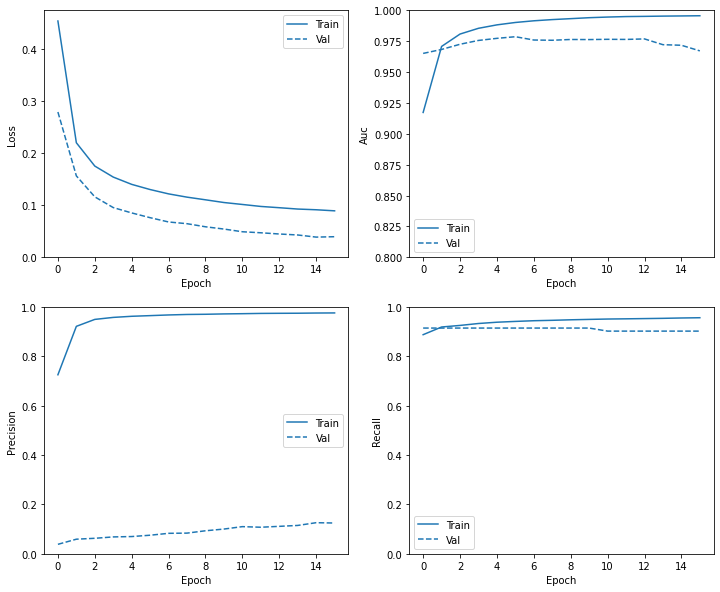

In [47]:
plot_metrics(resampled_history )

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 0s - loss: 1.2860 - tp: 624.0000 - fp: 1236.0000 - tn: 45289.0000 - fn: 468.0000 - accuracy: 0.9642 - precision: 0.3355 - recall: 0.5714 - auc: 0.9393

 5/20 [======>.......................] - ETA: 0s - loss: 1.1960 - tp: 3045.0000 - fp: 4099.0000 - tn: 46565.0000 - fn: 2100.0000 - accuracy: 0.8889 - precision: 0.4262 - recall: 0.5918 - auc: 0.9119

 9/20 [============>.................] - ETA: 0s - loss: 1.1416 - tp: 5708.0000 - fp: 6834.0000 - tn: 47919.0000 - fn: 3540.0000 - accuracy: 0.8379 - precision: 0.4551 - recall: 0.6172 - auc: 0.8880

13/20 [==================>...........] - ETA: 0s - loss: 1.0847 - tp: 8636.0000 - fp: 9541.0000 - tn: 49237.0000 - fn: 4779.0000 - accuracy: 0.8016 - precision: 0.4751 - recall: 0.6438 - auc: 0.8723

17/20 [========================>.....] - ETA: 0s - loss: 1.0389 - tp: 11719.0000 - fp: 12268.0000 - tn: 50616.0000 - fn: 5782.0000 - accuracy: 0.7755 - precision: 0.4886 - recall: 0.6696 - auc: 0.8609

20/20 [==============================] - 1s 50ms/step - loss: 1.0108 - tp: 14123.0000 - fp: 14257.0000 - tn: 51670.0000 - fn: 6479.0000 - accuracy: 0.7604 - precision: 0.4976 - recall: 0.6855 - auc: 0.8545 - val_loss: 1.0800 - val_tp: 80.0000 - val_fp: 34164.0000 - val_tn: 11324.0000 - val_fn: 1.0000 - val_accuracy: 0.2503 - val_precision: 0.0023 - val_recall: 0.9877 - val_auc: 0.8998


Epoch 2/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.8295 - tp: 813.0000 - fp: 679.0000 - tn: 351.0000 - fn: 205.0000 - accuracy: 0.5684 - precision: 0.5449 - recall: 0.7986 - auc: 0.7114

 5/20 [======>.......................] - ETA: 0s - loss: 0.8067 - tp: 4173.0000 - fp: 3334.0000 - tn: 1775.0000 - fn: 958.0000 - accuracy: 0.5809 - precision: 0.5559 - recall: 0.8133 - auc: 0.7295

 8/20 [===========>..................] - ETA: 0s - loss: 0.7853 - tp: 6706.0000 - fp: 5278.0000 - tn: 2915.0000 - fn: 1485.0000 - accuracy: 0.5872 - precision: 0.5596 - recall: 0.8187 - auc: 0.7411

11/20 [===============>..............] - ETA: 0s - loss: 0.7727 - tp: 9295.0000 - fp: 7236.0000 - tn: 4044.0000 - fn: 1953.0000 - accuracy: 0.5921 - precision: 0.5623 - recall: 0.8264 - auc: 0.7516

14/20 [====================>.........] - ETA: 0s - loss: 0.7547 - tp: 11959.0000 - fp: 9082.0000 - tn: 5246.0000 - fn: 2385.0000 - accuracy: 0.6001 - precision: 0.5684 - recall: 0.8337 - auc: 0.7634

17/20 [========================>.....] - ETA: 0s - loss: 0.7405 - tp: 14642.0000 - fp: 10887.0000 - tn: 6480.0000 - fn: 2807.0000 - accuracy: 0.6067 - precision: 0.5735 - recall: 0.8391 - auc: 0.7723

20/20 [==============================] - ETA: 0s - loss: 0.7262 - tp: 17347.0000 - fp: 12752.0000 - tn: 7694.0000 - fn: 3167.0000 - accuracy: 0.6114 - precision: 0.5763 - recall: 0.8456 - auc: 0.7821

20/20 [==============================] - 0s 22ms/step - loss: 0.7262 - tp: 17347.0000 - fp: 12752.0000 - tn: 7694.0000 - fn: 3167.0000 - accuracy: 0.6114 - precision: 0.5763 - recall: 0.8456 - auc: 0.7821 - val_loss: 0.9532 - val_tp: 80.0000 - val_fp: 30230.0000 - val_tn: 15258.0000 - val_fn: 1.0000 - val_accuracy: 0.3366 - val_precision: 0.0026 - val_recall: 0.9877 - val_auc: 0.9574


Epoch 3/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6715 - tp: 880.0000 - fp: 629.0000 - tn: 412.0000 - fn: 127.0000 - accuracy: 0.6309 - precision: 0.5832 - recall: 0.8739 - auc: 0.8195

 5/20 [======>.......................] - ETA: 0s - loss: 0.6454 - tp: 4448.0000 - fp: 3045.0000 - tn: 2114.0000 - fn: 633.0000 - accuracy: 0.6408 - precision: 0.5936 - recall: 0.8754 - auc: 0.8310

 8/20 [===========>..................] - ETA: 0s - loss: 0.6389 - tp: 7165.0000 - fp: 4842.0000 - tn: 3407.0000 - fn: 970.0000 - accuracy: 0.6453 - precision: 0.5967 - recall: 0.8808 - auc: 0.8374

11/20 [===============>..............] - ETA: 0s - loss: 0.6303 - tp: 9930.0000 - fp: 6615.0000 - tn: 4696.0000 - fn: 1287.0000 - accuracy: 0.6492 - precision: 0.6002 - recall: 0.8853 - auc: 0.8429

14/20 [====================>.........] - ETA: 0s - loss: 0.6214 - tp: 12678.0000 - fp: 8308.0000 - tn: 6068.0000 - fn: 1618.0000 - accuracy: 0.6538 - precision: 0.6041 - recall: 0.8868 - auc: 0.8462

17/20 [========================>.....] - ETA: 0s - loss: 0.6159 - tp: 15380.0000 - fp: 10048.0000 - tn: 7460.0000 - fn: 1928.0000 - accuracy: 0.6560 - precision: 0.6048 - recall: 0.8886 - auc: 0.8496

20/20 [==============================] - ETA: 0s - loss: 0.6069 - tp: 18120.0000 - fp: 11692.0000 - tn: 8925.0000 - fn: 2223.0000 - accuracy: 0.6603 - precision: 0.6078 - recall: 0.8907 - auc: 0.8539

20/20 [==============================] - 0s 22ms/step - loss: 0.6069 - tp: 18120.0000 - fp: 11692.0000 - tn: 8925.0000 - fn: 2223.0000 - accuracy: 0.6603 - precision: 0.6078 - recall: 0.8907 - auc: 0.8539 - val_loss: 0.8262 - val_tp: 79.0000 - val_fp: 23976.0000 - val_tn: 21512.0000 - val_fn: 2.0000 - val_accuracy: 0.4738 - val_precision: 0.0033 - val_recall: 0.9753 - val_auc: 0.9634


Epoch 4/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5575 - tp: 943.0000 - fp: 545.0000 - tn: 455.0000 - fn: 105.0000 - accuracy: 0.6826 - precision: 0.6337 - recall: 0.8998 - auc: 0.8752

 5/20 [======>.......................] - ETA: 0s - loss: 0.5548 - tp: 4642.0000 - fp: 2667.0000 - tn: 2440.0000 - fn: 491.0000 - accuracy: 0.6916 - precision: 0.6351 - recall: 0.9043 - auc: 0.8791

 8/20 [===========>..................] - ETA: 0s - loss: 0.5458 - tp: 7451.0000 - fp: 4189.0000 - tn: 3969.0000 - fn: 775.0000 - accuracy: 0.6970 - precision: 0.6401 - recall: 0.9058 - auc: 0.8821

11/20 [===============>..............] - ETA: 0s - loss: 0.5425 - tp: 10137.0000 - fp: 5709.0000 - tn: 5594.0000 - fn: 1088.0000 - accuracy: 0.6983 - precision: 0.6397 - recall: 0.9031 - auc: 0.8825

14/20 [====================>.........] - ETA: 0s - loss: 0.5362 - tp: 12912.0000 - fp: 7169.0000 - tn: 7205.0000 - fn: 1386.0000 - accuracy: 0.7016 - precision: 0.6430 - recall: 0.9031 - auc: 0.8847

17/20 [========================>.....] - ETA: 0s - loss: 0.5297 - tp: 15703.0000 - fp: 8579.0000 - tn: 8849.0000 - fn: 1685.0000 - accuracy: 0.7052 - precision: 0.6467 - recall: 0.9031 - auc: 0.8863

20/20 [==============================] - ETA: 0s - loss: 0.5269 - tp: 18480.0000 - fp: 10021.0000 - tn: 10465.0000 - fn: 1994.0000 - accuracy: 0.7067 - precision: 0.6484 - recall: 0.9026 - auc: 0.8870

20/20 [==============================] - 0s 24ms/step - loss: 0.5269 - tp: 18480.0000 - fp: 10021.0000 - tn: 10465.0000 - fn: 1994.0000 - accuracy: 0.7067 - precision: 0.6484 - recall: 0.9026 - auc: 0.8870 - val_loss: 0.7167 - val_tp: 79.0000 - val_fp: 17807.0000 - val_tn: 27681.0000 - val_fn: 2.0000 - val_accuracy: 0.6092 - val_precision: 0.0044 - val_recall: 0.9753 - val_auc: 0.9650


Epoch 5/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4870 - tp: 968.0000 - fp: 440.0000 - tn: 543.0000 - fn: 97.0000 - accuracy: 0.7378 - precision: 0.6875 - recall: 0.9089 - auc: 0.9011

 5/20 [======>.......................] - ETA: 0s - loss: 0.4885 - tp: 4661.0000 - fp: 2209.0000 - tn: 2887.0000 - fn: 483.0000 - accuracy: 0.7371 - precision: 0.6785 - recall: 0.9061 - auc: 0.8997

 8/20 [===========>..................] - ETA: 0s - loss: 0.4852 - tp: 7403.0000 - fp: 3516.0000 - tn: 4692.0000 - fn: 773.0000 - accuracy: 0.7382 - precision: 0.6780 - recall: 0.9055 - auc: 0.9003

11/20 [===============>..............] - ETA: 0s - loss: 0.4840 - tp: 10145.0000 - fp: 4851.0000 - tn: 6470.0000 - fn: 1062.0000 - accuracy: 0.7375 - precision: 0.6765 - recall: 0.9052 - auc: 0.9006

14/20 [====================>.........] - ETA: 0s - loss: 0.4799 - tp: 12930.0000 - fp: 6096.0000 - tn: 8308.0000 - fn: 1338.0000 - accuracy: 0.7407 - precision: 0.6796 - recall: 0.9062 - auc: 0.9023

17/20 [========================>.....] - ETA: 0s - loss: 0.4767 - tp: 15735.0000 - fp: 7349.0000 - tn: 10120.0000 - fn: 1612.0000 - accuracy: 0.7426 - precision: 0.6816 - recall: 0.9071 - auc: 0.9039

20/20 [==============================] - ETA: 0s - loss: 0.4707 - tp: 18546.0000 - fp: 8531.0000 - tn: 12003.0000 - fn: 1880.0000 - accuracy: 0.7458 - precision: 0.6849 - recall: 0.9080 - auc: 0.9057

20/20 [==============================] - 0s 24ms/step - loss: 0.4707 - tp: 18546.0000 - fp: 8531.0000 - tn: 12003.0000 - fn: 1880.0000 - accuracy: 0.7458 - precision: 0.6849 - recall: 0.9080 - auc: 0.9057 - val_loss: 0.6275 - val_tp: 77.0000 - val_fp: 12701.0000 - val_tn: 32787.0000 - val_fn: 4.0000 - val_accuracy: 0.7212 - val_precision: 0.0060 - val_recall: 0.9506 - val_auc: 0.9650


Epoch 6/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4505 - tp: 914.0000 - fp: 387.0000 - tn: 654.0000 - fn: 93.0000 - accuracy: 0.7656 - precision: 0.7025 - recall: 0.9076 - auc: 0.9139

 5/20 [======>.......................] - ETA: 0s - loss: 0.4551 - tp: 4594.0000 - fp: 1922.0000 - tn: 3243.0000 - fn: 481.0000 - accuracy: 0.7653 - precision: 0.7050 - recall: 0.9052 - auc: 0.9105

 8/20 [===========>..................] - ETA: 0s - loss: 0.4466 - tp: 7416.0000 - fp: 3024.0000 - tn: 5182.0000 - fn: 762.0000 - accuracy: 0.7689 - precision: 0.7103 - recall: 0.9068 - auc: 0.9124

11/20 [===============>..............] - ETA: 0s - loss: 0.4408 - tp: 10201.0000 - fp: 4097.0000 - tn: 7177.0000 - fn: 1053.0000 - accuracy: 0.7714 - precision: 0.7135 - recall: 0.9064 - auc: 0.9137

14/20 [====================>.........] - ETA: 0s - loss: 0.4359 - tp: 13060.0000 - fp: 5158.0000 - tn: 9131.0000 - fn: 1323.0000 - accuracy: 0.7740 - precision: 0.7169 - recall: 0.9080 - auc: 0.9154

17/20 [========================>.....] - ETA: 0s - loss: 0.4306 - tp: 15865.0000 - fp: 6162.0000 - tn: 11181.0000 - fn: 1608.0000 - accuracy: 0.7768 - precision: 0.7203 - recall: 0.9080 - auc: 0.9168

20/20 [==============================] - ETA: 0s - loss: 0.4264 - tp: 18661.0000 - fp: 7163.0000 - tn: 13263.0000 - fn: 1873.0000 - accuracy: 0.7794 - precision: 0.7226 - recall: 0.9088 - auc: 0.9184

20/20 [==============================] - 0s 24ms/step - loss: 0.4264 - tp: 18661.0000 - fp: 7163.0000 - tn: 13263.0000 - fn: 1873.0000 - accuracy: 0.7794 - precision: 0.7226 - recall: 0.9088 - auc: 0.9184 - val_loss: 0.5551 - val_tp: 77.0000 - val_fp: 9099.0000 - val_tn: 36389.0000 - val_fn: 4.0000 - val_accuracy: 0.8002 - val_precision: 0.0084 - val_recall: 0.9506 - val_auc: 0.9642


Epoch 7/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4028 - tp: 927.0000 - fp: 345.0000 - tn: 703.0000 - fn: 73.0000 - accuracy: 0.7959 - precision: 0.7288 - recall: 0.9270 - auc: 0.9336

 5/20 [======>.......................] - ETA: 0s - loss: 0.4037 - tp: 4666.0000 - fp: 1624.0000 - tn: 3524.0000 - fn: 426.0000 - accuracy: 0.7998 - precision: 0.7418 - recall: 0.9163 - auc: 0.9293

 8/20 [===========>..................] - ETA: 0s - loss: 0.3990 - tp: 7461.0000 - fp: 2572.0000 - tn: 5656.0000 - fn: 695.0000 - accuracy: 0.8006 - precision: 0.7436 - recall: 0.9148 - auc: 0.9297

11/20 [===============>..............] - ETA: 0s - loss: 0.3966 - tp: 10236.0000 - fp: 3480.0000 - tn: 7832.0000 - fn: 980.0000 - accuracy: 0.8020 - precision: 0.7463 - recall: 0.9126 - auc: 0.9293

14/20 [====================>.........] - ETA: 0s - loss: 0.3939 - tp: 13052.0000 - fp: 4396.0000 - tn: 9955.0000 - fn: 1269.0000 - accuracy: 0.8024 - precision: 0.7481 - recall: 0.9114 - auc: 0.9293

17/20 [========================>.....] - ETA: 0s - loss: 0.3916 - tp: 15877.0000 - fp: 5271.0000 - tn: 12115.0000 - fn: 1553.0000 - accuracy: 0.8040 - precision: 0.7508 - recall: 0.9109 - auc: 0.9295

20/20 [==============================] - ETA: 0s - loss: 0.3892 - tp: 18629.0000 - fp: 6092.0000 - tn: 14399.0000 - fn: 1840.0000 - accuracy: 0.8063 - precision: 0.7536 - recall: 0.9101 - auc: 0.9299

20/20 [==============================] - 0s 24ms/step - loss: 0.3892 - tp: 18629.0000 - fp: 6092.0000 - tn: 14399.0000 - fn: 1840.0000 - accuracy: 0.8063 - precision: 0.7536 - recall: 0.9101 - auc: 0.9299 - val_loss: 0.4951 - val_tp: 77.0000 - val_fp: 6377.0000 - val_tn: 39111.0000 - val_fn: 4.0000 - val_accuracy: 0.8600 - val_precision: 0.0119 - val_recall: 0.9506 - val_auc: 0.9638


Epoch 8/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3779 - tp: 957.0000 - fp: 294.0000 - tn: 704.0000 - fn: 93.0000 - accuracy: 0.8110 - precision: 0.7650 - recall: 0.9114 - auc: 0.9325

 5/20 [======>.......................] - ETA: 0s - loss: 0.3704 - tp: 4666.0000 - fp: 1366.0000 - tn: 3758.0000 - fn: 450.0000 - accuracy: 0.8227 - precision: 0.7735 - recall: 0.9120 - auc: 0.9353

 8/20 [===========>..................] - ETA: 0s - loss: 0.3662 - tp: 7465.0000 - fp: 2155.0000 - tn: 6067.0000 - fn: 697.0000 - accuracy: 0.8259 - precision: 0.7760 - recall: 0.9146 - auc: 0.9369

11/20 [===============>..............] - ETA: 0s - loss: 0.3671 - tp: 10235.0000 - fp: 2968.0000 - tn: 8341.0000 - fn: 984.0000 - accuracy: 0.8246 - precision: 0.7752 - recall: 0.9123 - auc: 0.9359

14/20 [====================>.........] - ETA: 0s - loss: 0.3643 - tp: 13081.0000 - fp: 3757.0000 - tn: 10582.0000 - fn: 1252.0000 - accuracy: 0.8253 - precision: 0.7769 - recall: 0.9126 - auc: 0.9364

17/20 [========================>.....] - ETA: 0s - loss: 0.3621 - tp: 15921.0000 - fp: 4509.0000 - tn: 12855.0000 - fn: 1531.0000 - accuracy: 0.8265 - precision: 0.7793 - recall: 0.9123 - auc: 0.9365

20/20 [==============================] - ETA: 0s - loss: 0.3606 - tp: 18708.0000 - fp: 5232.0000 - tn: 15205.0000 - fn: 1815.0000 - accuracy: 0.8280 - precision: 0.7815 - recall: 0.9116 - auc: 0.9364

20/20 [==============================] - 0s 23ms/step - loss: 0.3606 - tp: 18708.0000 - fp: 5232.0000 - tn: 15205.0000 - fn: 1815.0000 - accuracy: 0.8280 - precision: 0.7815 - recall: 0.9116 - auc: 0.9364 - val_loss: 0.4461 - val_tp: 77.0000 - val_fp: 4719.0000 - val_tn: 40769.0000 - val_fn: 4.0000 - val_accuracy: 0.8964 - val_precision: 0.0161 - val_recall: 0.9506 - val_auc: 0.9637


Epoch 9/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3712 - tp: 914.0000 - fp: 241.0000 - tn: 810.0000 - fn: 83.0000 - accuracy: 0.8418 - precision: 0.7913 - recall: 0.9168 - auc: 0.9374

 5/20 [======>.......................] - ETA: 0s - loss: 0.3462 - tp: 4673.0000 - fp: 1170.0000 - tn: 3949.0000 - fn: 448.0000 - accuracy: 0.8420 - precision: 0.7998 - recall: 0.9125 - auc: 0.9415

 8/20 [===========>..................] - ETA: 0s - loss: 0.3433 - tp: 7535.0000 - fp: 1848.0000 - tn: 6268.0000 - fn: 733.0000 - accuracy: 0.8425 - precision: 0.8030 - recall: 0.9113 - auc: 0.9416

11/20 [===============>..............] - ETA: 0s - loss: 0.3412 - tp: 10353.0000 - fp: 2521.0000 - tn: 8649.0000 - fn: 1005.0000 - accuracy: 0.8435 - precision: 0.8042 - recall: 0.9115 - auc: 0.9420

14/20 [====================>.........] - ETA: 0s - loss: 0.3388 - tp: 13174.0000 - fp: 3169.0000 - tn: 11046.0000 - fn: 1283.0000 - accuracy: 0.8447 - precision: 0.8061 - recall: 0.9113 - auc: 0.9427

17/20 [========================>.....] - ETA: 0s - loss: 0.3368 - tp: 15967.0000 - fp: 3793.0000 - tn: 13487.0000 - fn: 1569.0000 - accuracy: 0.8460 - precision: 0.8080 - recall: 0.9105 - auc: 0.9428

20/20 [==============================] - ETA: 0s - loss: 0.3349 - tp: 18808.0000 - fp: 4398.0000 - tn: 15901.0000 - fn: 1853.0000 - accuracy: 0.8474 - precision: 0.8105 - recall: 0.9103 - auc: 0.9432

20/20 [==============================] - 0s 23ms/step - loss: 0.3349 - tp: 18808.0000 - fp: 4398.0000 - tn: 15901.0000 - fn: 1853.0000 - accuracy: 0.8474 - precision: 0.8105 - recall: 0.9103 - auc: 0.9432 - val_loss: 0.4067 - val_tp: 76.0000 - val_fp: 3711.0000 - val_tn: 41777.0000 - val_fn: 5.0000 - val_accuracy: 0.9185 - val_precision: 0.0201 - val_recall: 0.9383 - val_auc: 0.9639


Epoch 10/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3268 - tp: 934.0000 - fp: 208.0000 - tn: 817.0000 - fn: 89.0000 - accuracy: 0.8550 - precision: 0.8179 - recall: 0.9130 - auc: 0.9469

 5/20 [======>.......................] - ETA: 0s - loss: 0.3306 - tp: 4616.0000 - fp: 1057.0000 - tn: 4133.0000 - fn: 434.0000 - accuracy: 0.8544 - precision: 0.8137 - recall: 0.9141 - auc: 0.9462

 8/20 [===========>..................] - ETA: 0s - loss: 0.3295 - tp: 7341.0000 - fp: 1671.0000 - tn: 6656.0000 - fn: 716.0000 - accuracy: 0.8543 - precision: 0.8146 - recall: 0.9111 - auc: 0.9449

11/20 [===============>..............] - ETA: 0s - loss: 0.3222 - tp: 10207.0000 - fp: 2204.0000 - tn: 9138.0000 - fn: 979.0000 - accuracy: 0.8587 - precision: 0.8224 - recall: 0.9125 - auc: 0.9466

14/20 [====================>.........] - ETA: 0s - loss: 0.3204 - tp: 13017.0000 - fp: 2773.0000 - tn: 11618.0000 - fn: 1264.0000 - accuracy: 0.8592 - precision: 0.8244 - recall: 0.9115 - auc: 0.9465

17/20 [========================>.....] - ETA: 0s - loss: 0.3185 - tp: 15813.0000 - fp: 3301.0000 - tn: 14169.0000 - fn: 1533.0000 - accuracy: 0.8612 - precision: 0.8273 - recall: 0.9116 - auc: 0.9472

20/20 [==============================] - ETA: 0s - loss: 0.3178 - tp: 18674.0000 - fp: 3878.0000 - tn: 16602.0000 - fn: 1806.0000 - accuracy: 0.8612 - precision: 0.8280 - recall: 0.9118 - auc: 0.9471

20/20 [==============================] - 0s 24ms/step - loss: 0.3178 - tp: 18674.0000 - fp: 3878.0000 - tn: 16602.0000 - fn: 1806.0000 - accuracy: 0.8612 - precision: 0.8280 - recall: 0.9118 - auc: 0.9471 - val_loss: 0.3730 - val_tp: 76.0000 - val_fp: 3081.0000 - val_tn: 42407.0000 - val_fn: 5.0000 - val_accuracy: 0.9323 - val_precision: 0.0241 - val_recall: 0.9383 - val_auc: 0.9641


Epoch 11/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3027 - tp: 935.0000 - fp: 175.0000 - tn: 849.0000 - fn: 89.0000 - accuracy: 0.8711 - precision: 0.8423 - recall: 0.9131 - auc: 0.9515

 5/20 [======>.......................] - ETA: 0s - loss: 0.3003 - tp: 4726.0000 - fp: 865.0000 - tn: 4202.0000 - fn: 447.0000 - accuracy: 0.8719 - precision: 0.8453 - recall: 0.9136 - auc: 0.9513

 8/20 [===========>..................] - ETA: 0s - loss: 0.3030 - tp: 7541.0000 - fp: 1382.0000 - tn: 6736.0000 - fn: 725.0000 - accuracy: 0.8714 - precision: 0.8451 - recall: 0.9123 - auc: 0.9512

11/20 [===============>..............] - ETA: 0s - loss: 0.3023 - tp: 10394.0000 - fp: 1872.0000 - tn: 9261.0000 - fn: 1001.0000 - accuracy: 0.8725 - precision: 0.8474 - recall: 0.9122 - auc: 0.9515

14/20 [====================>.........] - ETA: 0s - loss: 0.3033 - tp: 13164.0000 - fp: 2397.0000 - tn: 11850.0000 - fn: 1261.0000 - accuracy: 0.8724 - precision: 0.8460 - recall: 0.9126 - auc: 0.9513

17/20 [========================>.....] - ETA: 0s - loss: 0.3020 - tp: 16020.0000 - fp: 2861.0000 - tn: 14397.0000 - fn: 1538.0000 - accuracy: 0.8737 - precision: 0.8485 - recall: 0.9124 - auc: 0.9512

20/20 [==============================] - ETA: 0s - loss: 0.2997 - tp: 18850.0000 - fp: 3342.0000 - tn: 16964.0000 - fn: 1804.0000 - accuracy: 0.8744 - precision: 0.8494 - recall: 0.9127 - auc: 0.9519

20/20 [==============================] - 0s 24ms/step - loss: 0.2997 - tp: 18850.0000 - fp: 3342.0000 - tn: 16964.0000 - fn: 1804.0000 - accuracy: 0.8744 - precision: 0.8494 - recall: 0.9127 - auc: 0.9519 - val_loss: 0.3452 - val_tp: 76.0000 - val_fp: 2653.0000 - val_tn: 42835.0000 - val_fn: 5.0000 - val_accuracy: 0.9417 - val_precision: 0.0278 - val_recall: 0.9383 - val_auc: 0.9647


Epoch 12/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2918 - tp: 953.0000 - fp: 169.0000 - tn: 827.0000 - fn: 99.0000 - accuracy: 0.8691 - precision: 0.8494 - recall: 0.9059 - auc: 0.9515

 5/20 [======>.......................] - ETA: 0s - loss: 0.2920 - tp: 4753.0000 - fp: 831.0000 - tn: 4191.0000 - fn: 465.0000 - accuracy: 0.8734 - precision: 0.8512 - recall: 0.9109 - auc: 0.9530

 8/20 [===========>..................] - ETA: 0s - loss: 0.2919 - tp: 7544.0000 - fp: 1348.0000 - tn: 6763.0000 - fn: 729.0000 - accuracy: 0.8732 - precision: 0.8484 - recall: 0.9119 - auc: 0.9534

11/20 [===============>..............] - ETA: 0s - loss: 0.2893 - tp: 10371.0000 - fp: 1791.0000 - tn: 9377.0000 - fn: 989.0000 - accuracy: 0.8766 - precision: 0.8527 - recall: 0.9129 - auc: 0.9543

14/20 [====================>.........] - ETA: 0s - loss: 0.2890 - tp: 13171.0000 - fp: 2283.0000 - tn: 11968.0000 - fn: 1250.0000 - accuracy: 0.8768 - precision: 0.8523 - recall: 0.9133 - auc: 0.9546

17/20 [========================>.....] - ETA: 0s - loss: 0.2879 - tp: 15996.0000 - fp: 2738.0000 - tn: 14552.0000 - fn: 1530.0000 - accuracy: 0.8774 - precision: 0.8538 - recall: 0.9127 - auc: 0.9549

20/20 [==============================] - ETA: 0s - loss: 0.2876 - tp: 18758.0000 - fp: 3227.0000 - tn: 17182.0000 - fn: 1793.0000 - accuracy: 0.8774 - precision: 0.8532 - recall: 0.9128 - auc: 0.9550

20/20 [==============================] - 0s 24ms/step - loss: 0.2876 - tp: 18758.0000 - fp: 3227.0000 - tn: 17182.0000 - fn: 1793.0000 - accuracy: 0.8774 - precision: 0.8532 - recall: 0.9128 - auc: 0.9550 - val_loss: 0.3210 - val_tp: 74.0000 - val_fp: 2334.0000 - val_tn: 43154.0000 - val_fn: 7.0000 - val_accuracy: 0.9486 - val_precision: 0.0307 - val_recall: 0.9136 - val_auc: 0.9647


Epoch 13/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2879 - tp: 929.0000 - fp: 161.0000 - tn: 866.0000 - fn: 92.0000 - accuracy: 0.8765 - precision: 0.8523 - recall: 0.9099 - auc: 0.9571

 5/20 [======>.......................] - ETA: 0s - loss: 0.2868 - tp: 4599.0000 - fp: 756.0000 - tn: 4421.0000 - fn: 464.0000 - accuracy: 0.8809 - precision: 0.8588 - recall: 0.9084 - auc: 0.9542

 8/20 [===========>..................] - ETA: 0s - loss: 0.2827 - tp: 7390.0000 - fp: 1174.0000 - tn: 7100.0000 - fn: 720.0000 - accuracy: 0.8844 - precision: 0.8629 - recall: 0.9112 - auc: 0.9560

11/20 [===============>..............] - ETA: 0s - loss: 0.2806 - tp: 10212.0000 - fp: 1627.0000 - tn: 9704.0000 - fn: 985.0000 - accuracy: 0.8841 - precision: 0.8626 - recall: 0.9120 - auc: 0.9567

14/20 [====================>.........] - ETA: 0s - loss: 0.2808 - tp: 12966.0000 - fp: 2085.0000 - tn: 12378.0000 - fn: 1243.0000 - accuracy: 0.8839 - precision: 0.8615 - recall: 0.9125 - auc: 0.9570

17/20 [========================>.....] - ETA: 0s - loss: 0.2794 - tp: 15762.0000 - fp: 2469.0000 - tn: 15066.0000 - fn: 1519.0000 - accuracy: 0.8855 - precision: 0.8646 - recall: 0.9121 - auc: 0.9571

20/20 [==============================] - ETA: 0s - loss: 0.2790 - tp: 18549.0000 - fp: 2864.0000 - tn: 17752.0000 - fn: 1795.0000 - accuracy: 0.8863 - precision: 0.8662 - recall: 0.9118 - auc: 0.9570

20/20 [==============================] - 0s 24ms/step - loss: 0.2790 - tp: 18549.0000 - fp: 2864.0000 - tn: 17752.0000 - fn: 1795.0000 - accuracy: 0.8863 - precision: 0.8662 - recall: 0.9118 - auc: 0.9570 - val_loss: 0.2990 - val_tp: 74.0000 - val_fp: 2072.0000 - val_tn: 43416.0000 - val_fn: 7.0000 - val_accuracy: 0.9544 - val_precision: 0.0345 - val_recall: 0.9136 - val_auc: 0.9648


Epoch 14/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2812 - tp: 931.0000 - fp: 149.0000 - tn: 872.0000 - fn: 96.0000 - accuracy: 0.8804 - precision: 0.8620 - recall: 0.9065 - auc: 0.9544

 5/20 [======>.......................] - ETA: 0s - loss: 0.2732 - tp: 4738.0000 - fp: 680.0000 - tn: 4355.0000 - fn: 467.0000 - accuracy: 0.8880 - precision: 0.8745 - recall: 0.9103 - auc: 0.9573

 8/20 [===========>..................] - ETA: 0s - loss: 0.2703 - tp: 7555.0000 - fp: 1075.0000 - tn: 7020.0000 - fn: 734.0000 - accuracy: 0.8896 - precision: 0.8754 - recall: 0.9114 - auc: 0.9580

11/20 [===============>..............] - ETA: 0s - loss: 0.2698 - tp: 10397.0000 - fp: 1445.0000 - tn: 9694.0000 - fn: 992.0000 - accuracy: 0.8918 - precision: 0.8780 - recall: 0.9129 - auc: 0.9585

14/20 [====================>.........] - ETA: 0s - loss: 0.2664 - tp: 13185.0000 - fp: 1777.0000 - tn: 12472.0000 - fn: 1238.0000 - accuracy: 0.8948 - precision: 0.8812 - recall: 0.9142 - auc: 0.9598

17/20 [========================>.....] - ETA: 0s - loss: 0.2661 - tp: 16011.0000 - fp: 2142.0000 - tn: 15159.0000 - fn: 1504.0000 - accuracy: 0.8953 - precision: 0.8820 - recall: 0.9141 - auc: 0.9598

20/20 [==============================] - ETA: 0s - loss: 0.2658 - tp: 18828.0000 - fp: 2519.0000 - tn: 17819.0000 - fn: 1794.0000 - accuracy: 0.8947 - precision: 0.8820 - recall: 0.9130 - auc: 0.9595

20/20 [==============================] - 0s 24ms/step - loss: 0.2658 - tp: 18828.0000 - fp: 2519.0000 - tn: 17819.0000 - fn: 1794.0000 - accuracy: 0.8947 - precision: 0.8820 - recall: 0.9130 - auc: 0.9595 - val_loss: 0.2806 - val_tp: 74.0000 - val_fp: 1893.0000 - val_tn: 43595.0000 - val_fn: 7.0000 - val_accuracy: 0.9583 - val_precision: 0.0376 - val_recall: 0.9136 - val_auc: 0.9651


Epoch 15/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2772 - tp: 921.0000 - fp: 142.0000 - tn: 894.0000 - fn: 91.0000 - accuracy: 0.8862 - precision: 0.8664 - recall: 0.9101 - auc: 0.9557

 5/20 [======>.......................] - ETA: 0s - loss: 0.2657 - tp: 4593.0000 - fp: 653.0000 - tn: 4553.0000 - fn: 441.0000 - accuracy: 0.8932 - precision: 0.8755 - recall: 0.9124 - auc: 0.9597

 8/20 [===========>..................] - ETA: 0s - loss: 0.2673 - tp: 7351.0000 - fp: 1035.0000 - tn: 7278.0000 - fn: 720.0000 - accuracy: 0.8929 - precision: 0.8766 - recall: 0.9108 - auc: 0.9589

11/20 [===============>..............] - ETA: 0s - loss: 0.2637 - tp: 10158.0000 - fp: 1373.0000 - tn: 10019.0000 - fn: 978.0000 - accuracy: 0.8956 - precision: 0.8809 - recall: 0.9122 - auc: 0.9600

14/20 [====================>.........] - ETA: 0s - loss: 0.2638 - tp: 12955.0000 - fp: 1732.0000 - tn: 12745.0000 - fn: 1240.0000 - accuracy: 0.8963 - precision: 0.8821 - recall: 0.9126 - auc: 0.9601

17/20 [========================>.....] - ETA: 0s - loss: 0.2632 - tp: 15740.0000 - fp: 2098.0000 - tn: 15490.0000 - fn: 1488.0000 - accuracy: 0.8970 - precision: 0.8824 - recall: 0.9136 - auc: 0.9604

20/20 [==============================] - ETA: 0s - loss: 0.2623 - tp: 18552.0000 - fp: 2466.0000 - tn: 18200.0000 - fn: 1742.0000 - accuracy: 0.8973 - precision: 0.8827 - recall: 0.9142 - auc: 0.9606

20/20 [==============================] - 0s 24ms/step - loss: 0.2623 - tp: 18552.0000 - fp: 2466.0000 - tn: 18200.0000 - fn: 1742.0000 - accuracy: 0.8973 - precision: 0.8827 - recall: 0.9142 - auc: 0.9606 - val_loss: 0.2642 - val_tp: 74.0000 - val_fp: 1771.0000 - val_tn: 43717.0000 - val_fn: 7.0000 - val_accuracy: 0.9610 - val_precision: 0.0401 - val_recall: 0.9136 - val_auc: 0.9653


Epoch 16/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2432 - tp: 931.0000 - fp: 96.0000 - tn: 943.0000 - fn: 78.0000 - accuracy: 0.9150 - precision: 0.9065 - recall: 0.9227 - auc: 0.9674

 5/20 [======>.......................] - ETA: 0s - loss: 0.2481 - tp: 4722.0000 - fp: 526.0000 - tn: 4562.0000 - fn: 430.0000 - accuracy: 0.9066 - precision: 0.8998 - recall: 0.9165 - auc: 0.9646

 8/20 [===========>..................] - ETA: 0s - loss: 0.2485 - tp: 7504.0000 - fp: 859.0000 - tn: 7327.0000 - fn: 694.0000 - accuracy: 0.9052 - precision: 0.8973 - recall: 0.9153 - auc: 0.9640

11/20 [===============>..............] - ETA: 0s - loss: 0.2487 - tp: 10288.0000 - fp: 1179.0000 - tn: 10101.0000 - fn: 960.0000 - accuracy: 0.9051 - precision: 0.8972 - recall: 0.9147 - auc: 0.9638

14/20 [====================>.........] - ETA: 0s - loss: 0.2500 - tp: 13052.0000 - fp: 1502.0000 - tn: 12886.0000 - fn: 1232.0000 - accuracy: 0.9046 - precision: 0.8968 - recall: 0.9137 - auc: 0.9632

17/20 [========================>.....] - ETA: 0s - loss: 0.2497 - tp: 15803.0000 - fp: 1827.0000 - tn: 15679.0000 - fn: 1507.0000 - accuracy: 0.9042 - precision: 0.8964 - recall: 0.9129 - auc: 0.9631

20/20 [==============================] - ETA: 0s - loss: 0.2488 - tp: 18611.0000 - fp: 2136.0000 - tn: 18446.0000 - fn: 1767.0000 - accuracy: 0.9047 - precision: 0.8970 - recall: 0.9133 - auc: 0.9634

20/20 [==============================] - 0s 24ms/step - loss: 0.2488 - tp: 18611.0000 - fp: 2136.0000 - tn: 18446.0000 - fn: 1767.0000 - accuracy: 0.9047 - precision: 0.8970 - recall: 0.9133 - auc: 0.9634 - val_loss: 0.2497 - val_tp: 74.0000 - val_fp: 1643.0000 - val_tn: 43845.0000 - val_fn: 7.0000 - val_accuracy: 0.9638 - val_precision: 0.0431 - val_recall: 0.9136 - val_auc: 0.9654


Epoch 17/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2321 - tp: 932.0000 - fp: 93.0000 - tn: 947.0000 - fn: 76.0000 - accuracy: 0.9175 - precision: 0.9093 - recall: 0.9246 - auc: 0.9720

 5/20 [======>.......................] - ETA: 0s - loss: 0.2427 - tp: 4658.0000 - fp: 482.0000 - tn: 4658.0000 - fn: 442.0000 - accuracy: 0.9098 - precision: 0.9062 - recall: 0.9133 - auc: 0.9654

 8/20 [===========>..................] - ETA: 0s - loss: 0.2448 - tp: 7448.0000 - fp: 812.0000 - tn: 7432.0000 - fn: 692.0000 - accuracy: 0.9082 - precision: 0.9017 - recall: 0.9150 - auc: 0.9653

11/20 [===============>..............] - ETA: 0s - loss: 0.2443 - tp: 10241.0000 - fp: 1153.0000 - tn: 10188.0000 - fn: 946.0000 - accuracy: 0.9068 - precision: 0.8988 - recall: 0.9154 - auc: 0.9656

14/20 [====================>.........] - ETA: 0s - loss: 0.2434 - tp: 12980.0000 - fp: 1443.0000 - tn: 13045.0000 - fn: 1204.0000 - accuracy: 0.9077 - precision: 0.9000 - recall: 0.9151 - auc: 0.9656

17/20 [========================>.....] - ETA: 0s - loss: 0.2426 - tp: 15779.0000 - fp: 1731.0000 - tn: 15830.0000 - fn: 1476.0000 - accuracy: 0.9079 - precision: 0.9011 - recall: 0.9145 - auc: 0.9657

20/20 [==============================] - ETA: 0s - loss: 0.2422 - tp: 18633.0000 - fp: 2027.0000 - tn: 18560.0000 - fn: 1740.0000 - accuracy: 0.9080 - precision: 0.9019 - recall: 0.9146 - auc: 0.9654

20/20 [==============================] - 0s 24ms/step - loss: 0.2422 - tp: 18633.0000 - fp: 2027.0000 - tn: 18560.0000 - fn: 1740.0000 - accuracy: 0.9080 - precision: 0.9019 - recall: 0.9146 - auc: 0.9654 - val_loss: 0.2361 - val_tp: 74.0000 - val_fp: 1532.0000 - val_tn: 43956.0000 - val_fn: 7.0000 - val_accuracy: 0.9662 - val_precision: 0.0461 - val_recall: 0.9136 - val_auc: 0.9657


Epoch 18/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2310 - tp: 974.0000 - fp: 99.0000 - tn: 886.0000 - fn: 89.0000 - accuracy: 0.9082 - precision: 0.9077 - recall: 0.9163 - auc: 0.9685

 5/20 [======>.......................] - ETA: 0s - loss: 0.2367 - tp: 4738.0000 - fp: 464.0000 - tn: 4604.0000 - fn: 434.0000 - accuracy: 0.9123 - precision: 0.9108 - recall: 0.9161 - auc: 0.9663

 8/20 [===========>..................] - ETA: 0s - loss: 0.2381 - tp: 7532.0000 - fp: 768.0000 - tn: 7403.0000 - fn: 681.0000 - accuracy: 0.9116 - precision: 0.9075 - recall: 0.9171 - auc: 0.9659

11/20 [===============>..............] - ETA: 0s - loss: 0.2372 - tp: 10367.0000 - fp: 1034.0000 - tn: 10181.0000 - fn: 946.0000 - accuracy: 0.9121 - precision: 0.9093 - recall: 0.9164 - auc: 0.9661

14/20 [====================>.........] - ETA: 0s - loss: 0.2366 - tp: 13171.0000 - fp: 1319.0000 - tn: 12982.0000 - fn: 1200.0000 - accuracy: 0.9121 - precision: 0.9090 - recall: 0.9165 - auc: 0.9663

17/20 [========================>.....] - ETA: 0s - loss: 0.2360 - tp: 15985.0000 - fp: 1568.0000 - tn: 15795.0000 - fn: 1468.0000 - accuracy: 0.9128 - precision: 0.9107 - recall: 0.9159 - auc: 0.9663

20/20 [==============================] - ETA: 0s - loss: 0.2345 - tp: 18869.0000 - fp: 1824.0000 - tn: 18545.0000 - fn: 1722.0000 - accuracy: 0.9134 - precision: 0.9119 - recall: 0.9164 - auc: 0.9670

20/20 [==============================] - 0s 24ms/step - loss: 0.2345 - tp: 18869.0000 - fp: 1824.0000 - tn: 18545.0000 - fn: 1722.0000 - accuracy: 0.9134 - precision: 0.9119 - recall: 0.9164 - auc: 0.9670 - val_loss: 0.2243 - val_tp: 74.0000 - val_fp: 1444.0000 - val_tn: 44044.0000 - val_fn: 7.0000 - val_accuracy: 0.9682 - val_precision: 0.0487 - val_recall: 0.9136 - val_auc: 0.9663


Epoch 19/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2289 - tp: 964.0000 - fp: 78.0000 - tn: 918.0000 - fn: 88.0000 - accuracy: 0.9189 - precision: 0.9251 - recall: 0.9163 - auc: 0.9678

 5/20 [======>.......................] - ETA: 0s - loss: 0.2301 - tp: 4665.0000 - fp: 430.0000 - tn: 4706.0000 - fn: 439.0000 - accuracy: 0.9151 - precision: 0.9156 - recall: 0.9140 - auc: 0.9676

 8/20 [===========>..................] - ETA: 0s - loss: 0.2292 - tp: 7552.0000 - fp: 662.0000 - tn: 7471.0000 - fn: 699.0000 - accuracy: 0.9169 - precision: 0.9194 - recall: 0.9153 - auc: 0.9680

11/20 [===============>..............] - ETA: 0s - loss: 0.2291 - tp: 10318.0000 - fp: 918.0000 - tn: 10339.0000 - fn: 953.0000 - accuracy: 0.9169 - precision: 0.9183 - recall: 0.9154 - auc: 0.9683

14/20 [====================>.........] - ETA: 0s - loss: 0.2294 - tp: 13090.0000 - fp: 1175.0000 - tn: 13197.0000 - fn: 1210.0000 - accuracy: 0.9168 - precision: 0.9176 - recall: 0.9154 - auc: 0.9683

17/20 [========================>.....] - ETA: 0s - loss: 0.2295 - tp: 15926.0000 - fp: 1446.0000 - tn: 15977.0000 - fn: 1467.0000 - accuracy: 0.9163 - precision: 0.9168 - recall: 0.9157 - auc: 0.9684

20/20 [==============================] - ETA: 0s - loss: 0.2288 - tp: 18753.0000 - fp: 1687.0000 - tn: 18785.0000 - fn: 1735.0000 - accuracy: 0.9165 - precision: 0.9175 - recall: 0.9153 - auc: 0.9685

20/20 [==============================] - 0s 24ms/step - loss: 0.2288 - tp: 18753.0000 - fp: 1687.0000 - tn: 18785.0000 - fn: 1735.0000 - accuracy: 0.9165 - precision: 0.9175 - recall: 0.9153 - auc: 0.9685 - val_loss: 0.2137 - val_tp: 74.0000 - val_fp: 1377.0000 - val_tn: 44111.0000 - val_fn: 7.0000 - val_accuracy: 0.9696 - val_precision: 0.0510 - val_recall: 0.9136 - val_auc: 0.9667


Epoch 20/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2146 - tp: 929.0000 - fp: 70.0000 - tn: 962.0000 - fn: 87.0000 - accuracy: 0.9233 - precision: 0.9299 - recall: 0.9144 - auc: 0.9719

 5/20 [======>.......................] - ETA: 0s - loss: 0.2212 - tp: 4669.0000 - fp: 390.0000 - tn: 4753.0000 - fn: 428.0000 - accuracy: 0.9201 - precision: 0.9229 - recall: 0.9160 - auc: 0.9702

 8/20 [===========>..................] - ETA: 0s - loss: 0.2187 - tp: 7532.0000 - fp: 620.0000 - tn: 7572.0000 - fn: 660.0000 - accuracy: 0.9219 - precision: 0.9239 - recall: 0.9194 - auc: 0.9711

11/20 [===============>..............] - ETA: 0s - loss: 0.2202 - tp: 10322.0000 - fp: 859.0000 - tn: 10437.0000 - fn: 910.0000 - accuracy: 0.9215 - precision: 0.9232 - recall: 0.9190 - auc: 0.9706

14/20 [====================>.........] - ETA: 0s - loss: 0.2220 - tp: 13005.0000 - fp: 1134.0000 - tn: 13378.0000 - fn: 1155.0000 - accuracy: 0.9202 - precision: 0.9198 - recall: 0.9184 - auc: 0.9700

17/20 [========================>.....] - ETA: 0s - loss: 0.2220 - tp: 15809.0000 - fp: 1382.0000 - tn: 16216.0000 - fn: 1409.0000 - accuracy: 0.9198 - precision: 0.9196 - recall: 0.9182 - auc: 0.9702

20/20 [==============================] - ETA: 0s - loss: 0.2215 - tp: 18648.0000 - fp: 1582.0000 - tn: 19036.0000 - fn: 1694.0000 - accuracy: 0.9200 - precision: 0.9218 - recall: 0.9167 - auc: 0.9702

20/20 [==============================] - 0s 23ms/step - loss: 0.2215 - tp: 18648.0000 - fp: 1582.0000 - tn: 19036.0000 - fn: 1694.0000 - accuracy: 0.9200 - precision: 0.9218 - recall: 0.9167 - auc: 0.9702 - val_loss: 0.2048 - val_tp: 74.0000 - val_fp: 1332.0000 - val_tn: 44156.0000 - val_fn: 7.0000 - val_accuracy: 0.9706 - val_precision: 0.0526 - val_recall: 0.9136 - val_auc: 0.9669


Epoch 21/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2201 - tp: 948.0000 - fp: 83.0000 - tn: 925.0000 - fn: 92.0000 - accuracy: 0.9146 - precision: 0.9195 - recall: 0.9115 - auc: 0.9692

 5/20 [======>.......................] - ETA: 0s - loss: 0.2177 - tp: 4722.0000 - fp: 382.0000 - tn: 4727.0000 - fn: 409.0000 - accuracy: 0.9228 - precision: 0.9252 - recall: 0.9203 - auc: 0.9707

 8/20 [===========>..................] - ETA: 0s - loss: 0.2184 - tp: 7571.0000 - fp: 615.0000 - tn: 7536.0000 - fn: 662.0000 - accuracy: 0.9221 - precision: 0.9249 - recall: 0.9196 - auc: 0.9706

11/20 [===============>..............] - ETA: 0s - loss: 0.2185 - tp: 10401.0000 - fp: 857.0000 - tn: 10347.0000 - fn: 923.0000 - accuracy: 0.9210 - precision: 0.9239 - recall: 0.9185 - auc: 0.9705

14/20 [====================>.........] - ETA: 0s - loss: 0.2181 - tp: 13265.0000 - fp: 1093.0000 - tn: 13149.0000 - fn: 1165.0000 - accuracy: 0.9212 - precision: 0.9239 - recall: 0.9193 - auc: 0.9708

17/20 [========================>.....] - ETA: 0s - loss: 0.2167 - tp: 16170.0000 - fp: 1322.0000 - tn: 15911.0000 - fn: 1413.0000 - accuracy: 0.9214 - precision: 0.9244 - recall: 0.9196 - auc: 0.9712

20/20 [==============================] - ETA: 0s - loss: 0.2169 - tp: 18958.0000 - fp: 1563.0000 - tn: 18772.0000 - fn: 1667.0000 - accuracy: 0.9211 - precision: 0.9238 - recall: 0.9192 - auc: 0.9710

20/20 [==============================] - 0s 23ms/step - loss: 0.2169 - tp: 18958.0000 - fp: 1563.0000 - tn: 18772.0000 - fn: 1667.0000 - accuracy: 0.9211 - precision: 0.9238 - recall: 0.9192 - auc: 0.9710 - val_loss: 0.1971 - val_tp: 74.0000 - val_fp: 1301.0000 - val_tn: 44187.0000 - val_fn: 7.0000 - val_accuracy: 0.9713 - val_precision: 0.0538 - val_recall: 0.9136 - val_auc: 0.9670


Epoch 22/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2092 - tp: 922.0000 - fp: 78.0000 - tn: 972.0000 - fn: 76.0000 - accuracy: 0.9248 - precision: 0.9220 - recall: 0.9238 - auc: 0.9734

 5/20 [======>.......................] - ETA: 0s - loss: 0.2127 - tp: 4688.0000 - fp: 389.0000 - tn: 4757.0000 - fn: 406.0000 - accuracy: 0.9224 - precision: 0.9234 - recall: 0.9203 - auc: 0.9731

 8/20 [===========>..................] - ETA: 0s - loss: 0.2117 - tp: 7518.0000 - fp: 599.0000 - tn: 7596.0000 - fn: 671.0000 - accuracy: 0.9225 - precision: 0.9262 - recall: 0.9181 - auc: 0.9728

11/20 [===============>..............] - ETA: 0s - loss: 0.2128 - tp: 10329.0000 - fp: 835.0000 - tn: 10456.0000 - fn: 908.0000 - accuracy: 0.9226 - precision: 0.9252 - recall: 0.9192 - auc: 0.9726

14/20 [====================>.........] - ETA: 0s - loss: 0.2143 - tp: 13143.0000 - fp: 1049.0000 - tn: 13312.0000 - fn: 1168.0000 - accuracy: 0.9227 - precision: 0.9261 - recall: 0.9184 - auc: 0.9719

17/20 [========================>.....] - ETA: 0s - loss: 0.2146 - tp: 15961.0000 - fp: 1282.0000 - tn: 16157.0000 - fn: 1416.0000 - accuracy: 0.9225 - precision: 0.9257 - recall: 0.9185 - auc: 0.9718

20/20 [==============================] - ETA: 0s - loss: 0.2144 - tp: 18767.0000 - fp: 1517.0000 - tn: 19016.0000 - fn: 1660.0000 - accuracy: 0.9224 - precision: 0.9252 - recall: 0.9187 - auc: 0.9720

20/20 [==============================] - 0s 23ms/step - loss: 0.2144 - tp: 18767.0000 - fp: 1517.0000 - tn: 19016.0000 - fn: 1660.0000 - accuracy: 0.9224 - precision: 0.9252 - recall: 0.9187 - auc: 0.9720 - val_loss: 0.1898 - val_tp: 74.0000 - val_fp: 1273.0000 - val_tn: 44215.0000 - val_fn: 7.0000 - val_accuracy: 0.9719 - val_precision: 0.0549 - val_recall: 0.9136 - val_auc: 0.9672


Epoch 23/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2241 - tp: 902.0000 - fp: 83.0000 - tn: 979.0000 - fn: 84.0000 - accuracy: 0.9185 - precision: 0.9157 - recall: 0.9148 - auc: 0.9689

 5/20 [======>.......................] - ETA: 0s - loss: 0.2123 - tp: 4693.0000 - fp: 382.0000 - tn: 4742.0000 - fn: 423.0000 - accuracy: 0.9214 - precision: 0.9247 - recall: 0.9173 - auc: 0.9725

 8/20 [===========>..................] - ETA: 0s - loss: 0.2105 - tp: 7529.0000 - fp: 598.0000 - tn: 7581.0000 - fn: 676.0000 - accuracy: 0.9222 - precision: 0.9264 - recall: 0.9176 - auc: 0.9729

11/20 [===============>..............] - ETA: 0s - loss: 0.2099 - tp: 10351.0000 - fp: 817.0000 - tn: 10444.0000 - fn: 916.0000 - accuracy: 0.9231 - precision: 0.9268 - recall: 0.9187 - auc: 0.9730

14/20 [====================>.........] - ETA: 0s - loss: 0.2098 - tp: 13199.0000 - fp: 1003.0000 - tn: 13304.0000 - fn: 1166.0000 - accuracy: 0.9244 - precision: 0.9294 - recall: 0.9188 - auc: 0.9726

17/20 [========================>.....] - ETA: 0s - loss: 0.2095 - tp: 15940.0000 - fp: 1196.0000 - tn: 16254.0000 - fn: 1426.0000 - accuracy: 0.9247 - precision: 0.9302 - recall: 0.9179 - auc: 0.9728

20/20 [==============================] - ETA: 0s - loss: 0.2084 - tp: 18713.0000 - fp: 1398.0000 - tn: 19167.0000 - fn: 1682.0000 - accuracy: 0.9248 - precision: 0.9305 - recall: 0.9175 - auc: 0.9731

20/20 [==============================] - 0s 23ms/step - loss: 0.2084 - tp: 18713.0000 - fp: 1398.0000 - tn: 19167.0000 - fn: 1682.0000 - accuracy: 0.9248 - precision: 0.9305 - recall: 0.9175 - auc: 0.9731 - val_loss: 0.1828 - val_tp: 74.0000 - val_fp: 1245.0000 - val_tn: 44243.0000 - val_fn: 7.0000 - val_accuracy: 0.9725 - val_precision: 0.0561 - val_recall: 0.9136 - val_auc: 0.9677


Epoch 24/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2108 - tp: 941.0000 - fp: 70.0000 - tn: 954.0000 - fn: 83.0000 - accuracy: 0.9253 - precision: 0.9308 - recall: 0.9189 - auc: 0.9716

 5/20 [======>.......................] - ETA: 0s - loss: 0.2116 - tp: 4761.0000 - fp: 361.0000 - tn: 4685.0000 - fn: 433.0000 - accuracy: 0.9225 - precision: 0.9295 - recall: 0.9166 - auc: 0.9715

 8/20 [===========>..................] - ETA: 0s - loss: 0.2085 - tp: 7562.0000 - fp: 562.0000 - tn: 7585.0000 - fn: 675.0000 - accuracy: 0.9245 - precision: 0.9308 - recall: 0.9181 - auc: 0.9726

11/20 [===============>..............] - ETA: 0s - loss: 0.2087 - tp: 10392.0000 - fp: 773.0000 - tn: 10439.0000 - fn: 924.0000 - accuracy: 0.9247 - precision: 0.9308 - recall: 0.9183 - auc: 0.9728

14/20 [====================>.........] - ETA: 0s - loss: 0.2080 - tp: 13246.0000 - fp: 983.0000 - tn: 13258.0000 - fn: 1185.0000 - accuracy: 0.9244 - precision: 0.9309 - recall: 0.9179 - auc: 0.9730

17/20 [========================>.....] - ETA: 0s - loss: 0.2073 - tp: 15990.0000 - fp: 1182.0000 - tn: 16212.0000 - fn: 1432.0000 - accuracy: 0.9249 - precision: 0.9312 - recall: 0.9178 - auc: 0.9733

20/20 [==============================] - ETA: 0s - loss: 0.2073 - tp: 18815.0000 - fp: 1397.0000 - tn: 19055.0000 - fn: 1693.0000 - accuracy: 0.9246 - precision: 0.9309 - recall: 0.9174 - auc: 0.9731

20/20 [==============================] - 0s 23ms/step - loss: 0.2073 - tp: 18815.0000 - fp: 1397.0000 - tn: 19055.0000 - fn: 1693.0000 - accuracy: 0.9246 - precision: 0.9309 - recall: 0.9174 - auc: 0.9731 - val_loss: 0.1761 - val_tp: 74.0000 - val_fp: 1211.0000 - val_tn: 44277.0000 - val_fn: 7.0000 - val_accuracy: 0.9733 - val_precision: 0.0576 - val_recall: 0.9136 - val_auc: 0.9677


Epoch 25/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1997 - tp: 953.0000 - fp: 65.0000 - tn: 949.0000 - fn: 81.0000 - accuracy: 0.9287 - precision: 0.9361 - recall: 0.9217 - auc: 0.9759

 5/20 [======>.......................] - ETA: 0s - loss: 0.2002 - tp: 4710.0000 - fp: 315.0000 - tn: 4805.0000 - fn: 410.0000 - accuracy: 0.9292 - precision: 0.9373 - recall: 0.9199 - auc: 0.9748

 8/20 [===========>..................] - ETA: 0s - loss: 0.2015 - tp: 7513.0000 - fp: 517.0000 - tn: 7680.0000 - fn: 674.0000 - accuracy: 0.9273 - precision: 0.9356 - recall: 0.9177 - auc: 0.9744

11/20 [===============>..............] - ETA: 0s - loss: 0.2035 - tp: 10311.0000 - fp: 720.0000 - tn: 10567.0000 - fn: 930.0000 - accuracy: 0.9268 - precision: 0.9347 - recall: 0.9173 - auc: 0.9738

14/20 [====================>.........] - ETA: 0s - loss: 0.2034 - tp: 13076.0000 - fp: 918.0000 - tn: 13507.0000 - fn: 1171.0000 - accuracy: 0.9271 - precision: 0.9344 - recall: 0.9178 - auc: 0.9738

17/20 [========================>.....] - ETA: 0s - loss: 0.2024 - tp: 15916.0000 - fp: 1097.0000 - tn: 16386.0000 - fn: 1417.0000 - accuracy: 0.9278 - precision: 0.9355 - recall: 0.9182 - auc: 0.9741

20/20 [==============================] - ETA: 0s - loss: 0.2011 - tp: 18806.0000 - fp: 1270.0000 - tn: 19233.0000 - fn: 1651.0000 - accuracy: 0.9287 - precision: 0.9367 - recall: 0.9193 - auc: 0.9745

20/20 [==============================] - 0s 23ms/step - loss: 0.2011 - tp: 18806.0000 - fp: 1270.0000 - tn: 19233.0000 - fn: 1651.0000 - accuracy: 0.9287 - precision: 0.9367 - recall: 0.9193 - auc: 0.9745 - val_loss: 0.1705 - val_tp: 74.0000 - val_fp: 1202.0000 - val_tn: 44286.0000 - val_fn: 7.0000 - val_accuracy: 0.9735 - val_precision: 0.0580 - val_recall: 0.9136 - val_auc: 0.9683


Epoch 26/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2043 - tp: 900.0000 - fp: 61.0000 - tn: 1003.0000 - fn: 84.0000 - accuracy: 0.9292 - precision: 0.9365 - recall: 0.9146 - auc: 0.9733

 5/20 [======>.......................] - ETA: 0s - loss: 0.2068 - tp: 4587.0000 - fp: 340.0000 - tn: 4903.0000 - fn: 410.0000 - accuracy: 0.9268 - precision: 0.9310 - recall: 0.9180 - auc: 0.9732

 8/20 [===========>..................] - ETA: 0s - loss: 0.2027 - tp: 7474.0000 - fp: 544.0000 - tn: 7722.0000 - fn: 644.0000 - accuracy: 0.9275 - precision: 0.9322 - recall: 0.9207 - auc: 0.9745

11/20 [===============>..............] - ETA: 0s - loss: 0.2018 - tp: 10339.0000 - fp: 730.0000 - tn: 10568.0000 - fn: 891.0000 - accuracy: 0.9280 - precision: 0.9341 - recall: 0.9207 - auc: 0.9744

14/20 [====================>.........] - ETA: 0s - loss: 0.2015 - tp: 13084.0000 - fp: 923.0000 - tn: 13538.0000 - fn: 1127.0000 - accuracy: 0.9285 - precision: 0.9341 - recall: 0.9207 - auc: 0.9745

17/20 [========================>.....] - ETA: 0s - loss: 0.2008 - tp: 15849.0000 - fp: 1105.0000 - tn: 16502.0000 - fn: 1360.0000 - accuracy: 0.9292 - precision: 0.9348 - recall: 0.9210 - auc: 0.9746

20/20 [==============================] - ETA: 0s - loss: 0.1996 - tp: 18659.0000 - fp: 1294.0000 - tn: 19408.0000 - fn: 1599.0000 - accuracy: 0.9294 - precision: 0.9351 - recall: 0.9211 - auc: 0.9750

20/20 [==============================] - 0s 23ms/step - loss: 0.1996 - tp: 18659.0000 - fp: 1294.0000 - tn: 19408.0000 - fn: 1599.0000 - accuracy: 0.9294 - precision: 0.9351 - recall: 0.9211 - auc: 0.9750 - val_loss: 0.1647 - val_tp: 74.0000 - val_fp: 1181.0000 - val_tn: 44307.0000 - val_fn: 7.0000 - val_accuracy: 0.9739 - val_precision: 0.0590 - val_recall: 0.9136 - val_auc: 0.9682


Epoch 27/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1852 - tp: 974.0000 - fp: 52.0000 - tn: 941.0000 - fn: 81.0000 - accuracy: 0.9351 - precision: 0.9493 - recall: 0.9232 - auc: 0.9775

 5/20 [======>.......................] - ETA: 0s - loss: 0.1932 - tp: 4750.0000 - fp: 301.0000 - tn: 4792.0000 - fn: 397.0000 - accuracy: 0.9318 - precision: 0.9404 - recall: 0.9229 - auc: 0.9768

 8/20 [===========>..................] - ETA: 0s - loss: 0.1958 - tp: 7561.0000 - fp: 491.0000 - tn: 7684.0000 - fn: 648.0000 - accuracy: 0.9305 - precision: 0.9390 - recall: 0.9211 - auc: 0.9763

11/20 [===============>..............] - ETA: 0s - loss: 0.1953 - tp: 10357.0000 - fp: 687.0000 - tn: 10598.0000 - fn: 886.0000 - accuracy: 0.9302 - precision: 0.9378 - recall: 0.9212 - auc: 0.9765

14/20 [====================>.........] - ETA: 0s - loss: 0.1960 - tp: 13181.0000 - fp: 873.0000 - tn: 13480.0000 - fn: 1138.0000 - accuracy: 0.9299 - precision: 0.9379 - recall: 0.9205 - auc: 0.9763

17/20 [========================>.....] - ETA: 0s - loss: 0.1965 - tp: 15966.0000 - fp: 1076.0000 - tn: 16400.0000 - fn: 1374.0000 - accuracy: 0.9296 - precision: 0.9369 - recall: 0.9208 - auc: 0.9760

20/20 [==============================] - ETA: 0s - loss: 0.1961 - tp: 18839.0000 - fp: 1265.0000 - tn: 19259.0000 - fn: 1597.0000 - accuracy: 0.9301 - precision: 0.9371 - recall: 0.9219 - auc: 0.9761

20/20 [==============================] - 0s 23ms/step - loss: 0.1961 - tp: 18839.0000 - fp: 1265.0000 - tn: 19259.0000 - fn: 1597.0000 - accuracy: 0.9301 - precision: 0.9371 - recall: 0.9219 - auc: 0.9761 - val_loss: 0.1597 - val_tp: 74.0000 - val_fp: 1168.0000 - val_tn: 44320.0000 - val_fn: 7.0000 - val_accuracy: 0.9742 - val_precision: 0.0596 - val_recall: 0.9136 - val_auc: 0.9684


Epoch 28/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1858 - tp: 955.0000 - fp: 50.0000 - tn: 957.0000 - fn: 86.0000 - accuracy: 0.9336 - precision: 0.9502 - recall: 0.9174 - auc: 0.9777

 5/20 [======>.......................] - ETA: 0s - loss: 0.1930 - tp: 4754.0000 - fp: 283.0000 - tn: 4780.0000 - fn: 423.0000 - accuracy: 0.9311 - precision: 0.9438 - recall: 0.9183 - auc: 0.9758

 8/20 [===========>..................] - ETA: 0s - loss: 0.1943 - tp: 7485.0000 - fp: 474.0000 - tn: 7773.0000 - fn: 652.0000 - accuracy: 0.9313 - precision: 0.9404 - recall: 0.9199 - auc: 0.9761

11/20 [===============>..............] - ETA: 0s - loss: 0.1948 - tp: 10312.0000 - fp: 669.0000 - tn: 10654.0000 - fn: 893.0000 - accuracy: 0.9307 - precision: 0.9391 - recall: 0.9203 - auc: 0.9760

14/20 [====================>.........] - ETA: 0s - loss: 0.1935 - tp: 13139.0000 - fp: 839.0000 - tn: 13570.0000 - fn: 1124.0000 - accuracy: 0.9315 - precision: 0.9400 - recall: 0.9212 - auc: 0.9762

17/20 [========================>.....] - ETA: 0s - loss: 0.1939 - tp: 15922.0000 - fp: 1013.0000 - tn: 16506.0000 - fn: 1375.0000 - accuracy: 0.9314 - precision: 0.9402 - recall: 0.9205 - auc: 0.9762

20/20 [==============================] - ETA: 0s - loss: 0.1930 - tp: 18784.0000 - fp: 1181.0000 - tn: 19375.0000 - fn: 1620.0000 - accuracy: 0.9316 - precision: 0.9408 - recall: 0.9206 - auc: 0.9764

20/20 [==============================] - 0s 24ms/step - loss: 0.1930 - tp: 18784.0000 - fp: 1181.0000 - tn: 19375.0000 - fn: 1620.0000 - accuracy: 0.9316 - precision: 0.9408 - recall: 0.9206 - auc: 0.9764 - val_loss: 0.1546 - val_tp: 74.0000 - val_fp: 1141.0000 - val_tn: 44347.0000 - val_fn: 7.0000 - val_accuracy: 0.9748 - val_precision: 0.0609 - val_recall: 0.9136 - val_auc: 0.9687


Epoch 29/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1843 - tp: 932.0000 - fp: 61.0000 - tn: 970.0000 - fn: 85.0000 - accuracy: 0.9287 - precision: 0.9386 - recall: 0.9164 - auc: 0.9772

 5/20 [======>.......................] - ETA: 0s - loss: 0.1886 - tp: 4753.0000 - fp: 268.0000 - tn: 4829.0000 - fn: 390.0000 - accuracy: 0.9357 - precision: 0.9466 - recall: 0.9242 - auc: 0.9775

 8/20 [===========>..................] - ETA: 0s - loss: 0.1898 - tp: 7565.0000 - fp: 418.0000 - tn: 7766.0000 - fn: 635.0000 - accuracy: 0.9357 - precision: 0.9476 - recall: 0.9226 - auc: 0.9775

11/20 [===============>..............] - ETA: 0s - loss: 0.1897 - tp: 10346.0000 - fp: 596.0000 - tn: 10714.0000 - fn: 872.0000 - accuracy: 0.9348 - precision: 0.9455 - recall: 0.9223 - auc: 0.9772

14/20 [====================>.........] - ETA: 0s - loss: 0.1907 - tp: 13189.0000 - fp: 778.0000 - tn: 13576.0000 - fn: 1129.0000 - accuracy: 0.9335 - precision: 0.9443 - recall: 0.9211 - auc: 0.9768

17/20 [========================>.....] - ETA: 0s - loss: 0.1901 - tp: 16047.0000 - fp: 957.0000 - tn: 16432.0000 - fn: 1380.0000 - accuracy: 0.9329 - precision: 0.9437 - recall: 0.9208 - auc: 0.9768

20/20 [==============================] - ETA: 0s - loss: 0.1903 - tp: 18902.0000 - fp: 1128.0000 - tn: 19297.0000 - fn: 1633.0000 - accuracy: 0.9326 - precision: 0.9437 - recall: 0.9205 - auc: 0.9769

20/20 [==============================] - 0s 24ms/step - loss: 0.1903 - tp: 18902.0000 - fp: 1128.0000 - tn: 19297.0000 - fn: 1633.0000 - accuracy: 0.9326 - precision: 0.9437 - recall: 0.9205 - auc: 0.9769 - val_loss: 0.1506 - val_tp: 74.0000 - val_fp: 1137.0000 - val_tn: 44351.0000 - val_fn: 7.0000 - val_accuracy: 0.9749 - val_precision: 0.0611 - val_recall: 0.9136 - val_auc: 0.9689


Epoch 30/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1926 - tp: 917.0000 - fp: 53.0000 - tn: 996.0000 - fn: 82.0000 - accuracy: 0.9341 - precision: 0.9454 - recall: 0.9179 - auc: 0.9769

 5/20 [======>.......................] - ETA: 0s - loss: 0.1905 - tp: 4668.0000 - fp: 277.0000 - tn: 4877.0000 - fn: 418.0000 - accuracy: 0.9321 - precision: 0.9440 - recall: 0.9178 - auc: 0.9771

 8/20 [===========>..................] - ETA: 0s - loss: 0.1896 - tp: 7506.0000 - fp: 443.0000 - tn: 7775.0000 - fn: 660.0000 - accuracy: 0.9327 - precision: 0.9443 - recall: 0.9192 - auc: 0.9773

11/20 [===============>..............] - ETA: 0s - loss: 0.1894 - tp: 10321.0000 - fp: 624.0000 - tn: 10678.0000 - fn: 905.0000 - accuracy: 0.9321 - precision: 0.9430 - recall: 0.9194 - auc: 0.9771

14/20 [====================>.........] - ETA: 0s - loss: 0.1882 - tp: 13089.0000 - fp: 783.0000 - tn: 13659.0000 - fn: 1141.0000 - accuracy: 0.9329 - precision: 0.9436 - recall: 0.9198 - auc: 0.9774

17/20 [========================>.....] - ETA: 0s - loss: 0.1880 - tp: 15961.0000 - fp: 951.0000 - tn: 16524.0000 - fn: 1380.0000 - accuracy: 0.9330 - precision: 0.9438 - recall: 0.9204 - auc: 0.9773

20/20 [==============================] - ETA: 0s - loss: 0.1876 - tp: 18779.0000 - fp: 1106.0000 - tn: 19449.0000 - fn: 1626.0000 - accuracy: 0.9333 - precision: 0.9444 - recall: 0.9203 - auc: 0.9774

20/20 [==============================] - 0s 24ms/step - loss: 0.1876 - tp: 18779.0000 - fp: 1106.0000 - tn: 19449.0000 - fn: 1626.0000 - accuracy: 0.9333 - precision: 0.9444 - recall: 0.9203 - auc: 0.9774 - val_loss: 0.1471 - val_tp: 74.0000 - val_fp: 1136.0000 - val_tn: 44352.0000 - val_fn: 7.0000 - val_accuracy: 0.9749 - val_precision: 0.0612 - val_recall: 0.9136 - val_auc: 0.9692


Epoch 31/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1865 - tp: 979.0000 - fp: 55.0000 - tn: 931.0000 - fn: 83.0000 - accuracy: 0.9326 - precision: 0.9468 - recall: 0.9218 - auc: 0.9776

 5/20 [======>.......................] - ETA: 0s - loss: 0.1809 - tp: 4778.0000 - fp: 270.0000 - tn: 4792.0000 - fn: 400.0000 - accuracy: 0.9346 - precision: 0.9465 - recall: 0.9228 - auc: 0.9789

 8/20 [===========>..................] - ETA: 0s - loss: 0.1825 - tp: 7618.0000 - fp: 420.0000 - tn: 7699.0000 - fn: 647.0000 - accuracy: 0.9349 - precision: 0.9477 - recall: 0.9217 - auc: 0.9786

11/20 [===============>..............] - ETA: 0s - loss: 0.1828 - tp: 10441.0000 - fp: 578.0000 - tn: 10618.0000 - fn: 891.0000 - accuracy: 0.9348 - precision: 0.9475 - recall: 0.9214 - auc: 0.9787

14/20 [====================>.........] - ETA: 0s - loss: 0.1816 - tp: 13286.0000 - fp: 735.0000 - tn: 13528.0000 - fn: 1123.0000 - accuracy: 0.9352 - precision: 0.9476 - recall: 0.9221 - auc: 0.9790

17/20 [========================>.....] - ETA: 0s - loss: 0.1830 - tp: 16050.0000 - fp: 903.0000 - tn: 16508.0000 - fn: 1355.0000 - accuracy: 0.9351 - precision: 0.9467 - recall: 0.9221 - auc: 0.9787

20/20 [==============================] - ETA: 0s - loss: 0.1825 - tp: 18887.0000 - fp: 1062.0000 - tn: 19424.0000 - fn: 1587.0000 - accuracy: 0.9353 - precision: 0.9468 - recall: 0.9225 - auc: 0.9789

20/20 [==============================] - 0s 23ms/step - loss: 0.1825 - tp: 18887.0000 - fp: 1062.0000 - tn: 19424.0000 - fn: 1587.0000 - accuracy: 0.9353 - precision: 0.9468 - recall: 0.9225 - auc: 0.9789 - val_loss: 0.1440 - val_tp: 74.0000 - val_fp: 1144.0000 - val_tn: 44344.0000 - val_fn: 7.0000 - val_accuracy: 0.9747 - val_precision: 0.0608 - val_recall: 0.9136 - val_auc: 0.9695


Epoch 32/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1720 - tp: 917.0000 - fp: 58.0000 - tn: 1000.0000 - fn: 73.0000 - accuracy: 0.9360 - precision: 0.9405 - recall: 0.9263 - auc: 0.9806

 5/20 [======>.......................] - ETA: 0s - loss: 0.1789 - tp: 4624.0000 - fp: 270.0000 - tn: 4953.0000 - fn: 393.0000 - accuracy: 0.9353 - precision: 0.9448 - recall: 0.9217 - auc: 0.9800

 8/20 [===========>..................] - ETA: 0s - loss: 0.1796 - tp: 7451.0000 - fp: 422.0000 - tn: 7886.0000 - fn: 625.0000 - accuracy: 0.9361 - precision: 0.9464 - recall: 0.9226 - auc: 0.9797

11/20 [===============>..............] - ETA: 0s - loss: 0.1796 - tp: 10307.0000 - fp: 565.0000 - tn: 10786.0000 - fn: 870.0000 - accuracy: 0.9363 - precision: 0.9480 - recall: 0.9222 - auc: 0.9797

14/20 [====================>.........] - ETA: 0s - loss: 0.1791 - tp: 13111.0000 - fp: 718.0000 - tn: 13736.0000 - fn: 1107.0000 - accuracy: 0.9363 - precision: 0.9481 - recall: 0.9221 - auc: 0.9798

17/20 [========================>.....] - ETA: 0s - loss: 0.1785 - tp: 15973.0000 - fp: 855.0000 - tn: 16659.0000 - fn: 1329.0000 - accuracy: 0.9373 - precision: 0.9492 - recall: 0.9232 - auc: 0.9800

20/20 [==============================] - ETA: 0s - loss: 0.1784 - tp: 18835.0000 - fp: 992.0000 - tn: 19555.0000 - fn: 1578.0000 - accuracy: 0.9373 - precision: 0.9500 - recall: 0.9227 - auc: 0.9799

20/20 [==============================] - 0s 23ms/step - loss: 0.1784 - tp: 18835.0000 - fp: 992.0000 - tn: 19555.0000 - fn: 1578.0000 - accuracy: 0.9373 - precision: 0.9500 - recall: 0.9227 - auc: 0.9799 - val_loss: 0.1405 - val_tp: 74.0000 - val_fp: 1143.0000 - val_tn: 44345.0000 - val_fn: 7.0000 - val_accuracy: 0.9748 - val_precision: 0.0608 - val_recall: 0.9136 - val_auc: 0.9700


Epoch 33/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1818 - tp: 933.0000 - fp: 57.0000 - tn: 979.0000 - fn: 79.0000 - accuracy: 0.9336 - precision: 0.9424 - recall: 0.9219 - auc: 0.9791

 5/20 [======>.......................] - ETA: 0s - loss: 0.1769 - tp: 4705.0000 - fp: 250.0000 - tn: 4882.0000 - fn: 403.0000 - accuracy: 0.9362 - precision: 0.9495 - recall: 0.9211 - auc: 0.9800

 8/20 [===========>..................] - ETA: 0s - loss: 0.1787 - tp: 7521.0000 - fp: 404.0000 - tn: 7813.0000 - fn: 646.0000 - accuracy: 0.9359 - precision: 0.9490 - recall: 0.9209 - auc: 0.9795

11/20 [===============>..............] - ETA: 0s - loss: 0.1776 - tp: 10412.0000 - fp: 552.0000 - tn: 10676.0000 - fn: 888.0000 - accuracy: 0.9361 - precision: 0.9497 - recall: 0.9214 - auc: 0.9799

14/20 [====================>.........] - ETA: 0s - loss: 0.1777 - tp: 13288.0000 - fp: 726.0000 - tn: 13552.0000 - fn: 1106.0000 - accuracy: 0.9361 - precision: 0.9482 - recall: 0.9232 - auc: 0.9799

17/20 [========================>.....] - ETA: 0s - loss: 0.1786 - tp: 16111.0000 - fp: 883.0000 - tn: 16475.0000 - fn: 1347.0000 - accuracy: 0.9359 - precision: 0.9480 - recall: 0.9228 - auc: 0.9798

20/20 [==============================] - ETA: 0s - loss: 0.1791 - tp: 18964.0000 - fp: 1044.0000 - tn: 19360.0000 - fn: 1592.0000 - accuracy: 0.9356 - precision: 0.9478 - recall: 0.9226 - auc: 0.9796

20/20 [==============================] - 0s 23ms/step - loss: 0.1791 - tp: 18964.0000 - fp: 1044.0000 - tn: 19360.0000 - fn: 1592.0000 - accuracy: 0.9356 - precision: 0.9478 - recall: 0.9226 - auc: 0.9796 - val_loss: 0.1373 - val_tp: 74.0000 - val_fp: 1131.0000 - val_tn: 44357.0000 - val_fn: 7.0000 - val_accuracy: 0.9750 - val_precision: 0.0614 - val_recall: 0.9136 - val_auc: 0.9701


Epoch 34/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1787 - tp: 936.0000 - fp: 54.0000 - tn: 980.0000 - fn: 78.0000 - accuracy: 0.9355 - precision: 0.9455 - recall: 0.9231 - auc: 0.9806

 5/20 [======>.......................] - ETA: 0s - loss: 0.1742 - tp: 4825.0000 - fp: 250.0000 - tn: 4788.0000 - fn: 377.0000 - accuracy: 0.9388 - precision: 0.9507 - recall: 0.9275 - auc: 0.9807

 8/20 [===========>..................] - ETA: 0s - loss: 0.1746 - tp: 7665.0000 - fp: 392.0000 - tn: 7718.0000 - fn: 609.0000 - accuracy: 0.9389 - precision: 0.9513 - recall: 0.9264 - auc: 0.9807

11/20 [===============>..............] - ETA: 0s - loss: 0.1762 - tp: 10462.0000 - fp: 555.0000 - tn: 10659.0000 - fn: 852.0000 - accuracy: 0.9375 - precision: 0.9496 - recall: 0.9247 - auc: 0.9804

14/20 [====================>.........] - ETA: 0s - loss: 0.1759 - tp: 13241.0000 - fp: 698.0000 - tn: 13639.0000 - fn: 1094.0000 - accuracy: 0.9375 - precision: 0.9499 - recall: 0.9237 - auc: 0.9804

17/20 [========================>.....] - ETA: 0s - loss: 0.1770 - tp: 16070.0000 - fp: 855.0000 - tn: 16567.0000 - fn: 1324.0000 - accuracy: 0.9374 - precision: 0.9495 - recall: 0.9239 - auc: 0.9803

20/20 [==============================] - ETA: 0s - loss: 0.1773 - tp: 18962.0000 - fp: 1022.0000 - tn: 19433.0000 - fn: 1543.0000 - accuracy: 0.9374 - precision: 0.9489 - recall: 0.9248 - auc: 0.9803

20/20 [==============================] - 0s 23ms/step - loss: 0.1773 - tp: 18962.0000 - fp: 1022.0000 - tn: 19433.0000 - fn: 1543.0000 - accuracy: 0.9374 - precision: 0.9489 - recall: 0.9248 - auc: 0.9803 - val_loss: 0.1343 - val_tp: 74.0000 - val_fp: 1131.0000 - val_tn: 44357.0000 - val_fn: 7.0000 - val_accuracy: 0.9750 - val_precision: 0.0614 - val_recall: 0.9136 - val_auc: 0.9702


Epoch 35/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1899 - tp: 932.0000 - fp: 61.0000 - tn: 973.0000 - fn: 82.0000 - accuracy: 0.9302 - precision: 0.9386 - recall: 0.9191 - auc: 0.9774

 5/20 [======>.......................] - ETA: 0s - loss: 0.1830 - tp: 4744.0000 - fp: 261.0000 - tn: 4853.0000 - fn: 382.0000 - accuracy: 0.9372 - precision: 0.9479 - recall: 0.9255 - auc: 0.9801

 8/20 [===========>..................] - ETA: 0s - loss: 0.1813 - tp: 7567.0000 - fp: 413.0000 - tn: 7788.0000 - fn: 616.0000 - accuracy: 0.9372 - precision: 0.9482 - recall: 0.9247 - auc: 0.9802

11/20 [===============>..............] - ETA: 0s - loss: 0.1789 - tp: 10381.0000 - fp: 560.0000 - tn: 10736.0000 - fn: 851.0000 - accuracy: 0.9374 - precision: 0.9488 - recall: 0.9242 - auc: 0.9805

14/20 [====================>.........] - ETA: 0s - loss: 0.1779 - tp: 13272.0000 - fp: 720.0000 - tn: 13596.0000 - fn: 1084.0000 - accuracy: 0.9371 - precision: 0.9485 - recall: 0.9245 - auc: 0.9805

17/20 [========================>.....] - ETA: 0s - loss: 0.1768 - tp: 16053.0000 - fp: 873.0000 - tn: 16583.0000 - fn: 1307.0000 - accuracy: 0.9374 - precision: 0.9484 - recall: 0.9247 - auc: 0.9808

20/20 [==============================] - ETA: 0s - loss: 0.1764 - tp: 18956.0000 - fp: 1021.0000 - tn: 19451.0000 - fn: 1532.0000 - accuracy: 0.9377 - precision: 0.9489 - recall: 0.9252 - auc: 0.9808

20/20 [==============================] - 0s 23ms/step - loss: 0.1764 - tp: 18956.0000 - fp: 1021.0000 - tn: 19451.0000 - fn: 1532.0000 - accuracy: 0.9377 - precision: 0.9489 - recall: 0.9252 - auc: 0.9808 - val_loss: 0.1309 - val_tp: 74.0000 - val_fp: 1108.0000 - val_tn: 44380.0000 - val_fn: 7.0000 - val_accuracy: 0.9755 - val_precision: 0.0626 - val_recall: 0.9136 - val_auc: 0.9707


Epoch 36/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1753 - tp: 934.0000 - fp: 51.0000 - tn: 977.0000 - fn: 86.0000 - accuracy: 0.9331 - precision: 0.9482 - recall: 0.9157 - auc: 0.9811

 5/20 [======>.......................] - ETA: 0s - loss: 0.1770 - tp: 4740.0000 - fp: 257.0000 - tn: 4852.0000 - fn: 391.0000 - accuracy: 0.9367 - precision: 0.9486 - recall: 0.9238 - auc: 0.9802

 8/20 [===========>..................] - ETA: 0s - loss: 0.1758 - tp: 7550.0000 - fp: 408.0000 - tn: 7797.0000 - fn: 629.0000 - accuracy: 0.9367 - precision: 0.9487 - recall: 0.9231 - auc: 0.9804

11/20 [===============>..............] - ETA: 0s - loss: 0.1761 - tp: 10446.0000 - fp: 572.0000 - tn: 10638.0000 - fn: 872.0000 - accuracy: 0.9359 - precision: 0.9481 - recall: 0.9230 - auc: 0.9805

14/20 [====================>.........] - ETA: 0s - loss: 0.1761 - tp: 13290.0000 - fp: 722.0000 - tn: 13541.0000 - fn: 1119.0000 - accuracy: 0.9358 - precision: 0.9485 - recall: 0.9223 - auc: 0.9803

17/20 [========================>.....] - ETA: 0s - loss: 0.1756 - tp: 16158.0000 - fp: 887.0000 - tn: 16434.0000 - fn: 1337.0000 - accuracy: 0.9361 - precision: 0.9480 - recall: 0.9236 - auc: 0.9806

20/20 [==============================] - ETA: 0s - loss: 0.1754 - tp: 19032.0000 - fp: 1045.0000 - tn: 19306.0000 - fn: 1577.0000 - accuracy: 0.9360 - precision: 0.9480 - recall: 0.9235 - auc: 0.9807

20/20 [==============================] - 0s 23ms/step - loss: 0.1754 - tp: 19032.0000 - fp: 1045.0000 - tn: 19306.0000 - fn: 1577.0000 - accuracy: 0.9360 - precision: 0.9480 - recall: 0.9235 - auc: 0.9807 - val_loss: 0.1284 - val_tp: 74.0000 - val_fp: 1114.0000 - val_tn: 44374.0000 - val_fn: 7.0000 - val_accuracy: 0.9754 - val_precision: 0.0623 - val_recall: 0.9136 - val_auc: 0.9712


Epoch 37/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1682 - tp: 957.0000 - fp: 52.0000 - tn: 964.0000 - fn: 75.0000 - accuracy: 0.9380 - precision: 0.9485 - recall: 0.9273 - auc: 0.9826

 5/20 [======>.......................] - ETA: 0s - loss: 0.1708 - tp: 4694.0000 - fp: 272.0000 - tn: 4892.0000 - fn: 382.0000 - accuracy: 0.9361 - precision: 0.9452 - recall: 0.9247 - auc: 0.9815

 8/20 [===========>..................] - ETA: 0s - loss: 0.1680 - tp: 7581.0000 - fp: 406.0000 - tn: 7793.0000 - fn: 604.0000 - accuracy: 0.9384 - precision: 0.9492 - recall: 0.9262 - auc: 0.9823

11/20 [===============>..............] - ETA: 0s - loss: 0.1687 - tp: 10423.0000 - fp: 545.0000 - tn: 10730.0000 - fn: 830.0000 - accuracy: 0.9390 - precision: 0.9503 - recall: 0.9262 - auc: 0.9822

14/20 [====================>.........] - ETA: 0s - loss: 0.1699 - tp: 13298.0000 - fp: 703.0000 - tn: 13610.0000 - fn: 1061.0000 - accuracy: 0.9385 - precision: 0.9498 - recall: 0.9261 - auc: 0.9819

17/20 [========================>.....] - ETA: 0s - loss: 0.1696 - tp: 16105.0000 - fp: 848.0000 - tn: 16559.0000 - fn: 1304.0000 - accuracy: 0.9382 - precision: 0.9500 - recall: 0.9251 - auc: 0.9818

20/20 [==============================] - ETA: 0s - loss: 0.1700 - tp: 18931.0000 - fp: 993.0000 - tn: 19518.0000 - fn: 1518.0000 - accuracy: 0.9387 - precision: 0.9502 - recall: 0.9258 - auc: 0.9818

20/20 [==============================] - 0s 23ms/step - loss: 0.1700 - tp: 18931.0000 - fp: 993.0000 - tn: 19518.0000 - fn: 1518.0000 - accuracy: 0.9387 - precision: 0.9502 - recall: 0.9258 - auc: 0.9818 - val_loss: 0.1257 - val_tp: 74.0000 - val_fp: 1109.0000 - val_tn: 44379.0000 - val_fn: 7.0000 - val_accuracy: 0.9755 - val_precision: 0.0626 - val_recall: 0.9136 - val_auc: 0.9712


Epoch 38/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1838 - tp: 931.0000 - fp: 70.0000 - tn: 977.0000 - fn: 70.0000 - accuracy: 0.9316 - precision: 0.9301 - recall: 0.9301 - auc: 0.9804

 5/20 [======>.......................] - ETA: 0s - loss: 0.1699 - tp: 4685.0000 - fp: 254.0000 - tn: 4932.0000 - fn: 369.0000 - accuracy: 0.9392 - precision: 0.9486 - recall: 0.9270 - auc: 0.9820

 8/20 [===========>..................] - ETA: 0s - loss: 0.1710 - tp: 7509.0000 - fp: 400.0000 - tn: 7893.0000 - fn: 582.0000 - accuracy: 0.9401 - precision: 0.9494 - recall: 0.9281 - auc: 0.9819

11/20 [===============>..............] - ETA: 0s - loss: 0.1707 - tp: 10415.0000 - fp: 534.0000 - tn: 10764.0000 - fn: 815.0000 - accuracy: 0.9401 - precision: 0.9512 - recall: 0.9274 - auc: 0.9819

14/20 [====================>.........] - ETA: 0s - loss: 0.1713 - tp: 13273.0000 - fp: 672.0000 - tn: 13704.0000 - fn: 1023.0000 - accuracy: 0.9409 - precision: 0.9518 - recall: 0.9284 - auc: 0.9818

17/20 [========================>.....] - ETA: 0s - loss: 0.1709 - tp: 16143.0000 - fp: 799.0000 - tn: 16633.0000 - fn: 1241.0000 - accuracy: 0.9414 - precision: 0.9528 - recall: 0.9286 - auc: 0.9819

20/20 [==============================] - ETA: 0s - loss: 0.1704 - tp: 19023.0000 - fp: 937.0000 - tn: 19536.0000 - fn: 1464.0000 - accuracy: 0.9414 - precision: 0.9531 - recall: 0.9285 - auc: 0.9821

20/20 [==============================] - 0s 24ms/step - loss: 0.1704 - tp: 19023.0000 - fp: 937.0000 - tn: 19536.0000 - fn: 1464.0000 - accuracy: 0.9414 - precision: 0.9531 - recall: 0.9285 - auc: 0.9821 - val_loss: 0.1234 - val_tp: 74.0000 - val_fp: 1101.0000 - val_tn: 44387.0000 - val_fn: 7.0000 - val_accuracy: 0.9757 - val_precision: 0.0630 - val_recall: 0.9136 - val_auc: 0.9719


Epoch 39/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1714 - tp: 986.0000 - fp: 52.0000 - tn: 929.0000 - fn: 81.0000 - accuracy: 0.9351 - precision: 0.9499 - recall: 0.9241 - auc: 0.9806

 5/20 [======>.......................] - ETA: 0s - loss: 0.1703 - tp: 4812.0000 - fp: 234.0000 - tn: 4797.0000 - fn: 397.0000 - accuracy: 0.9384 - precision: 0.9536 - recall: 0.9238 - auc: 0.9816

 8/20 [===========>..................] - ETA: 0s - loss: 0.1672 - tp: 7687.0000 - fp: 365.0000 - tn: 7701.0000 - fn: 631.0000 - accuracy: 0.9392 - precision: 0.9547 - recall: 0.9241 - auc: 0.9821

11/20 [===============>..............] - ETA: 0s - loss: 0.1663 - tp: 10575.0000 - fp: 493.0000 - tn: 10598.0000 - fn: 862.0000 - accuracy: 0.9399 - precision: 0.9555 - recall: 0.9246 - auc: 0.9823

14/20 [====================>.........] - ETA: 0s - loss: 0.1657 - tp: 13424.0000 - fp: 624.0000 - tn: 13537.0000 - fn: 1087.0000 - accuracy: 0.9403 - precision: 0.9556 - recall: 0.9251 - auc: 0.9824

17/20 [========================>.....] - ETA: 0s - loss: 0.1647 - tp: 16270.0000 - fp: 759.0000 - tn: 16477.0000 - fn: 1310.0000 - accuracy: 0.9406 - precision: 0.9554 - recall: 0.9255 - auc: 0.9827

20/20 [==============================] - ETA: 0s - loss: 0.1666 - tp: 19106.0000 - fp: 922.0000 - tn: 19381.0000 - fn: 1551.0000 - accuracy: 0.9396 - precision: 0.9540 - recall: 0.9249 - auc: 0.9824

20/20 [==============================] - 0s 23ms/step - loss: 0.1666 - tp: 19106.0000 - fp: 922.0000 - tn: 19381.0000 - fn: 1551.0000 - accuracy: 0.9396 - precision: 0.9540 - recall: 0.9249 - auc: 0.9824 - val_loss: 0.1219 - val_tp: 74.0000 - val_fp: 1110.0000 - val_tn: 44378.0000 - val_fn: 7.0000 - val_accuracy: 0.9755 - val_precision: 0.0625 - val_recall: 0.9136 - val_auc: 0.9720


Epoch 40/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1592 - tp: 942.0000 - fp: 38.0000 - tn: 991.0000 - fn: 77.0000 - accuracy: 0.9438 - precision: 0.9612 - recall: 0.9244 - auc: 0.9839

 5/20 [======>.......................] - ETA: 0s - loss: 0.1656 - tp: 4774.0000 - fp: 237.0000 - tn: 4865.0000 - fn: 364.0000 - accuracy: 0.9413 - precision: 0.9527 - recall: 0.9292 - auc: 0.9830

 8/20 [===========>..................] - ETA: 0s - loss: 0.1640 - tp: 7581.0000 - fp: 376.0000 - tn: 7839.0000 - fn: 588.0000 - accuracy: 0.9412 - precision: 0.9527 - recall: 0.9280 - auc: 0.9832

11/20 [===============>..............] - ETA: 0s - loss: 0.1641 - tp: 10464.0000 - fp: 529.0000 - tn: 10722.0000 - fn: 813.0000 - accuracy: 0.9404 - precision: 0.9519 - recall: 0.9279 - auc: 0.9832

14/20 [====================>.........] - ETA: 0s - loss: 0.1652 - tp: 13316.0000 - fp: 674.0000 - tn: 13642.0000 - fn: 1040.0000 - accuracy: 0.9402 - precision: 0.9518 - recall: 0.9276 - auc: 0.9831

17/20 [========================>.....] - ETA: 0s - loss: 0.1654 - tp: 16142.0000 - fp: 811.0000 - tn: 16610.0000 - fn: 1253.0000 - accuracy: 0.9407 - precision: 0.9522 - recall: 0.9280 - auc: 0.9831

20/20 [==============================] - ETA: 0s - loss: 0.1670 - tp: 19049.0000 - fp: 965.0000 - tn: 19472.0000 - fn: 1474.0000 - accuracy: 0.9405 - precision: 0.9518 - recall: 0.9282 - auc: 0.9828

20/20 [==============================] - 0s 24ms/step - loss: 0.1670 - tp: 19049.0000 - fp: 965.0000 - tn: 19472.0000 - fn: 1474.0000 - accuracy: 0.9405 - precision: 0.9518 - recall: 0.9282 - auc: 0.9828 - val_loss: 0.1192 - val_tp: 74.0000 - val_fp: 1089.0000 - val_tn: 44399.0000 - val_fn: 7.0000 - val_accuracy: 0.9759 - val_precision: 0.0636 - val_recall: 0.9136 - val_auc: 0.9724


Epoch 41/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1626 - tp: 937.0000 - fp: 46.0000 - tn: 991.0000 - fn: 74.0000 - accuracy: 0.9414 - precision: 0.9532 - recall: 0.9268 - auc: 0.9835

 5/20 [======>.......................] - ETA: 0s - loss: 0.1615 - tp: 4699.0000 - fp: 223.0000 - tn: 4947.0000 - fn: 371.0000 - accuracy: 0.9420 - precision: 0.9547 - recall: 0.9268 - auc: 0.9833

 8/20 [===========>..................] - ETA: 0s - loss: 0.1616 - tp: 7563.0000 - fp: 355.0000 - tn: 7874.0000 - fn: 592.0000 - accuracy: 0.9422 - precision: 0.9552 - recall: 0.9274 - auc: 0.9835

11/20 [===============>..............] - ETA: 0s - loss: 0.1627 - tp: 10409.0000 - fp: 506.0000 - tn: 10803.0000 - fn: 810.0000 - accuracy: 0.9416 - precision: 0.9536 - recall: 0.9278 - auc: 0.9834

14/20 [====================>.........] - ETA: 0s - loss: 0.1621 - tp: 13324.0000 - fp: 650.0000 - tn: 13653.0000 - fn: 1045.0000 - accuracy: 0.9409 - precision: 0.9535 - recall: 0.9273 - auc: 0.9835

17/20 [========================>.....] - ETA: 0s - loss: 0.1624 - tp: 16246.0000 - fp: 792.0000 - tn: 16522.0000 - fn: 1256.0000 - accuracy: 0.9412 - precision: 0.9535 - recall: 0.9282 - auc: 0.9835

20/20 [==============================] - ETA: 0s - loss: 0.1631 - tp: 19127.0000 - fp: 927.0000 - tn: 19441.0000 - fn: 1465.0000 - accuracy: 0.9416 - precision: 0.9538 - recall: 0.9289 - auc: 0.9833

20/20 [==============================] - 0s 24ms/step - loss: 0.1631 - tp: 19127.0000 - fp: 927.0000 - tn: 19441.0000 - fn: 1465.0000 - accuracy: 0.9416 - precision: 0.9538 - recall: 0.9289 - auc: 0.9833 - val_loss: 0.1173 - val_tp: 74.0000 - val_fp: 1084.0000 - val_tn: 44404.0000 - val_fn: 7.0000 - val_accuracy: 0.9761 - val_precision: 0.0639 - val_recall: 0.9136 - val_auc: 0.9728


Epoch 42/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1631 - tp: 966.0000 - fp: 49.0000 - tn: 963.0000 - fn: 70.0000 - accuracy: 0.9419 - precision: 0.9517 - recall: 0.9324 - auc: 0.9833

 5/20 [======>.......................] - ETA: 0s - loss: 0.1602 - tp: 4797.0000 - fp: 230.0000 - tn: 4854.0000 - fn: 359.0000 - accuracy: 0.9425 - precision: 0.9542 - recall: 0.9304 - auc: 0.9839

 8/20 [===========>..................] - ETA: 0s - loss: 0.1606 - tp: 7677.0000 - fp: 372.0000 - tn: 7742.0000 - fn: 593.0000 - accuracy: 0.9411 - precision: 0.9538 - recall: 0.9283 - auc: 0.9838

11/20 [===============>..............] - ETA: 0s - loss: 0.1607 - tp: 10501.0000 - fp: 517.0000 - tn: 10710.0000 - fn: 800.0000 - accuracy: 0.9415 - precision: 0.9531 - recall: 0.9292 - auc: 0.9838

14/20 [====================>.........] - ETA: 0s - loss: 0.1616 - tp: 13328.0000 - fp: 644.0000 - tn: 13674.0000 - fn: 1026.0000 - accuracy: 0.9418 - precision: 0.9539 - recall: 0.9285 - auc: 0.9837

17/20 [========================>.....] - ETA: 0s - loss: 0.1616 - tp: 16251.0000 - fp: 769.0000 - tn: 16554.0000 - fn: 1242.0000 - accuracy: 0.9422 - precision: 0.9548 - recall: 0.9290 - auc: 0.9836

20/20 [==============================] - ETA: 0s - loss: 0.1616 - tp: 19035.0000 - fp: 913.0000 - tn: 19573.0000 - fn: 1439.0000 - accuracy: 0.9426 - precision: 0.9542 - recall: 0.9297 - auc: 0.9836

20/20 [==============================] - 0s 24ms/step - loss: 0.1616 - tp: 19035.0000 - fp: 913.0000 - tn: 19573.0000 - fn: 1439.0000 - accuracy: 0.9426 - precision: 0.9542 - recall: 0.9297 - auc: 0.9836 - val_loss: 0.1157 - val_tp: 74.0000 - val_fp: 1088.0000 - val_tn: 44400.0000 - val_fn: 7.0000 - val_accuracy: 0.9760 - val_precision: 0.0637 - val_recall: 0.9136 - val_auc: 0.9728


Epoch 43/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1673 - tp: 920.0000 - fp: 42.0000 - tn: 1013.0000 - fn: 73.0000 - accuracy: 0.9438 - precision: 0.9563 - recall: 0.9265 - auc: 0.9810

 5/20 [======>.......................] - ETA: 0s - loss: 0.1616 - tp: 4740.0000 - fp: 223.0000 - tn: 4904.0000 - fn: 373.0000 - accuracy: 0.9418 - precision: 0.9551 - recall: 0.9270 - auc: 0.9832

 8/20 [===========>..................] - ETA: 0s - loss: 0.1623 - tp: 7573.0000 - fp: 364.0000 - tn: 7865.0000 - fn: 582.0000 - accuracy: 0.9423 - precision: 0.9541 - recall: 0.9286 - auc: 0.9833

11/20 [===============>..............] - ETA: 0s - loss: 0.1619 - tp: 10412.0000 - fp: 501.0000 - tn: 10821.0000 - fn: 794.0000 - accuracy: 0.9425 - precision: 0.9541 - recall: 0.9291 - auc: 0.9834

14/20 [====================>.........] - ETA: 0s - loss: 0.1613 - tp: 13227.0000 - fp: 640.0000 - tn: 13794.0000 - fn: 1011.0000 - accuracy: 0.9424 - precision: 0.9538 - recall: 0.9290 - auc: 0.9835

17/20 [========================>.....] - ETA: 0s - loss: 0.1613 - tp: 16072.0000 - fp: 756.0000 - tn: 16743.0000 - fn: 1245.0000 - accuracy: 0.9425 - precision: 0.9551 - recall: 0.9281 - auc: 0.9835

20/20 [==============================] - ETA: 0s - loss: 0.1608 - tp: 18934.0000 - fp: 903.0000 - tn: 19655.0000 - fn: 1468.0000 - accuracy: 0.9421 - precision: 0.9545 - recall: 0.9280 - auc: 0.9836

20/20 [==============================] - 0s 23ms/step - loss: 0.1608 - tp: 18934.0000 - fp: 903.0000 - tn: 19655.0000 - fn: 1468.0000 - accuracy: 0.9421 - precision: 0.9545 - recall: 0.9280 - auc: 0.9836 - val_loss: 0.1137 - val_tp: 74.0000 - val_fp: 1074.0000 - val_tn: 44414.0000 - val_fn: 7.0000 - val_accuracy: 0.9763 - val_precision: 0.0645 - val_recall: 0.9136 - val_auc: 0.9732


Epoch 44/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1681 - tp: 947.0000 - fp: 60.0000 - tn: 966.0000 - fn: 75.0000 - accuracy: 0.9341 - precision: 0.9404 - recall: 0.9266 - auc: 0.9818

 5/20 [======>.......................] - ETA: 0s - loss: 0.1606 - tp: 4728.0000 - fp: 242.0000 - tn: 4897.0000 - fn: 373.0000 - accuracy: 0.9399 - precision: 0.9513 - recall: 0.9269 - auc: 0.9839

 8/20 [===========>..................] - ETA: 0s - loss: 0.1614 - tp: 7537.0000 - fp: 383.0000 - tn: 7864.0000 - fn: 600.0000 - accuracy: 0.9400 - precision: 0.9516 - recall: 0.9263 - auc: 0.9838

11/20 [===============>..............] - ETA: 0s - loss: 0.1608 - tp: 10360.0000 - fp: 518.0000 - tn: 10835.0000 - fn: 815.0000 - accuracy: 0.9408 - precision: 0.9524 - recall: 0.9271 - auc: 0.9841

14/20 [====================>.........] - ETA: 0s - loss: 0.1602 - tp: 13178.0000 - fp: 654.0000 - tn: 13812.0000 - fn: 1028.0000 - accuracy: 0.9413 - precision: 0.9527 - recall: 0.9276 - auc: 0.9844

17/20 [========================>.....] - ETA: 0s - loss: 0.1602 - tp: 16015.0000 - fp: 790.0000 - tn: 16761.0000 - fn: 1250.0000 - accuracy: 0.9414 - precision: 0.9530 - recall: 0.9276 - auc: 0.9843

20/20 [==============================] - ETA: 0s - loss: 0.1601 - tp: 18866.0000 - fp: 929.0000 - tn: 19700.0000 - fn: 1465.0000 - accuracy: 0.9416 - precision: 0.9531 - recall: 0.9279 - auc: 0.9842

20/20 [==============================] - 0s 24ms/step - loss: 0.1601 - tp: 18866.0000 - fp: 929.0000 - tn: 19700.0000 - fn: 1465.0000 - accuracy: 0.9416 - precision: 0.9531 - recall: 0.9279 - auc: 0.9842 - val_loss: 0.1114 - val_tp: 74.0000 - val_fp: 1058.0000 - val_tn: 44430.0000 - val_fn: 7.0000 - val_accuracy: 0.9766 - val_precision: 0.0654 - val_recall: 0.9136 - val_auc: 0.9736


Epoch 45/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1572 - tp: 949.0000 - fp: 46.0000 - tn: 976.0000 - fn: 77.0000 - accuracy: 0.9399 - precision: 0.9538 - recall: 0.9250 - auc: 0.9843

 4/20 [=====>........................] - ETA: 0s - loss: 0.1571 - tp: 3813.0000 - fp: 177.0000 - tn: 3908.0000 - fn: 294.0000 - accuracy: 0.9425 - precision: 0.9556 - recall: 0.9284 - auc: 0.9846

 7/20 [=========>....................] - ETA: 0s - loss: 0.1564 - tp: 6702.0000 - fp: 302.0000 - tn: 6830.0000 - fn: 502.0000 - accuracy: 0.9439 - precision: 0.9569 - recall: 0.9303 - auc: 0.9849

10/20 [==============>...............] - ETA: 0s - loss: 0.1582 - tp: 9524.0000 - fp: 436.0000 - tn: 9793.0000 - fn: 727.0000 - accuracy: 0.9432 - precision: 0.9562 - recall: 0.9291 - auc: 0.9843

13/20 [==================>...........] - ETA: 0s - loss: 0.1586 - tp: 12381.0000 - fp: 561.0000 - tn: 12766.0000 - fn: 916.0000 - accuracy: 0.9445 - precision: 0.9567 - recall: 0.9311 - auc: 0.9843

16/20 [=======================>......] - ETA: 0s - loss: 0.1588 - tp: 15232.0000 - fp: 699.0000 - tn: 15712.0000 - fn: 1125.0000 - accuracy: 0.9443 - precision: 0.9561 - recall: 0.9312 - auc: 0.9843

19/20 [===========================>..] - ETA: 0s - loss: 0.1580 - tp: 18071.0000 - fp: 814.0000 - tn: 18697.0000 - fn: 1330.0000 - accuracy: 0.9449 - precision: 0.9569 - recall: 0.9314 - auc: 0.9844

20/20 [==============================] - 0s 25ms/step - loss: 0.1573 - tp: 19041.0000 - fp: 853.0000 - tn: 19677.0000 - fn: 1389.0000 - accuracy: 0.9453 - precision: 0.9571 - recall: 0.9320 - auc: 0.9846 - val_loss: 0.1099 - val_tp: 74.0000 - val_fp: 1058.0000 - val_tn: 44430.0000 - val_fn: 7.0000 - val_accuracy: 0.9766 - val_precision: 0.0654 - val_recall: 0.9136 - val_auc: 0.9734


Epoch 46/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1581 - tp: 991.0000 - fp: 35.0000 - tn: 956.0000 - fn: 66.0000 - accuracy: 0.9507 - precision: 0.9659 - recall: 0.9376 - auc: 0.9853

 5/20 [======>.......................] - ETA: 0s - loss: 0.1614 - tp: 4827.0000 - fp: 226.0000 - tn: 4822.0000 - fn: 365.0000 - accuracy: 0.9423 - precision: 0.9553 - recall: 0.9297 - auc: 0.9836

 8/20 [===========>..................] - ETA: 0s - loss: 0.1599 - tp: 7696.0000 - fp: 376.0000 - tn: 7740.0000 - fn: 572.0000 - accuracy: 0.9421 - precision: 0.9534 - recall: 0.9308 - auc: 0.9840

11/20 [===============>..............] - ETA: 0s - loss: 0.1585 - tp: 10522.0000 - fp: 493.0000 - tn: 10727.0000 - fn: 786.0000 - accuracy: 0.9432 - precision: 0.9552 - recall: 0.9305 - auc: 0.9842

14/20 [====================>.........] - ETA: 0s - loss: 0.1582 - tp: 13320.0000 - fp: 631.0000 - tn: 13738.0000 - fn: 983.0000 - accuracy: 0.9437 - precision: 0.9548 - recall: 0.9313 - auc: 0.9844

17/20 [========================>.....] - ETA: 0s - loss: 0.1578 - tp: 16138.0000 - fp: 762.0000 - tn: 16718.0000 - fn: 1198.0000 - accuracy: 0.9437 - precision: 0.9549 - recall: 0.9309 - auc: 0.9845

20/20 [==============================] - ETA: 0s - loss: 0.1577 - tp: 19032.0000 - fp: 900.0000 - tn: 19618.0000 - fn: 1410.0000 - accuracy: 0.9436 - precision: 0.9548 - recall: 0.9310 - auc: 0.9844

20/20 [==============================] - 0s 25ms/step - loss: 0.1577 - tp: 19032.0000 - fp: 900.0000 - tn: 19618.0000 - fn: 1410.0000 - accuracy: 0.9436 - precision: 0.9548 - recall: 0.9310 - auc: 0.9844 - val_loss: 0.1083 - val_tp: 74.0000 - val_fp: 1058.0000 - val_tn: 44430.0000 - val_fn: 7.0000 - val_accuracy: 0.9766 - val_precision: 0.0654 - val_recall: 0.9136 - val_auc: 0.9739


Epoch 47/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1505 - tp: 953.0000 - fp: 43.0000 - tn: 986.0000 - fn: 66.0000 - accuracy: 0.9468 - precision: 0.9568 - recall: 0.9352 - auc: 0.9856

 5/20 [======>.......................] - ETA: 0s - loss: 0.1591 - tp: 4794.0000 - fp: 233.0000 - tn: 4848.0000 - fn: 365.0000 - accuracy: 0.9416 - precision: 0.9537 - recall: 0.9292 - auc: 0.9843

 8/20 [===========>..................] - ETA: 0s - loss: 0.1580 - tp: 7645.0000 - fp: 356.0000 - tn: 7818.0000 - fn: 565.0000 - accuracy: 0.9438 - precision: 0.9555 - recall: 0.9312 - auc: 0.9845

11/20 [===============>..............] - ETA: 0s - loss: 0.1572 - tp: 10515.0000 - fp: 481.0000 - tn: 10763.0000 - fn: 769.0000 - accuracy: 0.9445 - precision: 0.9563 - recall: 0.9319 - auc: 0.9847

14/20 [====================>.........] - ETA: 0s - loss: 0.1571 - tp: 13356.0000 - fp: 627.0000 - tn: 13703.0000 - fn: 986.0000 - accuracy: 0.9437 - precision: 0.9552 - recall: 0.9313 - auc: 0.9847

17/20 [========================>.....] - ETA: 0s - loss: 0.1559 - tp: 16278.0000 - fp: 754.0000 - tn: 16587.0000 - fn: 1197.0000 - accuracy: 0.9440 - precision: 0.9557 - recall: 0.9315 - auc: 0.9849

20/20 [==============================] - ETA: 0s - loss: 0.1553 - tp: 19181.0000 - fp: 861.0000 - tn: 19495.0000 - fn: 1423.0000 - accuracy: 0.9442 - precision: 0.9570 - recall: 0.9309 - auc: 0.9851

20/20 [==============================] - 0s 24ms/step - loss: 0.1553 - tp: 19181.0000 - fp: 861.0000 - tn: 19495.0000 - fn: 1423.0000 - accuracy: 0.9442 - precision: 0.9570 - recall: 0.9309 - auc: 0.9851 - val_loss: 0.1069 - val_tp: 74.0000 - val_fp: 1054.0000 - val_tn: 44434.0000 - val_fn: 7.0000 - val_accuracy: 0.9767 - val_precision: 0.0656 - val_recall: 0.9136 - val_auc: 0.9741


Epoch 48/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1585 - tp: 929.0000 - fp: 50.0000 - tn: 996.0000 - fn: 73.0000 - accuracy: 0.9399 - precision: 0.9489 - recall: 0.9271 - auc: 0.9849

 4/20 [=====>........................] - ETA: 0s - loss: 0.1580 - tp: 3789.0000 - fp: 187.0000 - tn: 3929.0000 - fn: 287.0000 - accuracy: 0.9421 - precision: 0.9530 - recall: 0.9296 - auc: 0.9853

 7/20 [=========>....................] - ETA: 0s - loss: 0.1602 - tp: 6591.0000 - fp: 334.0000 - tn: 6909.0000 - fn: 502.0000 - accuracy: 0.9417 - precision: 0.9518 - recall: 0.9292 - auc: 0.9845

10/20 [==============>...............] - ETA: 0s - loss: 0.1579 - tp: 9361.0000 - fp: 469.0000 - tn: 9941.0000 - fn: 709.0000 - accuracy: 0.9425 - precision: 0.9523 - recall: 0.9296 - auc: 0.9850

13/20 [==================>...........] - ETA: 0s - loss: 0.1564 - tp: 12203.0000 - fp: 591.0000 - tn: 12905.0000 - fn: 925.0000 - accuracy: 0.9431 - precision: 0.9538 - recall: 0.9295 - auc: 0.9852

16/20 [=======================>......] - ETA: 0s - loss: 0.1559 - tp: 15062.0000 - fp: 713.0000 - tn: 15857.0000 - fn: 1136.0000 - accuracy: 0.9436 - precision: 0.9548 - recall: 0.9299 - auc: 0.9853

19/20 [===========================>..] - ETA: 0s - loss: 0.1548 - tp: 18029.0000 - fp: 843.0000 - tn: 18704.0000 - fn: 1336.0000 - accuracy: 0.9440 - precision: 0.9553 - recall: 0.9310 - auc: 0.9855

20/20 [==============================] - 1s 26ms/step - loss: 0.1552 - tp: 18946.0000 - fp: 885.0000 - tn: 19719.0000 - fn: 1410.0000 - accuracy: 0.9440 - precision: 0.9554 - recall: 0.9307 - auc: 0.9854 - val_loss: 0.1048 - val_tp: 74.0000 - val_fp: 1039.0000 - val_tn: 44449.0000 - val_fn: 7.0000 - val_accuracy: 0.9770 - val_precision: 0.0665 - val_recall: 0.9136 - val_auc: 0.9744


Epoch 49/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1499 - tp: 912.0000 - fp: 43.0000 - tn: 1030.0000 - fn: 63.0000 - accuracy: 0.9482 - precision: 0.9550 - recall: 0.9354 - auc: 0.9861

 5/20 [======>.......................] - ETA: 0s - loss: 0.1548 - tp: 4722.0000 - fp: 215.0000 - tn: 4947.0000 - fn: 356.0000 - accuracy: 0.9442 - precision: 0.9565 - recall: 0.9299 - auc: 0.9846

 8/20 [===========>..................] - ETA: 0s - loss: 0.1544 - tp: 7513.0000 - fp: 352.0000 - tn: 7946.0000 - fn: 573.0000 - accuracy: 0.9435 - precision: 0.9552 - recall: 0.9291 - auc: 0.9849

11/20 [===============>..............] - ETA: 0s - loss: 0.1560 - tp: 10395.0000 - fp: 491.0000 - tn: 10859.0000 - fn: 783.0000 - accuracy: 0.9434 - precision: 0.9549 - recall: 0.9300 - auc: 0.9848

14/20 [====================>.........] - ETA: 0s - loss: 0.1546 - tp: 13261.0000 - fp: 590.0000 - tn: 13824.0000 - fn: 997.0000 - accuracy: 0.9446 - precision: 0.9574 - recall: 0.9301 - auc: 0.9850

17/20 [========================>.....] - ETA: 0s - loss: 0.1551 - tp: 16111.0000 - fp: 711.0000 - tn: 16769.0000 - fn: 1225.0000 - accuracy: 0.9444 - precision: 0.9577 - recall: 0.9293 - auc: 0.9849

20/20 [==============================] - ETA: 0s - loss: 0.1537 - tp: 18943.0000 - fp: 829.0000 - tn: 19763.0000 - fn: 1425.0000 - accuracy: 0.9450 - precision: 0.9581 - recall: 0.9300 - auc: 0.9852

20/20 [==============================] - 0s 24ms/step - loss: 0.1537 - tp: 18943.0000 - fp: 829.0000 - tn: 19763.0000 - fn: 1425.0000 - accuracy: 0.9450 - precision: 0.9581 - recall: 0.9300 - auc: 0.9852 - val_loss: 0.1036 - val_tp: 74.0000 - val_fp: 1039.0000 - val_tn: 44449.0000 - val_fn: 7.0000 - val_accuracy: 0.9770 - val_precision: 0.0665 - val_recall: 0.9136 - val_auc: 0.9747


Epoch 50/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1474 - tp: 969.0000 - fp: 34.0000 - tn: 981.0000 - fn: 64.0000 - accuracy: 0.9521 - precision: 0.9661 - recall: 0.9380 - auc: 0.9866

 5/20 [======>.......................] - ETA: 0s - loss: 0.1519 - tp: 4829.0000 - fp: 195.0000 - tn: 4873.0000 - fn: 343.0000 - accuracy: 0.9475 - precision: 0.9612 - recall: 0.9337 - auc: 0.9856

 8/20 [===========>..................] - ETA: 0s - loss: 0.1537 - tp: 7672.0000 - fp: 321.0000 - tn: 7837.0000 - fn: 554.0000 - accuracy: 0.9466 - precision: 0.9598 - recall: 0.9327 - auc: 0.9853

11/20 [===============>..............] - ETA: 0s - loss: 0.1573 - tp: 10504.0000 - fp: 461.0000 - tn: 10785.0000 - fn: 778.0000 - accuracy: 0.9450 - precision: 0.9580 - recall: 0.9310 - auc: 0.9847

14/20 [====================>.........] - ETA: 0s - loss: 0.1570 - tp: 13411.0000 - fp: 599.0000 - tn: 13657.0000 - fn: 1005.0000 - accuracy: 0.9441 - precision: 0.9572 - recall: 0.9303 - auc: 0.9847

17/20 [========================>.....] - ETA: 0s - loss: 0.1567 - tp: 16329.0000 - fp: 735.0000 - tn: 16544.0000 - fn: 1208.0000 - accuracy: 0.9442 - precision: 0.9569 - recall: 0.9311 - auc: 0.9847

20/20 [==============================] - ETA: 0s - loss: 0.1564 - tp: 19158.0000 - fp: 872.0000 - tn: 19513.0000 - fn: 1417.0000 - accuracy: 0.9441 - precision: 0.9565 - recall: 0.9311 - auc: 0.9848

20/20 [==============================] - 0s 24ms/step - loss: 0.1564 - tp: 19158.0000 - fp: 872.0000 - tn: 19513.0000 - fn: 1417.0000 - accuracy: 0.9441 - precision: 0.9565 - recall: 0.9311 - auc: 0.9848 - val_loss: 0.1028 - val_tp: 74.0000 - val_fp: 1044.0000 - val_tn: 44444.0000 - val_fn: 7.0000 - val_accuracy: 0.9769 - val_precision: 0.0662 - val_recall: 0.9136 - val_auc: 0.9749


Epoch 51/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1451 - tp: 995.0000 - fp: 47.0000 - tn: 941.0000 - fn: 65.0000 - accuracy: 0.9453 - precision: 0.9549 - recall: 0.9387 - auc: 0.9865

 5/20 [======>.......................] - ETA: 0s - loss: 0.1520 - tp: 4783.0000 - fp: 230.0000 - tn: 4874.0000 - fn: 353.0000 - accuracy: 0.9431 - precision: 0.9541 - recall: 0.9313 - auc: 0.9853

 8/20 [===========>..................] - ETA: 0s - loss: 0.1504 - tp: 7624.0000 - fp: 338.0000 - tn: 7858.0000 - fn: 564.0000 - accuracy: 0.9449 - precision: 0.9575 - recall: 0.9311 - auc: 0.9857

11/20 [===============>..............] - ETA: 0s - loss: 0.1516 - tp: 10415.0000 - fp: 468.0000 - tn: 10864.0000 - fn: 781.0000 - accuracy: 0.9446 - precision: 0.9570 - recall: 0.9302 - auc: 0.9855

14/20 [====================>.........] - ETA: 0s - loss: 0.1501 - tp: 13312.0000 - fp: 588.0000 - tn: 13796.0000 - fn: 976.0000 - accuracy: 0.9455 - precision: 0.9577 - recall: 0.9317 - auc: 0.9858

17/20 [========================>.....] - ETA: 0s - loss: 0.1507 - tp: 16111.0000 - fp: 725.0000 - tn: 16782.0000 - fn: 1198.0000 - accuracy: 0.9448 - precision: 0.9569 - recall: 0.9308 - auc: 0.9857

20/20 [==============================] - ETA: 0s - loss: 0.1498 - tp: 18961.0000 - fp: 839.0000 - tn: 19766.0000 - fn: 1394.0000 - accuracy: 0.9455 - precision: 0.9576 - recall: 0.9315 - auc: 0.9859

20/20 [==============================] - 0s 24ms/step - loss: 0.1498 - tp: 18961.0000 - fp: 839.0000 - tn: 19766.0000 - fn: 1394.0000 - accuracy: 0.9455 - precision: 0.9576 - recall: 0.9315 - auc: 0.9859 - val_loss: 0.1017 - val_tp: 74.0000 - val_fp: 1045.0000 - val_tn: 44443.0000 - val_fn: 7.0000 - val_accuracy: 0.9769 - val_precision: 0.0661 - val_recall: 0.9136 - val_auc: 0.9750


Epoch 52/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1540 - tp: 961.0000 - fp: 48.0000 - tn: 984.0000 - fn: 55.0000 - accuracy: 0.9497 - precision: 0.9524 - recall: 0.9459 - auc: 0.9867

 5/20 [======>.......................] - ETA: 0s - loss: 0.1560 - tp: 4722.0000 - fp: 225.0000 - tn: 4941.0000 - fn: 352.0000 - accuracy: 0.9437 - precision: 0.9545 - recall: 0.9306 - auc: 0.9851

 8/20 [===========>..................] - ETA: 0s - loss: 0.1531 - tp: 7629.0000 - fp: 337.0000 - tn: 7864.0000 - fn: 554.0000 - accuracy: 0.9456 - precision: 0.9577 - recall: 0.9323 - auc: 0.9856

11/20 [===============>..............] - ETA: 0s - loss: 0.1532 - tp: 10510.0000 - fp: 454.0000 - tn: 10787.0000 - fn: 777.0000 - accuracy: 0.9454 - precision: 0.9586 - recall: 0.9312 - auc: 0.9855

14/20 [====================>.........] - ETA: 0s - loss: 0.1516 - tp: 13385.0000 - fp: 573.0000 - tn: 13723.0000 - fn: 991.0000 - accuracy: 0.9455 - precision: 0.9589 - recall: 0.9311 - auc: 0.9857

17/20 [========================>.....] - ETA: 0s - loss: 0.1518 - tp: 16213.0000 - fp: 705.0000 - tn: 16716.0000 - fn: 1182.0000 - accuracy: 0.9458 - precision: 0.9583 - recall: 0.9320 - auc: 0.9857

20/20 [==============================] - ETA: 0s - loss: 0.1508 - tp: 19039.0000 - fp: 839.0000 - tn: 19703.0000 - fn: 1379.0000 - accuracy: 0.9458 - precision: 0.9578 - recall: 0.9325 - auc: 0.9860

20/20 [==============================] - 0s 25ms/step - loss: 0.1508 - tp: 19039.0000 - fp: 839.0000 - tn: 19703.0000 - fn: 1379.0000 - accuracy: 0.9458 - precision: 0.9578 - recall: 0.9325 - auc: 0.9860 - val_loss: 0.1002 - val_tp: 74.0000 - val_fp: 1021.0000 - val_tn: 44467.0000 - val_fn: 7.0000 - val_accuracy: 0.9774 - val_precision: 0.0676 - val_recall: 0.9136 - val_auc: 0.9743


Epoch 53/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1483 - tp: 998.0000 - fp: 38.0000 - tn: 932.0000 - fn: 80.0000 - accuracy: 0.9424 - precision: 0.9633 - recall: 0.9258 - auc: 0.9860

 5/20 [======>.......................] - ETA: 0s - loss: 0.1472 - tp: 4824.0000 - fp: 199.0000 - tn: 4856.0000 - fn: 361.0000 - accuracy: 0.9453 - precision: 0.9604 - recall: 0.9304 - auc: 0.9863

 8/20 [===========>..................] - ETA: 0s - loss: 0.1469 - tp: 7675.0000 - fp: 323.0000 - tn: 7815.0000 - fn: 571.0000 - accuracy: 0.9454 - precision: 0.9596 - recall: 0.9308 - auc: 0.9865

11/20 [===============>..............] - ETA: 0s - loss: 0.1466 - tp: 10572.0000 - fp: 424.0000 - tn: 10757.0000 - fn: 775.0000 - accuracy: 0.9468 - precision: 0.9614 - recall: 0.9317 - auc: 0.9867

14/20 [====================>.........] - ETA: 0s - loss: 0.1449 - tp: 13412.0000 - fp: 527.0000 - tn: 13760.0000 - fn: 973.0000 - accuracy: 0.9477 - precision: 0.9622 - recall: 0.9324 - auc: 0.9870

17/20 [========================>.....] - ETA: 0s - loss: 0.1450 - tp: 16220.0000 - fp: 652.0000 - tn: 16770.0000 - fn: 1174.0000 - accuracy: 0.9476 - precision: 0.9614 - recall: 0.9325 - auc: 0.9870

20/20 [==============================] - ETA: 0s - loss: 0.1458 - tp: 19052.0000 - fp: 782.0000 - tn: 19748.0000 - fn: 1378.0000 - accuracy: 0.9473 - precision: 0.9606 - recall: 0.9326 - auc: 0.9869

20/20 [==============================] - 0s 24ms/step - loss: 0.1458 - tp: 19052.0000 - fp: 782.0000 - tn: 19748.0000 - fn: 1378.0000 - accuracy: 0.9473 - precision: 0.9606 - recall: 0.9326 - auc: 0.9869 - val_loss: 0.0996 - val_tp: 74.0000 - val_fp: 1027.0000 - val_tn: 44461.0000 - val_fn: 7.0000 - val_accuracy: 0.9773 - val_precision: 0.0672 - val_recall: 0.9136 - val_auc: 0.9746


Epoch 54/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1404 - tp: 906.0000 - fp: 34.0000 - tn: 1049.0000 - fn: 59.0000 - accuracy: 0.9546 - precision: 0.9638 - recall: 0.9389 - auc: 0.9892

 5/20 [======>.......................] - ETA: 0s - loss: 0.1472 - tp: 4772.0000 - fp: 197.0000 - tn: 4944.0000 - fn: 327.0000 - accuracy: 0.9488 - precision: 0.9604 - recall: 0.9359 - auc: 0.9867

 8/20 [===========>..................] - ETA: 0s - loss: 0.1494 - tp: 7678.0000 - fp: 347.0000 - tn: 7826.0000 - fn: 533.0000 - accuracy: 0.9463 - precision: 0.9568 - recall: 0.9351 - auc: 0.9864

11/20 [===============>..............] - ETA: 0s - loss: 0.1478 - tp: 10599.0000 - fp: 464.0000 - tn: 10737.0000 - fn: 728.0000 - accuracy: 0.9471 - precision: 0.9581 - recall: 0.9357 - auc: 0.9867

14/20 [====================>.........] - ETA: 0s - loss: 0.1490 - tp: 13491.0000 - fp: 587.0000 - tn: 13650.0000 - fn: 944.0000 - accuracy: 0.9466 - precision: 0.9583 - recall: 0.9346 - auc: 0.9863

17/20 [========================>.....] - ETA: 0s - loss: 0.1495 - tp: 16386.0000 - fp: 719.0000 - tn: 16558.0000 - fn: 1153.0000 - accuracy: 0.9462 - precision: 0.9580 - recall: 0.9343 - auc: 0.9863

20/20 [==============================] - ETA: 0s - loss: 0.1489 - tp: 19260.0000 - fp: 820.0000 - tn: 19522.0000 - fn: 1358.0000 - accuracy: 0.9468 - precision: 0.9592 - recall: 0.9341 - auc: 0.9864

20/20 [==============================] - 0s 23ms/step - loss: 0.1489 - tp: 19260.0000 - fp: 820.0000 - tn: 19522.0000 - fn: 1358.0000 - accuracy: 0.9468 - precision: 0.9592 - recall: 0.9341 - auc: 0.9864 - val_loss: 0.0978 - val_tp: 74.0000 - val_fp: 1010.0000 - val_tn: 44478.0000 - val_fn: 7.0000 - val_accuracy: 0.9777 - val_precision: 0.0683 - val_recall: 0.9136 - val_auc: 0.9749


Epoch 55/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1503 - tp: 970.0000 - fp: 44.0000 - tn: 968.0000 - fn: 66.0000 - accuracy: 0.9463 - precision: 0.9566 - recall: 0.9363 - auc: 0.9859

 5/20 [======>.......................] - ETA: 0s - loss: 0.1537 - tp: 4674.0000 - fp: 230.0000 - tn: 4971.0000 - fn: 365.0000 - accuracy: 0.9419 - precision: 0.9531 - recall: 0.9276 - auc: 0.9852

 8/20 [===========>..................] - ETA: 0s - loss: 0.1516 - tp: 7593.0000 - fp: 353.0000 - tn: 7872.0000 - fn: 566.0000 - accuracy: 0.9439 - precision: 0.9556 - recall: 0.9306 - auc: 0.9856

11/20 [===============>..............] - ETA: 0s - loss: 0.1500 - tp: 10502.0000 - fp: 477.0000 - tn: 10788.0000 - fn: 761.0000 - accuracy: 0.9450 - precision: 0.9566 - recall: 0.9324 - auc: 0.9862

14/20 [====================>.........] - ETA: 0s - loss: 0.1492 - tp: 13314.0000 - fp: 602.0000 - tn: 13792.0000 - fn: 964.0000 - accuracy: 0.9454 - precision: 0.9567 - recall: 0.9325 - auc: 0.9864

17/20 [========================>.....] - ETA: 0s - loss: 0.1477 - tp: 16184.0000 - fp: 721.0000 - tn: 16749.0000 - fn: 1162.0000 - accuracy: 0.9459 - precision: 0.9573 - recall: 0.9330 - auc: 0.9866

20/20 [==============================] - ETA: 0s - loss: 0.1474 - tp: 19032.0000 - fp: 840.0000 - tn: 19707.0000 - fn: 1381.0000 - accuracy: 0.9458 - precision: 0.9577 - recall: 0.9323 - auc: 0.9867

20/20 [==============================] - 0s 24ms/step - loss: 0.1474 - tp: 19032.0000 - fp: 840.0000 - tn: 19707.0000 - fn: 1381.0000 - accuracy: 0.9458 - precision: 0.9577 - recall: 0.9323 - auc: 0.9867 - val_loss: 0.0965 - val_tp: 74.0000 - val_fp: 1006.0000 - val_tn: 44482.0000 - val_fn: 7.0000 - val_accuracy: 0.9778 - val_precision: 0.0685 - val_recall: 0.9136 - val_auc: 0.9752


Epoch 56/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1359 - tp: 950.0000 - fp: 38.0000 - tn: 995.0000 - fn: 65.0000 - accuracy: 0.9497 - precision: 0.9615 - recall: 0.9360 - auc: 0.9895

 5/20 [======>.......................] - ETA: 0s - loss: 0.1448 - tp: 4813.0000 - fp: 207.0000 - tn: 4891.0000 - fn: 329.0000 - accuracy: 0.9477 - precision: 0.9588 - recall: 0.9360 - auc: 0.9873

 8/20 [===========>..................] - ETA: 0s - loss: 0.1457 - tp: 7690.0000 - fp: 336.0000 - tn: 7830.0000 - fn: 528.0000 - accuracy: 0.9473 - precision: 0.9581 - recall: 0.9358 - auc: 0.9871

11/20 [===============>..............] - ETA: 0s - loss: 0.1447 - tp: 10584.0000 - fp: 437.0000 - tn: 10781.0000 - fn: 726.0000 - accuracy: 0.9484 - precision: 0.9603 - recall: 0.9358 - auc: 0.9873

14/20 [====================>.........] - ETA: 0s - loss: 0.1455 - tp: 13462.0000 - fp: 569.0000 - tn: 13718.0000 - fn: 923.0000 - accuracy: 0.9480 - precision: 0.9594 - recall: 0.9358 - auc: 0.9872

17/20 [========================>.....] - ETA: 0s - loss: 0.1463 - tp: 16290.0000 - fp: 689.0000 - tn: 16714.0000 - fn: 1123.0000 - accuracy: 0.9480 - precision: 0.9594 - recall: 0.9355 - auc: 0.9870

20/20 [==============================] - ETA: 0s - loss: 0.1467 - tp: 19218.0000 - fp: 828.0000 - tn: 19607.0000 - fn: 1307.0000 - accuracy: 0.9479 - precision: 0.9587 - recall: 0.9363 - auc: 0.9870

20/20 [==============================] - 0s 23ms/step - loss: 0.1467 - tp: 19218.0000 - fp: 828.0000 - tn: 19607.0000 - fn: 1307.0000 - accuracy: 0.9479 - precision: 0.9587 - recall: 0.9363 - auc: 0.9870 - val_loss: 0.0954 - val_tp: 74.0000 - val_fp: 999.0000 - val_tn: 44489.0000 - val_fn: 7.0000 - val_accuracy: 0.9779 - val_precision: 0.0690 - val_recall: 0.9136 - val_auc: 0.9755


Epoch 57/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1486 - tp: 965.0000 - fp: 40.0000 - tn: 969.0000 - fn: 74.0000 - accuracy: 0.9443 - precision: 0.9602 - recall: 0.9288 - auc: 0.9854

 5/20 [======>.......................] - ETA: 0s - loss: 0.1436 - tp: 4854.0000 - fp: 182.0000 - tn: 4852.0000 - fn: 352.0000 - accuracy: 0.9479 - precision: 0.9639 - recall: 0.9324 - auc: 0.9870

 8/20 [===========>..................] - ETA: 0s - loss: 0.1442 - tp: 7692.0000 - fp: 291.0000 - tn: 7847.0000 - fn: 554.0000 - accuracy: 0.9484 - precision: 0.9635 - recall: 0.9328 - auc: 0.9869

11/20 [===============>..............] - ETA: 0s - loss: 0.1441 - tp: 10596.0000 - fp: 417.0000 - tn: 10751.0000 - fn: 764.0000 - accuracy: 0.9476 - precision: 0.9621 - recall: 0.9327 - auc: 0.9869

14/20 [====================>.........] - ETA: 0s - loss: 0.1432 - tp: 13529.0000 - fp: 527.0000 - tn: 13656.0000 - fn: 960.0000 - accuracy: 0.9481 - precision: 0.9625 - recall: 0.9337 - auc: 0.9872

17/20 [========================>.....] - ETA: 0s - loss: 0.1436 - tp: 16389.0000 - fp: 659.0000 - tn: 16619.0000 - fn: 1149.0000 - accuracy: 0.9481 - precision: 0.9613 - recall: 0.9345 - auc: 0.9871

20/20 [==============================] - ETA: 0s - loss: 0.1436 - tp: 19264.0000 - fp: 780.0000 - tn: 19573.0000 - fn: 1343.0000 - accuracy: 0.9482 - precision: 0.9611 - recall: 0.9348 - auc: 0.9871

20/20 [==============================] - 0s 23ms/step - loss: 0.1436 - tp: 19264.0000 - fp: 780.0000 - tn: 19573.0000 - fn: 1343.0000 - accuracy: 0.9482 - precision: 0.9611 - recall: 0.9348 - auc: 0.9871 - val_loss: 0.0950 - val_tp: 74.0000 - val_fp: 1014.0000 - val_tn: 44474.0000 - val_fn: 7.0000 - val_accuracy: 0.9776 - val_precision: 0.0680 - val_recall: 0.9136 - val_auc: 0.9757


Epoch 58/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1406 - tp: 960.0000 - fp: 42.0000 - tn: 977.0000 - fn: 69.0000 - accuracy: 0.9458 - precision: 0.9581 - recall: 0.9329 - auc: 0.9882

 5/20 [======>.......................] - ETA: 0s - loss: 0.1434 - tp: 4819.0000 - fp: 194.0000 - tn: 4889.0000 - fn: 338.0000 - accuracy: 0.9480 - precision: 0.9613 - recall: 0.9345 - auc: 0.9874

 8/20 [===========>..................] - ETA: 0s - loss: 0.1452 - tp: 7691.0000 - fp: 333.0000 - tn: 7813.0000 - fn: 547.0000 - accuracy: 0.9463 - precision: 0.9585 - recall: 0.9336 - auc: 0.9867

11/20 [===============>..............] - ETA: 0s - loss: 0.1450 - tp: 10552.0000 - fp: 465.0000 - tn: 10765.0000 - fn: 746.0000 - accuracy: 0.9462 - precision: 0.9578 - recall: 0.9340 - auc: 0.9869

14/20 [====================>.........] - ETA: 0s - loss: 0.1455 - tp: 13429.0000 - fp: 571.0000 - tn: 13723.0000 - fn: 949.0000 - accuracy: 0.9470 - precision: 0.9592 - recall: 0.9340 - auc: 0.9870

17/20 [========================>.....] - ETA: 0s - loss: 0.1444 - tp: 16279.0000 - fp: 679.0000 - tn: 16724.0000 - fn: 1134.0000 - accuracy: 0.9479 - precision: 0.9600 - recall: 0.9349 - auc: 0.9873

20/20 [==============================] - ETA: 0s - loss: 0.1433 - tp: 19130.0000 - fp: 790.0000 - tn: 19721.0000 - fn: 1319.0000 - accuracy: 0.9485 - precision: 0.9603 - recall: 0.9355 - auc: 0.9875

20/20 [==============================] - 0s 24ms/step - loss: 0.1433 - tp: 19130.0000 - fp: 790.0000 - tn: 19721.0000 - fn: 1319.0000 - accuracy: 0.9485 - precision: 0.9603 - recall: 0.9355 - auc: 0.9875 - val_loss: 0.0940 - val_tp: 74.0000 - val_fp: 1008.0000 - val_tn: 44480.0000 - val_fn: 7.0000 - val_accuracy: 0.9777 - val_precision: 0.0684 - val_recall: 0.9136 - val_auc: 0.9760


Epoch 59/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1374 - tp: 987.0000 - fp: 39.0000 - tn: 963.0000 - fn: 59.0000 - accuracy: 0.9521 - precision: 0.9620 - recall: 0.9436 - auc: 0.9881

 5/20 [======>.......................] - ETA: 0s - loss: 0.1403 - tp: 4898.0000 - fp: 190.0000 - tn: 4828.0000 - fn: 324.0000 - accuracy: 0.9498 - precision: 0.9627 - recall: 0.9380 - auc: 0.9879

 8/20 [===========>..................] - ETA: 0s - loss: 0.1435 - tp: 7745.0000 - fp: 302.0000 - tn: 7806.0000 - fn: 531.0000 - accuracy: 0.9492 - precision: 0.9625 - recall: 0.9358 - auc: 0.9873

11/20 [===============>..............] - ETA: 0s - loss: 0.1420 - tp: 10680.0000 - fp: 397.0000 - tn: 10729.0000 - fn: 722.0000 - accuracy: 0.9503 - precision: 0.9642 - recall: 0.9367 - auc: 0.9878

14/20 [====================>.........] - ETA: 0s - loss: 0.1421 - tp: 13574.0000 - fp: 509.0000 - tn: 13669.0000 - fn: 920.0000 - accuracy: 0.9502 - precision: 0.9639 - recall: 0.9365 - auc: 0.9876

17/20 [========================>.....] - ETA: 0s - loss: 0.1417 - tp: 16431.0000 - fp: 617.0000 - tn: 16645.0000 - fn: 1123.0000 - accuracy: 0.9500 - precision: 0.9638 - recall: 0.9360 - auc: 0.9878

20/20 [==============================] - ETA: 0s - loss: 0.1411 - tp: 19239.0000 - fp: 730.0000 - tn: 19659.0000 - fn: 1332.0000 - accuracy: 0.9497 - precision: 0.9634 - recall: 0.9352 - auc: 0.9878

20/20 [==============================] - 0s 24ms/step - loss: 0.1411 - tp: 19239.0000 - fp: 730.0000 - tn: 19659.0000 - fn: 1332.0000 - accuracy: 0.9497 - precision: 0.9634 - recall: 0.9352 - auc: 0.9878 - val_loss: 0.0940 - val_tp: 74.0000 - val_fp: 1028.0000 - val_tn: 44460.0000 - val_fn: 7.0000 - val_accuracy: 0.9773 - val_precision: 0.0672 - val_recall: 0.9136 - val_auc: 0.9760


Epoch 60/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1335 - tp: 961.0000 - fp: 43.0000 - tn: 983.0000 - fn: 61.0000 - accuracy: 0.9492 - precision: 0.9572 - recall: 0.9403 - auc: 0.9891

 5/20 [======>.......................] - ETA: 0s - loss: 0.1419 - tp: 4760.0000 - fp: 218.0000 - tn: 4951.0000 - fn: 311.0000 - accuracy: 0.9483 - precision: 0.9562 - recall: 0.9387 - auc: 0.9877

 8/20 [===========>..................] - ETA: 0s - loss: 0.1421 - tp: 7623.0000 - fp: 342.0000 - tn: 7908.0000 - fn: 511.0000 - accuracy: 0.9479 - precision: 0.9571 - recall: 0.9372 - auc: 0.9876

11/20 [===============>..............] - ETA: 0s - loss: 0.1408 - tp: 10481.0000 - fp: 440.0000 - tn: 10916.0000 - fn: 691.0000 - accuracy: 0.9498 - precision: 0.9597 - recall: 0.9381 - auc: 0.9879

14/20 [====================>.........] - ETA: 0s - loss: 0.1412 - tp: 13329.0000 - fp: 558.0000 - tn: 13889.0000 - fn: 896.0000 - accuracy: 0.9493 - precision: 0.9598 - recall: 0.9370 - auc: 0.9878

17/20 [========================>.....] - ETA: 0s - loss: 0.1413 - tp: 16255.0000 - fp: 682.0000 - tn: 16793.0000 - fn: 1086.0000 - accuracy: 0.9492 - precision: 0.9597 - recall: 0.9374 - auc: 0.9877

20/20 [==============================] - ETA: 0s - loss: 0.1408 - tp: 19150.0000 - fp: 791.0000 - tn: 19733.0000 - fn: 1286.0000 - accuracy: 0.9493 - precision: 0.9603 - recall: 0.9371 - auc: 0.9879

20/20 [==============================] - 0s 24ms/step - loss: 0.1408 - tp: 19150.0000 - fp: 791.0000 - tn: 19733.0000 - fn: 1286.0000 - accuracy: 0.9493 - precision: 0.9603 - recall: 0.9371 - auc: 0.9879 - val_loss: 0.0931 - val_tp: 74.0000 - val_fp: 1028.0000 - val_tn: 44460.0000 - val_fn: 7.0000 - val_accuracy: 0.9773 - val_precision: 0.0672 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 61/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1318 - tp: 945.0000 - fp: 31.0000 - tn: 1004.0000 - fn: 68.0000 - accuracy: 0.9517 - precision: 0.9682 - recall: 0.9329 - auc: 0.9894

 5/20 [======>.......................] - ETA: 0s - loss: 0.1455 - tp: 4756.0000 - fp: 212.0000 - tn: 4948.0000 - fn: 324.0000 - accuracy: 0.9477 - precision: 0.9573 - recall: 0.9362 - auc: 0.9873

 8/20 [===========>..................] - ETA: 0s - loss: 0.1456 - tp: 7623.0000 - fp: 335.0000 - tn: 7904.0000 - fn: 522.0000 - accuracy: 0.9477 - precision: 0.9579 - recall: 0.9359 - auc: 0.9869

11/20 [===============>..............] - ETA: 0s - loss: 0.1448 - tp: 10506.0000 - fp: 471.0000 - tn: 10845.0000 - fn: 706.0000 - accuracy: 0.9478 - precision: 0.9571 - recall: 0.9370 - auc: 0.9872

14/20 [====================>.........] - ETA: 0s - loss: 0.1439 - tp: 13402.0000 - fp: 572.0000 - tn: 13780.0000 - fn: 918.0000 - accuracy: 0.9480 - precision: 0.9591 - recall: 0.9359 - auc: 0.9873

17/20 [========================>.....] - ETA: 0s - loss: 0.1445 - tp: 16260.0000 - fp: 697.0000 - tn: 16754.0000 - fn: 1105.0000 - accuracy: 0.9482 - precision: 0.9589 - recall: 0.9364 - auc: 0.9873

20/20 [==============================] - ETA: 0s - loss: 0.1443 - tp: 19159.0000 - fp: 813.0000 - tn: 19686.0000 - fn: 1302.0000 - accuracy: 0.9484 - precision: 0.9593 - recall: 0.9364 - auc: 0.9873

20/20 [==============================] - 0s 24ms/step - loss: 0.1443 - tp: 19159.0000 - fp: 813.0000 - tn: 19686.0000 - fn: 1302.0000 - accuracy: 0.9484 - precision: 0.9593 - recall: 0.9364 - auc: 0.9873 - val_loss: 0.0916 - val_tp: 74.0000 - val_fp: 1007.0000 - val_tn: 44481.0000 - val_fn: 7.0000 - val_accuracy: 0.9777 - val_precision: 0.0685 - val_recall: 0.9136 - val_auc: 0.9753


Epoch 62/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1435 - tp: 922.0000 - fp: 37.0000 - tn: 1016.0000 - fn: 73.0000 - accuracy: 0.9463 - precision: 0.9614 - recall: 0.9266 - auc: 0.9870

 5/20 [======>.......................] - ETA: 0s - loss: 0.1426 - tp: 4800.0000 - fp: 186.0000 - tn: 4922.0000 - fn: 332.0000 - accuracy: 0.9494 - precision: 0.9627 - recall: 0.9353 - auc: 0.9876

 8/20 [===========>..................] - ETA: 0s - loss: 0.1431 - tp: 7705.0000 - fp: 315.0000 - tn: 7832.0000 - fn: 532.0000 - accuracy: 0.9483 - precision: 0.9607 - recall: 0.9354 - auc: 0.9874

11/20 [===============>..............] - ETA: 0s - loss: 0.1413 - tp: 10561.0000 - fp: 428.0000 - tn: 10826.0000 - fn: 713.0000 - accuracy: 0.9494 - precision: 0.9611 - recall: 0.9368 - auc: 0.9877

14/20 [====================>.........] - ETA: 0s - loss: 0.1412 - tp: 13446.0000 - fp: 541.0000 - tn: 13787.0000 - fn: 898.0000 - accuracy: 0.9498 - precision: 0.9613 - recall: 0.9374 - auc: 0.9878

17/20 [========================>.....] - ETA: 0s - loss: 0.1407 - tp: 16326.0000 - fp: 655.0000 - tn: 16741.0000 - fn: 1094.0000 - accuracy: 0.9498 - precision: 0.9614 - recall: 0.9372 - auc: 0.9879

20/20 [==============================] - ETA: 0s - loss: 0.1412 - tp: 19185.0000 - fp: 775.0000 - tn: 19723.0000 - fn: 1277.0000 - accuracy: 0.9499 - precision: 0.9612 - recall: 0.9376 - auc: 0.9879

20/20 [==============================] - 0s 24ms/step - loss: 0.1412 - tp: 19185.0000 - fp: 775.0000 - tn: 19723.0000 - fn: 1277.0000 - accuracy: 0.9499 - precision: 0.9612 - recall: 0.9376 - auc: 0.9879 - val_loss: 0.0903 - val_tp: 74.0000 - val_fp: 985.0000 - val_tn: 44503.0000 - val_fn: 7.0000 - val_accuracy: 0.9782 - val_precision: 0.0699 - val_recall: 0.9136 - val_auc: 0.9756


Epoch 63/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1620 - tp: 979.0000 - fp: 47.0000 - tn: 958.0000 - fn: 64.0000 - accuracy: 0.9458 - precision: 0.9542 - recall: 0.9386 - auc: 0.9845

 5/20 [======>.......................] - ETA: 0s - loss: 0.1404 - tp: 4845.0000 - fp: 183.0000 - tn: 4888.0000 - fn: 324.0000 - accuracy: 0.9505 - precision: 0.9636 - recall: 0.9373 - auc: 0.9881

 8/20 [===========>..................] - ETA: 0s - loss: 0.1408 - tp: 7766.0000 - fp: 291.0000 - tn: 7797.0000 - fn: 530.0000 - accuracy: 0.9499 - precision: 0.9639 - recall: 0.9361 - auc: 0.9879

11/20 [===============>..............] - ETA: 0s - loss: 0.1395 - tp: 10645.0000 - fp: 400.0000 - tn: 10757.0000 - fn: 726.0000 - accuracy: 0.9500 - precision: 0.9638 - recall: 0.9362 - auc: 0.9882

14/20 [====================>.........] - ETA: 0s - loss: 0.1406 - tp: 13491.0000 - fp: 527.0000 - tn: 13752.0000 - fn: 902.0000 - accuracy: 0.9502 - precision: 0.9624 - recall: 0.9373 - auc: 0.9881

17/20 [========================>.....] - ETA: 0s - loss: 0.1414 - tp: 16357.0000 - fp: 652.0000 - tn: 16725.0000 - fn: 1082.0000 - accuracy: 0.9502 - precision: 0.9617 - recall: 0.9380 - auc: 0.9879

20/20 [==============================] - ETA: 0s - loss: 0.1409 - tp: 19256.0000 - fp: 776.0000 - tn: 19655.0000 - fn: 1273.0000 - accuracy: 0.9500 - precision: 0.9613 - recall: 0.9380 - auc: 0.9880

20/20 [==============================] - 0s 24ms/step - loss: 0.1409 - tp: 19256.0000 - fp: 776.0000 - tn: 19655.0000 - fn: 1273.0000 - accuracy: 0.9500 - precision: 0.9613 - recall: 0.9380 - auc: 0.9880 - val_loss: 0.0895 - val_tp: 74.0000 - val_fp: 986.0000 - val_tn: 44502.0000 - val_fn: 7.0000 - val_accuracy: 0.9782 - val_precision: 0.0698 - val_recall: 0.9136 - val_auc: 0.9758


Epoch 64/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1425 - tp: 908.0000 - fp: 36.0000 - tn: 1037.0000 - fn: 67.0000 - accuracy: 0.9497 - precision: 0.9619 - recall: 0.9313 - auc: 0.9876

 5/20 [======>.......................] - ETA: 0s - loss: 0.1408 - tp: 4727.0000 - fp: 183.0000 - tn: 4993.0000 - fn: 337.0000 - accuracy: 0.9492 - precision: 0.9627 - recall: 0.9335 - auc: 0.9876

 8/20 [===========>..................] - ETA: 0s - loss: 0.1408 - tp: 7601.0000 - fp: 281.0000 - tn: 7973.0000 - fn: 529.0000 - accuracy: 0.9506 - precision: 0.9643 - recall: 0.9349 - auc: 0.9877

11/20 [===============>..............] - ETA: 0s - loss: 0.1399 - tp: 10450.0000 - fp: 397.0000 - tn: 10949.0000 - fn: 732.0000 - accuracy: 0.9499 - precision: 0.9634 - recall: 0.9345 - auc: 0.9880

14/20 [====================>.........] - ETA: 0s - loss: 0.1397 - tp: 13382.0000 - fp: 514.0000 - tn: 13852.0000 - fn: 924.0000 - accuracy: 0.9498 - precision: 0.9630 - recall: 0.9354 - auc: 0.9881

17/20 [========================>.....] - ETA: 0s - loss: 0.1397 - tp: 16188.0000 - fp: 640.0000 - tn: 16857.0000 - fn: 1131.0000 - accuracy: 0.9491 - precision: 0.9620 - recall: 0.9347 - auc: 0.9881

20/20 [==============================] - ETA: 0s - loss: 0.1395 - tp: 19037.0000 - fp: 758.0000 - tn: 19848.0000 - fn: 1317.0000 - accuracy: 0.9493 - precision: 0.9617 - recall: 0.9353 - auc: 0.9881

20/20 [==============================] - 0s 24ms/step - loss: 0.1395 - tp: 19037.0000 - fp: 758.0000 - tn: 19848.0000 - fn: 1317.0000 - accuracy: 0.9493 - precision: 0.9617 - recall: 0.9353 - auc: 0.9881 - val_loss: 0.0887 - val_tp: 74.0000 - val_fp: 975.0000 - val_tn: 44513.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0705 - val_recall: 0.9136 - val_auc: 0.9760


Epoch 65/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1520 - tp: 976.0000 - fp: 40.0000 - tn: 964.0000 - fn: 68.0000 - accuracy: 0.9473 - precision: 0.9606 - recall: 0.9349 - auc: 0.9854

 5/20 [======>.......................] - ETA: 0s - loss: 0.1425 - tp: 4785.0000 - fp: 182.0000 - tn: 4940.0000 - fn: 333.0000 - accuracy: 0.9497 - precision: 0.9634 - recall: 0.9349 - auc: 0.9872

 8/20 [===========>..................] - ETA: 0s - loss: 0.1418 - tp: 7683.0000 - fp: 290.0000 - tn: 7885.0000 - fn: 526.0000 - accuracy: 0.9502 - precision: 0.9636 - recall: 0.9359 - auc: 0.9876

11/20 [===============>..............] - ETA: 0s - loss: 0.1411 - tp: 10587.0000 - fp: 413.0000 - tn: 10800.0000 - fn: 728.0000 - accuracy: 0.9494 - precision: 0.9625 - recall: 0.9357 - auc: 0.9878

14/20 [====================>.........] - ETA: 0s - loss: 0.1403 - tp: 13519.0000 - fp: 534.0000 - tn: 13697.0000 - fn: 922.0000 - accuracy: 0.9492 - precision: 0.9620 - recall: 0.9362 - auc: 0.9878

17/20 [========================>.....] - ETA: 0s - loss: 0.1410 - tp: 16395.0000 - fp: 663.0000 - tn: 16646.0000 - fn: 1112.0000 - accuracy: 0.9490 - precision: 0.9611 - recall: 0.9365 - auc: 0.9878

20/20 [==============================] - ETA: 0s - loss: 0.1405 - tp: 19236.0000 - fp: 766.0000 - tn: 19663.0000 - fn: 1295.0000 - accuracy: 0.9497 - precision: 0.9617 - recall: 0.9369 - auc: 0.9881

20/20 [==============================] - 0s 24ms/step - loss: 0.1405 - tp: 19236.0000 - fp: 766.0000 - tn: 19663.0000 - fn: 1295.0000 - accuracy: 0.9497 - precision: 0.9617 - recall: 0.9369 - auc: 0.9881 - val_loss: 0.0883 - val_tp: 74.0000 - val_fp: 985.0000 - val_tn: 44503.0000 - val_fn: 7.0000 - val_accuracy: 0.9782 - val_precision: 0.0699 - val_recall: 0.9136 - val_auc: 0.9762


Epoch 66/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1390 - tp: 951.0000 - fp: 42.0000 - tn: 993.0000 - fn: 62.0000 - accuracy: 0.9492 - precision: 0.9577 - recall: 0.9388 - auc: 0.9880

 5/20 [======>.......................] - ETA: 0s - loss: 0.1394 - tp: 4773.0000 - fp: 202.0000 - tn: 4956.0000 - fn: 309.0000 - accuracy: 0.9501 - precision: 0.9594 - recall: 0.9392 - auc: 0.9880

 8/20 [===========>..................] - ETA: 0s - loss: 0.1381 - tp: 7714.0000 - fp: 320.0000 - tn: 7860.0000 - fn: 490.0000 - accuracy: 0.9506 - precision: 0.9602 - recall: 0.9403 - auc: 0.9883

11/20 [===============>..............] - ETA: 0s - loss: 0.1375 - tp: 10641.0000 - fp: 421.0000 - tn: 10774.0000 - fn: 692.0000 - accuracy: 0.9506 - precision: 0.9619 - recall: 0.9389 - auc: 0.9884

14/20 [====================>.........] - ETA: 0s - loss: 0.1376 - tp: 13583.0000 - fp: 536.0000 - tn: 13657.0000 - fn: 896.0000 - accuracy: 0.9501 - precision: 0.9620 - recall: 0.9381 - auc: 0.9884

17/20 [========================>.....] - ETA: 0s - loss: 0.1372 - tp: 16482.0000 - fp: 628.0000 - tn: 16610.0000 - fn: 1096.0000 - accuracy: 0.9505 - precision: 0.9633 - recall: 0.9376 - auc: 0.9884

20/20 [==============================] - ETA: 0s - loss: 0.1367 - tp: 19327.0000 - fp: 731.0000 - tn: 19629.0000 - fn: 1273.0000 - accuracy: 0.9511 - precision: 0.9636 - recall: 0.9382 - auc: 0.9886

20/20 [==============================] - 0s 24ms/step - loss: 0.1367 - tp: 19327.0000 - fp: 731.0000 - tn: 19629.0000 - fn: 1273.0000 - accuracy: 0.9511 - precision: 0.9636 - recall: 0.9382 - auc: 0.9886 - val_loss: 0.0877 - val_tp: 74.0000 - val_fp: 978.0000 - val_tn: 44510.0000 - val_fn: 7.0000 - val_accuracy: 0.9784 - val_precision: 0.0703 - val_recall: 0.9136 - val_auc: 0.9765


Epoch 67/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1391 - tp: 964.0000 - fp: 41.0000 - tn: 980.0000 - fn: 63.0000 - accuracy: 0.9492 - precision: 0.9592 - recall: 0.9387 - auc: 0.9876

 5/20 [======>.......................] - ETA: 0s - loss: 0.1417 - tp: 4784.0000 - fp: 191.0000 - tn: 4944.0000 - fn: 321.0000 - accuracy: 0.9500 - precision: 0.9616 - recall: 0.9371 - auc: 0.9878

 8/20 [===========>..................] - ETA: 0s - loss: 0.1392 - tp: 7679.0000 - fp: 310.0000 - tn: 7885.0000 - fn: 510.0000 - accuracy: 0.9500 - precision: 0.9612 - recall: 0.9377 - auc: 0.9882

11/20 [===============>..............] - ETA: 0s - loss: 0.1369 - tp: 10567.0000 - fp: 414.0000 - tn: 10858.0000 - fn: 689.0000 - accuracy: 0.9510 - precision: 0.9623 - recall: 0.9388 - auc: 0.9886

14/20 [====================>.........] - ETA: 0s - loss: 0.1379 - tp: 13447.0000 - fp: 532.0000 - tn: 13795.0000 - fn: 898.0000 - accuracy: 0.9501 - precision: 0.9619 - recall: 0.9374 - auc: 0.9884

17/20 [========================>.....] - ETA: 0s - loss: 0.1384 - tp: 16310.0000 - fp: 641.0000 - tn: 16780.0000 - fn: 1085.0000 - accuracy: 0.9504 - precision: 0.9622 - recall: 0.9376 - auc: 0.9885

20/20 [==============================] - ETA: 0s - loss: 0.1377 - tp: 19210.0000 - fp: 741.0000 - tn: 19747.0000 - fn: 1262.0000 - accuracy: 0.9511 - precision: 0.9629 - recall: 0.9384 - auc: 0.9885

20/20 [==============================] - 0s 23ms/step - loss: 0.1377 - tp: 19210.0000 - fp: 741.0000 - tn: 19747.0000 - fn: 1262.0000 - accuracy: 0.9511 - precision: 0.9629 - recall: 0.9384 - auc: 0.9885 - val_loss: 0.0880 - val_tp: 74.0000 - val_fp: 1006.0000 - val_tn: 44482.0000 - val_fn: 7.0000 - val_accuracy: 0.9778 - val_precision: 0.0685 - val_recall: 0.9136 - val_auc: 0.9766


Epoch 68/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1445 - tp: 963.0000 - fp: 29.0000 - tn: 991.0000 - fn: 65.0000 - accuracy: 0.9541 - precision: 0.9708 - recall: 0.9368 - auc: 0.9872

 5/20 [======>.......................] - ETA: 0s - loss: 0.1391 - tp: 4879.0000 - fp: 204.0000 - tn: 4841.0000 - fn: 316.0000 - accuracy: 0.9492 - precision: 0.9599 - recall: 0.9392 - auc: 0.9884

 8/20 [===========>..................] - ETA: 0s - loss: 0.1405 - tp: 7715.0000 - fp: 325.0000 - tn: 7835.0000 - fn: 509.0000 - accuracy: 0.9491 - precision: 0.9596 - recall: 0.9381 - auc: 0.9881

11/20 [===============>..............] - ETA: 0s - loss: 0.1398 - tp: 10562.0000 - fp: 422.0000 - tn: 10851.0000 - fn: 693.0000 - accuracy: 0.9505 - precision: 0.9616 - recall: 0.9384 - auc: 0.9885

14/20 [====================>.........] - ETA: 0s - loss: 0.1389 - tp: 13410.0000 - fp: 551.0000 - tn: 13847.0000 - fn: 864.0000 - accuracy: 0.9506 - precision: 0.9605 - recall: 0.9395 - auc: 0.9885

17/20 [========================>.....] - ETA: 0s - loss: 0.1380 - tp: 16275.0000 - fp: 650.0000 - tn: 16842.0000 - fn: 1049.0000 - accuracy: 0.9512 - precision: 0.9616 - recall: 0.9394 - auc: 0.9886

20/20 [==============================] - ETA: 0s - loss: 0.1376 - tp: 19177.0000 - fp: 770.0000 - tn: 19769.0000 - fn: 1244.0000 - accuracy: 0.9508 - precision: 0.9614 - recall: 0.9391 - auc: 0.9886

20/20 [==============================] - 0s 24ms/step - loss: 0.1376 - tp: 19177.0000 - fp: 770.0000 - tn: 19769.0000 - fn: 1244.0000 - accuracy: 0.9508 - precision: 0.9614 - recall: 0.9391 - auc: 0.9886 - val_loss: 0.0874 - val_tp: 74.0000 - val_fp: 1006.0000 - val_tn: 44482.0000 - val_fn: 7.0000 - val_accuracy: 0.9778 - val_precision: 0.0685 - val_recall: 0.9136 - val_auc: 0.9768


Epoch 69/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1404 - tp: 963.0000 - fp: 40.0000 - tn: 977.0000 - fn: 68.0000 - accuracy: 0.9473 - precision: 0.9601 - recall: 0.9340 - auc: 0.9880

 5/20 [======>.......................] - ETA: 0s - loss: 0.1408 - tp: 4775.0000 - fp: 196.0000 - tn: 4942.0000 - fn: 327.0000 - accuracy: 0.9489 - precision: 0.9606 - recall: 0.9359 - auc: 0.9880

 8/20 [===========>..................] - ETA: 0s - loss: 0.1400 - tp: 7633.0000 - fp: 317.0000 - tn: 7919.0000 - fn: 515.0000 - accuracy: 0.9492 - precision: 0.9601 - recall: 0.9368 - auc: 0.9883

11/20 [===============>..............] - ETA: 0s - loss: 0.1377 - tp: 10516.0000 - fp: 427.0000 - tn: 10885.0000 - fn: 700.0000 - accuracy: 0.9500 - precision: 0.9610 - recall: 0.9376 - auc: 0.9886

14/20 [====================>.........] - ETA: 0s - loss: 0.1376 - tp: 13377.0000 - fp: 538.0000 - tn: 13874.0000 - fn: 883.0000 - accuracy: 0.9504 - precision: 0.9613 - recall: 0.9381 - auc: 0.9887

17/20 [========================>.....] - ETA: 0s - loss: 0.1373 - tp: 16232.0000 - fp: 663.0000 - tn: 16862.0000 - fn: 1059.0000 - accuracy: 0.9505 - precision: 0.9608 - recall: 0.9388 - auc: 0.9887

20/20 [==============================] - ETA: 0s - loss: 0.1370 - tp: 19135.0000 - fp: 776.0000 - tn: 19797.0000 - fn: 1252.0000 - accuracy: 0.9505 - precision: 0.9610 - recall: 0.9386 - auc: 0.9888

20/20 [==============================] - 0s 24ms/step - loss: 0.1370 - tp: 19135.0000 - fp: 776.0000 - tn: 19797.0000 - fn: 1252.0000 - accuracy: 0.9505 - precision: 0.9610 - recall: 0.9386 - auc: 0.9888 - val_loss: 0.0861 - val_tp: 74.0000 - val_fp: 986.0000 - val_tn: 44502.0000 - val_fn: 7.0000 - val_accuracy: 0.9782 - val_precision: 0.0698 - val_recall: 0.9136 - val_auc: 0.9769


Epoch 70/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1383 - tp: 985.0000 - fp: 36.0000 - tn: 973.0000 - fn: 54.0000 - accuracy: 0.9561 - precision: 0.9647 - recall: 0.9480 - auc: 0.9884

 5/20 [======>.......................] - ETA: 0s - loss: 0.1378 - tp: 4817.0000 - fp: 193.0000 - tn: 4933.0000 - fn: 297.0000 - accuracy: 0.9521 - precision: 0.9615 - recall: 0.9419 - auc: 0.9889

 8/20 [===========>..................] - ETA: 0s - loss: 0.1357 - tp: 7711.0000 - fp: 292.0000 - tn: 7905.0000 - fn: 476.0000 - accuracy: 0.9531 - precision: 0.9635 - recall: 0.9419 - auc: 0.9892

11/20 [===============>..............] - ETA: 0s - loss: 0.1356 - tp: 10555.0000 - fp: 400.0000 - tn: 10909.0000 - fn: 664.0000 - accuracy: 0.9528 - precision: 0.9635 - recall: 0.9408 - auc: 0.9892

14/20 [====================>.........] - ETA: 0s - loss: 0.1356 - tp: 13464.0000 - fp: 502.0000 - tn: 13865.0000 - fn: 841.0000 - accuracy: 0.9532 - precision: 0.9641 - recall: 0.9412 - auc: 0.9892

17/20 [========================>.....] - ETA: 0s - loss: 0.1352 - tp: 16376.0000 - fp: 611.0000 - tn: 16819.0000 - fn: 1010.0000 - accuracy: 0.9534 - precision: 0.9640 - recall: 0.9419 - auc: 0.9893

20/20 [==============================] - ETA: 0s - loss: 0.1350 - tp: 19241.0000 - fp: 726.0000 - tn: 19807.0000 - fn: 1186.0000 - accuracy: 0.9533 - precision: 0.9636 - recall: 0.9419 - auc: 0.9893

20/20 [==============================] - 0s 24ms/step - loss: 0.1350 - tp: 19241.0000 - fp: 726.0000 - tn: 19807.0000 - fn: 1186.0000 - accuracy: 0.9533 - precision: 0.9636 - recall: 0.9419 - auc: 0.9893 - val_loss: 0.0848 - val_tp: 74.0000 - val_fp: 971.0000 - val_tn: 44517.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0708 - val_recall: 0.9136 - val_auc: 0.9771


Epoch 71/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1355 - tp: 954.0000 - fp: 38.0000 - tn: 999.0000 - fn: 57.0000 - accuracy: 0.9536 - precision: 0.9617 - recall: 0.9436 - auc: 0.9892

 5/20 [======>.......................] - ETA: 0s - loss: 0.1352 - tp: 4770.0000 - fp: 213.0000 - tn: 4950.0000 - fn: 307.0000 - accuracy: 0.9492 - precision: 0.9573 - recall: 0.9395 - auc: 0.9891

 8/20 [===========>..................] - ETA: 0s - loss: 0.1333 - tp: 7626.0000 - fp: 325.0000 - tn: 7937.0000 - fn: 496.0000 - accuracy: 0.9499 - precision: 0.9591 - recall: 0.9389 - auc: 0.9894

11/20 [===============>..............] - ETA: 0s - loss: 0.1349 - tp: 10427.0000 - fp: 450.0000 - tn: 10968.0000 - fn: 683.0000 - accuracy: 0.9497 - precision: 0.9586 - recall: 0.9385 - auc: 0.9892

14/20 [====================>.........] - ETA: 0s - loss: 0.1328 - tp: 13247.0000 - fp: 542.0000 - tn: 14008.0000 - fn: 875.0000 - accuracy: 0.9506 - precision: 0.9607 - recall: 0.9380 - auc: 0.9895

17/20 [========================>.....] - ETA: 0s - loss: 0.1331 - tp: 16069.0000 - fp: 648.0000 - tn: 17039.0000 - fn: 1060.0000 - accuracy: 0.9509 - precision: 0.9612 - recall: 0.9381 - auc: 0.9894

20/20 [==============================] - ETA: 0s - loss: 0.1325 - tp: 18893.0000 - fp: 760.0000 - tn: 20057.0000 - fn: 1250.0000 - accuracy: 0.9509 - precision: 0.9613 - recall: 0.9379 - auc: 0.9895

20/20 [==============================] - 0s 25ms/step - loss: 0.1325 - tp: 18893.0000 - fp: 760.0000 - tn: 20057.0000 - fn: 1250.0000 - accuracy: 0.9509 - precision: 0.9613 - recall: 0.9379 - auc: 0.9895 - val_loss: 0.0839 - val_tp: 74.0000 - val_fp: 965.0000 - val_tn: 44523.0000 - val_fn: 7.0000 - val_accuracy: 0.9787 - val_precision: 0.0712 - val_recall: 0.9136 - val_auc: 0.9772


Epoch 72/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1275 - tp: 1004.0000 - fp: 24.0000 - tn: 961.0000 - fn: 59.0000 - accuracy: 0.9595 - precision: 0.9767 - recall: 0.9445 - auc: 0.9908

 5/20 [======>.......................] - ETA: 0s - loss: 0.1319 - tp: 4767.0000 - fp: 163.0000 - tn: 5009.0000 - fn: 301.0000 - accuracy: 0.9547 - precision: 0.9669 - recall: 0.9406 - auc: 0.9897

 8/20 [===========>..................] - ETA: 0s - loss: 0.1312 - tp: 7609.0000 - fp: 264.0000 - tn: 8019.0000 - fn: 492.0000 - accuracy: 0.9539 - precision: 0.9665 - recall: 0.9393 - auc: 0.9898

11/20 [===============>..............] - ETA: 0s - loss: 0.1323 - tp: 10472.0000 - fp: 376.0000 - tn: 10997.0000 - fn: 683.0000 - accuracy: 0.9530 - precision: 0.9653 - recall: 0.9388 - auc: 0.9896

14/20 [====================>.........] - ETA: 0s - loss: 0.1320 - tp: 13401.0000 - fp: 495.0000 - tn: 13923.0000 - fn: 853.0000 - accuracy: 0.9530 - precision: 0.9644 - recall: 0.9402 - auc: 0.9896

17/20 [========================>.....] - ETA: 0s - loss: 0.1332 - tp: 16273.0000 - fp: 621.0000 - tn: 16883.0000 - fn: 1039.0000 - accuracy: 0.9523 - precision: 0.9632 - recall: 0.9400 - auc: 0.9895

20/20 [==============================] - ETA: 0s - loss: 0.1323 - tp: 19176.0000 - fp: 711.0000 - tn: 19835.0000 - fn: 1238.0000 - accuracy: 0.9524 - precision: 0.9642 - recall: 0.9394 - auc: 0.9896

20/20 [==============================] - 0s 24ms/step - loss: 0.1323 - tp: 19176.0000 - fp: 711.0000 - tn: 19835.0000 - fn: 1238.0000 - accuracy: 0.9524 - precision: 0.9642 - recall: 0.9394 - auc: 0.9896 - val_loss: 0.0836 - val_tp: 74.0000 - val_fp: 972.0000 - val_tn: 44516.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0707 - val_recall: 0.9136 - val_auc: 0.9774


Epoch 73/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1310 - tp: 954.0000 - fp: 37.0000 - tn: 1003.0000 - fn: 54.0000 - accuracy: 0.9556 - precision: 0.9627 - recall: 0.9464 - auc: 0.9900

 5/20 [======>.......................] - ETA: 0s - loss: 0.1319 - tp: 4770.0000 - fp: 194.0000 - tn: 4988.0000 - fn: 288.0000 - accuracy: 0.9529 - precision: 0.9609 - recall: 0.9431 - auc: 0.9895

 8/20 [===========>..................] - ETA: 0s - loss: 0.1334 - tp: 7652.0000 - fp: 295.0000 - tn: 7953.0000 - fn: 484.0000 - accuracy: 0.9525 - precision: 0.9629 - recall: 0.9405 - auc: 0.9894

11/20 [===============>..............] - ETA: 0s - loss: 0.1324 - tp: 10561.0000 - fp: 392.0000 - tn: 10892.0000 - fn: 683.0000 - accuracy: 0.9523 - precision: 0.9642 - recall: 0.9393 - auc: 0.9894

14/20 [====================>.........] - ETA: 0s - loss: 0.1326 - tp: 13409.0000 - fp: 503.0000 - tn: 13907.0000 - fn: 853.0000 - accuracy: 0.9527 - precision: 0.9638 - recall: 0.9402 - auc: 0.9894

17/20 [========================>.....] - ETA: 0s - loss: 0.1327 - tp: 16347.0000 - fp: 619.0000 - tn: 16805.0000 - fn: 1045.0000 - accuracy: 0.9522 - precision: 0.9635 - recall: 0.9399 - auc: 0.9894

20/20 [==============================] - ETA: 0s - loss: 0.1322 - tp: 19239.0000 - fp: 716.0000 - tn: 19784.0000 - fn: 1221.0000 - accuracy: 0.9527 - precision: 0.9641 - recall: 0.9403 - auc: 0.9895

20/20 [==============================] - 0s 24ms/step - loss: 0.1322 - tp: 19239.0000 - fp: 716.0000 - tn: 19784.0000 - fn: 1221.0000 - accuracy: 0.9527 - precision: 0.9641 - recall: 0.9403 - auc: 0.9895 - val_loss: 0.0836 - val_tp: 74.0000 - val_fp: 980.0000 - val_tn: 44508.0000 - val_fn: 7.0000 - val_accuracy: 0.9783 - val_precision: 0.0702 - val_recall: 0.9136 - val_auc: 0.9776


Epoch 74/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1307 - tp: 973.0000 - fp: 37.0000 - tn: 971.0000 - fn: 67.0000 - accuracy: 0.9492 - precision: 0.9634 - recall: 0.9356 - auc: 0.9894

 5/20 [======>.......................] - ETA: 0s - loss: 0.1319 - tp: 4800.0000 - fp: 184.0000 - tn: 4948.0000 - fn: 308.0000 - accuracy: 0.9520 - precision: 0.9631 - recall: 0.9397 - auc: 0.9896

 8/20 [===========>..................] - ETA: 0s - loss: 0.1338 - tp: 7683.0000 - fp: 314.0000 - tn: 7917.0000 - fn: 470.0000 - accuracy: 0.9521 - precision: 0.9607 - recall: 0.9424 - auc: 0.9893

11/20 [===============>..............] - ETA: 0s - loss: 0.1339 - tp: 10545.0000 - fp: 437.0000 - tn: 10888.0000 - fn: 658.0000 - accuracy: 0.9514 - precision: 0.9602 - recall: 0.9413 - auc: 0.9893

14/20 [====================>.........] - ETA: 0s - loss: 0.1335 - tp: 13493.0000 - fp: 554.0000 - tn: 13777.0000 - fn: 848.0000 - accuracy: 0.9511 - precision: 0.9606 - recall: 0.9409 - auc: 0.9893

17/20 [========================>.....] - ETA: 0s - loss: 0.1323 - tp: 16398.0000 - fp: 639.0000 - tn: 16734.0000 - fn: 1045.0000 - accuracy: 0.9516 - precision: 0.9625 - recall: 0.9401 - auc: 0.9895

20/20 [==============================] - ETA: 0s - loss: 0.1318 - tp: 19231.0000 - fp: 744.0000 - tn: 19747.0000 - fn: 1238.0000 - accuracy: 0.9516 - precision: 0.9628 - recall: 0.9395 - auc: 0.9896

20/20 [==============================] - 0s 24ms/step - loss: 0.1318 - tp: 19231.0000 - fp: 744.0000 - tn: 19747.0000 - fn: 1238.0000 - accuracy: 0.9516 - precision: 0.9628 - recall: 0.9395 - auc: 0.9896 - val_loss: 0.0829 - val_tp: 74.0000 - val_fp: 972.0000 - val_tn: 44516.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0707 - val_recall: 0.9136 - val_auc: 0.9776


Epoch 75/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1392 - tp: 976.0000 - fp: 37.0000 - tn: 974.0000 - fn: 61.0000 - accuracy: 0.9521 - precision: 0.9635 - recall: 0.9412 - auc: 0.9884

 5/20 [======>.......................] - ETA: 0s - loss: 0.1359 - tp: 4837.0000 - fp: 209.0000 - tn: 4891.0000 - fn: 303.0000 - accuracy: 0.9500 - precision: 0.9586 - recall: 0.9411 - auc: 0.9889

 8/20 [===========>..................] - ETA: 0s - loss: 0.1341 - tp: 7723.0000 - fp: 321.0000 - tn: 7862.0000 - fn: 478.0000 - accuracy: 0.9512 - precision: 0.9601 - recall: 0.9417 - auc: 0.9893

11/20 [===============>..............] - ETA: 0s - loss: 0.1347 - tp: 10669.0000 - fp: 412.0000 - tn: 10784.0000 - fn: 663.0000 - accuracy: 0.9523 - precision: 0.9628 - recall: 0.9415 - auc: 0.9894

14/20 [====================>.........] - ETA: 0s - loss: 0.1322 - tp: 13592.0000 - fp: 507.0000 - tn: 13736.0000 - fn: 837.0000 - accuracy: 0.9531 - precision: 0.9640 - recall: 0.9420 - auc: 0.9899

17/20 [========================>.....] - ETA: 0s - loss: 0.1325 - tp: 16435.0000 - fp: 614.0000 - tn: 16754.0000 - fn: 1013.0000 - accuracy: 0.9533 - precision: 0.9640 - recall: 0.9419 - auc: 0.9899

20/20 [==============================] - ETA: 0s - loss: 0.1324 - tp: 19321.0000 - fp: 708.0000 - tn: 19727.0000 - fn: 1204.0000 - accuracy: 0.9533 - precision: 0.9647 - recall: 0.9413 - auc: 0.9899

20/20 [==============================] - 0s 25ms/step - loss: 0.1324 - tp: 19321.0000 - fp: 708.0000 - tn: 19727.0000 - fn: 1204.0000 - accuracy: 0.9533 - precision: 0.9647 - recall: 0.9413 - auc: 0.9899 - val_loss: 0.0821 - val_tp: 74.0000 - val_fp: 966.0000 - val_tn: 44522.0000 - val_fn: 7.0000 - val_accuracy: 0.9786 - val_precision: 0.0712 - val_recall: 0.9136 - val_auc: 0.9778


Epoch 76/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1317 - tp: 955.0000 - fp: 36.0000 - tn: 991.0000 - fn: 66.0000 - accuracy: 0.9502 - precision: 0.9637 - recall: 0.9354 - auc: 0.9895

 5/20 [======>.......................] - ETA: 0s - loss: 0.1289 - tp: 4806.0000 - fp: 187.0000 - tn: 4936.0000 - fn: 311.0000 - accuracy: 0.9514 - precision: 0.9625 - recall: 0.9392 - auc: 0.9899

 8/20 [===========>..................] - ETA: 0s - loss: 0.1287 - tp: 7672.0000 - fp: 292.0000 - tn: 7924.0000 - fn: 496.0000 - accuracy: 0.9519 - precision: 0.9633 - recall: 0.9393 - auc: 0.9899

11/20 [===============>..............] - ETA: 0s - loss: 0.1295 - tp: 10541.0000 - fp: 403.0000 - tn: 10906.0000 - fn: 678.0000 - accuracy: 0.9520 - precision: 0.9632 - recall: 0.9396 - auc: 0.9900

14/20 [====================>.........] - ETA: 0s - loss: 0.1303 - tp: 13440.0000 - fp: 517.0000 - tn: 13864.0000 - fn: 851.0000 - accuracy: 0.9523 - precision: 0.9630 - recall: 0.9405 - auc: 0.9900

17/20 [========================>.....] - ETA: 0s - loss: 0.1298 - tp: 16281.0000 - fp: 623.0000 - tn: 16867.0000 - fn: 1045.0000 - accuracy: 0.9521 - precision: 0.9631 - recall: 0.9397 - auc: 0.9899

20/20 [==============================] - ETA: 0s - loss: 0.1298 - tp: 19099.0000 - fp: 731.0000 - tn: 19900.0000 - fn: 1230.0000 - accuracy: 0.9521 - precision: 0.9631 - recall: 0.9395 - auc: 0.9900

20/20 [==============================] - 1s 25ms/step - loss: 0.1298 - tp: 19099.0000 - fp: 731.0000 - tn: 19900.0000 - fn: 1230.0000 - accuracy: 0.9521 - precision: 0.9631 - recall: 0.9395 - auc: 0.9900 - val_loss: 0.0820 - val_tp: 74.0000 - val_fp: 974.0000 - val_tn: 44514.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0706 - val_recall: 0.9136 - val_auc: 0.9779


Epoch 77/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1319 - tp: 964.0000 - fp: 41.0000 - tn: 984.0000 - fn: 59.0000 - accuracy: 0.9512 - precision: 0.9592 - recall: 0.9423 - auc: 0.9892

 5/20 [======>.......................] - ETA: 0s - loss: 0.1293 - tp: 4836.0000 - fp: 174.0000 - tn: 4931.0000 - fn: 299.0000 - accuracy: 0.9538 - precision: 0.9653 - recall: 0.9418 - auc: 0.9901

 8/20 [===========>..................] - ETA: 0s - loss: 0.1291 - tp: 7671.0000 - fp: 288.0000 - tn: 7935.0000 - fn: 490.0000 - accuracy: 0.9525 - precision: 0.9638 - recall: 0.9400 - auc: 0.9901

11/20 [===============>..............] - ETA: 0s - loss: 0.1278 - tp: 10552.0000 - fp: 394.0000 - tn: 10921.0000 - fn: 661.0000 - accuracy: 0.9532 - precision: 0.9640 - recall: 0.9411 - auc: 0.9904

14/20 [====================>.........] - ETA: 0s - loss: 0.1272 - tp: 13399.0000 - fp: 493.0000 - tn: 13955.0000 - fn: 825.0000 - accuracy: 0.9540 - precision: 0.9645 - recall: 0.9420 - auc: 0.9905

17/20 [========================>.....] - ETA: 0s - loss: 0.1282 - tp: 16308.0000 - fp: 608.0000 - tn: 16911.0000 - fn: 989.0000 - accuracy: 0.9541 - precision: 0.9641 - recall: 0.9428 - auc: 0.9904

20/20 [==============================] - ETA: 0s - loss: 0.1284 - tp: 19180.0000 - fp: 700.0000 - tn: 19913.0000 - fn: 1167.0000 - accuracy: 0.9544 - precision: 0.9648 - recall: 0.9426 - auc: 0.9903

20/20 [==============================] - 0s 25ms/step - loss: 0.1284 - tp: 19180.0000 - fp: 700.0000 - tn: 19913.0000 - fn: 1167.0000 - accuracy: 0.9544 - precision: 0.9648 - recall: 0.9426 - auc: 0.9903 - val_loss: 0.0815 - val_tp: 74.0000 - val_fp: 976.0000 - val_tn: 44512.0000 - val_fn: 7.0000 - val_accuracy: 0.9784 - val_precision: 0.0705 - val_recall: 0.9136 - val_auc: 0.9779


Epoch 78/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1204 - tp: 982.0000 - fp: 31.0000 - tn: 977.0000 - fn: 58.0000 - accuracy: 0.9565 - precision: 0.9694 - recall: 0.9442 - auc: 0.9920

 5/20 [======>.......................] - ETA: 0s - loss: 0.1285 - tp: 4839.0000 - fp: 187.0000 - tn: 4907.0000 - fn: 307.0000 - accuracy: 0.9518 - precision: 0.9628 - recall: 0.9403 - auc: 0.9903

 8/20 [===========>..................] - ETA: 0s - loss: 0.1345 - tp: 7769.0000 - fp: 305.0000 - tn: 7823.0000 - fn: 487.0000 - accuracy: 0.9517 - precision: 0.9622 - recall: 0.9410 - auc: 0.9896

11/20 [===============>..............] - ETA: 0s - loss: 0.1328 - tp: 10688.0000 - fp: 421.0000 - tn: 10741.0000 - fn: 678.0000 - accuracy: 0.9512 - precision: 0.9621 - recall: 0.9403 - auc: 0.9897

14/20 [====================>.........] - ETA: 0s - loss: 0.1311 - tp: 13513.0000 - fp: 535.0000 - tn: 13775.0000 - fn: 849.0000 - accuracy: 0.9517 - precision: 0.9619 - recall: 0.9409 - auc: 0.9900

17/20 [========================>.....] - ETA: 0s - loss: 0.1316 - tp: 16451.0000 - fp: 662.0000 - tn: 16673.0000 - fn: 1030.0000 - accuracy: 0.9514 - precision: 0.9613 - recall: 0.9411 - auc: 0.9899

20/20 [==============================] - ETA: 0s - loss: 0.1308 - tp: 19392.0000 - fp: 763.0000 - tn: 19603.0000 - fn: 1202.0000 - accuracy: 0.9520 - precision: 0.9621 - recall: 0.9416 - auc: 0.9900

20/20 [==============================] - 0s 24ms/step - loss: 0.1308 - tp: 19392.0000 - fp: 763.0000 - tn: 19603.0000 - fn: 1202.0000 - accuracy: 0.9520 - precision: 0.9621 - recall: 0.9416 - auc: 0.9900 - val_loss: 0.0803 - val_tp: 74.0000 - val_fp: 953.0000 - val_tn: 44535.0000 - val_fn: 7.0000 - val_accuracy: 0.9789 - val_precision: 0.0721 - val_recall: 0.9136 - val_auc: 0.9780


Epoch 79/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1328 - tp: 952.0000 - fp: 34.0000 - tn: 998.0000 - fn: 64.0000 - accuracy: 0.9521 - precision: 0.9655 - recall: 0.9370 - auc: 0.9903

 5/20 [======>.......................] - ETA: 0s - loss: 0.1310 - tp: 4786.0000 - fp: 170.0000 - tn: 4974.0000 - fn: 310.0000 - accuracy: 0.9531 - precision: 0.9657 - recall: 0.9392 - auc: 0.9900

 8/20 [===========>..................] - ETA: 0s - loss: 0.1298 - tp: 7595.0000 - fp: 294.0000 - tn: 8009.0000 - fn: 486.0000 - accuracy: 0.9524 - precision: 0.9627 - recall: 0.9399 - auc: 0.9903

11/20 [===============>..............] - ETA: 0s - loss: 0.1305 - tp: 10498.0000 - fp: 421.0000 - tn: 10946.0000 - fn: 663.0000 - accuracy: 0.9519 - precision: 0.9614 - recall: 0.9406 - auc: 0.9900

14/20 [====================>.........] - ETA: 0s - loss: 0.1304 - tp: 13402.0000 - fp: 521.0000 - tn: 13905.0000 - fn: 844.0000 - accuracy: 0.9524 - precision: 0.9626 - recall: 0.9408 - auc: 0.9901

17/20 [========================>.....] - ETA: 0s - loss: 0.1301 - tp: 16257.0000 - fp: 619.0000 - tn: 16924.0000 - fn: 1016.0000 - accuracy: 0.9530 - precision: 0.9633 - recall: 0.9412 - auc: 0.9901

20/20 [==============================] - ETA: 0s - loss: 0.1301 - tp: 19121.0000 - fp: 729.0000 - tn: 19916.0000 - fn: 1194.0000 - accuracy: 0.9531 - precision: 0.9633 - recall: 0.9412 - auc: 0.9901

20/20 [==============================] - 0s 24ms/step - loss: 0.1301 - tp: 19121.0000 - fp: 729.0000 - tn: 19916.0000 - fn: 1194.0000 - accuracy: 0.9531 - precision: 0.9633 - recall: 0.9412 - auc: 0.9901 - val_loss: 0.0791 - val_tp: 74.0000 - val_fp: 937.0000 - val_tn: 44551.0000 - val_fn: 7.0000 - val_accuracy: 0.9793 - val_precision: 0.0732 - val_recall: 0.9136 - val_auc: 0.9781


Epoch 80/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1215 - tp: 956.0000 - fp: 27.0000 - tn: 1010.0000 - fn: 55.0000 - accuracy: 0.9600 - precision: 0.9725 - recall: 0.9456 - auc: 0.9919

 5/20 [======>.......................] - ETA: 0s - loss: 0.1239 - tp: 4869.0000 - fp: 169.0000 - tn: 4906.0000 - fn: 296.0000 - accuracy: 0.9546 - precision: 0.9665 - recall: 0.9427 - auc: 0.9914

 8/20 [===========>..................] - ETA: 0s - loss: 0.1242 - tp: 7756.0000 - fp: 269.0000 - tn: 7897.0000 - fn: 462.0000 - accuracy: 0.9554 - precision: 0.9665 - recall: 0.9438 - auc: 0.9911

11/20 [===============>..............] - ETA: 0s - loss: 0.1256 - tp: 10671.0000 - fp: 371.0000 - tn: 10835.0000 - fn: 651.0000 - accuracy: 0.9546 - precision: 0.9664 - recall: 0.9425 - auc: 0.9907

14/20 [====================>.........] - ETA: 0s - loss: 0.1265 - tp: 13569.0000 - fp: 479.0000 - tn: 13793.0000 - fn: 831.0000 - accuracy: 0.9543 - precision: 0.9659 - recall: 0.9423 - auc: 0.9906

17/20 [========================>.....] - ETA: 0s - loss: 0.1279 - tp: 16441.0000 - fp: 605.0000 - tn: 16750.0000 - fn: 1020.0000 - accuracy: 0.9533 - precision: 0.9645 - recall: 0.9416 - auc: 0.9903

20/20 [==============================] - ETA: 0s - loss: 0.1279 - tp: 19389.0000 - fp: 717.0000 - tn: 19652.0000 - fn: 1202.0000 - accuracy: 0.9531 - precision: 0.9643 - recall: 0.9416 - auc: 0.9904

20/20 [==============================] - 0s 24ms/step - loss: 0.1279 - tp: 19389.0000 - fp: 717.0000 - tn: 19652.0000 - fn: 1202.0000 - accuracy: 0.9531 - precision: 0.9643 - recall: 0.9416 - auc: 0.9904 - val_loss: 0.0781 - val_tp: 74.0000 - val_fp: 915.0000 - val_tn: 44573.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0748 - val_recall: 0.9136 - val_auc: 0.9783


Epoch 81/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1339 - tp: 960.0000 - fp: 40.0000 - tn: 984.0000 - fn: 64.0000 - accuracy: 0.9492 - precision: 0.9600 - recall: 0.9375 - auc: 0.9890

 5/20 [======>.......................] - ETA: 0s - loss: 0.1259 - tp: 4814.0000 - fp: 161.0000 - tn: 4955.0000 - fn: 310.0000 - accuracy: 0.9540 - precision: 0.9676 - recall: 0.9395 - auc: 0.9909

 8/20 [===========>..................] - ETA: 0s - loss: 0.1267 - tp: 7719.0000 - fp: 277.0000 - tn: 7896.0000 - fn: 492.0000 - accuracy: 0.9531 - precision: 0.9654 - recall: 0.9401 - auc: 0.9907

11/20 [===============>..............] - ETA: 0s - loss: 0.1309 - tp: 10592.0000 - fp: 381.0000 - tn: 10891.0000 - fn: 664.0000 - accuracy: 0.9536 - precision: 0.9653 - recall: 0.9410 - auc: 0.9902

14/20 [====================>.........] - ETA: 0s - loss: 0.1307 - tp: 13465.0000 - fp: 499.0000 - tn: 13862.0000 - fn: 846.0000 - accuracy: 0.9531 - precision: 0.9643 - recall: 0.9409 - auc: 0.9902

17/20 [========================>.....] - ETA: 0s - loss: 0.1303 - tp: 16340.0000 - fp: 608.0000 - tn: 16842.0000 - fn: 1026.0000 - accuracy: 0.9531 - precision: 0.9641 - recall: 0.9409 - auc: 0.9902

20/20 [==============================] - ETA: 0s - loss: 0.1291 - tp: 19255.0000 - fp: 709.0000 - tn: 19803.0000 - fn: 1193.0000 - accuracy: 0.9536 - precision: 0.9645 - recall: 0.9417 - auc: 0.9904

20/20 [==============================] - 0s 24ms/step - loss: 0.1291 - tp: 19255.0000 - fp: 709.0000 - tn: 19803.0000 - fn: 1193.0000 - accuracy: 0.9536 - precision: 0.9645 - recall: 0.9417 - auc: 0.9904 - val_loss: 0.0774 - val_tp: 74.0000 - val_fp: 899.0000 - val_tn: 44589.0000 - val_fn: 7.0000 - val_accuracy: 0.9801 - val_precision: 0.0761 - val_recall: 0.9136 - val_auc: 0.9784


Epoch 82/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1235 - tp: 953.0000 - fp: 41.0000 - tn: 981.0000 - fn: 73.0000 - accuracy: 0.9443 - precision: 0.9588 - recall: 0.9288 - auc: 0.9907

 5/20 [======>.......................] - ETA: 0s - loss: 0.1306 - tp: 4847.0000 - fp: 171.0000 - tn: 4887.0000 - fn: 335.0000 - accuracy: 0.9506 - precision: 0.9659 - recall: 0.9354 - auc: 0.9900

 8/20 [===========>..................] - ETA: 0s - loss: 0.1276 - tp: 7768.0000 - fp: 260.0000 - tn: 7830.0000 - fn: 526.0000 - accuracy: 0.9520 - precision: 0.9676 - recall: 0.9366 - auc: 0.9904

11/20 [===============>..............] - ETA: 0s - loss: 0.1273 - tp: 10642.0000 - fp: 356.0000 - tn: 10813.0000 - fn: 717.0000 - accuracy: 0.9524 - precision: 0.9676 - recall: 0.9369 - auc: 0.9905

14/20 [====================>.........] - ETA: 0s - loss: 0.1278 - tp: 13588.0000 - fp: 466.0000 - tn: 13709.0000 - fn: 909.0000 - accuracy: 0.9520 - precision: 0.9668 - recall: 0.9373 - auc: 0.9904

17/20 [========================>.....] - ETA: 0s - loss: 0.1274 - tp: 16463.0000 - fp: 568.0000 - tn: 16706.0000 - fn: 1079.0000 - accuracy: 0.9527 - precision: 0.9666 - recall: 0.9385 - auc: 0.9904

20/20 [==============================] - ETA: 0s - loss: 0.1271 - tp: 19365.0000 - fp: 672.0000 - tn: 19670.0000 - fn: 1253.0000 - accuracy: 0.9530 - precision: 0.9665 - recall: 0.9392 - auc: 0.9905

20/20 [==============================] - 0s 23ms/step - loss: 0.1271 - tp: 19365.0000 - fp: 672.0000 - tn: 19670.0000 - fn: 1253.0000 - accuracy: 0.9530 - precision: 0.9665 - recall: 0.9392 - auc: 0.9905 - val_loss: 0.0779 - val_tp: 74.0000 - val_fp: 922.0000 - val_tn: 44566.0000 - val_fn: 7.0000 - val_accuracy: 0.9796 - val_precision: 0.0743 - val_recall: 0.9136 - val_auc: 0.9785


Epoch 83/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1267 - tp: 950.0000 - fp: 33.0000 - tn: 1005.0000 - fn: 60.0000 - accuracy: 0.9546 - precision: 0.9664 - recall: 0.9406 - auc: 0.9903

 5/20 [======>.......................] - ETA: 0s - loss: 0.1280 - tp: 4814.0000 - fp: 165.0000 - tn: 4945.0000 - fn: 316.0000 - accuracy: 0.9530 - precision: 0.9669 - recall: 0.9384 - auc: 0.9901

 8/20 [===========>..................] - ETA: 0s - loss: 0.1294 - tp: 7685.0000 - fp: 289.0000 - tn: 7913.0000 - fn: 497.0000 - accuracy: 0.9520 - precision: 0.9638 - recall: 0.9393 - auc: 0.9900

11/20 [===============>..............] - ETA: 0s - loss: 0.1266 - tp: 10636.0000 - fp: 380.0000 - tn: 10833.0000 - fn: 679.0000 - accuracy: 0.9530 - precision: 0.9655 - recall: 0.9400 - auc: 0.9904

14/20 [====================>.........] - ETA: 0s - loss: 0.1261 - tp: 13529.0000 - fp: 485.0000 - tn: 13804.0000 - fn: 854.0000 - accuracy: 0.9533 - precision: 0.9654 - recall: 0.9406 - auc: 0.9905

17/20 [========================>.....] - ETA: 0s - loss: 0.1260 - tp: 16398.0000 - fp: 607.0000 - tn: 16786.0000 - fn: 1025.0000 - accuracy: 0.9531 - precision: 0.9643 - recall: 0.9412 - auc: 0.9905

20/20 [==============================] - ETA: 0s - loss: 0.1256 - tp: 19294.0000 - fp: 698.0000 - tn: 19764.0000 - fn: 1204.0000 - accuracy: 0.9536 - precision: 0.9651 - recall: 0.9413 - auc: 0.9906

20/20 [==============================] - 0s 23ms/step - loss: 0.1256 - tp: 19294.0000 - fp: 698.0000 - tn: 19764.0000 - fn: 1204.0000 - accuracy: 0.9536 - precision: 0.9651 - recall: 0.9413 - auc: 0.9906 - val_loss: 0.0779 - val_tp: 74.0000 - val_fp: 935.0000 - val_tn: 44553.0000 - val_fn: 7.0000 - val_accuracy: 0.9793 - val_precision: 0.0733 - val_recall: 0.9136 - val_auc: 0.9785


Epoch 84/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1176 - tp: 926.0000 - fp: 26.0000 - tn: 1038.0000 - fn: 58.0000 - accuracy: 0.9590 - precision: 0.9727 - recall: 0.9411 - auc: 0.9915

 5/20 [======>.......................] - ETA: 0s - loss: 0.1222 - tp: 4803.0000 - fp: 158.0000 - tn: 4990.0000 - fn: 289.0000 - accuracy: 0.9563 - precision: 0.9682 - recall: 0.9432 - auc: 0.9915

 8/20 [===========>..................] - ETA: 0s - loss: 0.1259 - tp: 7712.0000 - fp: 271.0000 - tn: 7923.0000 - fn: 478.0000 - accuracy: 0.9543 - precision: 0.9661 - recall: 0.9416 - auc: 0.9907

11/20 [===============>..............] - ETA: 0s - loss: 0.1253 - tp: 10635.0000 - fp: 369.0000 - tn: 10880.0000 - fn: 644.0000 - accuracy: 0.9550 - precision: 0.9665 - recall: 0.9429 - auc: 0.9908

14/20 [====================>.........] - ETA: 0s - loss: 0.1254 - tp: 13494.0000 - fp: 474.0000 - tn: 13876.0000 - fn: 828.0000 - accuracy: 0.9546 - precision: 0.9661 - recall: 0.9422 - auc: 0.9908

17/20 [========================>.....] - ETA: 0s - loss: 0.1246 - tp: 16350.0000 - fp: 585.0000 - tn: 16887.0000 - fn: 994.0000 - accuracy: 0.9546 - precision: 0.9655 - recall: 0.9427 - auc: 0.9910

20/20 [==============================] - ETA: 0s - loss: 0.1239 - tp: 19211.0000 - fp: 682.0000 - tn: 19902.0000 - fn: 1165.0000 - accuracy: 0.9549 - precision: 0.9657 - recall: 0.9428 - auc: 0.9910

20/20 [==============================] - 0s 23ms/step - loss: 0.1239 - tp: 19211.0000 - fp: 682.0000 - tn: 19902.0000 - fn: 1165.0000 - accuracy: 0.9549 - precision: 0.9657 - recall: 0.9428 - auc: 0.9910 - val_loss: 0.0774 - val_tp: 74.0000 - val_fp: 923.0000 - val_tn: 44565.0000 - val_fn: 7.0000 - val_accuracy: 0.9796 - val_precision: 0.0742 - val_recall: 0.9136 - val_auc: 0.9785


Epoch 85/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1284 - tp: 966.0000 - fp: 34.0000 - tn: 981.0000 - fn: 67.0000 - accuracy: 0.9507 - precision: 0.9660 - recall: 0.9351 - auc: 0.9906

 5/20 [======>.......................] - ETA: 0s - loss: 0.1302 - tp: 4841.0000 - fp: 195.0000 - tn: 4926.0000 - fn: 278.0000 - accuracy: 0.9538 - precision: 0.9613 - recall: 0.9457 - auc: 0.9905

 8/20 [===========>..................] - ETA: 0s - loss: 0.1286 - tp: 7751.0000 - fp: 302.0000 - tn: 7869.0000 - fn: 462.0000 - accuracy: 0.9534 - precision: 0.9625 - recall: 0.9437 - auc: 0.9904

11/20 [===============>..............] - ETA: 0s - loss: 0.1274 - tp: 10676.0000 - fp: 405.0000 - tn: 10800.0000 - fn: 647.0000 - accuracy: 0.9533 - precision: 0.9635 - recall: 0.9429 - auc: 0.9905

13/20 [==================>...........] - ETA: 0s - loss: 0.1266 - tp: 12608.0000 - fp: 469.0000 - tn: 12770.0000 - fn: 777.0000 - accuracy: 0.9532 - precision: 0.9641 - recall: 0.9419 - auc: 0.9906

16/20 [=======================>......] - ETA: 0s - loss: 0.1248 - tp: 15554.0000 - fp: 556.0000 - tn: 15708.0000 - fn: 950.0000 - accuracy: 0.9540 - precision: 0.9655 - recall: 0.9424 - auc: 0.9909

19/20 [===========================>..] - ETA: 0s - loss: 0.1257 - tp: 18404.0000 - fp: 676.0000 - tn: 18698.0000 - fn: 1134.0000 - accuracy: 0.9535 - precision: 0.9646 - recall: 0.9420 - auc: 0.9908

20/20 [==============================] - 0s 24ms/step - loss: 0.1261 - tp: 19369.0000 - fp: 708.0000 - tn: 19689.0000 - fn: 1194.0000 - accuracy: 0.9536 - precision: 0.9647 - recall: 0.9419 - auc: 0.9907 - val_loss: 0.0766 - val_tp: 74.0000 - val_fp: 913.0000 - val_tn: 44575.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0750 - val_recall: 0.9136 - val_auc: 0.9786


Epoch 86/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1225 - tp: 976.0000 - fp: 30.0000 - tn: 985.0000 - fn: 57.0000 - accuracy: 0.9575 - precision: 0.9702 - recall: 0.9448 - auc: 0.9919

 5/20 [======>.......................] - ETA: 0s - loss: 0.1249 - tp: 4846.0000 - fp: 153.0000 - tn: 4947.0000 - fn: 294.0000 - accuracy: 0.9563 - precision: 0.9694 - recall: 0.9428 - auc: 0.9911

 8/20 [===========>..................] - ETA: 0s - loss: 0.1253 - tp: 7741.0000 - fp: 267.0000 - tn: 7907.0000 - fn: 469.0000 - accuracy: 0.9551 - precision: 0.9667 - recall: 0.9429 - auc: 0.9911

11/20 [===============>..............] - ETA: 0s - loss: 0.1238 - tp: 10636.0000 - fp: 364.0000 - tn: 10889.0000 - fn: 639.0000 - accuracy: 0.9555 - precision: 0.9669 - recall: 0.9433 - auc: 0.9911

14/20 [====================>.........] - ETA: 0s - loss: 0.1256 - tp: 13516.0000 - fp: 481.0000 - tn: 13850.0000 - fn: 825.0000 - accuracy: 0.9545 - precision: 0.9656 - recall: 0.9425 - auc: 0.9909

17/20 [========================>.....] - ETA: 0s - loss: 0.1254 - tp: 16396.0000 - fp: 584.0000 - tn: 16825.0000 - fn: 1011.0000 - accuracy: 0.9542 - precision: 0.9656 - recall: 0.9419 - auc: 0.9909

20/20 [==============================] - ETA: 0s - loss: 0.1250 - tp: 19273.0000 - fp: 676.0000 - tn: 19831.0000 - fn: 1180.0000 - accuracy: 0.9547 - precision: 0.9661 - recall: 0.9423 - auc: 0.9909

20/20 [==============================] - 0s 23ms/step - loss: 0.1250 - tp: 19273.0000 - fp: 676.0000 - tn: 19831.0000 - fn: 1180.0000 - accuracy: 0.9547 - precision: 0.9661 - recall: 0.9423 - auc: 0.9909 - val_loss: 0.0753 - val_tp: 74.0000 - val_fp: 896.0000 - val_tn: 44592.0000 - val_fn: 7.0000 - val_accuracy: 0.9802 - val_precision: 0.0763 - val_recall: 0.9136 - val_auc: 0.9787


Epoch 87/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1323 - tp: 948.0000 - fp: 41.0000 - tn: 996.0000 - fn: 63.0000 - accuracy: 0.9492 - precision: 0.9585 - recall: 0.9377 - auc: 0.9903

 5/20 [======>.......................] - ETA: 0s - loss: 0.1264 - tp: 4847.0000 - fp: 174.0000 - tn: 4911.0000 - fn: 308.0000 - accuracy: 0.9529 - precision: 0.9653 - recall: 0.9403 - auc: 0.9905

 8/20 [===========>..................] - ETA: 0s - loss: 0.1275 - tp: 7753.0000 - fp: 291.0000 - tn: 7855.0000 - fn: 485.0000 - accuracy: 0.9526 - precision: 0.9638 - recall: 0.9411 - auc: 0.9904

11/20 [===============>..............] - ETA: 0s - loss: 0.1264 - tp: 10665.0000 - fp: 375.0000 - tn: 10832.0000 - fn: 656.0000 - accuracy: 0.9542 - precision: 0.9660 - recall: 0.9421 - auc: 0.9906

14/20 [====================>.........] - ETA: 0s - loss: 0.1251 - tp: 13558.0000 - fp: 466.0000 - tn: 13807.0000 - fn: 841.0000 - accuracy: 0.9544 - precision: 0.9668 - recall: 0.9416 - auc: 0.9908

17/20 [========================>.....] - ETA: 0s - loss: 0.1250 - tp: 16459.0000 - fp: 569.0000 - tn: 16780.0000 - fn: 1008.0000 - accuracy: 0.9547 - precision: 0.9666 - recall: 0.9423 - auc: 0.9908

20/20 [==============================] - ETA: 0s - loss: 0.1244 - tp: 19402.0000 - fp: 660.0000 - tn: 19708.0000 - fn: 1190.0000 - accuracy: 0.9548 - precision: 0.9671 - recall: 0.9422 - auc: 0.9910

20/20 [==============================] - 0s 24ms/step - loss: 0.1244 - tp: 19402.0000 - fp: 660.0000 - tn: 19708.0000 - fn: 1190.0000 - accuracy: 0.9548 - precision: 0.9671 - recall: 0.9422 - auc: 0.9910 - val_loss: 0.0751 - val_tp: 74.0000 - val_fp: 899.0000 - val_tn: 44589.0000 - val_fn: 7.0000 - val_accuracy: 0.9801 - val_precision: 0.0761 - val_recall: 0.9136 - val_auc: 0.9788


Epoch 88/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1195 - tp: 977.0000 - fp: 23.0000 - tn: 988.0000 - fn: 60.0000 - accuracy: 0.9595 - precision: 0.9770 - recall: 0.9421 - auc: 0.9913

 5/20 [======>.......................] - ETA: 0s - loss: 0.1262 - tp: 4854.0000 - fp: 156.0000 - tn: 4920.0000 - fn: 310.0000 - accuracy: 0.9545 - precision: 0.9689 - recall: 0.9400 - auc: 0.9907

 8/20 [===========>..................] - ETA: 0s - loss: 0.1259 - tp: 7719.0000 - fp: 271.0000 - tn: 7909.0000 - fn: 485.0000 - accuracy: 0.9539 - precision: 0.9661 - recall: 0.9409 - auc: 0.9907

11/20 [===============>..............] - ETA: 0s - loss: 0.1250 - tp: 10634.0000 - fp: 376.0000 - tn: 10861.0000 - fn: 657.0000 - accuracy: 0.9541 - precision: 0.9658 - recall: 0.9418 - auc: 0.9908

14/20 [====================>.........] - ETA: 0s - loss: 0.1240 - tp: 13524.0000 - fp: 479.0000 - tn: 13831.0000 - fn: 838.0000 - accuracy: 0.9541 - precision: 0.9658 - recall: 0.9417 - auc: 0.9909

17/20 [========================>.....] - ETA: 0s - loss: 0.1245 - tp: 16413.0000 - fp: 605.0000 - tn: 16791.0000 - fn: 1007.0000 - accuracy: 0.9537 - precision: 0.9644 - recall: 0.9422 - auc: 0.9908

20/20 [==============================] - ETA: 0s - loss: 0.1246 - tp: 19288.0000 - fp: 700.0000 - tn: 19799.0000 - fn: 1173.0000 - accuracy: 0.9543 - precision: 0.9650 - recall: 0.9427 - auc: 0.9909

20/20 [==============================] - 0s 23ms/step - loss: 0.1246 - tp: 19288.0000 - fp: 700.0000 - tn: 19799.0000 - fn: 1173.0000 - accuracy: 0.9543 - precision: 0.9650 - recall: 0.9427 - auc: 0.9909 - val_loss: 0.0751 - val_tp: 74.0000 - val_fp: 912.0000 - val_tn: 44576.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0751 - val_recall: 0.9136 - val_auc: 0.9789


Epoch 89/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1315 - tp: 963.0000 - fp: 36.0000 - tn: 987.0000 - fn: 62.0000 - accuracy: 0.9521 - precision: 0.9640 - recall: 0.9395 - auc: 0.9897

 5/20 [======>.......................] - ETA: 0s - loss: 0.1251 - tp: 4787.0000 - fp: 170.0000 - tn: 4988.0000 - fn: 295.0000 - accuracy: 0.9546 - precision: 0.9657 - recall: 0.9420 - auc: 0.9908

 8/20 [===========>..................] - ETA: 0s - loss: 0.1255 - tp: 7693.0000 - fp: 264.0000 - tn: 7957.0000 - fn: 470.0000 - accuracy: 0.9552 - precision: 0.9668 - recall: 0.9424 - auc: 0.9909

11/20 [===============>..............] - ETA: 0s - loss: 0.1253 - tp: 10639.0000 - fp: 373.0000 - tn: 10874.0000 - fn: 642.0000 - accuracy: 0.9549 - precision: 0.9661 - recall: 0.9431 - auc: 0.9909

14/20 [====================>.........] - ETA: 0s - loss: 0.1258 - tp: 13553.0000 - fp: 478.0000 - tn: 13824.0000 - fn: 817.0000 - accuracy: 0.9548 - precision: 0.9659 - recall: 0.9431 - auc: 0.9909

17/20 [========================>.....] - ETA: 0s - loss: 0.1247 - tp: 16488.0000 - fp: 580.0000 - tn: 16772.0000 - fn: 976.0000 - accuracy: 0.9553 - precision: 0.9660 - recall: 0.9441 - auc: 0.9911

20/20 [==============================] - ETA: 0s - loss: 0.1244 - tp: 19421.0000 - fp: 666.0000 - tn: 19729.0000 - fn: 1144.0000 - accuracy: 0.9558 - precision: 0.9668 - recall: 0.9444 - auc: 0.9911

20/20 [==============================] - 0s 23ms/step - loss: 0.1244 - tp: 19421.0000 - fp: 666.0000 - tn: 19729.0000 - fn: 1144.0000 - accuracy: 0.9558 - precision: 0.9668 - recall: 0.9444 - auc: 0.9911 - val_loss: 0.0748 - val_tp: 74.0000 - val_fp: 916.0000 - val_tn: 44572.0000 - val_fn: 7.0000 - val_accuracy: 0.9797 - val_precision: 0.0747 - val_recall: 0.9136 - val_auc: 0.9789


Epoch 90/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1251 - tp: 1006.0000 - fp: 39.0000 - tn: 944.0000 - fn: 59.0000 - accuracy: 0.9521 - precision: 0.9627 - recall: 0.9446 - auc: 0.9906

 5/20 [======>.......................] - ETA: 0s - loss: 0.1283 - tp: 4859.0000 - fp: 185.0000 - tn: 4902.0000 - fn: 294.0000 - accuracy: 0.9532 - precision: 0.9633 - recall: 0.9429 - auc: 0.9905

 8/20 [===========>..................] - ETA: 0s - loss: 0.1254 - tp: 7818.0000 - fp: 275.0000 - tn: 7824.0000 - fn: 467.0000 - accuracy: 0.9547 - precision: 0.9660 - recall: 0.9436 - auc: 0.9911

11/20 [===============>..............] - ETA: 0s - loss: 0.1255 - tp: 10673.0000 - fp: 387.0000 - tn: 10836.0000 - fn: 632.0000 - accuracy: 0.9548 - precision: 0.9650 - recall: 0.9441 - auc: 0.9911

14/20 [====================>.........] - ETA: 0s - loss: 0.1255 - tp: 13571.0000 - fp: 490.0000 - tn: 13806.0000 - fn: 805.0000 - accuracy: 0.9548 - precision: 0.9652 - recall: 0.9440 - auc: 0.9910

17/20 [========================>.....] - ETA: 0s - loss: 0.1246 - tp: 16472.0000 - fp: 586.0000 - tn: 16778.0000 - fn: 980.0000 - accuracy: 0.9550 - precision: 0.9656 - recall: 0.9438 - auc: 0.9912

20/20 [==============================] - ETA: 0s - loss: 0.1234 - tp: 19389.0000 - fp: 675.0000 - tn: 19746.0000 - fn: 1150.0000 - accuracy: 0.9554 - precision: 0.9664 - recall: 0.9440 - auc: 0.9913

20/20 [==============================] - 0s 23ms/step - loss: 0.1234 - tp: 19389.0000 - fp: 675.0000 - tn: 19746.0000 - fn: 1150.0000 - accuracy: 0.9554 - precision: 0.9664 - recall: 0.9440 - auc: 0.9913 - val_loss: 0.0741 - val_tp: 74.0000 - val_fp: 912.0000 - val_tn: 44576.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0751 - val_recall: 0.9136 - val_auc: 0.9789


Epoch 91/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1177 - tp: 960.0000 - fp: 41.0000 - tn: 1003.0000 - fn: 44.0000 - accuracy: 0.9585 - precision: 0.9590 - recall: 0.9562 - auc: 0.9923

 5/20 [======>.......................] - ETA: 0s - loss: 0.1250 - tp: 4769.0000 - fp: 191.0000 - tn: 5009.0000 - fn: 271.0000 - accuracy: 0.9549 - precision: 0.9615 - recall: 0.9462 - auc: 0.9909

 8/20 [===========>..................] - ETA: 0s - loss: 0.1234 - tp: 7712.0000 - fp: 280.0000 - tn: 7950.0000 - fn: 442.0000 - accuracy: 0.9559 - precision: 0.9650 - recall: 0.9458 - auc: 0.9913

11/20 [===============>..............] - ETA: 0s - loss: 0.1250 - tp: 10655.0000 - fp: 381.0000 - tn: 10863.0000 - fn: 629.0000 - accuracy: 0.9552 - precision: 0.9655 - recall: 0.9443 - auc: 0.9909

14/20 [====================>.........] - ETA: 0s - loss: 0.1245 - tp: 13551.0000 - fp: 486.0000 - tn: 13845.0000 - fn: 790.0000 - accuracy: 0.9555 - precision: 0.9654 - recall: 0.9449 - auc: 0.9910

17/20 [========================>.....] - ETA: 0s - loss: 0.1229 - tp: 16478.0000 - fp: 570.0000 - tn: 16809.0000 - fn: 959.0000 - accuracy: 0.9561 - precision: 0.9666 - recall: 0.9450 - auc: 0.9913

20/20 [==============================] - ETA: 0s - loss: 0.1227 - tp: 19358.0000 - fp: 670.0000 - tn: 19807.0000 - fn: 1125.0000 - accuracy: 0.9562 - precision: 0.9665 - recall: 0.9451 - auc: 0.9913

20/20 [==============================] - 0s 23ms/step - loss: 0.1227 - tp: 19358.0000 - fp: 670.0000 - tn: 19807.0000 - fn: 1125.0000 - accuracy: 0.9562 - precision: 0.9665 - recall: 0.9451 - auc: 0.9913 - val_loss: 0.0738 - val_tp: 74.0000 - val_fp: 915.0000 - val_tn: 44573.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0748 - val_recall: 0.9136 - val_auc: 0.9790


Epoch 92/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1135 - tp: 948.0000 - fp: 30.0000 - tn: 1021.0000 - fn: 49.0000 - accuracy: 0.9614 - precision: 0.9693 - recall: 0.9509 - auc: 0.9923

 5/20 [======>.......................] - ETA: 0s - loss: 0.1188 - tp: 4858.0000 - fp: 159.0000 - tn: 4939.0000 - fn: 284.0000 - accuracy: 0.9567 - precision: 0.9683 - recall: 0.9448 - auc: 0.9918

 8/20 [===========>..................] - ETA: 0s - loss: 0.1191 - tp: 7742.0000 - fp: 242.0000 - tn: 7949.0000 - fn: 451.0000 - accuracy: 0.9577 - precision: 0.9697 - recall: 0.9450 - auc: 0.9918

11/20 [===============>..............] - ETA: 0s - loss: 0.1200 - tp: 10548.0000 - fp: 331.0000 - tn: 11024.0000 - fn: 625.0000 - accuracy: 0.9576 - precision: 0.9696 - recall: 0.9441 - auc: 0.9916

14/20 [====================>.........] - ETA: 0s - loss: 0.1206 - tp: 13383.0000 - fp: 439.0000 - tn: 14058.0000 - fn: 792.0000 - accuracy: 0.9571 - precision: 0.9682 - recall: 0.9441 - auc: 0.9915

17/20 [========================>.....] - ETA: 0s - loss: 0.1210 - tp: 16288.0000 - fp: 552.0000 - tn: 17014.0000 - fn: 962.0000 - accuracy: 0.9565 - precision: 0.9672 - recall: 0.9442 - auc: 0.9914

20/20 [==============================] - ETA: 0s - loss: 0.1210 - tp: 19197.0000 - fp: 658.0000 - tn: 19964.0000 - fn: 1141.0000 - accuracy: 0.9561 - precision: 0.9669 - recall: 0.9439 - auc: 0.9914

20/20 [==============================] - 0s 23ms/step - loss: 0.1210 - tp: 19197.0000 - fp: 658.0000 - tn: 19964.0000 - fn: 1141.0000 - accuracy: 0.9561 - precision: 0.9669 - recall: 0.9439 - auc: 0.9914 - val_loss: 0.0734 - val_tp: 74.0000 - val_fp: 917.0000 - val_tn: 44571.0000 - val_fn: 7.0000 - val_accuracy: 0.9797 - val_precision: 0.0747 - val_recall: 0.9136 - val_auc: 0.9791


Epoch 93/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1153 - tp: 915.0000 - fp: 35.0000 - tn: 1039.0000 - fn: 59.0000 - accuracy: 0.9541 - precision: 0.9632 - recall: 0.9394 - auc: 0.9913

 5/20 [======>.......................] - ETA: 0s - loss: 0.1209 - tp: 4819.0000 - fp: 184.0000 - tn: 4955.0000 - fn: 282.0000 - accuracy: 0.9545 - precision: 0.9632 - recall: 0.9447 - auc: 0.9915

 8/20 [===========>..................] - ETA: 0s - loss: 0.1216 - tp: 7723.0000 - fp: 287.0000 - tn: 7925.0000 - fn: 449.0000 - accuracy: 0.9551 - precision: 0.9642 - recall: 0.9451 - auc: 0.9913

11/20 [===============>..............] - ETA: 0s - loss: 0.1223 - tp: 10605.0000 - fp: 394.0000 - tn: 10909.0000 - fn: 620.0000 - accuracy: 0.9550 - precision: 0.9642 - recall: 0.9448 - auc: 0.9914

14/20 [====================>.........] - ETA: 0s - loss: 0.1215 - tp: 13428.0000 - fp: 495.0000 - tn: 13966.0000 - fn: 783.0000 - accuracy: 0.9554 - precision: 0.9644 - recall: 0.9449 - auc: 0.9915

17/20 [========================>.....] - ETA: 0s - loss: 0.1210 - tp: 16349.0000 - fp: 586.0000 - tn: 16927.0000 - fn: 954.0000 - accuracy: 0.9558 - precision: 0.9654 - recall: 0.9449 - auc: 0.9915

20/20 [==============================] - ETA: 0s - loss: 0.1218 - tp: 19240.0000 - fp: 715.0000 - tn: 19882.0000 - fn: 1123.0000 - accuracy: 0.9551 - precision: 0.9642 - recall: 0.9449 - auc: 0.9914

20/20 [==============================] - 0s 24ms/step - loss: 0.1218 - tp: 19240.0000 - fp: 715.0000 - tn: 19882.0000 - fn: 1123.0000 - accuracy: 0.9551 - precision: 0.9642 - recall: 0.9449 - auc: 0.9914 - val_loss: 0.0723 - val_tp: 74.0000 - val_fp: 893.0000 - val_tn: 44595.0000 - val_fn: 7.0000 - val_accuracy: 0.9802 - val_precision: 0.0765 - val_recall: 0.9136 - val_auc: 0.9791


Epoch 94/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1181 - tp: 932.0000 - fp: 40.0000 - tn: 1027.0000 - fn: 49.0000 - accuracy: 0.9565 - precision: 0.9588 - recall: 0.9501 - auc: 0.9920

 5/20 [======>.......................] - ETA: 0s - loss: 0.1188 - tp: 4809.0000 - fp: 186.0000 - tn: 4955.0000 - fn: 290.0000 - accuracy: 0.9535 - precision: 0.9628 - recall: 0.9431 - auc: 0.9916

 8/20 [===========>..................] - ETA: 0s - loss: 0.1172 - tp: 7699.0000 - fp: 282.0000 - tn: 7948.0000 - fn: 455.0000 - accuracy: 0.9550 - precision: 0.9647 - recall: 0.9442 - auc: 0.9920

11/20 [===============>..............] - ETA: 0s - loss: 0.1170 - tp: 10643.0000 - fp: 378.0000 - tn: 10881.0000 - fn: 626.0000 - accuracy: 0.9554 - precision: 0.9657 - recall: 0.9444 - auc: 0.9920

14/20 [====================>.........] - ETA: 0s - loss: 0.1183 - tp: 13514.0000 - fp: 503.0000 - tn: 13867.0000 - fn: 788.0000 - accuracy: 0.9550 - precision: 0.9641 - recall: 0.9449 - auc: 0.9917

17/20 [========================>.....] - ETA: 0s - loss: 0.1195 - tp: 16350.0000 - fp: 613.0000 - tn: 16891.0000 - fn: 962.0000 - accuracy: 0.9548 - precision: 0.9639 - recall: 0.9444 - auc: 0.9916

20/20 [==============================] - ETA: 0s - loss: 0.1197 - tp: 19268.0000 - fp: 719.0000 - tn: 19839.0000 - fn: 1134.0000 - accuracy: 0.9548 - precision: 0.9640 - recall: 0.9444 - auc: 0.9916

20/20 [==============================] - 0s 23ms/step - loss: 0.1197 - tp: 19268.0000 - fp: 719.0000 - tn: 19839.0000 - fn: 1134.0000 - accuracy: 0.9548 - precision: 0.9640 - recall: 0.9444 - auc: 0.9916 - val_loss: 0.0714 - val_tp: 74.0000 - val_fp: 871.0000 - val_tn: 44617.0000 - val_fn: 7.0000 - val_accuracy: 0.9807 - val_precision: 0.0783 - val_recall: 0.9136 - val_auc: 0.9792


Epoch 95/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1188 - tp: 924.0000 - fp: 34.0000 - tn: 1040.0000 - fn: 50.0000 - accuracy: 0.9590 - precision: 0.9645 - recall: 0.9487 - auc: 0.9924

 5/20 [======>.......................] - ETA: 0s - loss: 0.1193 - tp: 4873.0000 - fp: 155.0000 - tn: 4933.0000 - fn: 279.0000 - accuracy: 0.9576 - precision: 0.9692 - recall: 0.9458 - auc: 0.9919

 8/20 [===========>..................] - ETA: 0s - loss: 0.1225 - tp: 7770.0000 - fp: 269.0000 - tn: 7894.0000 - fn: 451.0000 - accuracy: 0.9561 - precision: 0.9665 - recall: 0.9451 - auc: 0.9916

11/20 [===============>..............] - ETA: 0s - loss: 0.1233 - tp: 10673.0000 - fp: 363.0000 - tn: 10870.0000 - fn: 622.0000 - accuracy: 0.9563 - precision: 0.9671 - recall: 0.9449 - auc: 0.9916

14/20 [====================>.........] - ETA: 0s - loss: 0.1215 - tp: 13557.0000 - fp: 453.0000 - tn: 13869.0000 - fn: 793.0000 - accuracy: 0.9565 - precision: 0.9677 - recall: 0.9447 - auc: 0.9918

17/20 [========================>.....] - ETA: 0s - loss: 0.1208 - tp: 16457.0000 - fp: 546.0000 - tn: 16841.0000 - fn: 972.0000 - accuracy: 0.9564 - precision: 0.9679 - recall: 0.9442 - auc: 0.9919

20/20 [==============================] - ETA: 0s - loss: 0.1206 - tp: 19366.0000 - fp: 655.0000 - tn: 19796.0000 - fn: 1143.0000 - accuracy: 0.9561 - precision: 0.9673 - recall: 0.9443 - auc: 0.9918

20/20 [==============================] - 0s 24ms/step - loss: 0.1206 - tp: 19366.0000 - fp: 655.0000 - tn: 19796.0000 - fn: 1143.0000 - accuracy: 0.9561 - precision: 0.9673 - recall: 0.9443 - auc: 0.9918 - val_loss: 0.0706 - val_tp: 74.0000 - val_fp: 878.0000 - val_tn: 44610.0000 - val_fn: 7.0000 - val_accuracy: 0.9806 - val_precision: 0.0777 - val_recall: 0.9136 - val_auc: 0.9793


Epoch 96/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1266 - tp: 965.0000 - fp: 28.0000 - tn: 996.0000 - fn: 59.0000 - accuracy: 0.9575 - precision: 0.9718 - recall: 0.9424 - auc: 0.9909

 5/20 [======>.......................] - ETA: 0s - loss: 0.1196 - tp: 4789.0000 - fp: 153.0000 - tn: 5015.0000 - fn: 283.0000 - accuracy: 0.9574 - precision: 0.9690 - recall: 0.9442 - auc: 0.9919

 8/20 [===========>..................] - ETA: 0s - loss: 0.1199 - tp: 7746.0000 - fp: 251.0000 - tn: 7928.0000 - fn: 459.0000 - accuracy: 0.9567 - precision: 0.9686 - recall: 0.9441 - auc: 0.9918

11/20 [===============>..............] - ETA: 0s - loss: 0.1194 - tp: 10695.0000 - fp: 339.0000 - tn: 10876.0000 - fn: 618.0000 - accuracy: 0.9575 - precision: 0.9693 - recall: 0.9454 - auc: 0.9919

14/20 [====================>.........] - ETA: 0s - loss: 0.1178 - tp: 13685.0000 - fp: 416.0000 - tn: 13787.0000 - fn: 784.0000 - accuracy: 0.9581 - precision: 0.9705 - recall: 0.9458 - auc: 0.9921

17/20 [========================>.....] - ETA: 0s - loss: 0.1175 - tp: 16578.0000 - fp: 516.0000 - tn: 16775.0000 - fn: 947.0000 - accuracy: 0.9580 - precision: 0.9698 - recall: 0.9460 - auc: 0.9921

20/20 [==============================] - ETA: 0s - loss: 0.1185 - tp: 19472.0000 - fp: 621.0000 - tn: 19756.0000 - fn: 1111.0000 - accuracy: 0.9577 - precision: 0.9691 - recall: 0.9460 - auc: 0.9920

20/20 [==============================] - 0s 23ms/step - loss: 0.1185 - tp: 19472.0000 - fp: 621.0000 - tn: 19756.0000 - fn: 1111.0000 - accuracy: 0.9577 - precision: 0.9691 - recall: 0.9460 - auc: 0.9920 - val_loss: 0.0706 - val_tp: 74.0000 - val_fp: 885.0000 - val_tn: 44603.0000 - val_fn: 7.0000 - val_accuracy: 0.9804 - val_precision: 0.0772 - val_recall: 0.9136 - val_auc: 0.9792


Epoch 97/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1123 - tp: 969.0000 - fp: 30.0000 - tn: 994.0000 - fn: 55.0000 - accuracy: 0.9585 - precision: 0.9700 - recall: 0.9463 - auc: 0.9929

 5/20 [======>.......................] - ETA: 0s - loss: 0.1217 - tp: 4924.0000 - fp: 175.0000 - tn: 4846.0000 - fn: 295.0000 - accuracy: 0.9541 - precision: 0.9657 - recall: 0.9435 - auc: 0.9915

 8/20 [===========>..................] - ETA: 0s - loss: 0.1212 - tp: 7800.0000 - fp: 282.0000 - tn: 7843.0000 - fn: 459.0000 - accuracy: 0.9548 - precision: 0.9651 - recall: 0.9444 - auc: 0.9914

11/20 [===============>..............] - ETA: 0s - loss: 0.1205 - tp: 10694.0000 - fp: 378.0000 - tn: 10830.0000 - fn: 626.0000 - accuracy: 0.9554 - precision: 0.9659 - recall: 0.9447 - auc: 0.9915

14/20 [====================>.........] - ETA: 0s - loss: 0.1202 - tp: 13574.0000 - fp: 477.0000 - tn: 13823.0000 - fn: 798.0000 - accuracy: 0.9555 - precision: 0.9661 - recall: 0.9445 - auc: 0.9915

17/20 [========================>.....] - ETA: 0s - loss: 0.1189 - tp: 16518.0000 - fp: 563.0000 - tn: 16771.0000 - fn: 964.0000 - accuracy: 0.9561 - precision: 0.9670 - recall: 0.9449 - auc: 0.9917

20/20 [==============================] - ETA: 0s - loss: 0.1190 - tp: 19415.0000 - fp: 659.0000 - tn: 19753.0000 - fn: 1133.0000 - accuracy: 0.9563 - precision: 0.9672 - recall: 0.9449 - auc: 0.9918

20/20 [==============================] - 0s 25ms/step - loss: 0.1190 - tp: 19415.0000 - fp: 659.0000 - tn: 19753.0000 - fn: 1133.0000 - accuracy: 0.9563 - precision: 0.9672 - recall: 0.9449 - auc: 0.9918 - val_loss: 0.0697 - val_tp: 74.0000 - val_fp: 873.0000 - val_tn: 44615.0000 - val_fn: 7.0000 - val_accuracy: 0.9807 - val_precision: 0.0781 - val_recall: 0.9136 - val_auc: 0.9794


Epoch 98/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1176 - tp: 973.0000 - fp: 37.0000 - tn: 979.0000 - fn: 59.0000 - accuracy: 0.9531 - precision: 0.9634 - recall: 0.9428 - auc: 0.9912

 5/20 [======>.......................] - ETA: 0s - loss: 0.1158 - tp: 4917.0000 - fp: 163.0000 - tn: 4862.0000 - fn: 298.0000 - accuracy: 0.9550 - precision: 0.9679 - recall: 0.9429 - auc: 0.9921

 8/20 [===========>..................] - ETA: 0s - loss: 0.1132 - tp: 7833.0000 - fp: 256.0000 - tn: 7838.0000 - fn: 457.0000 - accuracy: 0.9565 - precision: 0.9684 - recall: 0.9449 - auc: 0.9927

11/20 [===============>..............] - ETA: 0s - loss: 0.1150 - tp: 10676.0000 - fp: 373.0000 - tn: 10851.0000 - fn: 628.0000 - accuracy: 0.9556 - precision: 0.9662 - recall: 0.9444 - auc: 0.9924

14/20 [====================>.........] - ETA: 0s - loss: 0.1152 - tp: 13641.0000 - fp: 476.0000 - tn: 13764.0000 - fn: 791.0000 - accuracy: 0.9558 - precision: 0.9663 - recall: 0.9452 - auc: 0.9925

17/20 [========================>.....] - ETA: 0s - loss: 0.1154 - tp: 16612.0000 - fp: 558.0000 - tn: 16681.0000 - fn: 965.0000 - accuracy: 0.9563 - precision: 0.9675 - recall: 0.9451 - auc: 0.9924

20/20 [==============================] - ETA: 0s - loss: 0.1164 - tp: 19510.0000 - fp: 669.0000 - tn: 19656.0000 - fn: 1125.0000 - accuracy: 0.9562 - precision: 0.9668 - recall: 0.9455 - auc: 0.9923

20/20 [==============================] - 0s 24ms/step - loss: 0.1164 - tp: 19510.0000 - fp: 669.0000 - tn: 19656.0000 - fn: 1125.0000 - accuracy: 0.9562 - precision: 0.9668 - recall: 0.9455 - auc: 0.9923 - val_loss: 0.0698 - val_tp: 74.0000 - val_fp: 881.0000 - val_tn: 44607.0000 - val_fn: 7.0000 - val_accuracy: 0.9805 - val_precision: 0.0775 - val_recall: 0.9136 - val_auc: 0.9794


Epoch 99/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1175 - tp: 984.0000 - fp: 32.0000 - tn: 975.0000 - fn: 57.0000 - accuracy: 0.9565 - precision: 0.9685 - recall: 0.9452 - auc: 0.9918

 5/20 [======>.......................] - ETA: 0s - loss: 0.1177 - tp: 4858.0000 - fp: 157.0000 - tn: 4956.0000 - fn: 269.0000 - accuracy: 0.9584 - precision: 0.9687 - recall: 0.9475 - auc: 0.9921

 8/20 [===========>..................] - ETA: 0s - loss: 0.1153 - tp: 7795.0000 - fp: 239.0000 - tn: 7916.0000 - fn: 434.0000 - accuracy: 0.9589 - precision: 0.9703 - recall: 0.9473 - auc: 0.9925

11/20 [===============>..............] - ETA: 0s - loss: 0.1156 - tp: 10734.0000 - fp: 349.0000 - tn: 10851.0000 - fn: 594.0000 - accuracy: 0.9581 - precision: 0.9685 - recall: 0.9476 - auc: 0.9924

14/20 [====================>.........] - ETA: 0s - loss: 0.1174 - tp: 13599.0000 - fp: 456.0000 - tn: 13845.0000 - fn: 772.0000 - accuracy: 0.9572 - precision: 0.9676 - recall: 0.9463 - auc: 0.9921

17/20 [========================>.....] - ETA: 0s - loss: 0.1169 - tp: 16517.0000 - fp: 532.0000 - tn: 16819.0000 - fn: 948.0000 - accuracy: 0.9575 - precision: 0.9688 - recall: 0.9457 - auc: 0.9922

20/20 [==============================] - ETA: 0s - loss: 0.1163 - tp: 19477.0000 - fp: 612.0000 - tn: 19763.0000 - fn: 1108.0000 - accuracy: 0.9580 - precision: 0.9695 - recall: 0.9462 - auc: 0.9923

20/20 [==============================] - 0s 25ms/step - loss: 0.1163 - tp: 19477.0000 - fp: 612.0000 - tn: 19763.0000 - fn: 1108.0000 - accuracy: 0.9580 - precision: 0.9695 - recall: 0.9462 - auc: 0.9923 - val_loss: 0.0690 - val_tp: 74.0000 - val_fp: 863.0000 - val_tn: 44625.0000 - val_fn: 7.0000 - val_accuracy: 0.9809 - val_precision: 0.0790 - val_recall: 0.9136 - val_auc: 0.9796


Epoch 100/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1145 - tp: 998.0000 - fp: 28.0000 - tn: 970.0000 - fn: 52.0000 - accuracy: 0.9609 - precision: 0.9727 - recall: 0.9505 - auc: 0.9932

 5/20 [======>.......................] - ETA: 0s - loss: 0.1186 - tp: 4874.0000 - fp: 170.0000 - tn: 4909.0000 - fn: 287.0000 - accuracy: 0.9554 - precision: 0.9663 - recall: 0.9444 - auc: 0.9919

 8/20 [===========>..................] - ETA: 0s - loss: 0.1174 - tp: 7775.0000 - fp: 272.0000 - tn: 7887.0000 - fn: 450.0000 - accuracy: 0.9559 - precision: 0.9662 - recall: 0.9453 - auc: 0.9920

11/20 [===============>..............] - ETA: 0s - loss: 0.1164 - tp: 10679.0000 - fp: 352.0000 - tn: 10886.0000 - fn: 611.0000 - accuracy: 0.9573 - precision: 0.9681 - recall: 0.9459 - auc: 0.9922

14/20 [====================>.........] - ETA: 0s - loss: 0.1180 - tp: 13585.0000 - fp: 470.0000 - tn: 13830.0000 - fn: 787.0000 - accuracy: 0.9562 - precision: 0.9666 - recall: 0.9452 - auc: 0.9919

17/20 [========================>.....] - ETA: 0s - loss: 0.1174 - tp: 16525.0000 - fp: 571.0000 - tn: 16772.0000 - fn: 948.0000 - accuracy: 0.9564 - precision: 0.9666 - recall: 0.9457 - auc: 0.9920

20/20 [==============================] - ETA: 0s - loss: 0.1173 - tp: 19481.0000 - fp: 667.0000 - tn: 19683.0000 - fn: 1129.0000 - accuracy: 0.9562 - precision: 0.9669 - recall: 0.9452 - auc: 0.9920

20/20 [==============================] - 0s 23ms/step - loss: 0.1173 - tp: 19481.0000 - fp: 667.0000 - tn: 19683.0000 - fn: 1129.0000 - accuracy: 0.9562 - precision: 0.9669 - recall: 0.9452 - auc: 0.9920 - val_loss: 0.0679 - val_tp: 74.0000 - val_fp: 848.0000 - val_tn: 44640.0000 - val_fn: 7.0000 - val_accuracy: 0.9812 - val_precision: 0.0803 - val_recall: 0.9136 - val_auc: 0.9797


Epoch 101/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1065 - tp: 975.0000 - fp: 25.0000 - tn: 985.0000 - fn: 63.0000 - accuracy: 0.9570 - precision: 0.9750 - recall: 0.9393 - auc: 0.9942

 5/20 [======>.......................] - ETA: 0s - loss: 0.1162 - tp: 4851.0000 - fp: 157.0000 - tn: 4937.0000 - fn: 295.0000 - accuracy: 0.9559 - precision: 0.9687 - recall: 0.9427 - auc: 0.9922

 8/20 [===========>..................] - ETA: 0s - loss: 0.1157 - tp: 7766.0000 - fp: 249.0000 - tn: 7897.0000 - fn: 472.0000 - accuracy: 0.9560 - precision: 0.9689 - recall: 0.9427 - auc: 0.9922

11/20 [===============>..............] - ETA: 0s - loss: 0.1161 - tp: 10663.0000 - fp: 330.0000 - tn: 10887.0000 - fn: 648.0000 - accuracy: 0.9566 - precision: 0.9700 - recall: 0.9427 - auc: 0.9923

14/20 [====================>.........] - ETA: 0s - loss: 0.1160 - tp: 13591.0000 - fp: 420.0000 - tn: 13831.0000 - fn: 830.0000 - accuracy: 0.9564 - precision: 0.9700 - recall: 0.9424 - auc: 0.9923

17/20 [========================>.....] - ETA: 0s - loss: 0.1162 - tp: 16502.0000 - fp: 525.0000 - tn: 16800.0000 - fn: 989.0000 - accuracy: 0.9565 - precision: 0.9692 - recall: 0.9435 - auc: 0.9923

20/20 [==============================] - ETA: 0s - loss: 0.1164 - tp: 19364.0000 - fp: 631.0000 - tn: 19810.0000 - fn: 1155.0000 - accuracy: 0.9564 - precision: 0.9684 - recall: 0.9437 - auc: 0.9923

20/20 [==============================] - 0s 24ms/step - loss: 0.1164 - tp: 19364.0000 - fp: 631.0000 - tn: 19810.0000 - fn: 1155.0000 - accuracy: 0.9564 - precision: 0.9684 - recall: 0.9437 - auc: 0.9923 - val_loss: 0.0674 - val_tp: 74.0000 - val_fp: 829.0000 - val_tn: 44659.0000 - val_fn: 7.0000 - val_accuracy: 0.9817 - val_precision: 0.0819 - val_recall: 0.9136 - val_auc: 0.9798


Epoch 102/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1158 - tp: 971.0000 - fp: 32.0000 - tn: 980.0000 - fn: 65.0000 - accuracy: 0.9526 - precision: 0.9681 - recall: 0.9373 - auc: 0.9920

 5/20 [======>.......................] - ETA: 0s - loss: 0.1170 - tp: 4854.0000 - fp: 170.0000 - tn: 4913.0000 - fn: 303.0000 - accuracy: 0.9538 - precision: 0.9662 - recall: 0.9412 - auc: 0.9921

 8/20 [===========>..................] - ETA: 0s - loss: 0.1173 - tp: 7775.0000 - fp: 265.0000 - tn: 7853.0000 - fn: 491.0000 - accuracy: 0.9539 - precision: 0.9670 - recall: 0.9406 - auc: 0.9920

11/20 [===============>..............] - ETA: 0s - loss: 0.1163 - tp: 10631.0000 - fp: 360.0000 - tn: 10887.0000 - fn: 650.0000 - accuracy: 0.9552 - precision: 0.9672 - recall: 0.9424 - auc: 0.9923

14/20 [====================>.........] - ETA: 0s - loss: 0.1163 - tp: 13514.0000 - fp: 457.0000 - tn: 13887.0000 - fn: 814.0000 - accuracy: 0.9557 - precision: 0.9673 - recall: 0.9432 - auc: 0.9922

17/20 [========================>.....] - ETA: 0s - loss: 0.1169 - tp: 16391.0000 - fp: 550.0000 - tn: 16888.0000 - fn: 987.0000 - accuracy: 0.9559 - precision: 0.9675 - recall: 0.9432 - auc: 0.9922

20/20 [==============================] - ETA: 0s - loss: 0.1163 - tp: 19259.0000 - fp: 632.0000 - tn: 19909.0000 - fn: 1160.0000 - accuracy: 0.9563 - precision: 0.9682 - recall: 0.9432 - auc: 0.9923

20/20 [==============================] - 0s 23ms/step - loss: 0.1163 - tp: 19259.0000 - fp: 632.0000 - tn: 19909.0000 - fn: 1160.0000 - accuracy: 0.9563 - precision: 0.9682 - recall: 0.9432 - auc: 0.9923 - val_loss: 0.0671 - val_tp: 74.0000 - val_fp: 834.0000 - val_tn: 44654.0000 - val_fn: 7.0000 - val_accuracy: 0.9815 - val_precision: 0.0815 - val_recall: 0.9136 - val_auc: 0.9762


Epoch 103/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1232 - tp: 1003.0000 - fp: 33.0000 - tn: 955.0000 - fn: 57.0000 - accuracy: 0.9561 - precision: 0.9681 - recall: 0.9462 - auc: 0.9908

 5/20 [======>.......................] - ETA: 0s - loss: 0.1153 - tp: 4828.0000 - fp: 156.0000 - tn: 4956.0000 - fn: 300.0000 - accuracy: 0.9555 - precision: 0.9687 - recall: 0.9415 - auc: 0.9923

 8/20 [===========>..................] - ETA: 0s - loss: 0.1124 - tp: 7720.0000 - fp: 229.0000 - tn: 7964.0000 - fn: 471.0000 - accuracy: 0.9573 - precision: 0.9712 - recall: 0.9425 - auc: 0.9929

11/20 [===============>..............] - ETA: 0s - loss: 0.1134 - tp: 10619.0000 - fp: 342.0000 - tn: 10937.0000 - fn: 630.0000 - accuracy: 0.9569 - precision: 0.9688 - recall: 0.9440 - auc: 0.9928

14/20 [====================>.........] - ETA: 0s - loss: 0.1128 - tp: 13559.0000 - fp: 442.0000 - tn: 13892.0000 - fn: 779.0000 - accuracy: 0.9574 - precision: 0.9684 - recall: 0.9457 - auc: 0.9929

17/20 [========================>.....] - ETA: 0s - loss: 0.1137 - tp: 16452.0000 - fp: 549.0000 - tn: 16873.0000 - fn: 942.0000 - accuracy: 0.9572 - precision: 0.9677 - recall: 0.9458 - auc: 0.9928

20/20 [==============================] - ETA: 0s - loss: 0.1131 - tp: 19318.0000 - fp: 632.0000 - tn: 19900.0000 - fn: 1110.0000 - accuracy: 0.9575 - precision: 0.9683 - recall: 0.9457 - auc: 0.9928

20/20 [==============================] - 0s 23ms/step - loss: 0.1131 - tp: 19318.0000 - fp: 632.0000 - tn: 19900.0000 - fn: 1110.0000 - accuracy: 0.9575 - precision: 0.9683 - recall: 0.9457 - auc: 0.9928 - val_loss: 0.0676 - val_tp: 74.0000 - val_fp: 860.0000 - val_tn: 44628.0000 - val_fn: 7.0000 - val_accuracy: 0.9810 - val_precision: 0.0792 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 104/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1233 - tp: 997.0000 - fp: 41.0000 - tn: 950.0000 - fn: 60.0000 - accuracy: 0.9507 - precision: 0.9605 - recall: 0.9432 - auc: 0.9907

 5/20 [======>.......................] - ETA: 0s - loss: 0.1192 - tp: 4969.0000 - fp: 191.0000 - tn: 4809.0000 - fn: 271.0000 - accuracy: 0.9549 - precision: 0.9630 - recall: 0.9483 - auc: 0.9916

 8/20 [===========>..................] - ETA: 0s - loss: 0.1175 - tp: 7857.0000 - fp: 284.0000 - tn: 7801.0000 - fn: 442.0000 - accuracy: 0.9557 - precision: 0.9651 - recall: 0.9467 - auc: 0.9920

11/20 [===============>..............] - ETA: 0s - loss: 0.1159 - tp: 10801.0000 - fp: 376.0000 - tn: 10738.0000 - fn: 613.0000 - accuracy: 0.9561 - precision: 0.9664 - recall: 0.9463 - auc: 0.9922

14/20 [====================>.........] - ETA: 0s - loss: 0.1173 - tp: 13723.0000 - fp: 480.0000 - tn: 13677.0000 - fn: 792.0000 - accuracy: 0.9556 - precision: 0.9662 - recall: 0.9454 - auc: 0.9919

17/20 [========================>.....] - ETA: 0s - loss: 0.1175 - tp: 16557.0000 - fp: 564.0000 - tn: 16736.0000 - fn: 959.0000 - accuracy: 0.9563 - precision: 0.9671 - recall: 0.9453 - auc: 0.9919

20/20 [==============================] - ETA: 0s - loss: 0.1166 - tp: 19495.0000 - fp: 648.0000 - tn: 19708.0000 - fn: 1109.0000 - accuracy: 0.9571 - precision: 0.9678 - recall: 0.9462 - auc: 0.9921

20/20 [==============================] - 0s 24ms/step - loss: 0.1166 - tp: 19495.0000 - fp: 648.0000 - tn: 19708.0000 - fn: 1109.0000 - accuracy: 0.9571 - precision: 0.9678 - recall: 0.9462 - auc: 0.9921 - val_loss: 0.0676 - val_tp: 74.0000 - val_fp: 855.0000 - val_tn: 44633.0000 - val_fn: 7.0000 - val_accuracy: 0.9811 - val_precision: 0.0797 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 105/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1036 - tp: 956.0000 - fp: 23.0000 - tn: 1017.0000 - fn: 52.0000 - accuracy: 0.9634 - precision: 0.9765 - recall: 0.9484 - auc: 0.9941

 5/20 [======>.......................] - ETA: 0s - loss: 0.1179 - tp: 4716.0000 - fp: 197.0000 - tn: 5050.0000 - fn: 277.0000 - accuracy: 0.9537 - precision: 0.9599 - recall: 0.9445 - auc: 0.9920

 8/20 [===========>..................] - ETA: 0s - loss: 0.1195 - tp: 7648.0000 - fp: 310.0000 - tn: 7977.0000 - fn: 449.0000 - accuracy: 0.9537 - precision: 0.9610 - recall: 0.9445 - auc: 0.9918

11/20 [===============>..............] - ETA: 0s - loss: 0.1192 - tp: 10572.0000 - fp: 408.0000 - tn: 10926.0000 - fn: 622.0000 - accuracy: 0.9543 - precision: 0.9628 - recall: 0.9444 - auc: 0.9920

14/20 [====================>.........] - ETA: 0s - loss: 0.1180 - tp: 13481.0000 - fp: 495.0000 - tn: 13918.0000 - fn: 778.0000 - accuracy: 0.9556 - precision: 0.9646 - recall: 0.9454 - auc: 0.9920

17/20 [========================>.....] - ETA: 0s - loss: 0.1188 - tp: 16469.0000 - fp: 600.0000 - tn: 16792.0000 - fn: 955.0000 - accuracy: 0.9553 - precision: 0.9648 - recall: 0.9452 - auc: 0.9919

20/20 [==============================] - ETA: 0s - loss: 0.1180 - tp: 19359.0000 - fp: 690.0000 - tn: 19789.0000 - fn: 1122.0000 - accuracy: 0.9558 - precision: 0.9656 - recall: 0.9452 - auc: 0.9920

20/20 [==============================] - 0s 23ms/step - loss: 0.1180 - tp: 19359.0000 - fp: 690.0000 - tn: 19789.0000 - fn: 1122.0000 - accuracy: 0.9558 - precision: 0.9656 - recall: 0.9452 - auc: 0.9920 - val_loss: 0.0659 - val_tp: 74.0000 - val_fp: 831.0000 - val_tn: 44657.0000 - val_fn: 7.0000 - val_accuracy: 0.9816 - val_precision: 0.0818 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 106/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1324 - tp: 1002.0000 - fp: 38.0000 - tn: 942.0000 - fn: 66.0000 - accuracy: 0.9492 - precision: 0.9635 - recall: 0.9382 - auc: 0.9891

 5/20 [======>.......................] - ETA: 0s - loss: 0.1161 - tp: 4900.0000 - fp: 150.0000 - tn: 4909.0000 - fn: 281.0000 - accuracy: 0.9579 - precision: 0.9703 - recall: 0.9458 - auc: 0.9922

 8/20 [===========>..................] - ETA: 0s - loss: 0.1189 - tp: 7825.0000 - fp: 255.0000 - tn: 7856.0000 - fn: 448.0000 - accuracy: 0.9571 - precision: 0.9684 - recall: 0.9458 - auc: 0.9920

11/20 [===============>..............] - ETA: 0s - loss: 0.1175 - tp: 10727.0000 - fp: 350.0000 - tn: 10837.0000 - fn: 614.0000 - accuracy: 0.9572 - precision: 0.9684 - recall: 0.9459 - auc: 0.9922

14/20 [====================>.........] - ETA: 0s - loss: 0.1179 - tp: 13712.0000 - fp: 454.0000 - tn: 13711.0000 - fn: 795.0000 - accuracy: 0.9564 - precision: 0.9680 - recall: 0.9452 - auc: 0.9922

17/20 [========================>.....] - ETA: 0s - loss: 0.1173 - tp: 16627.0000 - fp: 553.0000 - tn: 16673.0000 - fn: 963.0000 - accuracy: 0.9565 - precision: 0.9678 - recall: 0.9453 - auc: 0.9924

20/20 [==============================] - ETA: 0s - loss: 0.1173 - tp: 19494.0000 - fp: 647.0000 - tn: 19673.0000 - fn: 1146.0000 - accuracy: 0.9562 - precision: 0.9679 - recall: 0.9445 - auc: 0.9923

20/20 [==============================] - 0s 23ms/step - loss: 0.1173 - tp: 19494.0000 - fp: 647.0000 - tn: 19673.0000 - fn: 1146.0000 - accuracy: 0.9562 - precision: 0.9679 - recall: 0.9445 - auc: 0.9923 - val_loss: 0.0657 - val_tp: 74.0000 - val_fp: 825.0000 - val_tn: 44663.0000 - val_fn: 7.0000 - val_accuracy: 0.9817 - val_precision: 0.0823 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 107/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1236 - tp: 966.0000 - fp: 27.0000 - tn: 1003.0000 - fn: 52.0000 - accuracy: 0.9614 - precision: 0.9728 - recall: 0.9489 - auc: 0.9935

 5/20 [======>.......................] - ETA: 0s - loss: 0.1150 - tp: 4766.0000 - fp: 136.0000 - tn: 5051.0000 - fn: 287.0000 - accuracy: 0.9587 - precision: 0.9723 - recall: 0.9432 - auc: 0.9929

 8/20 [===========>..................] - ETA: 0s - loss: 0.1184 - tp: 7716.0000 - fp: 240.0000 - tn: 7964.0000 - fn: 464.0000 - accuracy: 0.9570 - precision: 0.9698 - recall: 0.9433 - auc: 0.9922

11/20 [===============>..............] - ETA: 0s - loss: 0.1170 - tp: 10634.0000 - fp: 340.0000 - tn: 10941.0000 - fn: 613.0000 - accuracy: 0.9577 - precision: 0.9690 - recall: 0.9455 - auc: 0.9923

14/20 [====================>.........] - ETA: 0s - loss: 0.1160 - tp: 13551.0000 - fp: 439.0000 - tn: 13891.0000 - fn: 791.0000 - accuracy: 0.9571 - precision: 0.9686 - recall: 0.9448 - auc: 0.9924

17/20 [========================>.....] - ETA: 0s - loss: 0.1157 - tp: 16426.0000 - fp: 535.0000 - tn: 16894.0000 - fn: 961.0000 - accuracy: 0.9570 - precision: 0.9685 - recall: 0.9447 - auc: 0.9925

20/20 [==============================] - ETA: 0s - loss: 0.1164 - tp: 19292.0000 - fp: 631.0000 - tn: 19911.0000 - fn: 1126.0000 - accuracy: 0.9571 - precision: 0.9683 - recall: 0.9449 - auc: 0.9923

20/20 [==============================] - 0s 23ms/step - loss: 0.1164 - tp: 19292.0000 - fp: 631.0000 - tn: 19911.0000 - fn: 1126.0000 - accuracy: 0.9571 - precision: 0.9683 - recall: 0.9449 - auc: 0.9923 - val_loss: 0.0658 - val_tp: 74.0000 - val_fp: 840.0000 - val_tn: 44648.0000 - val_fn: 7.0000 - val_accuracy: 0.9814 - val_precision: 0.0810 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 108/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1093 - tp: 956.0000 - fp: 27.0000 - tn: 1012.0000 - fn: 53.0000 - accuracy: 0.9609 - precision: 0.9725 - recall: 0.9475 - auc: 0.9932

 5/20 [======>.......................] - ETA: 0s - loss: 0.1104 - tp: 4829.0000 - fp: 154.0000 - tn: 4986.0000 - fn: 271.0000 - accuracy: 0.9585 - precision: 0.9691 - recall: 0.9469 - auc: 0.9933

 8/20 [===========>..................] - ETA: 0s - loss: 0.1144 - tp: 7756.0000 - fp: 254.0000 - tn: 7923.0000 - fn: 451.0000 - accuracy: 0.9570 - precision: 0.9683 - recall: 0.9450 - auc: 0.9925

11/20 [===============>..............] - ETA: 0s - loss: 0.1136 - tp: 10706.0000 - fp: 350.0000 - tn: 10863.0000 - fn: 609.0000 - accuracy: 0.9574 - precision: 0.9683 - recall: 0.9462 - auc: 0.9926

14/20 [====================>.........] - ETA: 0s - loss: 0.1143 - tp: 13594.0000 - fp: 446.0000 - tn: 13864.0000 - fn: 768.0000 - accuracy: 0.9577 - precision: 0.9682 - recall: 0.9465 - auc: 0.9926

17/20 [========================>.....] - ETA: 0s - loss: 0.1157 - tp: 16523.0000 - fp: 557.0000 - tn: 16785.0000 - fn: 951.0000 - accuracy: 0.9567 - precision: 0.9674 - recall: 0.9456 - auc: 0.9924

20/20 [==============================] - ETA: 0s - loss: 0.1167 - tp: 19379.0000 - fp: 675.0000 - tn: 19774.0000 - fn: 1132.0000 - accuracy: 0.9559 - precision: 0.9663 - recall: 0.9448 - auc: 0.9923

20/20 [==============================] - 0s 23ms/step - loss: 0.1167 - tp: 19379.0000 - fp: 675.0000 - tn: 19774.0000 - fn: 1132.0000 - accuracy: 0.9559 - precision: 0.9663 - recall: 0.9448 - auc: 0.9923 - val_loss: 0.0650 - val_tp: 74.0000 - val_fp: 823.0000 - val_tn: 44665.0000 - val_fn: 7.0000 - val_accuracy: 0.9818 - val_precision: 0.0825 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 109/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1118 - tp: 942.0000 - fp: 33.0000 - tn: 1017.0000 - fn: 56.0000 - accuracy: 0.9565 - precision: 0.9662 - recall: 0.9439 - auc: 0.9933

 5/20 [======>.......................] - ETA: 0s - loss: 0.1120 - tp: 4837.0000 - fp: 137.0000 - tn: 4987.0000 - fn: 279.0000 - accuracy: 0.9594 - precision: 0.9725 - recall: 0.9455 - auc: 0.9931

 8/20 [===========>..................] - ETA: 0s - loss: 0.1142 - tp: 7749.0000 - fp: 233.0000 - tn: 7957.0000 - fn: 445.0000 - accuracy: 0.9586 - precision: 0.9708 - recall: 0.9457 - auc: 0.9928

11/20 [===============>..............] - ETA: 0s - loss: 0.1148 - tp: 10601.0000 - fp: 326.0000 - tn: 10973.0000 - fn: 628.0000 - accuracy: 0.9577 - precision: 0.9702 - recall: 0.9441 - auc: 0.9927

14/20 [====================>.........] - ETA: 0s - loss: 0.1135 - tp: 13517.0000 - fp: 407.0000 - tn: 13949.0000 - fn: 799.0000 - accuracy: 0.9579 - precision: 0.9708 - recall: 0.9442 - auc: 0.9928

17/20 [========================>.....] - ETA: 0s - loss: 0.1141 - tp: 16454.0000 - fp: 501.0000 - tn: 16898.0000 - fn: 963.0000 - accuracy: 0.9580 - precision: 0.9705 - recall: 0.9447 - auc: 0.9928

20/20 [==============================] - ETA: 0s - loss: 0.1136 - tp: 19392.0000 - fp: 589.0000 - tn: 19847.0000 - fn: 1132.0000 - accuracy: 0.9580 - precision: 0.9705 - recall: 0.9448 - auc: 0.9928

20/20 [==============================] - 0s 23ms/step - loss: 0.1136 - tp: 19392.0000 - fp: 589.0000 - tn: 19847.0000 - fn: 1132.0000 - accuracy: 0.9580 - precision: 0.9705 - recall: 0.9448 - auc: 0.9928 - val_loss: 0.0642 - val_tp: 74.0000 - val_fp: 808.0000 - val_tn: 44680.0000 - val_fn: 7.0000 - val_accuracy: 0.9821 - val_precision: 0.0839 - val_recall: 0.9136 - val_auc: 0.9762


Epoch 110/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1226 - tp: 940.0000 - fp: 32.0000 - tn: 1017.0000 - fn: 59.0000 - accuracy: 0.9556 - precision: 0.9671 - recall: 0.9409 - auc: 0.9913

 5/20 [======>.......................] - ETA: 0s - loss: 0.1118 - tp: 4814.0000 - fp: 136.0000 - tn: 5007.0000 - fn: 283.0000 - accuracy: 0.9591 - precision: 0.9725 - recall: 0.9445 - auc: 0.9928

 8/20 [===========>..................] - ETA: 0s - loss: 0.1126 - tp: 7662.0000 - fp: 232.0000 - tn: 8028.0000 - fn: 462.0000 - accuracy: 0.9576 - precision: 0.9706 - recall: 0.9431 - auc: 0.9929

11/20 [===============>..............] - ETA: 0s - loss: 0.1138 - tp: 10581.0000 - fp: 317.0000 - tn: 10998.0000 - fn: 632.0000 - accuracy: 0.9579 - precision: 0.9709 - recall: 0.9436 - auc: 0.9928

14/20 [====================>.........] - ETA: 0s - loss: 0.1149 - tp: 13487.0000 - fp: 417.0000 - tn: 13958.0000 - fn: 810.0000 - accuracy: 0.9572 - precision: 0.9700 - recall: 0.9433 - auc: 0.9926

17/20 [========================>.....] - ETA: 0s - loss: 0.1133 - tp: 16304.0000 - fp: 504.0000 - tn: 17045.0000 - fn: 963.0000 - accuracy: 0.9579 - precision: 0.9700 - recall: 0.9442 - auc: 0.9929

20/20 [==============================] - ETA: 0s - loss: 0.1137 - tp: 19231.0000 - fp: 609.0000 - tn: 19981.0000 - fn: 1139.0000 - accuracy: 0.9573 - precision: 0.9693 - recall: 0.9441 - auc: 0.9928

20/20 [==============================] - 0s 23ms/step - loss: 0.1137 - tp: 19231.0000 - fp: 609.0000 - tn: 19981.0000 - fn: 1139.0000 - accuracy: 0.9573 - precision: 0.9693 - recall: 0.9441 - auc: 0.9928 - val_loss: 0.0637 - val_tp: 74.0000 - val_fp: 795.0000 - val_tn: 44693.0000 - val_fn: 7.0000 - val_accuracy: 0.9824 - val_precision: 0.0852 - val_recall: 0.9136 - val_auc: 0.9763


Epoch 111/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1069 - tp: 995.0000 - fp: 27.0000 - tn: 967.0000 - fn: 59.0000 - accuracy: 0.9580 - precision: 0.9736 - recall: 0.9440 - auc: 0.9935

 5/20 [======>.......................] - ETA: 0s - loss: 0.1127 - tp: 4815.0000 - fp: 146.0000 - tn: 4988.0000 - fn: 291.0000 - accuracy: 0.9573 - precision: 0.9706 - recall: 0.9430 - auc: 0.9926

 8/20 [===========>..................] - ETA: 0s - loss: 0.1126 - tp: 7691.0000 - fp: 235.0000 - tn: 8006.0000 - fn: 452.0000 - accuracy: 0.9581 - precision: 0.9704 - recall: 0.9445 - auc: 0.9926

11/20 [===============>..............] - ETA: 0s - loss: 0.1127 - tp: 10501.0000 - fp: 331.0000 - tn: 11072.0000 - fn: 624.0000 - accuracy: 0.9576 - precision: 0.9694 - recall: 0.9439 - auc: 0.9927

14/20 [====================>.........] - ETA: 0s - loss: 0.1123 - tp: 13419.0000 - fp: 416.0000 - tn: 14058.0000 - fn: 779.0000 - accuracy: 0.9583 - precision: 0.9699 - recall: 0.9451 - auc: 0.9928

17/20 [========================>.....] - ETA: 0s - loss: 0.1130 - tp: 16274.0000 - fp: 529.0000 - tn: 17069.0000 - fn: 944.0000 - accuracy: 0.9577 - precision: 0.9685 - recall: 0.9452 - auc: 0.9926

20/20 [==============================] - ETA: 0s - loss: 0.1133 - tp: 19152.0000 - fp: 619.0000 - tn: 20085.0000 - fn: 1104.0000 - accuracy: 0.9579 - precision: 0.9687 - recall: 0.9455 - auc: 0.9926

Restoring model weights from the end of the best epoch.
20/20 [==============================] - 0s 24ms/step - loss: 0.1133 - tp: 19152.0000 - fp: 619.0000 - tn: 20085.0000 - fn: 1104.0000 - accuracy: 0.9579 - precision: 0.9687 - recall: 0.9455 - auc: 0.9926 - val_loss: 0.0634 - val_tp: 74.0000 - val_fp: 789.0000 - val_tn: 44699.0000 - val_fn: 7.0000 - val_accuracy: 0.9825 - val_precision: 0.0857 - val_recall: 0.9136 - val_auc: 0.9762


Epoch 00111: early stopping


### Re-check training history

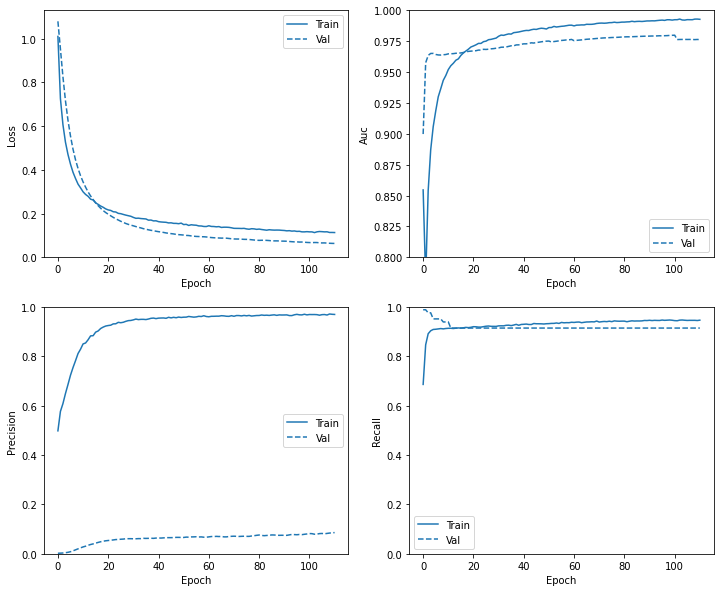

In [49]:
plot_metrics(resampled_history)

### Evaluate metrics

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.06738866120576859
tp :  83.0
fp :  1020.0
tn :  55854.0
fn :  5.0
accuracy :  0.9820055365562439
precision :  0.0752493217587471
recall :  0.9431818127632141
auc :  0.9954634308815002

Legitimate Transactions Detected (True Negatives):  55854
Legitimate Transactions Incorrectly Detected (False Positives):  1020
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  83
Total Fraudulent Transactions:  88


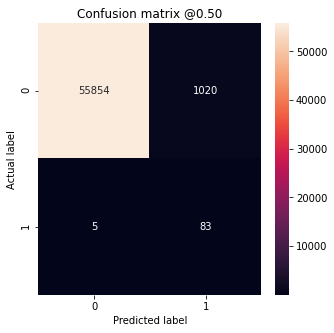

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

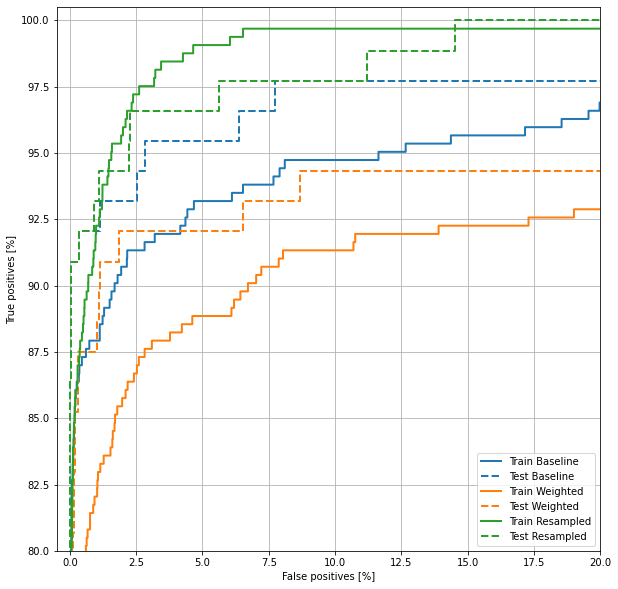

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.